In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from lightgbm import LGBMRegressor, LGBMClassifier
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Dropout,Activation
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import metrics
from tensorflow.python import keras
import tensorflow as tf
import os
from imblearn.over_sampling import SMOTE
import math
from category_encoders import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support as sk
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import accuracy_score
%matplotlib inline

In [29]:
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

import numpy as np
%matplotlib inline

In [30]:
df=pd.read_csv("../../Integrated_data/merged_df_reward.csv",encoding="cp949")

In [31]:
import pandas as pd

class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.interpolated()
        self.abmormaled()
        self.result=self.fill_missing_values()

    # ... (다른 클래스 함수 정의는 여기에 있어야 합니다)

    def interpolated(self):
        temp=[]
        temp2=[]
        for i in df['ID'].unique():
            try:
                temp.append(df[df['ID']==i].interpolate())
            except:
                temp.append(df[df['ID']==i])

        new_df=pd.concat(temp,axis=0)
        new_df.fillna(method='bfill',inplace=True)   
        for i in new_df['ID'].unique():
            temp_df=new_df[new_df['ID']==i].reset_index(drop=True)
            temp_df["height"].fillna(method='bfill',inplace=True)
            temp_df["weight"].fillna(method='bfill',inplace=True)
            temp_df["height"].fillna(method='ffill',inplace=True)
            temp_df["weight"].fillna(method='ffill',inplace=True)
            temp2.append(temp_df)
        new_df=pd.concat(temp2,axis=0)  
        self.df = new_df   
    def gap(self,first, last):
        gap_per=(last-first)/first*100
        return abs(gap_per)
        
    def abmormaled(self):
        temp = []
        for i in self.df['ID'].unique():
            temp_df = self.df[self.df['ID'] == i].reset_index(drop=True)
            for i in range(1, len(temp_df)):
                if temp_df.at[i, 'height'] <= temp_df.at[i - 1, 'height']:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
                if self.gap(temp_df.at[i - 1, 'height'], temp_df.at[i, 'height']) >= 16:
                    temp_df.at[i, 'height'] = temp_df.at[i - 1, 'height']
            temp.append(temp_df)
        new_df2 = pd.concat(temp, axis=0)
        new_df2.reset_index(drop=True, inplace=True)
        self.df = new_df2

    def fill_missing_values(self):
        self.df["step_count"].fillna(self.df["step_count"].median(), inplace=True)
        self.df["burned calory"].fillna(self.df["burned calory"].median(), inplace=True)
        self.df["eat_calory"].fillna(self.df["eat_calory"].median(), inplace=True)
        self.df["Sleep_time"].fillna(self.df["Sleep_time"].median(), inplace=True)
        return self.df
    



In [32]:
import pandas as pd

class TimeSeriesLabeler:
    def __init__(self, term):
        self.term = term
        self.result_df = pd.DataFrame()
        self.labels = []

    def calculate_labels(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            label = []

            for i in range(self.term, len(df_id)):
                previous_days = df_id['weight'].iloc[i - self.term:i]
                current_weight = df_id['weight'].iloc[i]
                if current_weight > previous_days.mean().round(3):
                    label.append(1)
                elif current_weight == previous_days.mean().round(3):
                    label.append(0)
                elif current_weight < previous_days.mean().round(3):
                    label.append(2)
                else:
                    print("error")

            self.labels.extend(label)

    def create_result_df(self, df):
        for id in df['ID'].unique():
            df_id = df[df['ID'] == id].reset_index(drop=True)
            df_id_drop = df_id.drop(index=range(self.term))
            self.result_df = pd.concat([self.result_df, df_id_drop])
        self.result_df['labels']= self.labels
        
    def get_labels(self):
        return self.labels

    def get_result_df(self):
        return self.result_df



In [33]:
for i in range(3):
    globals()['reward_data_{}'.format(i+1)]=pd.read_excel("../../Integrated_data/merged_df_reward_분리.xlsx",sheet_name = i)
    

In [34]:
# 데이터프레임 리스트 생성
dataframes = [reward_data_1, reward_data_2, reward_data_3]

# 반복문으로 데이터프레임 순차적으로 호출
for i, df in enumerate(dataframes, start=0):
    print(f"Processing reward_data_{i+1}")
    processor = DataProcessor(df)
    globals()['df_{}'.format(i+1)]=processor.result


Processing reward_data_1
Processing reward_data_2
Processing reward_data_3


# ID 별로 일주일 간격으로 몸무게 변화 라벨링(유지:0, 감소:2, 증가:1)

In [35]:
term = 5  # You can set your desired 'term' here

In [36]:
labeler_1 = TimeSeriesLabeler(term)
labeler_1.calculate_labels(df_1)  # Provide your DataFrame 'df' as input
labeler_1.create_result_df(df_1)  # Create the result DataFrame
labels = labeler_1.get_labels()
result_df_1 = labeler_1.get_result_df()

In [37]:
labeler_2 = TimeSeriesLabeler(term)
labeler_2.calculate_labels(df_2)  # Provide your DataFrame 'df' as input
labeler_2.create_result_df(df_2)  # Create the result DataFrame
labels = labeler_2.get_labels()
result_df_2 = labeler_2.get_result_df()

In [38]:
labeler_3 = TimeSeriesLabeler(term)
labeler_3.calculate_labels(df_3)  # Provide your DataFrame 'df' as input
labeler_3.create_result_df(df_3)  # Create the result DataFrame
labels = labeler_3.get_labels()
result_df_3 = labeler_3.get_result_df()

In [39]:
result_df_3.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#ASELLU,2022-07-19,2,6,164.0,64.0,5490.0,142.8,546.0,432.0,3,2
6,#ASELLU,2022-07-20,2,6,164.0,64.0,4100.0,142.8,546.0,432.0,3,1
7,#ASELLU,2022-07-21,2,6,164.0,64.0,4919.0,142.8,546.0,432.0,3,2
8,#ASELLU,2022-07-22,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2
9,#ASELLU,2022-07-23,2,6,164.0,64.0,323.0,142.8,546.0,432.0,3,2


# 데이터 세트 로드

In [40]:
result_df_2.head()

,ID,collect_datetime,gender,grade,height,weight,step_count,burned calory,eat_calory,Sleep_time,서포터여부,labels
5,#AAGQKY,2022-07-19,2,4,148.0,45.15,72.0,48.552,2000.0,468.0,2,0
6,#AAGQKY,2022-07-20,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
7,#AAGQKY,2022-07-21,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
8,#AAGQKY,2022-07-22,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2
9,#AAGQKY,2022-07-23,2,4,148.0,28.10,10079.0,48.552,2000.0,468.0,2,2


In [41]:
X_1=result_df_1.iloc[:,[4,5,6,7,8,9]]
y_1=result_df_1.iloc[:,-1]

X_2=result_df_2.iloc[:,[4,5,6,7,8,9]]
y_2=result_df_2.iloc[:,-1]

X_3=result_df_3.iloc[:,[4,5,6,7,8,9]]
y_3=result_df_3.iloc[:,-1]

In [42]:
y_1

5      2
6      2
7      2
8      0
9      0
      ..
177    0
178    0
179    0
180    0
181    0
Name: labels, Length: 37347, dtype: int64

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
scaler_3 = StandardScaler()

X_scaler_1=scaler_1.fit_transform(X_1)
X_scaler_2= scaler_2.fit_transform(X_2)
X_scaler_3= scaler_3.fit_transform(X_3)


smote_1 = SMOTE(random_state=0)
X_over_1,y_over_1 = smote_1.fit_resample(X_scaler_1,y_1)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_1.shape, y_1.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_1.shape, y_over_1.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_1).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_1).value_counts())

smote_2 = SMOTE(random_state=0)
X_over_2,y_over_2 = smote_2.fit_resample(X_scaler_2,y_2)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_2.shape, y_2.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_2.shape, y_over_2.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_2).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_2).value_counts())

smote_3 = SMOTE(random_state=0)
X_over_3,y_over_3 = smote_3.fit_resample(X_scaler_3,y_3)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler_3.shape, y_3.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_over_3.shape, y_over_3.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y_3).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_over_3).value_counts())






SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (37347, 6) (37347,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (100797, 6) (100797,)
SMOTE 적용 전 레이블 값 분포: 
 0    33599
1     2318
2     1430
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    33599
0    33599
1    33599
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (13983, 6) (13983,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (37818, 6) (37818,)
SMOTE 적용 전 레이블 값 분포: 
 0    12606
1      752
2      625
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    12606
2    12606
1    12606
Name: labels, dtype: int64
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (4602, 6) (4602,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (10857, 6) (10857,)
SMOTE 적용 전 레이블 값 분포: 
 0    3619
1     534
2     449
Name: labels, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 2    3619
1    3619
0    3619
Name: labels, dtype: int64


# 데이터 스케일링

## Train, Test dataset 나누기

In [44]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_over_1, y_over_1, test_size=0.20)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_over_2, y_over_2, test_size=0.20)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_over_3, y_over_3, test_size=0.20)

## Global train 데이터 세트 만들기

In [45]:
X_train = np.concatenate((X_train_1,X_train_2,X_train_3), axis=0)
y_train = np.concatenate((y_train_1,y_train_2,y_train_3), axis=0)

In [46]:
X_test = np.concatenate((X_test_1,X_test_2,X_test_3), axis=0)
y_test = np.concatenate((y_test_1,y_test_2,y_test_3), axis=0)

In [47]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

## Client train 데이터 세트 만들기

In [48]:
X_train_1 = torch.FloatTensor(X_train_1)
X_test_1 = torch.FloatTensor(X_test_1)
y_train_1 = torch.LongTensor(y_train_1.to_numpy())
y_test_1 = torch.LongTensor(y_test_1.to_numpy())

train_dataset_1=TensorDataset(X_train_1, y_train_1)
test_dataset_1=TensorDataset(X_test_1, y_test_1)

In [49]:
X_train_2 = torch.FloatTensor(X_train_2)
X_test_2 = torch.FloatTensor(X_test_2)
y_train_2 = torch.LongTensor(y_train_2.to_numpy())
y_test_2 = torch.LongTensor(y_test_2.to_numpy())

train_dataset_2=TensorDataset(X_train_2, y_train_2)
test_dataset_2=TensorDataset(X_test_2, y_test_2)

In [50]:
X_train_3 = torch.FloatTensor(X_train_3)
X_test_3 = torch.FloatTensor(X_test_3)
y_train_3 = torch.LongTensor(y_train_3.to_numpy())
y_test_3 = torch.LongTensor(y_test_3.to_numpy())

train_dataset_3=TensorDataset(X_train_3, y_train_3)
test_dataset_3=TensorDataset(X_test_3, y_test_3)

In [51]:
# from sklearn.model_selection import StratifiedKFold
# skf=StratifiedKFold(n_splits=10)
# skf.get_n_splits(X_train_1,y_train_1)

In [52]:
X_train_over=X_over_2
y_train_over=y_over_2

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 1.08801. Saving Model!
epoch 01, loss: 1.13523, acc: 0.03176, val_loss: 1.08801, val_accuracy: 0.48281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


[INFO] val_acc has been improved from 1.08801 to 1.08042. Saving Model!
epoch 02, loss: 1.08465, acc: 0.49268, val_loss: 1.08042, val_accuracy: 0.45584


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 1.08042 to 1.07380. Saving Model!
epoch 03, loss: 1.07035, acc: 0.53805, val_loss: 1.07380, val_accuracy: 0.45293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


[INFO] val_acc has been improved from 1.07380 to 1.06800. Saving Model!
epoch 04, loss: 1.05973, acc: 0.53258, val_loss: 1.06800, val_accuracy: 0.43522


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


[INFO] val_acc has been improved from 1.06800 to 1.06255. Saving Model!
epoch 05, loss: 1.05002, acc: 0.50817, val_loss: 1.06255, val_accuracy: 0.43813


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


[INFO] val_acc has been improved from 1.06255 to 1.05728. Saving Model!
epoch 06, loss: 1.04064, acc: 0.50743, val_loss: 1.05728, val_accuracy: 0.38921


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


[INFO] val_acc has been improved from 1.05728 to 1.05168. Saving Model!
epoch 07, loss: 1.03052, acc: 0.49550, val_loss: 1.05168, val_accuracy: 0.39265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


[INFO] val_acc has been improved from 1.05168 to 1.04582. Saving Model!
epoch 08, loss: 1.01918, acc: 0.49909, val_loss: 1.04582, val_accuracy: 0.40217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 1.04582 to 1.04019. Saving Model!
epoch 09, loss: 1.00702, acc: 0.50097, val_loss: 1.04019, val_accuracy: 0.41010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 1.04019 to 1.03536. Saving Model!
epoch 10, loss: 0.99488, acc: 0.50482, val_loss: 1.03536, val_accuracy: 0.41407


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 1.03536 to 1.03142. Saving Model!
epoch 11, loss: 0.98288, acc: 0.51422, val_loss: 1.03142, val_accuracy: 0.41460


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


[INFO] val_acc has been improved from 1.03142 to 1.02860. Saving Model!
epoch 12, loss: 0.97170, acc: 0.52409, val_loss: 1.02860, val_accuracy: 0.41856


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


[INFO] val_acc has been improved from 1.02860 to 1.02687. Saving Model!
epoch 13, loss: 0.96169, acc: 0.52662, val_loss: 1.02687, val_accuracy: 0.46668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


[INFO] val_acc has been improved from 1.02687 to 1.02562. Saving Model!
epoch 14, loss: 0.95324, acc: 0.52953, val_loss: 1.02562, val_accuracy: 0.47039


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 1.02562 to 1.02458. Saving Model!
epoch 15, loss: 0.94569, acc: 0.53661, val_loss: 1.02458, val_accuracy: 0.47832


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


[INFO] val_acc has been improved from 1.02458 to 1.02326. Saving Model!
epoch 16, loss: 0.93811, acc: 0.53705, val_loss: 1.02326, val_accuracy: 0.48043


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


[INFO] val_acc has been improved from 1.02326 to 1.02175. Saving Model!
epoch 17, loss: 0.93112, acc: 0.54093, val_loss: 1.02175, val_accuracy: 0.48202


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 1.02175 to 1.02003. Saving Model!
epoch 18, loss: 0.92444, acc: 0.53940, val_loss: 1.02003, val_accuracy: 0.48546


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 1.02003 to 1.01821. Saving Model!
epoch 19, loss: 0.91783, acc: 0.54801, val_loss: 1.01821, val_accuracy: 0.48519


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 1.01821 to 1.01653. Saving Model!
epoch 20, loss: 0.91216, acc: 0.54995, val_loss: 1.01653, val_accuracy: 0.48334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 1.01653 to 1.01525. Saving Model!
epoch 21, loss: 0.90566, acc: 0.55100, val_loss: 1.01525, val_accuracy: 0.48123


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 1.01525 to 1.01399. Saving Model!
epoch 22, loss: 0.90021, acc: 0.55174, val_loss: 1.01399, val_accuracy: 0.48757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 1.01399 to 1.01209. Saving Model!
epoch 23, loss: 0.89585, acc: 0.54992, val_loss: 1.01209, val_accuracy: 0.48995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 1.01209 to 1.01021. Saving Model!
epoch 24, loss: 0.89074, acc: 0.54616, val_loss: 1.01021, val_accuracy: 0.48678


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


[INFO] val_acc has been improved from 1.01021 to 1.00868. Saving Model!
epoch 25, loss: 0.88591, acc: 0.54760, val_loss: 1.00868, val_accuracy: 0.48572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


[INFO] val_acc has been improved from 1.00868 to 1.00716. Saving Model!
epoch 26, loss: 0.88148, acc: 0.54933, val_loss: 1.00716, val_accuracy: 0.49841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


[INFO] val_acc has been improved from 1.00716 to 1.00561. Saving Model!
epoch 27, loss: 0.87729, acc: 0.55336, val_loss: 1.00561, val_accuracy: 0.49841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


[INFO] val_acc has been improved from 1.00561 to 1.00424. Saving Model!
epoch 28, loss: 0.87270, acc: 0.56414, val_loss: 1.00424, val_accuracy: 0.49577


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


[INFO] val_acc has been improved from 1.00424 to 1.00266. Saving Model!
epoch 29, loss: 0.86876, acc: 0.56520, val_loss: 1.00266, val_accuracy: 0.49577


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


[INFO] val_acc has been improved from 1.00266 to 1.00108. Saving Model!
epoch 30, loss: 0.86503, acc: 0.56807, val_loss: 1.00108, val_accuracy: 0.49709


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 1.00108 to 1.00002. Saving Model!
epoch 31, loss: 0.86079, acc: 0.56805, val_loss: 1.00002, val_accuracy: 0.49894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


[INFO] val_acc has been improved from 1.00002 to 0.99898. Saving Model!
epoch 32, loss: 0.85718, acc: 0.56931, val_loss: 0.99898, val_accuracy: 0.50026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


[INFO] val_acc has been improved from 0.99898 to 0.99754. Saving Model!
epoch 33, loss: 0.85404, acc: 0.56949, val_loss: 0.99754, val_accuracy: 0.50026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.99754 to 0.99600. Saving Model!
epoch 34, loss: 0.85056, acc: 0.57289, val_loss: 0.99600, val_accuracy: 0.49947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


[INFO] val_acc has been improved from 0.99600 to 0.99428. Saving Model!
epoch 35, loss: 0.84735, acc: 0.58215, val_loss: 0.99428, val_accuracy: 0.49815


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


[INFO] val_acc has been improved from 0.99428 to 0.99252. Saving Model!
epoch 36, loss: 0.84388, acc: 0.58282, val_loss: 0.99252, val_accuracy: 0.49577


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


[INFO] val_acc has been improved from 0.99252 to 0.99111. Saving Model!
epoch 37, loss: 0.84051, acc: 0.58705, val_loss: 0.99111, val_accuracy: 0.49524


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.99111 to 0.98986. Saving Model!
epoch 38, loss: 0.83770, acc: 0.58744, val_loss: 0.98986, val_accuracy: 0.49233


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


[INFO] val_acc has been improved from 0.98986 to 0.98867. Saving Model!
epoch 39, loss: 0.83405, acc: 0.58867, val_loss: 0.98867, val_accuracy: 0.49392


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


[INFO] val_acc has been improved from 0.98867 to 0.98683. Saving Model!
epoch 40, loss: 0.83142, acc: 0.59399, val_loss: 0.98683, val_accuracy: 0.49418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


[INFO] val_acc has been improved from 0.98683 to 0.98532. Saving Model!
epoch 41, loss: 0.82860, acc: 0.59475, val_loss: 0.98532, val_accuracy: 0.45505


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


[INFO] val_acc has been improved from 0.98532 to 0.98423. Saving Model!
epoch 42, loss: 0.82475, acc: 0.59549, val_loss: 0.98423, val_accuracy: 0.45849


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.98423 to 0.98259. Saving Model!
epoch 43, loss: 0.82224, acc: 0.59610, val_loss: 0.98259, val_accuracy: 0.45928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


[INFO] val_acc has been improved from 0.98259 to 0.98129. Saving Model!
epoch 44, loss: 0.81922, acc: 0.59622, val_loss: 0.98129, val_accuracy: 0.46087


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.98129 to 0.98023. Saving Model!
epoch 45, loss: 0.81643, acc: 0.59643, val_loss: 0.98023, val_accuracy: 0.46219


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


[INFO] val_acc has been improved from 0.98023 to 0.97903. Saving Model!
epoch 46, loss: 0.81367, acc: 0.59819, val_loss: 0.97903, val_accuracy: 0.46430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


[INFO] val_acc has been improved from 0.97903 to 0.97789. Saving Model!
epoch 47, loss: 0.81092, acc: 0.60063, val_loss: 0.97789, val_accuracy: 0.46351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


[INFO] val_acc has been improved from 0.97789 to 0.97676. Saving Model!
epoch 48, loss: 0.80811, acc: 0.60724, val_loss: 0.97676, val_accuracy: 0.46325


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


[INFO] val_acc has been improved from 0.97676 to 0.97546. Saving Model!
epoch 49, loss: 0.80533, acc: 0.60777, val_loss: 0.97546, val_accuracy: 0.46378


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


[INFO] val_acc has been improved from 0.97546 to 0.97478. Saving Model!
epoch 50, loss: 0.80267, acc: 0.60888, val_loss: 0.97478, val_accuracy: 0.46351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


[INFO] val_acc has been improved from 0.97478 to 0.97369. Saving Model!
epoch 51, loss: 0.80022, acc: 0.61021, val_loss: 0.97369, val_accuracy: 0.46351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.90it/s]


[INFO] val_acc has been improved from 0.97369 to 0.97251. Saving Model!
epoch 52, loss: 0.79759, acc: 0.61053, val_loss: 0.97251, val_accuracy: 0.46351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.55it/s]


[INFO] val_acc has been improved from 0.97251 to 0.97167. Saving Model!
epoch 53, loss: 0.79482, acc: 0.61071, val_loss: 0.97167, val_accuracy: 0.46272


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


[INFO] val_acc has been improved from 0.97167 to 0.97062. Saving Model!
epoch 54, loss: 0.79240, acc: 0.61165, val_loss: 0.97062, val_accuracy: 0.46616


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.97062 to 0.96950. Saving Model!
epoch 55, loss: 0.78965, acc: 0.60695, val_loss: 0.96950, val_accuracy: 0.46695


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


[INFO] val_acc has been improved from 0.96950 to 0.96811. Saving Model!
epoch 56, loss: 0.78693, acc: 0.60730, val_loss: 0.96811, val_accuracy: 0.46721


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 0.96811 to 0.96694. Saving Model!
epoch 57, loss: 0.78462, acc: 0.60765, val_loss: 0.96694, val_accuracy: 0.46933


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


[INFO] val_acc has been improved from 0.96694 to 0.96559. Saving Model!
epoch 58, loss: 0.78184, acc: 0.60783, val_loss: 0.96559, val_accuracy: 0.46986


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


[INFO] val_acc has been improved from 0.96559 to 0.96452. Saving Model!
epoch 59, loss: 0.77964, acc: 0.60868, val_loss: 0.96452, val_accuracy: 0.47620


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


[INFO] val_acc has been improved from 0.96452 to 0.96349. Saving Model!
epoch 60, loss: 0.77698, acc: 0.61015, val_loss: 0.96349, val_accuracy: 0.47779


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


[INFO] val_acc has been improved from 0.96349 to 0.96244. Saving Model!
epoch 61, loss: 0.77507, acc: 0.61144, val_loss: 0.96244, val_accuracy: 0.47805


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


[INFO] val_acc has been improved from 0.96244 to 0.96224. Saving Model!
epoch 62, loss: 0.77248, acc: 0.61250, val_loss: 0.96224, val_accuracy: 0.48228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


[INFO] val_acc has been improved from 0.96224 to 0.96159. Saving Model!
epoch 63, loss: 0.77004, acc: 0.61488, val_loss: 0.96159, val_accuracy: 0.48202


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


[INFO] val_acc has been improved from 0.96159 to 0.96053. Saving Model!
epoch 64, loss: 0.76800, acc: 0.61855, val_loss: 0.96053, val_accuracy: 0.48228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.96053 to 0.96029. Saving Model!
epoch 65, loss: 0.76554, acc: 0.62164, val_loss: 0.96029, val_accuracy: 0.48228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


[INFO] val_acc has been improved from 0.96029 to 0.96015. Saving Model!
epoch 66, loss: 0.76313, acc: 0.62913, val_loss: 0.96015, val_accuracy: 0.48281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


[INFO] val_acc has been improved from 0.96015 to 0.95942. Saving Model!
epoch 67, loss: 0.76140, acc: 0.62819, val_loss: 0.95942, val_accuracy: 0.48281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 68, loss: 0.75875, acc: 0.63060, val_loss: 0.95955, val_accuracy: 0.48387


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


[INFO] val_acc has been improved from 0.95942 to 0.95924. Saving Model!
epoch 69, loss: 0.75668, acc: 0.63022, val_loss: 0.95924, val_accuracy: 0.48440


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


[INFO] val_acc has been improved from 0.95924 to 0.95917. Saving Model!
epoch 70, loss: 0.75449, acc: 0.62845, val_loss: 0.95917, val_accuracy: 0.48625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 71, loss: 0.75229, acc: 0.62907, val_loss: 0.95942, val_accuracy: 0.48625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 72, loss: 0.75061, acc: 0.62910, val_loss: 0.95957, val_accuracy: 0.49022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 73, loss: 0.74855, acc: 0.62698, val_loss: 0.95957, val_accuracy: 0.48942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 74, loss: 0.74642, acc: 0.62704, val_loss: 0.95999, val_accuracy: 0.48889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 75, loss: 0.74446, acc: 0.62828, val_loss: 0.96026, val_accuracy: 0.48863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 76, loss: 0.74227, acc: 0.63356, val_loss: 0.96065, val_accuracy: 0.49154


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 77, loss: 0.74029, acc: 0.63245, val_loss: 0.96101, val_accuracy: 0.49180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 78, loss: 0.73829, acc: 0.63301, val_loss: 0.96115, val_accuracy: 0.49154


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 79, loss: 0.73647, acc: 0.63553, val_loss: 0.96125, val_accuracy: 0.49127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 80, loss: 0.73450, acc: 0.63721, val_loss: 0.96201, val_accuracy: 0.49365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 81, loss: 0.73266, acc: 0.63782, val_loss: 0.96290, val_accuracy: 0.49180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 82, loss: 0.73089, acc: 0.64373, val_loss: 0.96330, val_accuracy: 0.49180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 83, loss: 0.72885, acc: 0.64326, val_loss: 0.96410, val_accuracy: 0.49365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 84, loss: 0.72695, acc: 0.64526, val_loss: 0.96482, val_accuracy: 0.49365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 85, loss: 0.72519, acc: 0.65084, val_loss: 0.96542, val_accuracy: 0.49365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 86, loss: 0.72356, acc: 0.65393, val_loss: 0.96641, val_accuracy: 0.49339


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 87, loss: 0.72162, acc: 0.65492, val_loss: 0.96751, val_accuracy: 0.49445


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 88, loss: 0.71974, acc: 0.65516, val_loss: 0.96868, val_accuracy: 0.49418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 89, loss: 0.71810, acc: 0.65871, val_loss: 0.96968, val_accuracy: 0.49445


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 90, loss: 0.71648, acc: 0.66071, val_loss: 0.97047, val_accuracy: 0.49498


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


epoch 91, loss: 0.71450, acc: 0.66165, val_loss: 0.97156, val_accuracy: 0.49524


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 92, loss: 0.71304, acc: 0.65898, val_loss: 0.97286, val_accuracy: 0.49418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 93, loss: 0.71142, acc: 0.65860, val_loss: 0.97329, val_accuracy: 0.49524


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 94, loss: 0.70928, acc: 0.65898, val_loss: 0.97457, val_accuracy: 0.49524


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 95, loss: 0.70791, acc: 0.66250, val_loss: 0.97609, val_accuracy: 0.49603


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 96, loss: 0.70663, acc: 0.66292, val_loss: 0.97724, val_accuracy: 0.49339


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 97, loss: 0.70479, acc: 0.66271, val_loss: 0.97826, val_accuracy: 0.49788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 98, loss: 0.70314, acc: 0.66265, val_loss: 0.97906, val_accuracy: 0.49683


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 99, loss: 0.70149, acc: 0.66618, val_loss: 0.98014, val_accuracy: 0.49709


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 100, loss: 0.70016, acc: 0.66303, val_loss: 0.98081, val_accuracy: 0.50053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 101, loss: 0.69840, acc: 0.66324, val_loss: 0.98171, val_accuracy: 0.50053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 102, loss: 0.69658, acc: 0.66347, val_loss: 0.98285, val_accuracy: 0.50053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 103, loss: 0.69542, acc: 0.66853, val_loss: 0.98366, val_accuracy: 0.50026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 104, loss: 0.69362, acc: 0.66841, val_loss: 0.98555, val_accuracy: 0.50053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 105, loss: 0.69219, acc: 0.66859, val_loss: 0.98657, val_accuracy: 0.49841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96it/s]


epoch 106, loss: 0.69075, acc: 0.67578, val_loss: 0.98766, val_accuracy: 0.49841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 107, loss: 0.68905, acc: 0.67640, val_loss: 0.98903, val_accuracy: 0.49868


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 108, loss: 0.68738, acc: 0.67746, val_loss: 0.99075, val_accuracy: 0.49974


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 109, loss: 0.68617, acc: 0.67819, val_loss: 0.99210, val_accuracy: 0.49974


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 110, loss: 0.68487, acc: 0.67858, val_loss: 0.99310, val_accuracy: 0.50079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 111, loss: 0.68292, acc: 0.68098, val_loss: 0.99438, val_accuracy: 0.50053


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 112, loss: 0.68164, acc: 0.68137, val_loss: 0.99578, val_accuracy: 0.50000


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 113, loss: 0.68023, acc: 0.68163, val_loss: 0.99712, val_accuracy: 0.50291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 114, loss: 0.67885, acc: 0.68248, val_loss: 0.99857, val_accuracy: 0.50264


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 115, loss: 0.67718, acc: 0.68284, val_loss: 0.99979, val_accuracy: 0.50264


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.76it/s]


epoch 116, loss: 0.67573, acc: 0.68619, val_loss: 1.00095, val_accuracy: 0.50582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 117, loss: 0.67436, acc: 0.68654, val_loss: 1.00222, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 118, loss: 0.67281, acc: 0.68689, val_loss: 1.00420, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 119, loss: 0.67149, acc: 0.68965, val_loss: 1.00536, val_accuracy: 0.50714


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


epoch 120, loss: 0.67022, acc: 0.68965, val_loss: 1.00623, val_accuracy: 0.50714


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 121, loss: 0.66845, acc: 0.69074, val_loss: 1.00834, val_accuracy: 0.50793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 122, loss: 0.66722, acc: 0.69573, val_loss: 1.00977, val_accuracy: 0.50793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 123, loss: 0.66614, acc: 0.69559, val_loss: 1.01035, val_accuracy: 0.50820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 124, loss: 0.66453, acc: 0.69588, val_loss: 1.01189, val_accuracy: 0.50846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.70it/s]


epoch 125, loss: 0.66307, acc: 0.69650, val_loss: 1.01312, val_accuracy: 0.50873


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 126, loss: 0.66208, acc: 0.69861, val_loss: 1.01416, val_accuracy: 0.50873


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 127, loss: 0.66029, acc: 0.70011, val_loss: 1.01593, val_accuracy: 0.50873


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 128, loss: 0.65920, acc: 0.69949, val_loss: 1.01698, val_accuracy: 0.50873


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 129, loss: 0.65783, acc: 0.69955, val_loss: 1.01788, val_accuracy: 0.50899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 130, loss: 0.65646, acc: 0.69985, val_loss: 1.01917, val_accuracy: 0.50793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 131, loss: 0.65494, acc: 0.69999, val_loss: 1.02133, val_accuracy: 0.50793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 132, loss: 0.65416, acc: 0.69996, val_loss: 1.02172, val_accuracy: 0.50793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 133, loss: 0.65224, acc: 0.70020, val_loss: 1.02381, val_accuracy: 0.50767


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 134, loss: 0.65146, acc: 0.70099, val_loss: 1.02454, val_accuracy: 0.50714


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 135, loss: 0.65009, acc: 0.70111, val_loss: 1.02510, val_accuracy: 0.50846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 136, loss: 0.64832, acc: 0.70126, val_loss: 1.02711, val_accuracy: 0.50820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65it/s]


epoch 137, loss: 0.64732, acc: 0.70390, val_loss: 1.02903, val_accuracy: 0.50793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21it/s]


epoch 138, loss: 0.64632, acc: 0.70425, val_loss: 1.02886, val_accuracy: 0.50820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 139, loss: 0.64451, acc: 0.70508, val_loss: 1.03028, val_accuracy: 0.50846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 140, loss: 0.64343, acc: 0.70519, val_loss: 1.03224, val_accuracy: 0.50820


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 141, loss: 0.64264, acc: 0.70602, val_loss: 1.03291, val_accuracy: 0.50687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 142, loss: 0.64099, acc: 0.70816, val_loss: 1.03435, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 143, loss: 0.63966, acc: 0.70834, val_loss: 1.03579, val_accuracy: 0.50661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 144, loss: 0.63870, acc: 0.70857, val_loss: 1.03698, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 145, loss: 0.63741, acc: 0.70869, val_loss: 1.03782, val_accuracy: 0.50423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 146, loss: 0.63641, acc: 0.71345, val_loss: 1.03825, val_accuracy: 0.50529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 147, loss: 0.63453, acc: 0.71369, val_loss: 1.04042, val_accuracy: 0.50502


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 148, loss: 0.63373, acc: 0.71380, val_loss: 1.04201, val_accuracy: 0.50502


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 149, loss: 0.63273, acc: 0.71398, val_loss: 1.04184, val_accuracy: 0.50476


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 150, loss: 0.63101, acc: 0.71421, val_loss: 1.04383, val_accuracy: 0.50582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 151, loss: 0.62988, acc: 0.71354, val_loss: 1.04589, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 152, loss: 0.62890, acc: 0.71380, val_loss: 1.04631, val_accuracy: 0.50687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 153, loss: 0.62724, acc: 0.71413, val_loss: 1.04793, val_accuracy: 0.50661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 154, loss: 0.62693, acc: 0.71389, val_loss: 1.04825, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 155, loss: 0.62539, acc: 0.71492, val_loss: 1.04883, val_accuracy: 0.50635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 156, loss: 0.62375, acc: 0.71518, val_loss: 1.05139, val_accuracy: 0.50661


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 157, loss: 0.62327, acc: 0.71498, val_loss: 1.05199, val_accuracy: 0.50899


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 158, loss: 0.62176, acc: 0.71577, val_loss: 1.05320, val_accuracy: 0.50952


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 159, loss: 0.62036, acc: 0.71630, val_loss: 1.05538, val_accuracy: 0.50952


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 160, loss: 0.62003, acc: 0.71742, val_loss: 1.05506, val_accuracy: 0.51031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 161, loss: 0.61821, acc: 0.71753, val_loss: 1.05721, val_accuracy: 0.51005


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 162, loss: 0.61750, acc: 0.71727, val_loss: 1.05797, val_accuracy: 0.51005


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 163, loss: 0.61606, acc: 0.71894, val_loss: 1.05919, val_accuracy: 0.51084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 164, loss: 0.61502, acc: 0.71997, val_loss: 1.06024, val_accuracy: 0.51084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 165, loss: 0.61409, acc: 0.72018, val_loss: 1.06172, val_accuracy: 0.51084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 166, loss: 0.61299, acc: 0.72088, val_loss: 1.06241, val_accuracy: 0.51058


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 167, loss: 0.61178, acc: 0.72130, val_loss: 1.06315, val_accuracy: 0.51243


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 168, loss: 0.61070, acc: 0.72168, val_loss: 1.06503, val_accuracy: 0.51163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 169, loss: 0.60982, acc: 0.72488, val_loss: 1.06556, val_accuracy: 0.51190


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 170, loss: 0.60848, acc: 0.72517, val_loss: 1.06625, val_accuracy: 0.51216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 171, loss: 0.60731, acc: 0.72532, val_loss: 1.06793, val_accuracy: 0.51190


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.82it/s]


epoch 172, loss: 0.60637, acc: 0.72917, val_loss: 1.06976, val_accuracy: 0.51243


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 173, loss: 0.60571, acc: 0.72597, val_loss: 1.06925, val_accuracy: 0.51190


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 174, loss: 0.60409, acc: 0.73170, val_loss: 1.07113, val_accuracy: 0.51190


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 175, loss: 0.60325, acc: 0.73164, val_loss: 1.07283, val_accuracy: 0.51243


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 176, loss: 0.60248, acc: 0.73246, val_loss: 1.07302, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 177, loss: 0.60077, acc: 0.73269, val_loss: 1.07519, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 178, loss: 0.60063, acc: 0.73302, val_loss: 1.07547, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 179, loss: 0.59892, acc: 0.73369, val_loss: 1.07739, val_accuracy: 0.51322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 180, loss: 0.59793, acc: 0.73378, val_loss: 1.07883, val_accuracy: 0.51348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 181, loss: 0.59724, acc: 0.73842, val_loss: 1.07920, val_accuracy: 0.51322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 182, loss: 0.59595, acc: 0.73957, val_loss: 1.08159, val_accuracy: 0.51322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 183, loss: 0.59536, acc: 0.73966, val_loss: 1.08128, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 184, loss: 0.59385, acc: 0.74395, val_loss: 1.08301, val_accuracy: 0.51454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 185, loss: 0.59299, acc: 0.74553, val_loss: 1.08416, val_accuracy: 0.51454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 186, loss: 0.59225, acc: 0.74650, val_loss: 1.08432, val_accuracy: 0.51454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 187, loss: 0.59100, acc: 0.74680, val_loss: 1.08606, val_accuracy: 0.51481


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 188, loss: 0.59013, acc: 0.74683, val_loss: 1.08716, val_accuracy: 0.51534


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 189, loss: 0.58877, acc: 0.74674, val_loss: 1.08893, val_accuracy: 0.51560


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 190, loss: 0.58844, acc: 0.74694, val_loss: 1.08951, val_accuracy: 0.51560


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 191, loss: 0.58721, acc: 0.74712, val_loss: 1.08977, val_accuracy: 0.51534


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 192, loss: 0.58606, acc: 0.74736, val_loss: 1.09128, val_accuracy: 0.51692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 193, loss: 0.58525, acc: 0.74747, val_loss: 1.09278, val_accuracy: 0.51639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 194, loss: 0.58466, acc: 0.74821, val_loss: 1.09226, val_accuracy: 0.51666


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 195, loss: 0.58304, acc: 0.74830, val_loss: 1.09426, val_accuracy: 0.51586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 196, loss: 0.58231, acc: 0.74841, val_loss: 1.09550, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 197, loss: 0.58150, acc: 0.74850, val_loss: 1.09613, val_accuracy: 0.51348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 198, loss: 0.58049, acc: 0.74841, val_loss: 1.09787, val_accuracy: 0.51348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 199, loss: 0.57965, acc: 0.74865, val_loss: 1.09896, val_accuracy: 0.51216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 200, loss: 0.57875, acc: 0.74871, val_loss: 1.10012, val_accuracy: 0.51322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 201, loss: 0.57778, acc: 0.74891, val_loss: 1.10133, val_accuracy: 0.51428


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 202, loss: 0.57701, acc: 0.74909, val_loss: 1.10136, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 203, loss: 0.57560, acc: 0.74976, val_loss: 1.10293, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 204, loss: 0.57541, acc: 0.75003, val_loss: 1.10320, val_accuracy: 0.51348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 205, loss: 0.57407, acc: 0.74994, val_loss: 1.10452, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 206, loss: 0.57345, acc: 0.74991, val_loss: 1.10464, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 207, loss: 0.57241, acc: 0.75000, val_loss: 1.10551, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


epoch 208, loss: 0.57181, acc: 0.75024, val_loss: 1.10538, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 209, loss: 0.57052, acc: 0.75050, val_loss: 1.10712, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 210, loss: 0.57021, acc: 0.75065, val_loss: 1.10752, val_accuracy: 0.51296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 211, loss: 0.56893, acc: 0.75109, val_loss: 1.10951, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


epoch 212, loss: 0.56816, acc: 0.75115, val_loss: 1.11067, val_accuracy: 0.51322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 213, loss: 0.56752, acc: 0.75135, val_loss: 1.11041, val_accuracy: 0.51322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 214, loss: 0.56673, acc: 0.75129, val_loss: 1.11095, val_accuracy: 0.51401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 215, loss: 0.56557, acc: 0.75162, val_loss: 1.11219, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


epoch 216, loss: 0.56500, acc: 0.75182, val_loss: 1.11243, val_accuracy: 0.51719


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 217, loss: 0.56434, acc: 0.75191, val_loss: 1.11398, val_accuracy: 0.51586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 218, loss: 0.56300, acc: 0.75226, val_loss: 1.11647, val_accuracy: 0.51719


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 219, loss: 0.56270, acc: 0.75021, val_loss: 1.11589, val_accuracy: 0.51745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 220, loss: 0.56184, acc: 0.75179, val_loss: 1.11604, val_accuracy: 0.51666


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 221, loss: 0.56076, acc: 0.75191, val_loss: 1.11779, val_accuracy: 0.51772


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 222, loss: 0.56014, acc: 0.75209, val_loss: 1.11895, val_accuracy: 0.51904


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 223, loss: 0.55933, acc: 0.75226, val_loss: 1.11987, val_accuracy: 0.51851


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 224, loss: 0.55835, acc: 0.75276, val_loss: 1.12185, val_accuracy: 0.51904


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 225, loss: 0.55786, acc: 0.75397, val_loss: 1.12129, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 226, loss: 0.55666, acc: 0.75435, val_loss: 1.12313, val_accuracy: 0.52247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 227, loss: 0.55667, acc: 0.75458, val_loss: 1.12220, val_accuracy: 0.52221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 228, loss: 0.55519, acc: 0.75497, val_loss: 1.12363, val_accuracy: 0.52247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 229, loss: 0.55456, acc: 0.75591, val_loss: 1.12538, val_accuracy: 0.52512


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 230, loss: 0.55371, acc: 0.75623, val_loss: 1.12620, val_accuracy: 0.52591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 231, loss: 0.55291, acc: 0.75799, val_loss: 1.12695, val_accuracy: 0.52565


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21it/s]


epoch 232, loss: 0.55272, acc: 0.75808, val_loss: 1.12706, val_accuracy: 0.52591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 233, loss: 0.55153, acc: 0.75858, val_loss: 1.12872, val_accuracy: 0.52644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 234, loss: 0.55064, acc: 0.75881, val_loss: 1.12900, val_accuracy: 0.52538


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 235, loss: 0.55027, acc: 0.75878, val_loss: 1.12873, val_accuracy: 0.52538


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10it/s]


epoch 236, loss: 0.54890, acc: 0.75905, val_loss: 1.13176, val_accuracy: 0.52644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 237, loss: 0.54863, acc: 0.75920, val_loss: 1.13200, val_accuracy: 0.52723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 238, loss: 0.54791, acc: 0.76396, val_loss: 1.13210, val_accuracy: 0.52723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 239, loss: 0.54696, acc: 0.76446, val_loss: 1.13355, val_accuracy: 0.52671


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68it/s]


epoch 240, loss: 0.54612, acc: 0.76434, val_loss: 1.13517, val_accuracy: 0.52776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 241, loss: 0.54574, acc: 0.76448, val_loss: 1.13547, val_accuracy: 0.52776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 242, loss: 0.54503, acc: 0.76460, val_loss: 1.13525, val_accuracy: 0.52935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 243, loss: 0.54376, acc: 0.76519, val_loss: 1.13780, val_accuracy: 0.52909


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 244, loss: 0.54363, acc: 0.76481, val_loss: 1.13784, val_accuracy: 0.52882


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 245, loss: 0.54290, acc: 0.76504, val_loss: 1.13897, val_accuracy: 0.52909


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 246, loss: 0.54204, acc: 0.76569, val_loss: 1.14020, val_accuracy: 0.52909


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 247, loss: 0.54125, acc: 0.76628, val_loss: 1.14087, val_accuracy: 0.53041


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 248, loss: 0.54095, acc: 0.76628, val_loss: 1.14042, val_accuracy: 0.53041


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 249, loss: 0.53984, acc: 0.76634, val_loss: 1.14188, val_accuracy: 0.53067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 250, loss: 0.53913, acc: 0.76657, val_loss: 1.14317, val_accuracy: 0.53094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


epoch 251, loss: 0.53913, acc: 0.76698, val_loss: 1.14216, val_accuracy: 0.53094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 252, loss: 0.53757, acc: 0.76766, val_loss: 1.14425, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 253, loss: 0.53725, acc: 0.76810, val_loss: 1.14491, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 254, loss: 0.53620, acc: 0.76848, val_loss: 1.14639, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 255, loss: 0.53580, acc: 0.76851, val_loss: 1.14764, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 256, loss: 0.53537, acc: 0.76892, val_loss: 1.14754, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 257, loss: 0.53440, acc: 0.76927, val_loss: 1.14818, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 258, loss: 0.53388, acc: 0.76924, val_loss: 1.14828, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 259, loss: 0.53290, acc: 0.76942, val_loss: 1.14985, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 260, loss: 0.53270, acc: 0.76942, val_loss: 1.15055, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 261, loss: 0.53185, acc: 0.77477, val_loss: 1.15149, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 262, loss: 0.53090, acc: 0.77585, val_loss: 1.15293, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 263, loss: 0.53072, acc: 0.77574, val_loss: 1.15343, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.03it/s]


epoch 264, loss: 0.52990, acc: 0.77597, val_loss: 1.15406, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 265, loss: 0.52925, acc: 0.77618, val_loss: 1.15473, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


epoch 266, loss: 0.52865, acc: 0.77630, val_loss: 1.15653, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 267, loss: 0.52802, acc: 0.77656, val_loss: 1.15694, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 268, loss: 0.52719, acc: 0.77691, val_loss: 1.15805, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 269, loss: 0.52682, acc: 0.77718, val_loss: 1.15820, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 270, loss: 0.52602, acc: 0.77727, val_loss: 1.15993, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 271, loss: 0.52577, acc: 0.77741, val_loss: 1.15878, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 272, loss: 0.52430, acc: 0.77765, val_loss: 1.16146, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 273, loss: 0.52391, acc: 0.77803, val_loss: 1.16289, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 274, loss: 0.52406, acc: 0.77779, val_loss: 1.16181, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 275, loss: 0.52248, acc: 0.77791, val_loss: 1.16435, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 276, loss: 0.52256, acc: 0.77882, val_loss: 1.16458, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 277, loss: 0.52149, acc: 0.77900, val_loss: 1.16608, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 278, loss: 0.52140, acc: 0.77912, val_loss: 1.16583, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 279, loss: 0.52064, acc: 0.77965, val_loss: 1.16583, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


epoch 280, loss: 0.51965, acc: 0.77982, val_loss: 1.16801, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 281, loss: 0.51945, acc: 0.78120, val_loss: 1.16766, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 282, loss: 0.51849, acc: 0.78138, val_loss: 1.16801, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 283, loss: 0.51795, acc: 0.78247, val_loss: 1.17037, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


epoch 284, loss: 0.51777, acc: 0.78232, val_loss: 1.17029, val_accuracy: 0.53517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 285, loss: 0.51675, acc: 0.78252, val_loss: 1.17210, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 286, loss: 0.51667, acc: 0.78297, val_loss: 1.17120, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 287, loss: 0.51525, acc: 0.78302, val_loss: 1.17339, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95it/s]


epoch 288, loss: 0.51516, acc: 0.78320, val_loss: 1.17347, val_accuracy: 0.53570


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 289, loss: 0.51444, acc: 0.78346, val_loss: 1.17400, val_accuracy: 0.53517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 290, loss: 0.51361, acc: 0.78396, val_loss: 1.17594, val_accuracy: 0.53570


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 291, loss: 0.51388, acc: 0.78370, val_loss: 1.17493, val_accuracy: 0.53517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s]


epoch 292, loss: 0.51225, acc: 0.78399, val_loss: 1.17847, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 293, loss: 0.51238, acc: 0.78476, val_loss: 1.17675, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 294, loss: 0.51137, acc: 0.78458, val_loss: 1.17868, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 295, loss: 0.51141, acc: 0.78485, val_loss: 1.17907, val_accuracy: 0.53993


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 296, loss: 0.50988, acc: 0.78517, val_loss: 1.18080, val_accuracy: 0.53993


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 297, loss: 0.50968, acc: 0.78493, val_loss: 1.18124, val_accuracy: 0.53993


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 298, loss: 0.50947, acc: 0.78496, val_loss: 1.17940, val_accuracy: 0.53993


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 299, loss: 0.50787, acc: 0.78520, val_loss: 1.18361, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 300, loss: 0.50844, acc: 0.78514, val_loss: 1.18301, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 301, loss: 0.50678, acc: 0.78529, val_loss: 1.18521, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 302, loss: 0.50701, acc: 0.78579, val_loss: 1.18486, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 303, loss: 0.50628, acc: 0.78584, val_loss: 1.18595, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 304, loss: 0.50536, acc: 0.78790, val_loss: 1.18751, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 305, loss: 0.50581, acc: 0.78787, val_loss: 1.18662, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 306, loss: 0.50370, acc: 0.78811, val_loss: 1.18971, val_accuracy: 0.54363


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 307, loss: 0.50416, acc: 0.78778, val_loss: 1.18957, val_accuracy: 0.54363


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 308, loss: 0.50370, acc: 0.78814, val_loss: 1.18820, val_accuracy: 0.54363


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 309, loss: 0.50212, acc: 0.78840, val_loss: 1.19219, val_accuracy: 0.54627


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 310, loss: 0.50278, acc: 0.78834, val_loss: 1.19177, val_accuracy: 0.54389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 311, loss: 0.50193, acc: 0.78837, val_loss: 1.19147, val_accuracy: 0.54416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 312, loss: 0.50079, acc: 0.78902, val_loss: 1.19400, val_accuracy: 0.54680


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 313, loss: 0.50085, acc: 0.78943, val_loss: 1.19375, val_accuracy: 0.54416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 314, loss: 0.49991, acc: 0.78937, val_loss: 1.19531, val_accuracy: 0.54707


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 315, loss: 0.49932, acc: 0.79116, val_loss: 1.19712, val_accuracy: 0.54707


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


epoch 316, loss: 0.49923, acc: 0.79125, val_loss: 1.19742, val_accuracy: 0.54733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 317, loss: 0.49860, acc: 0.79119, val_loss: 1.19763, val_accuracy: 0.54733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 318, loss: 0.49773, acc: 0.79143, val_loss: 1.19898, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


epoch 319, loss: 0.49744, acc: 0.79190, val_loss: 1.20022, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 320, loss: 0.49676, acc: 0.79190, val_loss: 1.20208, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 321, loss: 0.49657, acc: 0.79175, val_loss: 1.20212, val_accuracy: 0.54495


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 322, loss: 0.49527, acc: 0.79193, val_loss: 1.20506, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 323, loss: 0.49563, acc: 0.79237, val_loss: 1.20428, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 324, loss: 0.49488, acc: 0.79187, val_loss: 1.20581, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 325, loss: 0.49417, acc: 0.79243, val_loss: 1.20699, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


epoch 326, loss: 0.49380, acc: 0.79260, val_loss: 1.20686, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 327, loss: 0.49291, acc: 0.79260, val_loss: 1.20990, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 328, loss: 0.49323, acc: 0.79257, val_loss: 1.20880, val_accuracy: 0.54521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 329, loss: 0.49193, acc: 0.79266, val_loss: 1.21079, val_accuracy: 0.54786


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 330, loss: 0.49170, acc: 0.79275, val_loss: 1.21114, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 331, loss: 0.49127, acc: 0.79293, val_loss: 1.21168, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 332, loss: 0.49078, acc: 0.79272, val_loss: 1.21340, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 333, loss: 0.48995, acc: 0.79269, val_loss: 1.21567, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 334, loss: 0.48986, acc: 0.79290, val_loss: 1.21552, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 335, loss: 0.48923, acc: 0.79278, val_loss: 1.21671, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 336, loss: 0.48868, acc: 0.79307, val_loss: 1.21770, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 337, loss: 0.48792, acc: 0.79348, val_loss: 1.21987, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 338, loss: 0.48770, acc: 0.79337, val_loss: 1.21921, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 339, loss: 0.48676, acc: 0.79337, val_loss: 1.22141, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 340, loss: 0.48699, acc: 0.79354, val_loss: 1.22115, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.68it/s]


epoch 341, loss: 0.48629, acc: 0.79272, val_loss: 1.22137, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 342, loss: 0.48524, acc: 0.79263, val_loss: 1.22484, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 343, loss: 0.48510, acc: 0.79378, val_loss: 1.22381, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 344, loss: 0.48488, acc: 0.79366, val_loss: 1.22524, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 345, loss: 0.48399, acc: 0.79381, val_loss: 1.22681, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 346, loss: 0.48379, acc: 0.79316, val_loss: 1.22649, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 347, loss: 0.48270, acc: 0.79375, val_loss: 1.22926, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.96it/s]


epoch 348, loss: 0.48271, acc: 0.79431, val_loss: 1.22773, val_accuracy: 0.54865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 349, loss: 0.48253, acc: 0.79431, val_loss: 1.22905, val_accuracy: 0.54892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 350, loss: 0.48149, acc: 0.79240, val_loss: 1.23193, val_accuracy: 0.54892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 351, loss: 0.48108, acc: 0.79251, val_loss: 1.23328, val_accuracy: 0.54892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


epoch 352, loss: 0.48053, acc: 0.79389, val_loss: 1.23362, val_accuracy: 0.54892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 353, loss: 0.48026, acc: 0.79398, val_loss: 1.23345, val_accuracy: 0.54918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 354, loss: 0.47939, acc: 0.79419, val_loss: 1.23435, val_accuracy: 0.54971


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 355, loss: 0.47908, acc: 0.78911, val_loss: 1.23627, val_accuracy: 0.54944


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 356, loss: 0.47863, acc: 0.78793, val_loss: 1.23845, val_accuracy: 0.54944


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 357, loss: 0.47788, acc: 0.78840, val_loss: 1.23921, val_accuracy: 0.54971


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 358, loss: 0.47769, acc: 0.79322, val_loss: 1.23947, val_accuracy: 0.55024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 359, loss: 0.47683, acc: 0.79395, val_loss: 1.24117, val_accuracy: 0.55024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 360, loss: 0.47747, acc: 0.79363, val_loss: 1.24009, val_accuracy: 0.55024


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 361, loss: 0.47549, acc: 0.79416, val_loss: 1.24358, val_accuracy: 0.55050


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 362, loss: 0.47584, acc: 0.78955, val_loss: 1.24331, val_accuracy: 0.55077


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 363, loss: 0.47524, acc: 0.78958, val_loss: 1.24569, val_accuracy: 0.55130


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 364, loss: 0.47508, acc: 0.78949, val_loss: 1.24504, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 365, loss: 0.47434, acc: 0.79081, val_loss: 1.24589, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 366, loss: 0.47346, acc: 0.79113, val_loss: 1.24981, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 367, loss: 0.47374, acc: 0.79107, val_loss: 1.24993, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 368, loss: 0.47265, acc: 0.79116, val_loss: 1.25125, val_accuracy: 0.55368


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 369, loss: 0.47269, acc: 0.79119, val_loss: 1.25036, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 370, loss: 0.47163, acc: 0.79134, val_loss: 1.25452, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


epoch 371, loss: 0.47176, acc: 0.79154, val_loss: 1.25434, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 372, loss: 0.47128, acc: 0.79137, val_loss: 1.25398, val_accuracy: 0.55368


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.41it/s]


epoch 373, loss: 0.47008, acc: 0.79169, val_loss: 1.25720, val_accuracy: 0.55368


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 374, loss: 0.47063, acc: 0.79198, val_loss: 1.25545, val_accuracy: 0.55341


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 375, loss: 0.46965, acc: 0.79190, val_loss: 1.25753, val_accuracy: 0.55394


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


epoch 376, loss: 0.46942, acc: 0.79345, val_loss: 1.25762, val_accuracy: 0.55394


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 377, loss: 0.46832, acc: 0.79363, val_loss: 1.26134, val_accuracy: 0.55394


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


epoch 378, loss: 0.46854, acc: 0.79366, val_loss: 1.26122, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 379, loss: 0.46811, acc: 0.79384, val_loss: 1.26111, val_accuracy: 0.55394


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 380, loss: 0.46707, acc: 0.79387, val_loss: 1.26431, val_accuracy: 0.55473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 381, loss: 0.46699, acc: 0.79387, val_loss: 1.26465, val_accuracy: 0.55473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 382, loss: 0.46680, acc: 0.79384, val_loss: 1.26363, val_accuracy: 0.55605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 383, loss: 0.46604, acc: 0.79404, val_loss: 1.26536, val_accuracy: 0.55605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85it/s]


epoch 384, loss: 0.46523, acc: 0.79428, val_loss: 1.26895, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 385, loss: 0.46591, acc: 0.79413, val_loss: 1.26699, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 386, loss: 0.46409, acc: 0.79927, val_loss: 1.27142, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 387, loss: 0.46440, acc: 0.79457, val_loss: 1.27175, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


epoch 388, loss: 0.46451, acc: 0.79948, val_loss: 1.26997, val_accuracy: 0.55711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 389, loss: 0.46303, acc: 0.79989, val_loss: 1.27366, val_accuracy: 0.55711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 390, loss: 0.46350, acc: 0.79986, val_loss: 1.27201, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


epoch 391, loss: 0.46206, acc: 0.79989, val_loss: 1.27609, val_accuracy: 0.55738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 392, loss: 0.46237, acc: 0.80001, val_loss: 1.27539, val_accuracy: 0.55738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 393, loss: 0.46205, acc: 0.79977, val_loss: 1.27533, val_accuracy: 0.55738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 394, loss: 0.46057, acc: 0.79998, val_loss: 1.27950, val_accuracy: 0.55711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 395, loss: 0.46171, acc: 0.79989, val_loss: 1.27773, val_accuracy: 0.55764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 396, loss: 0.45981, acc: 0.80004, val_loss: 1.28057, val_accuracy: 0.55764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 397, loss: 0.46015, acc: 0.80197, val_loss: 1.28097, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 398, loss: 0.45971, acc: 0.80180, val_loss: 1.28137, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 399, loss: 0.45882, acc: 0.80200, val_loss: 1.28188, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


epoch 400, loss: 0.45898, acc: 0.80192, val_loss: 1.28228, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 401, loss: 0.45816, acc: 0.80203, val_loss: 1.28398, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 402, loss: 0.45748, acc: 0.80233, val_loss: 1.28529, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.94it/s]


epoch 403, loss: 0.45775, acc: 0.80227, val_loss: 1.28299, val_accuracy: 0.55817


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 404, loss: 0.45669, acc: 0.80236, val_loss: 1.28666, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


epoch 405, loss: 0.45634, acc: 0.80244, val_loss: 1.28964, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 406, loss: 0.45663, acc: 0.80218, val_loss: 1.28711, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 407, loss: 0.45536, acc: 0.80265, val_loss: 1.28961, val_accuracy: 0.55870


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 408, loss: 0.45595, acc: 0.80333, val_loss: 1.28685, val_accuracy: 0.55843


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 409, loss: 0.45440, acc: 0.80350, val_loss: 1.29099, val_accuracy: 0.55843


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 410, loss: 0.45451, acc: 0.80347, val_loss: 1.29308, val_accuracy: 0.55976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 411, loss: 0.45466, acc: 0.80318, val_loss: 1.29124, val_accuracy: 0.55976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 412, loss: 0.45311, acc: 0.80315, val_loss: 1.29593, val_accuracy: 0.56055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 413, loss: 0.45372, acc: 0.80497, val_loss: 1.29515, val_accuracy: 0.56081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 414, loss: 0.45284, acc: 0.80321, val_loss: 1.29569, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 415, loss: 0.45246, acc: 0.80324, val_loss: 1.29615, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


epoch 416, loss: 0.45198, acc: 0.80341, val_loss: 1.29476, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 417, loss: 0.45103, acc: 0.80200, val_loss: 1.29812, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 418, loss: 0.45178, acc: 0.80338, val_loss: 1.29485, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 419, loss: 0.45018, acc: 0.80380, val_loss: 1.29862, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


epoch 420, loss: 0.45021, acc: 0.80415, val_loss: 1.30134, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 421, loss: 0.45026, acc: 0.80415, val_loss: 1.30056, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 422, loss: 0.44969, acc: 0.80474, val_loss: 1.30180, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.09it/s]


epoch 423, loss: 0.44899, acc: 0.80438, val_loss: 1.30387, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 424, loss: 0.44878, acc: 0.80435, val_loss: 1.30472, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 425, loss: 0.44853, acc: 0.80435, val_loss: 1.30169, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 426, loss: 0.44710, acc: 0.80509, val_loss: 1.30624, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 427, loss: 0.44805, acc: 0.80471, val_loss: 1.30545, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 428, loss: 0.44691, acc: 0.80383, val_loss: 1.30706, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 429, loss: 0.44607, acc: 0.80535, val_loss: 1.30963, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 430, loss: 0.44708, acc: 0.80532, val_loss: 1.30688, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 431, loss: 0.44533, acc: 0.80409, val_loss: 1.31046, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 432, loss: 0.44538, acc: 0.80494, val_loss: 1.31159, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 433, loss: 0.44537, acc: 0.80497, val_loss: 1.31050, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 434, loss: 0.44403, acc: 0.80553, val_loss: 1.31336, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 435, loss: 0.44462, acc: 0.80497, val_loss: 1.31230, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 436, loss: 0.44349, acc: 0.80462, val_loss: 1.31440, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 437, loss: 0.44369, acc: 0.80574, val_loss: 1.31411, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 438, loss: 0.44257, acc: 0.80606, val_loss: 1.31754, val_accuracy: 0.56372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 439, loss: 0.44255, acc: 0.80591, val_loss: 1.31644, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 440, loss: 0.44204, acc: 0.80723, val_loss: 1.31869, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 441, loss: 0.44165, acc: 0.80535, val_loss: 1.31842, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 442, loss: 0.44143, acc: 0.80632, val_loss: 1.31852, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 443, loss: 0.44060, acc: 0.80759, val_loss: 1.32171, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 444, loss: 0.44085, acc: 0.80700, val_loss: 1.31897, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 445, loss: 0.43988, acc: 0.80759, val_loss: 1.32140, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 446, loss: 0.43963, acc: 0.80759, val_loss: 1.32258, val_accuracy: 0.56372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 447, loss: 0.43978, acc: 0.80759, val_loss: 1.32094, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68it/s]


epoch 448, loss: 0.43884, acc: 0.80644, val_loss: 1.32394, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 449, loss: 0.43817, acc: 0.80779, val_loss: 1.32615, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 450, loss: 0.43843, acc: 0.80732, val_loss: 1.32567, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 451, loss: 0.43772, acc: 0.80735, val_loss: 1.32630, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 452, loss: 0.43740, acc: 0.80764, val_loss: 1.32754, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 453, loss: 0.43691, acc: 0.80803, val_loss: 1.32913, val_accuracy: 0.56372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 454, loss: 0.43685, acc: 0.80756, val_loss: 1.32862, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 455, loss: 0.43592, acc: 0.80803, val_loss: 1.32904, val_accuracy: 0.56452


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 456, loss: 0.43607, acc: 0.80823, val_loss: 1.32913, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 457, loss: 0.43497, acc: 0.80823, val_loss: 1.33211, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 458, loss: 0.43544, acc: 0.80885, val_loss: 1.33244, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 459, loss: 0.43476, acc: 0.80582, val_loss: 1.33031, val_accuracy: 0.56452


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 460, loss: 0.43414, acc: 0.80688, val_loss: 1.33207, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 461, loss: 0.43367, acc: 0.80920, val_loss: 1.33510, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 462, loss: 0.43389, acc: 0.80797, val_loss: 1.33389, val_accuracy: 0.56504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 463, loss: 0.43300, acc: 0.80926, val_loss: 1.33513, val_accuracy: 0.56478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10it/s]


epoch 464, loss: 0.43259, acc: 0.80973, val_loss: 1.33678, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 465, loss: 0.43302, acc: 0.81120, val_loss: 1.33511, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 466, loss: 0.43138, acc: 0.81214, val_loss: 1.33948, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 467, loss: 0.43251, acc: 0.81082, val_loss: 1.33697, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.91it/s]


epoch 468, loss: 0.43095, acc: 0.81096, val_loss: 1.34028, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 469, loss: 0.43105, acc: 0.81196, val_loss: 1.33986, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 470, loss: 0.43057, acc: 0.81205, val_loss: 1.34271, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 471, loss: 0.43065, acc: 0.81120, val_loss: 1.34114, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27it/s]


epoch 472, loss: 0.42956, acc: 0.81108, val_loss: 1.34211, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 473, loss: 0.42952, acc: 0.81220, val_loss: 1.34377, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 474, loss: 0.42945, acc: 0.81161, val_loss: 1.34419, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 475, loss: 0.42858, acc: 0.81176, val_loss: 1.34648, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14it/s]


epoch 476, loss: 0.42854, acc: 0.81055, val_loss: 1.34441, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 477, loss: 0.42778, acc: 0.81276, val_loss: 1.34690, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 478, loss: 0.42802, acc: 0.81179, val_loss: 1.34548, val_accuracy: 0.56372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 479, loss: 0.42722, acc: 0.81179, val_loss: 1.34838, val_accuracy: 0.56372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12it/s]


epoch 480, loss: 0.42693, acc: 0.81205, val_loss: 1.34840, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 481, loss: 0.42640, acc: 0.81211, val_loss: 1.35084, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 482, loss: 0.42667, acc: 0.81208, val_loss: 1.34892, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 483, loss: 0.42582, acc: 0.81235, val_loss: 1.34847, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 484, loss: 0.42534, acc: 0.81249, val_loss: 1.35111, val_accuracy: 0.56346


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 485, loss: 0.42544, acc: 0.81249, val_loss: 1.35075, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 486, loss: 0.42453, acc: 0.81240, val_loss: 1.35411, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 487, loss: 0.42512, acc: 0.81264, val_loss: 1.35189, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 488, loss: 0.42355, acc: 0.81405, val_loss: 1.35587, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 489, loss: 0.42427, acc: 0.81405, val_loss: 1.35339, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 490, loss: 0.42342, acc: 0.81379, val_loss: 1.35492, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 491, loss: 0.42314, acc: 0.81426, val_loss: 1.35458, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 492, loss: 0.42236, acc: 0.81455, val_loss: 1.35695, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 493, loss: 0.42272, acc: 0.81464, val_loss: 1.35735, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 494, loss: 0.42138, acc: 0.81470, val_loss: 1.35962, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 495, loss: 0.42219, acc: 0.81475, val_loss: 1.35850, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 496, loss: 0.42101, acc: 0.81481, val_loss: 1.36042, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 497, loss: 0.42117, acc: 0.81475, val_loss: 1.35981, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 498, loss: 0.42050, acc: 0.81520, val_loss: 1.36195, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 499, loss: 0.42041, acc: 0.81496, val_loss: 1.36367, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 500, loss: 0.41980, acc: 0.81511, val_loss: 1.36507, val_accuracy: 0.56267
0번째 교차검증
evaluation loss: 0.95917, evaluation accuracy: 0.48625
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0470913	total: 8.89ms	remaining: 8.88s
1:	learn: 1.0031277	total: 16.1ms	remaining: 8.04s
2:	learn: 0.9655502	total: 23.2ms	remaining: 7.72s
3:	learn: 0.9328370	total: 30ms	remaining: 7.46s
4:	learn: 0.9039926	total: 36.6ms	remaining: 7.27s
5:	learn: 0.8788001	total: 45ms	remaining: 7.45s
6:	learn: 0.8566763	total: 51.3ms	remaining: 7.28s
7:	learn: 0.8372333	total: 58.7ms	remaining: 7.28s
8:	learn: 0.8200862	total: 65.2ms	remaining: 7.18s
9:	learn: 0.8050477	total: 73.2ms	remaining: 7.24s
10:	learn: 0.7907054	total: 80ms	remaining: 7.19s
11:	learn: 0.7779372	total: 86.9ms	remaining: 7.15s
12:	learn: 0.7665581	total: 94.3ms	remaining: 7.16s
13:	learn: 0.7555640	total: 101ms	remaining: 7.13s
14:	learn: 0.7463094	total: 108ms	remaining: 7.12s
15:	learn: 0.7381293	total: 115ms	remaining

181:	learn: 0.6311710	total: 1.31s	remaining: 5.91s
182:	learn: 0.6311293	total: 1.32s	remaining: 5.9s
183:	learn: 0.6311005	total: 1.33s	remaining: 5.9s
184:	learn: 0.6310575	total: 1.34s	remaining: 5.92s
185:	learn: 0.6310090	total: 1.35s	remaining: 5.92s
186:	learn: 0.6309747	total: 1.36s	remaining: 5.91s
187:	learn: 0.6309375	total: 1.36s	remaining: 5.9s
188:	learn: 0.6309057	total: 1.38s	remaining: 5.91s
189:	learn: 0.6308787	total: 1.38s	remaining: 5.9s
190:	learn: 0.6308509	total: 1.39s	remaining: 5.9s
191:	learn: 0.6308252	total: 1.4s	remaining: 5.9s
192:	learn: 0.6307959	total: 1.41s	remaining: 5.89s
193:	learn: 0.6307683	total: 1.42s	remaining: 5.88s
194:	learn: 0.6307372	total: 1.42s	remaining: 5.88s
195:	learn: 0.6307020	total: 1.43s	remaining: 5.87s
196:	learn: 0.6306541	total: 1.44s	remaining: 5.86s
197:	learn: 0.6306271	total: 1.45s	remaining: 5.85s
198:	learn: 0.6306029	total: 1.45s	remaining: 5.85s
199:	learn: 0.6305752	total: 1.46s	remaining: 5.84s
200:	learn: 0.63054

366:	learn: 0.6278372	total: 2.76s	remaining: 4.76s
367:	learn: 0.6278297	total: 2.77s	remaining: 4.75s
368:	learn: 0.6278203	total: 2.77s	remaining: 4.74s
369:	learn: 0.6278136	total: 2.78s	remaining: 4.74s
370:	learn: 0.6278072	total: 2.79s	remaining: 4.73s
371:	learn: 0.6277966	total: 2.8s	remaining: 4.72s
372:	learn: 0.6277885	total: 2.8s	remaining: 4.71s
373:	learn: 0.6277797	total: 2.81s	remaining: 4.7s
374:	learn: 0.6277735	total: 2.82s	remaining: 4.7s
375:	learn: 0.6277666	total: 2.83s	remaining: 4.69s
376:	learn: 0.6277598	total: 2.83s	remaining: 4.68s
377:	learn: 0.6277508	total: 2.84s	remaining: 4.68s
378:	learn: 0.6277436	total: 2.85s	remaining: 4.67s
379:	learn: 0.6277356	total: 2.86s	remaining: 4.66s
380:	learn: 0.6277312	total: 2.86s	remaining: 4.65s
381:	learn: 0.6277260	total: 2.87s	remaining: 4.64s
382:	learn: 0.6277210	total: 2.88s	remaining: 4.64s
383:	learn: 0.6277140	total: 2.89s	remaining: 4.63s
384:	learn: 0.6277099	total: 2.89s	remaining: 4.62s
385:	learn: 0.62

538:	learn: 0.6269492	total: 4.21s	remaining: 3.6s
539:	learn: 0.6269473	total: 4.22s	remaining: 3.59s
540:	learn: 0.6269420	total: 4.23s	remaining: 3.58s
541:	learn: 0.6269398	total: 4.23s	remaining: 3.58s
542:	learn: 0.6269375	total: 4.25s	remaining: 3.57s
543:	learn: 0.6269316	total: 4.25s	remaining: 3.57s
544:	learn: 0.6269276	total: 4.26s	remaining: 3.56s
545:	learn: 0.6269232	total: 4.28s	remaining: 3.55s
546:	learn: 0.6269198	total: 4.28s	remaining: 3.55s
547:	learn: 0.6269162	total: 4.29s	remaining: 3.54s
548:	learn: 0.6269125	total: 4.3s	remaining: 3.53s
549:	learn: 0.6269105	total: 4.31s	remaining: 3.52s
550:	learn: 0.6269086	total: 4.32s	remaining: 3.52s
551:	learn: 0.6269029	total: 4.33s	remaining: 3.51s
552:	learn: 0.6269006	total: 4.33s	remaining: 3.5s
553:	learn: 0.6268978	total: 4.34s	remaining: 3.5s
554:	learn: 0.6268941	total: 4.35s	remaining: 3.49s
555:	learn: 0.6268923	total: 4.36s	remaining: 3.48s
556:	learn: 0.6268884	total: 4.37s	remaining: 3.48s
557:	learn: 0.62

698:	learn: 0.6265214	total: 5.67s	remaining: 2.44s
699:	learn: 0.6265193	total: 5.68s	remaining: 2.43s
700:	learn: 0.6265157	total: 5.69s	remaining: 2.43s
701:	learn: 0.6265134	total: 5.7s	remaining: 2.42s
702:	learn: 0.6265113	total: 5.71s	remaining: 2.41s
703:	learn: 0.6265100	total: 5.72s	remaining: 2.4s
704:	learn: 0.6265081	total: 5.73s	remaining: 2.4s
705:	learn: 0.6265070	total: 5.74s	remaining: 2.39s
706:	learn: 0.6265057	total: 5.75s	remaining: 2.38s
707:	learn: 0.6265047	total: 5.75s	remaining: 2.37s
708:	learn: 0.6265020	total: 5.76s	remaining: 2.37s
709:	learn: 0.6264994	total: 5.78s	remaining: 2.36s
710:	learn: 0.6264970	total: 5.79s	remaining: 2.35s
711:	learn: 0.6264931	total: 5.79s	remaining: 2.34s
712:	learn: 0.6264911	total: 5.81s	remaining: 2.34s
713:	learn: 0.6264897	total: 5.82s	remaining: 2.33s
714:	learn: 0.6264864	total: 5.83s	remaining: 2.32s
715:	learn: 0.6264854	total: 5.84s	remaining: 2.31s
716:	learn: 0.6264834	total: 5.84s	remaining: 2.31s
717:	learn: 0.6

868:	learn: 0.6262357	total: 7.32s	remaining: 1.1s
869:	learn: 0.6262332	total: 7.33s	remaining: 1.09s
870:	learn: 0.6262317	total: 7.34s	remaining: 1.09s
871:	learn: 0.6262311	total: 7.35s	remaining: 1.08s
872:	learn: 0.6262298	total: 7.36s	remaining: 1.07s
873:	learn: 0.6262275	total: 7.37s	remaining: 1.06s
874:	learn: 0.6262246	total: 7.38s	remaining: 1.05s
875:	learn: 0.6262221	total: 7.38s	remaining: 1.04s
876:	learn: 0.6262203	total: 7.39s	remaining: 1.04s
877:	learn: 0.6262185	total: 7.4s	remaining: 1.03s
878:	learn: 0.6262175	total: 7.41s	remaining: 1.02s
879:	learn: 0.6262164	total: 7.42s	remaining: 1.01s
880:	learn: 0.6262152	total: 7.43s	remaining: 1s
881:	learn: 0.6262137	total: 7.44s	remaining: 995ms
882:	learn: 0.6262121	total: 7.45s	remaining: 987ms
883:	learn: 0.6262107	total: 7.46s	remaining: 978ms
884:	learn: 0.6262091	total: 7.46s	remaining: 970ms
885:	learn: 0.6262083	total: 7.47s	remaining: 962ms
886:	learn: 0.6262072	total: 7.48s	remaining: 953ms
887:	learn: 0.626

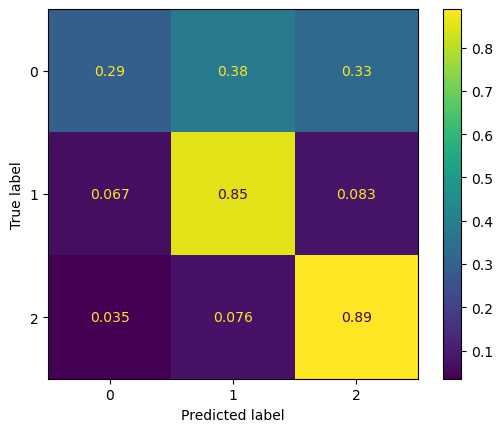

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.72492. Saving Model!
epoch 01, loss: 0.77315, acc: 0.61391, val_loss: 0.72492, val_accuracy: 0.64966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 02, loss: 0.77080, acc: 0.61414, val_loss: 0.72654, val_accuracy: 0.64490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 03, loss: 0.76709, acc: 0.62578, val_loss: 0.72858, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 04, loss: 0.76425, acc: 0.62525, val_loss: 0.73092, val_accuracy: 0.64543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 05, loss: 0.76237, acc: 0.62084, val_loss: 0.73315, val_accuracy: 0.64595


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 06, loss: 0.76067, acc: 0.63289, val_loss: 0.73500, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 07, loss: 0.75902, acc: 0.63495, val_loss: 0.73658, val_accuracy: 0.64701


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 08, loss: 0.75756, acc: 0.63503, val_loss: 0.73805, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 09, loss: 0.75677, acc: 0.63483, val_loss: 0.73936, val_accuracy: 0.64648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 10, loss: 0.75602, acc: 0.63462, val_loss: 0.74042, val_accuracy: 0.64648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 11, loss: 0.75477, acc: 0.63477, val_loss: 0.74131, val_accuracy: 0.64648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 12, loss: 0.75331, acc: 0.63336, val_loss: 0.74204, val_accuracy: 0.64648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 13, loss: 0.75205, acc: 0.63339, val_loss: 0.74277, val_accuracy: 0.64728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 14, loss: 0.75074, acc: 0.63345, val_loss: 0.74352, val_accuracy: 0.64781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 15, loss: 0.74960, acc: 0.63359, val_loss: 0.74425, val_accuracy: 0.64595


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 16, loss: 0.74831, acc: 0.63829, val_loss: 0.74570, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 17, loss: 0.74707, acc: 0.63882, val_loss: 0.74698, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 18, loss: 0.74592, acc: 0.63921, val_loss: 0.74796, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 19, loss: 0.74489, acc: 0.63947, val_loss: 0.74919, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 20, loss: 0.74384, acc: 0.64003, val_loss: 0.75075, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 21, loss: 0.74282, acc: 0.64035, val_loss: 0.75228, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 22, loss: 0.74169, acc: 0.64106, val_loss: 0.75376, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 23, loss: 0.74062, acc: 0.64279, val_loss: 0.75508, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 24, loss: 0.73968, acc: 0.64311, val_loss: 0.75598, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 25, loss: 0.73848, acc: 0.64276, val_loss: 0.75716, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


epoch 26, loss: 0.73737, acc: 0.64405, val_loss: 0.75845, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 27, loss: 0.73625, acc: 0.64429, val_loss: 0.76020, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 28, loss: 0.73504, acc: 0.64482, val_loss: 0.76189, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 29, loss: 0.73428, acc: 0.65022, val_loss: 0.76286, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 30, loss: 0.73329, acc: 0.65022, val_loss: 0.76377, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 31, loss: 0.73212, acc: 0.65049, val_loss: 0.76509, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 32, loss: 0.73118, acc: 0.65413, val_loss: 0.76591, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 33, loss: 0.73025, acc: 0.65416, val_loss: 0.76700, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 34, loss: 0.72904, acc: 0.65434, val_loss: 0.76831, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 35, loss: 0.72808, acc: 0.65437, val_loss: 0.76966, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 36, loss: 0.72721, acc: 0.65410, val_loss: 0.77052, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 37, loss: 0.72620, acc: 0.65401, val_loss: 0.77148, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 38, loss: 0.72506, acc: 0.65451, val_loss: 0.77236, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.75it/s]


epoch 39, loss: 0.72409, acc: 0.65478, val_loss: 0.77328, val_accuracy: 0.61502


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 40, loss: 0.72318, acc: 0.65498, val_loss: 0.77435, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 41, loss: 0.72211, acc: 0.65513, val_loss: 0.77552, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 42, loss: 0.72105, acc: 0.65619, val_loss: 0.77644, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 43, loss: 0.72019, acc: 0.65601, val_loss: 0.77781, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 44, loss: 0.71934, acc: 0.65657, val_loss: 0.77867, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 45, loss: 0.71835, acc: 0.65657, val_loss: 0.77900, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 46, loss: 0.71733, acc: 0.65654, val_loss: 0.77957, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 47, loss: 0.71637, acc: 0.65654, val_loss: 0.78066, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43it/s]


epoch 48, loss: 0.71550, acc: 0.65660, val_loss: 0.78105, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 49, loss: 0.71471, acc: 0.65992, val_loss: 0.78156, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.78it/s]


epoch 50, loss: 0.71374, acc: 0.65827, val_loss: 0.78235, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 51, loss: 0.71279, acc: 0.65907, val_loss: 0.78339, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 52, loss: 0.71188, acc: 0.65913, val_loss: 0.78448, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 53, loss: 0.71096, acc: 0.65933, val_loss: 0.78529, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 54, loss: 0.71009, acc: 0.65936, val_loss: 0.78600, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 55, loss: 0.70918, acc: 0.65965, val_loss: 0.78664, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 56, loss: 0.70823, acc: 0.65965, val_loss: 0.78727, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 57, loss: 0.70738, acc: 0.66259, val_loss: 0.78756, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 58, loss: 0.70654, acc: 0.66262, val_loss: 0.78853, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 59, loss: 0.70555, acc: 0.66327, val_loss: 0.78905, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 60, loss: 0.70472, acc: 0.66333, val_loss: 0.78969, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 61, loss: 0.70382, acc: 0.66841, val_loss: 0.79033, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 62, loss: 0.70302, acc: 0.66844, val_loss: 0.79002, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 63, loss: 0.70203, acc: 0.66841, val_loss: 0.79091, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 64, loss: 0.70117, acc: 0.66941, val_loss: 0.79196, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 65, loss: 0.70034, acc: 0.66973, val_loss: 0.79189, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 66, loss: 0.69935, acc: 0.67000, val_loss: 0.79286, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 67, loss: 0.69857, acc: 0.67026, val_loss: 0.79414, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 68, loss: 0.69765, acc: 0.67191, val_loss: 0.79493, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 69, loss: 0.69676, acc: 0.67088, val_loss: 0.79537, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 70, loss: 0.69596, acc: 0.67270, val_loss: 0.79600, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 71, loss: 0.69516, acc: 0.67117, val_loss: 0.79567, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 72, loss: 0.69410, acc: 0.67329, val_loss: 0.79592, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 73, loss: 0.69318, acc: 0.67332, val_loss: 0.79718, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 74, loss: 0.69272, acc: 0.67320, val_loss: 0.79680, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11it/s]


epoch 75, loss: 0.69156, acc: 0.67311, val_loss: 0.79714, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 76, loss: 0.69063, acc: 0.67317, val_loss: 0.79826, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 77, loss: 0.68983, acc: 0.67834, val_loss: 0.79948, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 78, loss: 0.68906, acc: 0.67863, val_loss: 0.79935, val_accuracy: 0.62586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 79, loss: 0.68800, acc: 0.67963, val_loss: 0.79957, val_accuracy: 0.62665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 80, loss: 0.68715, acc: 0.67972, val_loss: 0.80028, val_accuracy: 0.60471


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


epoch 81, loss: 0.68661, acc: 0.68004, val_loss: 0.79988, val_accuracy: 0.60471


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 82, loss: 0.68556, acc: 0.68125, val_loss: 0.80111, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 83, loss: 0.68465, acc: 0.68057, val_loss: 0.80239, val_accuracy: 0.60629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 84, loss: 0.68398, acc: 0.68084, val_loss: 0.80231, val_accuracy: 0.60629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 85, loss: 0.68311, acc: 0.68093, val_loss: 0.80299, val_accuracy: 0.60656


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


epoch 86, loss: 0.68213, acc: 0.68101, val_loss: 0.80434, val_accuracy: 0.60656


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 87, loss: 0.68153, acc: 0.68225, val_loss: 0.80423, val_accuracy: 0.60629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 88, loss: 0.68045, acc: 0.68228, val_loss: 0.80454, val_accuracy: 0.60629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 89, loss: 0.67966, acc: 0.68248, val_loss: 0.80509, val_accuracy: 0.60629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 90, loss: 0.67884, acc: 0.68251, val_loss: 0.80565, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 91, loss: 0.67811, acc: 0.68266, val_loss: 0.80645, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 92, loss: 0.67703, acc: 0.68304, val_loss: 0.80709, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


epoch 93, loss: 0.67657, acc: 0.68116, val_loss: 0.80585, val_accuracy: 0.60894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 94, loss: 0.67578, acc: 0.68054, val_loss: 0.80661, val_accuracy: 0.60999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 95, loss: 0.67470, acc: 0.68325, val_loss: 0.80832, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 96, loss: 0.67364, acc: 0.68336, val_loss: 0.80985, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 97, loss: 0.67316, acc: 0.68336, val_loss: 0.81025, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 98, loss: 0.67242, acc: 0.68451, val_loss: 0.80903, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 99, loss: 0.67146, acc: 0.68469, val_loss: 0.80953, val_accuracy: 0.61132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 100, loss: 0.67068, acc: 0.68762, val_loss: 0.81093, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 101, loss: 0.66981, acc: 0.68698, val_loss: 0.81115, val_accuracy: 0.56901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 102, loss: 0.66905, acc: 0.68621, val_loss: 0.81200, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 103, loss: 0.66817, acc: 0.68865, val_loss: 0.81267, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 104, loss: 0.66746, acc: 0.68848, val_loss: 0.81142, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


epoch 105, loss: 0.66676, acc: 0.68854, val_loss: 0.81247, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


epoch 106, loss: 0.66574, acc: 0.68830, val_loss: 0.81451, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 107, loss: 0.66489, acc: 0.68760, val_loss: 0.81530, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 108, loss: 0.66431, acc: 0.68745, val_loss: 0.81434, val_accuracy: 0.56901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 109, loss: 0.66349, acc: 0.68748, val_loss: 0.81520, val_accuracy: 0.56901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 110, loss: 0.66247, acc: 0.68783, val_loss: 0.81700, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 111, loss: 0.66170, acc: 0.68889, val_loss: 0.81714, val_accuracy: 0.56795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 112, loss: 0.66095, acc: 0.69324, val_loss: 0.81763, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 113, loss: 0.66016, acc: 0.69321, val_loss: 0.81813, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 114, loss: 0.65939, acc: 0.69529, val_loss: 0.81802, val_accuracy: 0.56716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 115, loss: 0.65861, acc: 0.69529, val_loss: 0.81852, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 116, loss: 0.65763, acc: 0.69547, val_loss: 0.81913, val_accuracy: 0.56769


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 117, loss: 0.65678, acc: 0.69544, val_loss: 0.81859, val_accuracy: 0.56769


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 118, loss: 0.65626, acc: 0.69518, val_loss: 0.81948, val_accuracy: 0.56769


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 119, loss: 0.65543, acc: 0.69541, val_loss: 0.82002, val_accuracy: 0.56822


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 120, loss: 0.65452, acc: 0.69541, val_loss: 0.82151, val_accuracy: 0.56822


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 121, loss: 0.65374, acc: 0.69565, val_loss: 0.82260, val_accuracy: 0.56822


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 122, loss: 0.65302, acc: 0.69600, val_loss: 0.82313, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 123, loss: 0.65220, acc: 0.69626, val_loss: 0.82265, val_accuracy: 0.57113


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 124, loss: 0.65136, acc: 0.69629, val_loss: 0.82188, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 125, loss: 0.65050, acc: 0.69650, val_loss: 0.82299, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 126, loss: 0.64996, acc: 0.70161, val_loss: 0.82418, val_accuracy: 0.56980


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 127, loss: 0.64902, acc: 0.70190, val_loss: 0.82503, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 128, loss: 0.64833, acc: 0.70193, val_loss: 0.82366, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 129, loss: 0.64763, acc: 0.70187, val_loss: 0.82386, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 130, loss: 0.64666, acc: 0.70226, val_loss: 0.82512, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 131, loss: 0.64553, acc: 0.70270, val_loss: 0.82608, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 132, loss: 0.64496, acc: 0.70281, val_loss: 0.82673, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 133, loss: 0.64454, acc: 0.70326, val_loss: 0.82483, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 134, loss: 0.64328, acc: 0.70352, val_loss: 0.82531, val_accuracy: 0.56928


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.44it/s]


epoch 135, loss: 0.64244, acc: 0.70408, val_loss: 0.82657, val_accuracy: 0.56980


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 136, loss: 0.64181, acc: 0.70422, val_loss: 0.82755, val_accuracy: 0.56980


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 137, loss: 0.64074, acc: 0.70425, val_loss: 0.82882, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 138, loss: 0.64028, acc: 0.70446, val_loss: 0.82853, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 139, loss: 0.63945, acc: 0.70458, val_loss: 0.82863, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 140, loss: 0.63879, acc: 0.70872, val_loss: 0.82962, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 141, loss: 0.63774, acc: 0.70943, val_loss: 0.83035, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 142, loss: 0.63723, acc: 0.70934, val_loss: 0.82895, val_accuracy: 0.56901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 143, loss: 0.63634, acc: 0.71057, val_loss: 0.83009, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11it/s]


epoch 144, loss: 0.63527, acc: 0.71081, val_loss: 0.83139, val_accuracy: 0.57113


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 145, loss: 0.63461, acc: 0.71172, val_loss: 0.83260, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 146, loss: 0.63424, acc: 0.71172, val_loss: 0.83184, val_accuracy: 0.57113


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 147, loss: 0.63312, acc: 0.71289, val_loss: 0.83253, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 148, loss: 0.63211, acc: 0.71430, val_loss: 0.83368, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 149, loss: 0.63182, acc: 0.71463, val_loss: 0.83290, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.84it/s]


epoch 150, loss: 0.63103, acc: 0.71498, val_loss: 0.83350, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


epoch 151, loss: 0.62982, acc: 0.71548, val_loss: 0.83489, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 152, loss: 0.62945, acc: 0.71580, val_loss: 0.83458, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


epoch 153, loss: 0.62892, acc: 0.71598, val_loss: 0.83289, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 154, loss: 0.62760, acc: 0.71604, val_loss: 0.83494, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 155, loss: 0.62698, acc: 0.71557, val_loss: 0.83651, val_accuracy: 0.57483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 156, loss: 0.62654, acc: 0.71565, val_loss: 0.83436, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 157, loss: 0.62573, acc: 0.72018, val_loss: 0.83676, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 158, loss: 0.62473, acc: 0.72132, val_loss: 0.83786, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 159, loss: 0.62408, acc: 0.72135, val_loss: 0.83601, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 160, loss: 0.62364, acc: 0.72132, val_loss: 0.83717, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 161, loss: 0.62245, acc: 0.72197, val_loss: 0.83834, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 162, loss: 0.62209, acc: 0.72188, val_loss: 0.83649, val_accuracy: 0.57483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


epoch 163, loss: 0.62151, acc: 0.72544, val_loss: 0.83918, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 164, loss: 0.62015, acc: 0.72641, val_loss: 0.84132, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 165, loss: 0.62003, acc: 0.72647, val_loss: 0.83875, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 166, loss: 0.61924, acc: 0.72608, val_loss: 0.83965, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 167, loss: 0.61806, acc: 0.72673, val_loss: 0.84035, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 168, loss: 0.61776, acc: 0.72717, val_loss: 0.83917, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 169, loss: 0.61701, acc: 0.72738, val_loss: 0.84186, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 170, loss: 0.61600, acc: 0.72791, val_loss: 0.84278, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 171, loss: 0.61553, acc: 0.72776, val_loss: 0.83993, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 172, loss: 0.61495, acc: 0.73293, val_loss: 0.84173, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 173, loss: 0.61390, acc: 0.73369, val_loss: 0.84325, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 174, loss: 0.61346, acc: 0.73381, val_loss: 0.84112, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 175, loss: 0.61262, acc: 0.73340, val_loss: 0.84327, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 176, loss: 0.61169, acc: 0.73425, val_loss: 0.84548, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 177, loss: 0.61139, acc: 0.73469, val_loss: 0.84395, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 178, loss: 0.61052, acc: 0.73419, val_loss: 0.84544, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


epoch 179, loss: 0.60972, acc: 0.73484, val_loss: 0.84489, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 180, loss: 0.60923, acc: 0.73431, val_loss: 0.84488, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 181, loss: 0.60821, acc: 0.73513, val_loss: 0.84706, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 182, loss: 0.60749, acc: 0.73554, val_loss: 0.84746, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 183, loss: 0.60721, acc: 0.73531, val_loss: 0.84640, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 184, loss: 0.60629, acc: 0.73534, val_loss: 0.84895, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 185, loss: 0.60518, acc: 0.73610, val_loss: 0.84934, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 186, loss: 0.60530, acc: 0.73769, val_loss: 0.84629, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 187, loss: 0.60419, acc: 0.73778, val_loss: 0.84883, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 188, loss: 0.60299, acc: 0.73842, val_loss: 0.85093, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 189, loss: 0.60328, acc: 0.73798, val_loss: 0.84946, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 190, loss: 0.60221, acc: 0.73825, val_loss: 0.85175, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 191, loss: 0.60099, acc: 0.73878, val_loss: 0.85354, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 192, loss: 0.60135, acc: 0.73839, val_loss: 0.84991, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 193, loss: 0.60022, acc: 0.73831, val_loss: 0.85292, val_accuracy: 0.57879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 194, loss: 0.59896, acc: 0.73919, val_loss: 0.85591, val_accuracy: 0.57879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 195, loss: 0.59929, acc: 0.73939, val_loss: 0.85195, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 196, loss: 0.59807, acc: 0.73925, val_loss: 0.85457, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 197, loss: 0.59717, acc: 0.73986, val_loss: 0.85460, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 198, loss: 0.59685, acc: 0.73972, val_loss: 0.85557, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 199, loss: 0.59600, acc: 0.74030, val_loss: 0.85499, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


epoch 200, loss: 0.59524, acc: 0.74268, val_loss: 0.85331, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 201, loss: 0.59498, acc: 0.74239, val_loss: 0.85587, val_accuracy: 0.58170


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 202, loss: 0.59407, acc: 0.74295, val_loss: 0.85392, val_accuracy: 0.58170


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 203, loss: 0.59327, acc: 0.74310, val_loss: 0.85604, val_accuracy: 0.58197


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 204, loss: 0.59238, acc: 0.74357, val_loss: 0.85914, val_accuracy: 0.58223


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 205, loss: 0.59266, acc: 0.74312, val_loss: 0.85262, val_accuracy: 0.58223


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 206, loss: 0.59133, acc: 0.74333, val_loss: 0.85578, val_accuracy: 0.58329


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 207, loss: 0.59012, acc: 0.74404, val_loss: 0.85719, val_accuracy: 0.58329


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 208, loss: 0.59011, acc: 0.74395, val_loss: 0.85939, val_accuracy: 0.58329


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 209, loss: 0.58916, acc: 0.74456, val_loss: 0.85966, val_accuracy: 0.58355


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 210, loss: 0.58881, acc: 0.74459, val_loss: 0.85420, val_accuracy: 0.58276


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 211, loss: 0.58801, acc: 0.74474, val_loss: 0.85750, val_accuracy: 0.58329


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 212, loss: 0.58696, acc: 0.74548, val_loss: 0.85953, val_accuracy: 0.58329


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.58it/s]


epoch 213, loss: 0.58676, acc: 0.74571, val_loss: 0.85829, val_accuracy: 0.58355


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 214, loss: 0.58593, acc: 0.74665, val_loss: 0.85956, val_accuracy: 0.58355


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 215, loss: 0.58541, acc: 0.74583, val_loss: 0.85872, val_accuracy: 0.58355


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 216, loss: 0.58472, acc: 0.74612, val_loss: 0.85947, val_accuracy: 0.58408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 217, loss: 0.58378, acc: 0.74630, val_loss: 0.85805, val_accuracy: 0.58435


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 218, loss: 0.58304, acc: 0.74700, val_loss: 0.86170, val_accuracy: 0.58408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 219, loss: 0.58315, acc: 0.74880, val_loss: 0.85679, val_accuracy: 0.58355


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 220, loss: 0.58171, acc: 0.74715, val_loss: 0.85860, val_accuracy: 0.58408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 221, loss: 0.58097, acc: 0.74906, val_loss: 0.86172, val_accuracy: 0.58488


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 222, loss: 0.58118, acc: 0.74941, val_loss: 0.86153, val_accuracy: 0.58488


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 223, loss: 0.57992, acc: 0.74903, val_loss: 0.86345, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 224, loss: 0.57917, acc: 0.74947, val_loss: 0.86153, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 225, loss: 0.57896, acc: 0.74935, val_loss: 0.86241, val_accuracy: 0.58488


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 226, loss: 0.57790, acc: 0.74953, val_loss: 0.85892, val_accuracy: 0.58488


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 227, loss: 0.57757, acc: 0.75109, val_loss: 0.85951, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 228, loss: 0.57677, acc: 0.75050, val_loss: 0.86569, val_accuracy: 0.58514


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 229, loss: 0.57609, acc: 0.75129, val_loss: 0.86537, val_accuracy: 0.58435


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 230, loss: 0.57556, acc: 0.75150, val_loss: 0.86580, val_accuracy: 0.58514


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 231, loss: 0.57458, acc: 0.75068, val_loss: 0.86197, val_accuracy: 0.58435


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 232, loss: 0.57459, acc: 0.75135, val_loss: 0.86645, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 233, loss: 0.57389, acc: 0.75012, val_loss: 0.86134, val_accuracy: 0.58435


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 234, loss: 0.57280, acc: 0.75282, val_loss: 0.86508, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 235, loss: 0.57230, acc: 0.75203, val_loss: 0.86864, val_accuracy: 0.58488


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 236, loss: 0.57203, acc: 0.75112, val_loss: 0.86206, val_accuracy: 0.58435


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 237, loss: 0.57108, acc: 0.75297, val_loss: 0.86611, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 238, loss: 0.57063, acc: 0.75241, val_loss: 0.86658, val_accuracy: 0.58461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 239, loss: 0.57006, acc: 0.75232, val_loss: 0.86737, val_accuracy: 0.58540


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 240, loss: 0.56923, acc: 0.75270, val_loss: 0.86931, val_accuracy: 0.58514


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 241, loss: 0.56883, acc: 0.75273, val_loss: 0.86405, val_accuracy: 0.58593


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 242, loss: 0.56808, acc: 0.75291, val_loss: 0.86889, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 243, loss: 0.56763, acc: 0.75329, val_loss: 0.86793, val_accuracy: 0.58937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 244, loss: 0.56705, acc: 0.75403, val_loss: 0.87062, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 245, loss: 0.56605, acc: 0.75338, val_loss: 0.87559, val_accuracy: 0.59122


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 246, loss: 0.56574, acc: 0.75388, val_loss: 0.87235, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 247, loss: 0.56533, acc: 0.75279, val_loss: 0.87215, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 248, loss: 0.56456, acc: 0.75297, val_loss: 0.87572, val_accuracy: 0.59281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 249, loss: 0.56413, acc: 0.75335, val_loss: 0.86860, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 250, loss: 0.56296, acc: 0.75455, val_loss: 0.87347, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 251, loss: 0.56310, acc: 0.75382, val_loss: 0.87541, val_accuracy: 0.59360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 252, loss: 0.56226, acc: 0.75464, val_loss: 0.87402, val_accuracy: 0.59413


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 253, loss: 0.56137, acc: 0.75511, val_loss: 0.87734, val_accuracy: 0.59625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 254, loss: 0.56145, acc: 0.75411, val_loss: 0.87184, val_accuracy: 0.59598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 255, loss: 0.56051, acc: 0.75538, val_loss: 0.87583, val_accuracy: 0.59625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 256, loss: 0.55954, acc: 0.75605, val_loss: 0.87792, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 257, loss: 0.55971, acc: 0.75629, val_loss: 0.87744, val_accuracy: 0.59677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.73it/s]


epoch 258, loss: 0.55867, acc: 0.75617, val_loss: 0.88260, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 259, loss: 0.55801, acc: 0.75667, val_loss: 0.88015, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 260, loss: 0.55811, acc: 0.75782, val_loss: 0.88018, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 261, loss: 0.55682, acc: 0.75802, val_loss: 0.88417, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 262, loss: 0.55641, acc: 0.75705, val_loss: 0.88114, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.83it/s]


epoch 263, loss: 0.55631, acc: 0.75679, val_loss: 0.88389, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 264, loss: 0.55542, acc: 0.75849, val_loss: 0.87545, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 265, loss: 0.55491, acc: 0.75831, val_loss: 0.88070, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 266, loss: 0.55427, acc: 0.75814, val_loss: 0.88436, val_accuracy: 0.59889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 267, loss: 0.55449, acc: 0.75881, val_loss: 0.88329, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 268, loss: 0.55264, acc: 0.76399, val_loss: 0.88828, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 269, loss: 0.55253, acc: 0.75914, val_loss: 0.89187, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 270, loss: 0.55274, acc: 0.75990, val_loss: 0.88549, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 271, loss: 0.55138, acc: 0.76457, val_loss: 0.88615, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 272, loss: 0.55068, acc: 0.76484, val_loss: 0.88898, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 273, loss: 0.55087, acc: 0.76451, val_loss: 0.88934, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 274, loss: 0.55014, acc: 0.76425, val_loss: 0.88629, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 275, loss: 0.54895, acc: 0.76469, val_loss: 0.89082, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 276, loss: 0.54946, acc: 0.76639, val_loss: 0.88652, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 277, loss: 0.54820, acc: 0.76663, val_loss: 0.88969, val_accuracy: 0.59704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 278, loss: 0.54733, acc: 0.76769, val_loss: 0.89317, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 279, loss: 0.54789, acc: 0.76681, val_loss: 0.88802, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 280, loss: 0.54671, acc: 0.76660, val_loss: 0.89096, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 281, loss: 0.54563, acc: 0.76722, val_loss: 0.89528, val_accuracy: 0.60074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 282, loss: 0.54615, acc: 0.76622, val_loss: 0.89223, val_accuracy: 0.59968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 283, loss: 0.54511, acc: 0.76733, val_loss: 0.89484, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 284, loss: 0.54441, acc: 0.76642, val_loss: 0.89621, val_accuracy: 0.60074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 285, loss: 0.54423, acc: 0.76783, val_loss: 0.89319, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 286, loss: 0.54361, acc: 0.76751, val_loss: 0.89482, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 287, loss: 0.54236, acc: 0.76792, val_loss: 0.89967, val_accuracy: 0.60153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 288, loss: 0.54351, acc: 0.76769, val_loss: 0.88901, val_accuracy: 0.60021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 289, loss: 0.54164, acc: 0.76863, val_loss: 0.89330, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 290, loss: 0.54129, acc: 0.76924, val_loss: 0.89525, val_accuracy: 0.60100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 291, loss: 0.54171, acc: 0.76895, val_loss: 0.89806, val_accuracy: 0.60100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 292, loss: 0.54004, acc: 0.76921, val_loss: 0.89907, val_accuracy: 0.60127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 293, loss: 0.53973, acc: 0.76836, val_loss: 0.89989, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 294, loss: 0.53974, acc: 0.76827, val_loss: 0.89805, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 295, loss: 0.53867, acc: 0.76789, val_loss: 0.90095, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 296, loss: 0.53850, acc: 0.76783, val_loss: 0.89435, val_accuracy: 0.60127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 297, loss: 0.53814, acc: 0.76789, val_loss: 0.89758, val_accuracy: 0.60127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 298, loss: 0.53683, acc: 0.76830, val_loss: 0.89962, val_accuracy: 0.60286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 299, loss: 0.53710, acc: 0.76836, val_loss: 0.90281, val_accuracy: 0.60312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 300, loss: 0.53659, acc: 0.76963, val_loss: 0.90138, val_accuracy: 0.60259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 301, loss: 0.53544, acc: 0.76995, val_loss: 0.90454, val_accuracy: 0.60286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 302, loss: 0.53552, acc: 0.76863, val_loss: 0.89958, val_accuracy: 0.60206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 303, loss: 0.53484, acc: 0.76936, val_loss: 0.90192, val_accuracy: 0.60338


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 304, loss: 0.53397, acc: 0.77030, val_loss: 0.90252, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 305, loss: 0.53428, acc: 0.76863, val_loss: 0.90524, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 306, loss: 0.53296, acc: 0.76951, val_loss: 0.90293, val_accuracy: 0.60312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 307, loss: 0.53280, acc: 0.77010, val_loss: 0.90483, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 308, loss: 0.53221, acc: 0.77001, val_loss: 0.90608, val_accuracy: 0.60418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 309, loss: 0.53200, acc: 0.76772, val_loss: 0.90458, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 310, loss: 0.53064, acc: 0.76913, val_loss: 0.90771, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 311, loss: 0.53089, acc: 0.76886, val_loss: 0.90640, val_accuracy: 0.60418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 312, loss: 0.52998, acc: 0.76910, val_loss: 0.90859, val_accuracy: 0.60418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 313, loss: 0.52959, acc: 0.76916, val_loss: 0.90720, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 314, loss: 0.52935, acc: 0.76930, val_loss: 0.90968, val_accuracy: 0.60762


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 315, loss: 0.52864, acc: 0.76816, val_loss: 0.90151, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 316, loss: 0.52807, acc: 0.77424, val_loss: 0.90610, val_accuracy: 0.60788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


epoch 317, loss: 0.52770, acc: 0.76739, val_loss: 0.90589, val_accuracy: 0.60762


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 318, loss: 0.52730, acc: 0.77350, val_loss: 0.91145, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 319, loss: 0.52646, acc: 0.77386, val_loss: 0.90980, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 320, loss: 0.52645, acc: 0.77365, val_loss: 0.91182, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06it/s]


epoch 321, loss: 0.52581, acc: 0.77392, val_loss: 0.90850, val_accuracy: 0.60999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 322, loss: 0.52498, acc: 0.77556, val_loss: 0.91226, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 323, loss: 0.52501, acc: 0.77568, val_loss: 0.91357, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 324, loss: 0.52441, acc: 0.77947, val_loss: 0.91290, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 325, loss: 0.52351, acc: 0.77944, val_loss: 0.91213, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 326, loss: 0.52339, acc: 0.77947, val_loss: 0.91158, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 327, loss: 0.52291, acc: 0.78082, val_loss: 0.91460, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 328, loss: 0.52242, acc: 0.77944, val_loss: 0.91093, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 329, loss: 0.52175, acc: 0.78061, val_loss: 0.91501, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


epoch 330, loss: 0.52152, acc: 0.77962, val_loss: 0.91114, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 331, loss: 0.52084, acc: 0.77944, val_loss: 0.91671, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 332, loss: 0.52039, acc: 0.77979, val_loss: 0.91191, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 333, loss: 0.52016, acc: 0.77967, val_loss: 0.91785, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 334, loss: 0.51984, acc: 0.77979, val_loss: 0.91215, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 335, loss: 0.51891, acc: 0.78208, val_loss: 0.91642, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 336, loss: 0.51832, acc: 0.78079, val_loss: 0.91568, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 337, loss: 0.51847, acc: 0.78150, val_loss: 0.91885, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 338, loss: 0.51742, acc: 0.78067, val_loss: 0.91937, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 339, loss: 0.51743, acc: 0.77571, val_loss: 0.91710, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 340, loss: 0.51648, acc: 0.77641, val_loss: 0.91816, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 341, loss: 0.51672, acc: 0.77588, val_loss: 0.91859, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 342, loss: 0.51551, acc: 0.78138, val_loss: 0.92128, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 343, loss: 0.51555, acc: 0.78132, val_loss: 0.91510, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 344, loss: 0.51458, acc: 0.78258, val_loss: 0.92104, val_accuracy: 0.63379


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 345, loss: 0.51431, acc: 0.77671, val_loss: 0.91796, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 346, loss: 0.51422, acc: 0.77721, val_loss: 0.92089, val_accuracy: 0.63432


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 347, loss: 0.51289, acc: 0.77812, val_loss: 0.91985, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 348, loss: 0.51337, acc: 0.77806, val_loss: 0.92282, val_accuracy: 0.63458


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 349, loss: 0.51235, acc: 0.77685, val_loss: 0.91732, val_accuracy: 0.63379


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 350, loss: 0.51183, acc: 0.77803, val_loss: 0.91970, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 351, loss: 0.51195, acc: 0.77656, val_loss: 0.91722, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 352, loss: 0.51095, acc: 0.77923, val_loss: 0.92379, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 353, loss: 0.51058, acc: 0.77879, val_loss: 0.92592, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 354, loss: 0.51064, acc: 0.77885, val_loss: 0.92428, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 355, loss: 0.50938, acc: 0.77859, val_loss: 0.92174, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 356, loss: 0.50931, acc: 0.77856, val_loss: 0.92283, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 357, loss: 0.50885, acc: 0.77873, val_loss: 0.92512, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 358, loss: 0.50837, acc: 0.77929, val_loss: 0.92535, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 359, loss: 0.50796, acc: 0.78014, val_loss: 0.92427, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 360, loss: 0.50726, acc: 0.78158, val_loss: 0.92835, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 361, loss: 0.50713, acc: 0.77973, val_loss: 0.92609, val_accuracy: 0.63961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 362, loss: 0.50631, acc: 0.78132, val_loss: 0.92788, val_accuracy: 0.63961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 363, loss: 0.50675, acc: 0.78252, val_loss: 0.92239, val_accuracy: 0.63670


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 364, loss: 0.50530, acc: 0.78314, val_loss: 0.92601, val_accuracy: 0.63987


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 365, loss: 0.50520, acc: 0.78120, val_loss: 0.92901, val_accuracy: 0.64014


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


epoch 366, loss: 0.50513, acc: 0.78150, val_loss: 0.92992, val_accuracy: 0.63987


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 367, loss: 0.50413, acc: 0.78282, val_loss: 0.93141, val_accuracy: 0.63961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 368, loss: 0.50395, acc: 0.78308, val_loss: 0.93156, val_accuracy: 0.63987


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 369, loss: 0.50350, acc: 0.78323, val_loss: 0.92988, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 370, loss: 0.50256, acc: 0.78344, val_loss: 0.93084, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 371, loss: 0.50349, acc: 0.78273, val_loss: 0.92444, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 372, loss: 0.50169, acc: 0.78267, val_loss: 0.93234, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 373, loss: 0.50154, acc: 0.78355, val_loss: 0.93355, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 374, loss: 0.50170, acc: 0.78352, val_loss: 0.93262, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 375, loss: 0.50034, acc: 0.78405, val_loss: 0.93356, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 376, loss: 0.50084, acc: 0.78367, val_loss: 0.93281, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 377, loss: 0.49958, acc: 0.78411, val_loss: 0.93329, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 378, loss: 0.49950, acc: 0.78358, val_loss: 0.93280, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 379, loss: 0.49910, acc: 0.78558, val_loss: 0.93782, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 380, loss: 0.49896, acc: 0.78514, val_loss: 0.92972, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 381, loss: 0.49786, acc: 0.78370, val_loss: 0.93389, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 382, loss: 0.49774, acc: 0.78631, val_loss: 0.93512, val_accuracy: 0.64278


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 383, loss: 0.49749, acc: 0.78584, val_loss: 0.93831, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 384, loss: 0.49658, acc: 0.78643, val_loss: 0.93540, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 385, loss: 0.49646, acc: 0.78579, val_loss: 0.93646, val_accuracy: 0.64278


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 386, loss: 0.49618, acc: 0.78584, val_loss: 0.93728, val_accuracy: 0.64305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 387, loss: 0.49515, acc: 0.78629, val_loss: 0.93999, val_accuracy: 0.64305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 388, loss: 0.49608, acc: 0.78605, val_loss: 0.93336, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 389, loss: 0.49395, acc: 0.78655, val_loss: 0.93848, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 390, loss: 0.49446, acc: 0.78755, val_loss: 0.94024, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 391, loss: 0.49448, acc: 0.78631, val_loss: 0.94044, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 392, loss: 0.49263, acc: 0.78678, val_loss: 0.93898, val_accuracy: 0.64490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68it/s]


epoch 393, loss: 0.49349, acc: 0.78708, val_loss: 0.93811, val_accuracy: 0.64569


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 394, loss: 0.49286, acc: 0.78664, val_loss: 0.93876, val_accuracy: 0.64622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 395, loss: 0.49165, acc: 0.78734, val_loss: 0.94142, val_accuracy: 0.64622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 396, loss: 0.49216, acc: 0.78740, val_loss: 0.93745, val_accuracy: 0.64622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 397, loss: 0.49115, acc: 0.78705, val_loss: 0.93458, val_accuracy: 0.64648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 398, loss: 0.49072, acc: 0.78725, val_loss: 0.94268, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 399, loss: 0.49056, acc: 0.78767, val_loss: 0.94149, val_accuracy: 0.64648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 400, loss: 0.48962, acc: 0.78811, val_loss: 0.94007, val_accuracy: 0.64701


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 401, loss: 0.48985, acc: 0.78796, val_loss: 0.93577, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


epoch 402, loss: 0.48902, acc: 0.78778, val_loss: 0.94105, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 403, loss: 0.48830, acc: 0.78905, val_loss: 0.94349, val_accuracy: 0.64701


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 404, loss: 0.48949, acc: 0.78714, val_loss: 0.93762, val_accuracy: 0.64728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 405, loss: 0.48674, acc: 0.78734, val_loss: 0.94336, val_accuracy: 0.64781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 406, loss: 0.48776, acc: 0.78905, val_loss: 0.94292, val_accuracy: 0.64728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 407, loss: 0.48783, acc: 0.78852, val_loss: 0.94568, val_accuracy: 0.64701


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 408, loss: 0.48567, acc: 0.78928, val_loss: 0.94425, val_accuracy: 0.64728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 409, loss: 0.48665, acc: 0.78772, val_loss: 0.94358, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 410, loss: 0.48549, acc: 0.78817, val_loss: 0.94677, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 411, loss: 0.48564, acc: 0.78814, val_loss: 0.94367, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 412, loss: 0.48475, acc: 0.78840, val_loss: 0.94630, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 413, loss: 0.48486, acc: 0.78831, val_loss: 0.94520, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 414, loss: 0.48424, acc: 0.78817, val_loss: 0.94789, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 415, loss: 0.48301, acc: 0.78952, val_loss: 0.94345, val_accuracy: 0.64886


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 416, loss: 0.48402, acc: 0.78817, val_loss: 0.94466, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 417, loss: 0.48215, acc: 0.78908, val_loss: 0.95168, val_accuracy: 0.64860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 418, loss: 0.48294, acc: 0.79049, val_loss: 0.95052, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 419, loss: 0.48249, acc: 0.78919, val_loss: 0.94546, val_accuracy: 0.64886


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24it/s]


epoch 420, loss: 0.48114, acc: 0.78937, val_loss: 0.94961, val_accuracy: 0.64913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 421, loss: 0.48161, acc: 0.78963, val_loss: 0.95332, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 422, loss: 0.48085, acc: 0.79016, val_loss: 0.95114, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 423, loss: 0.48032, acc: 0.78996, val_loss: 0.95233, val_accuracy: 0.64966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 424, loss: 0.48046, acc: 0.78987, val_loss: 0.94647, val_accuracy: 0.64913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 425, loss: 0.47937, acc: 0.79019, val_loss: 0.95178, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 426, loss: 0.47903, acc: 0.79052, val_loss: 0.95336, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 427, loss: 0.47934, acc: 0.78978, val_loss: 0.95109, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 428, loss: 0.47786, acc: 0.79049, val_loss: 0.95389, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 429, loss: 0.47824, acc: 0.79090, val_loss: 0.95378, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 430, loss: 0.47812, acc: 0.78972, val_loss: 0.95406, val_accuracy: 0.64966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 431, loss: 0.47631, acc: 0.79075, val_loss: 0.95797, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 432, loss: 0.47768, acc: 0.79046, val_loss: 0.95526, val_accuracy: 0.64966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 433, loss: 0.47562, acc: 0.79099, val_loss: 0.95984, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 434, loss: 0.47571, acc: 0.79107, val_loss: 0.95754, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 435, loss: 0.47688, acc: 0.79037, val_loss: 0.95777, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 436, loss: 0.47396, acc: 0.79154, val_loss: 0.96311, val_accuracy: 0.65045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 437, loss: 0.47523, acc: 0.79069, val_loss: 0.95888, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


epoch 438, loss: 0.47465, acc: 0.79425, val_loss: 0.95845, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 439, loss: 0.47374, acc: 0.79087, val_loss: 0.95725, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 440, loss: 0.47339, acc: 0.79151, val_loss: 0.96081, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 441, loss: 0.47330, acc: 0.79087, val_loss: 0.96058, val_accuracy: 0.65045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 442, loss: 0.47249, acc: 0.79169, val_loss: 0.96687, val_accuracy: 0.65071


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 443, loss: 0.47256, acc: 0.79190, val_loss: 0.96358, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 444, loss: 0.47227, acc: 0.79466, val_loss: 0.96154, val_accuracy: 0.65071


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 445, loss: 0.47076, acc: 0.79157, val_loss: 0.96566, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 446, loss: 0.47171, acc: 0.79563, val_loss: 0.96772, val_accuracy: 0.64966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.99it/s]


epoch 447, loss: 0.47071, acc: 0.79592, val_loss: 0.96430, val_accuracy: 0.64913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 448, loss: 0.46994, acc: 0.80018, val_loss: 0.96825, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 449, loss: 0.47050, acc: 0.79589, val_loss: 0.96790, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 450, loss: 0.46921, acc: 0.80027, val_loss: 0.96812, val_accuracy: 0.65071


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 451, loss: 0.46974, acc: 0.79548, val_loss: 0.96114, val_accuracy: 0.65045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 452, loss: 0.46823, acc: 0.80227, val_loss: 0.96890, val_accuracy: 0.65204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 453, loss: 0.46829, acc: 0.79786, val_loss: 0.97110, val_accuracy: 0.65071


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 454, loss: 0.46840, acc: 0.80068, val_loss: 0.97008, val_accuracy: 0.65071


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 455, loss: 0.46668, acc: 0.80274, val_loss: 0.97251, val_accuracy: 0.65124


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


epoch 456, loss: 0.46769, acc: 0.80203, val_loss: 0.96845, val_accuracy: 0.65124


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 457, loss: 0.46615, acc: 0.80218, val_loss: 0.96915, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 458, loss: 0.46672, acc: 0.80250, val_loss: 0.96746, val_accuracy: 0.65098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 459, loss: 0.46531, acc: 0.80327, val_loss: 0.97200, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 460, loss: 0.46586, acc: 0.80291, val_loss: 0.97053, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 461, loss: 0.46476, acc: 0.80353, val_loss: 0.96911, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 462, loss: 0.46478, acc: 0.80365, val_loss: 0.96961, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 463, loss: 0.46367, acc: 0.80435, val_loss: 0.97057, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 464, loss: 0.46452, acc: 0.80365, val_loss: 0.96764, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 465, loss: 0.46265, acc: 0.80497, val_loss: 0.97065, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 466, loss: 0.46324, acc: 0.80394, val_loss: 0.97213, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 467, loss: 0.46323, acc: 0.80432, val_loss: 0.97278, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 468, loss: 0.46135, acc: 0.80468, val_loss: 0.97463, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 469, loss: 0.46255, acc: 0.80479, val_loss: 0.97442, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 470, loss: 0.46173, acc: 0.80465, val_loss: 0.96742, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 471, loss: 0.46077, acc: 0.80444, val_loss: 0.97379, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 472, loss: 0.46082, acc: 0.80491, val_loss: 0.97405, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 473, loss: 0.46046, acc: 0.80541, val_loss: 0.97676, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 474, loss: 0.45960, acc: 0.80524, val_loss: 0.97171, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.69it/s]


epoch 475, loss: 0.45982, acc: 0.80509, val_loss: 0.97339, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 476, loss: 0.45892, acc: 0.80565, val_loss: 0.97623, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 477, loss: 0.45958, acc: 0.80509, val_loss: 0.97347, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 478, loss: 0.45746, acc: 0.80553, val_loss: 0.97787, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 479, loss: 0.45868, acc: 0.80521, val_loss: 0.97321, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 480, loss: 0.45713, acc: 0.80529, val_loss: 0.97745, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 481, loss: 0.45784, acc: 0.80541, val_loss: 0.97550, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 482, loss: 0.45654, acc: 0.80553, val_loss: 0.97788, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 483, loss: 0.45607, acc: 0.80579, val_loss: 0.97801, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 484, loss: 0.45701, acc: 0.80700, val_loss: 0.97639, val_accuracy: 0.65415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.89it/s]


epoch 485, loss: 0.45478, acc: 0.80753, val_loss: 0.98164, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 486, loss: 0.45602, acc: 0.80817, val_loss: 0.98066, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 487, loss: 0.45536, acc: 0.80597, val_loss: 0.97483, val_accuracy: 0.65468


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 488, loss: 0.45348, acc: 0.80594, val_loss: 0.98455, val_accuracy: 0.65468


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 489, loss: 0.45501, acc: 0.80850, val_loss: 0.98377, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 490, loss: 0.45471, acc: 0.80785, val_loss: 0.98256, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 491, loss: 0.45185, acc: 0.80891, val_loss: 0.98494, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 492, loss: 0.45417, acc: 0.80920, val_loss: 0.98362, val_accuracy: 0.65547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 493, loss: 0.45281, acc: 0.80779, val_loss: 0.97885, val_accuracy: 0.65521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 494, loss: 0.45122, acc: 0.80944, val_loss: 0.98784, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 495, loss: 0.45273, acc: 0.80906, val_loss: 0.98417, val_accuracy: 0.65521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 496, loss: 0.45108, acc: 0.80973, val_loss: 0.98993, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 497, loss: 0.45173, acc: 0.80911, val_loss: 0.98162, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 498, loss: 0.45053, acc: 0.80870, val_loss: 0.98632, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 499, loss: 0.45049, acc: 0.80994, val_loss: 0.98736, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 500, loss: 0.45063, acc: 0.80991, val_loss: 0.99035, val_accuracy: 0.65627
1번째 교차검증
evaluation loss: 0.72492, evaluation accuracy: 0.64966
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0231476	total: 8.19ms	remaining: 8.18s
1:	learn: 0.9619591	total: 17.5ms	remaining: 8.76s
2:	learn: 0.9113238	total: 24.9ms	remaining: 8.26s
3:	learn: 0.8687610	total: 33.7ms	remaining: 8.4s
4:	learn: 0.8311305	total: 40.7ms	remaining: 8.11s
5:	learn: 0.7984488	total: 48.8ms	remaining: 8.09s
6:	learn: 0.7705440	total: 56.4ms	remaining: 8s
7:	learn: 0.7465008	total: 65.9ms	remaining: 8.18s
8:	learn: 0.7237509	total: 73.2ms	remaining: 8.05s
9:	learn: 0.7051888	total: 80.9ms	remaining: 8.01s
10:	learn: 0.6882413	total: 87.6ms	remaining: 7.87s
11:	learn: 0.6726090	total: 95.8ms	remaining: 7.89s
12:	learn: 0.6589286	total: 103ms	remaining: 7.8s
13:	learn: 0.6471956	total: 111ms	remaining: 7.79s
14:	learn: 0.6367291	total: 118ms	remaining: 7.74s
15:	learn: 0.6271495	total: 127ms	remaining

168:	learn: 0.5045279	total: 1.24s	remaining: 6.12s
169:	learn: 0.5044746	total: 1.25s	remaining: 6.11s
170:	learn: 0.5044150	total: 1.26s	remaining: 6.11s
171:	learn: 0.5043713	total: 1.27s	remaining: 6.1s
172:	learn: 0.5043135	total: 1.27s	remaining: 6.1s
173:	learn: 0.5042610	total: 1.28s	remaining: 6.09s
174:	learn: 0.5042274	total: 1.29s	remaining: 6.08s
175:	learn: 0.5041846	total: 1.3s	remaining: 6.08s
176:	learn: 0.5041404	total: 1.31s	remaining: 6.08s
177:	learn: 0.5041036	total: 1.31s	remaining: 6.07s
178:	learn: 0.5040641	total: 1.32s	remaining: 6.07s
179:	learn: 0.5040142	total: 1.33s	remaining: 6.06s
180:	learn: 0.5039876	total: 1.34s	remaining: 6.05s
181:	learn: 0.5039371	total: 1.34s	remaining: 6.05s
182:	learn: 0.5038895	total: 1.35s	remaining: 6.04s
183:	learn: 0.5038356	total: 1.36s	remaining: 6.03s
184:	learn: 0.5037928	total: 1.37s	remaining: 6.02s
185:	learn: 0.5037548	total: 1.38s	remaining: 6.02s
186:	learn: 0.5037121	total: 1.38s	remaining: 6.01s
187:	learn: 0.5

327:	learn: 0.5004231	total: 2.48s	remaining: 5.07s
328:	learn: 0.5004115	total: 2.48s	remaining: 5.07s
329:	learn: 0.5004019	total: 2.49s	remaining: 5.06s
330:	learn: 0.5003935	total: 2.5s	remaining: 5.05s
331:	learn: 0.5003798	total: 2.51s	remaining: 5.04s
332:	learn: 0.5003669	total: 2.51s	remaining: 5.03s
333:	learn: 0.5003575	total: 2.52s	remaining: 5.04s
334:	learn: 0.5003443	total: 2.53s	remaining: 5.03s
335:	learn: 0.5003309	total: 2.54s	remaining: 5.02s
336:	learn: 0.5003202	total: 2.55s	remaining: 5.01s
337:	learn: 0.5003102	total: 2.56s	remaining: 5.01s
338:	learn: 0.5003011	total: 2.56s	remaining: 5s
339:	learn: 0.5002888	total: 2.57s	remaining: 4.99s
340:	learn: 0.5002781	total: 2.58s	remaining: 4.99s
341:	learn: 0.5002667	total: 2.59s	remaining: 4.98s
342:	learn: 0.5002528	total: 2.6s	remaining: 4.97s
343:	learn: 0.5002388	total: 2.6s	remaining: 4.96s
344:	learn: 0.5002262	total: 2.61s	remaining: 4.96s
345:	learn: 0.5002141	total: 2.62s	remaining: 4.95s
346:	learn: 0.5002

493:	learn: 0.4991163	total: 3.92s	remaining: 4.02s
494:	learn: 0.4991104	total: 3.94s	remaining: 4.01s
495:	learn: 0.4991063	total: 3.94s	remaining: 4.01s
496:	learn: 0.4991003	total: 3.95s	remaining: 4s
497:	learn: 0.4990945	total: 3.96s	remaining: 3.99s
498:	learn: 0.4990889	total: 3.97s	remaining: 3.99s
499:	learn: 0.4990836	total: 3.98s	remaining: 3.98s
500:	learn: 0.4990766	total: 3.99s	remaining: 3.98s
501:	learn: 0.4990729	total: 4s	remaining: 3.97s
502:	learn: 0.4990672	total: 4.01s	remaining: 3.96s
503:	learn: 0.4990609	total: 4.02s	remaining: 3.95s
504:	learn: 0.4990572	total: 4.03s	remaining: 3.95s
505:	learn: 0.4990521	total: 4.03s	remaining: 3.94s
506:	learn: 0.4990465	total: 4.04s	remaining: 3.93s
507:	learn: 0.4990411	total: 4.05s	remaining: 3.92s
508:	learn: 0.4990358	total: 4.06s	remaining: 3.92s
509:	learn: 0.4990309	total: 4.07s	remaining: 3.91s
510:	learn: 0.4990261	total: 4.08s	remaining: 3.9s
511:	learn: 0.4990210	total: 4.09s	remaining: 3.9s
512:	learn: 0.499016

669:	learn: 0.4984693	total: 5.58s	remaining: 2.75s
670:	learn: 0.4984673	total: 5.59s	remaining: 2.74s
671:	learn: 0.4984652	total: 5.6s	remaining: 2.73s
672:	learn: 0.4984620	total: 5.62s	remaining: 2.73s
673:	learn: 0.4984600	total: 5.63s	remaining: 2.72s
674:	learn: 0.4984575	total: 5.64s	remaining: 2.71s
675:	learn: 0.4984559	total: 5.64s	remaining: 2.71s
676:	learn: 0.4984540	total: 5.65s	remaining: 2.7s
677:	learn: 0.4984487	total: 5.66s	remaining: 2.69s
678:	learn: 0.4984469	total: 5.67s	remaining: 2.68s
679:	learn: 0.4984448	total: 5.68s	remaining: 2.67s
680:	learn: 0.4984410	total: 5.69s	remaining: 2.66s
681:	learn: 0.4984384	total: 5.7s	remaining: 2.65s
682:	learn: 0.4984358	total: 5.71s	remaining: 2.65s
683:	learn: 0.4984332	total: 5.72s	remaining: 2.64s
684:	learn: 0.4984305	total: 5.73s	remaining: 2.63s
685:	learn: 0.4984288	total: 5.74s	remaining: 2.63s
686:	learn: 0.4984264	total: 5.74s	remaining: 2.62s
687:	learn: 0.4984240	total: 5.75s	remaining: 2.61s
688:	learn: 0.4

848:	learn: 0.4980943	total: 7.25s	remaining: 1.29s
849:	learn: 0.4980915	total: 7.26s	remaining: 1.28s
850:	learn: 0.4980905	total: 7.28s	remaining: 1.27s
851:	learn: 0.4980887	total: 7.29s	remaining: 1.26s
852:	learn: 0.4980866	total: 7.3s	remaining: 1.26s
853:	learn: 0.4980853	total: 7.3s	remaining: 1.25s
854:	learn: 0.4980843	total: 7.31s	remaining: 1.24s
855:	learn: 0.4980821	total: 7.32s	remaining: 1.23s
856:	learn: 0.4980807	total: 7.33s	remaining: 1.22s
857:	learn: 0.4980792	total: 7.34s	remaining: 1.21s
858:	learn: 0.4980777	total: 7.35s	remaining: 1.21s
859:	learn: 0.4980765	total: 7.36s	remaining: 1.2s
860:	learn: 0.4980741	total: 7.37s	remaining: 1.19s
861:	learn: 0.4980721	total: 7.37s	remaining: 1.18s
862:	learn: 0.4980704	total: 7.39s	remaining: 1.17s
863:	learn: 0.4980687	total: 7.4s	remaining: 1.16s
864:	learn: 0.4980675	total: 7.41s	remaining: 1.16s
865:	learn: 0.4980660	total: 7.42s	remaining: 1.15s
866:	learn: 0.4980640	total: 7.42s	remaining: 1.14s
867:	learn: 0.49

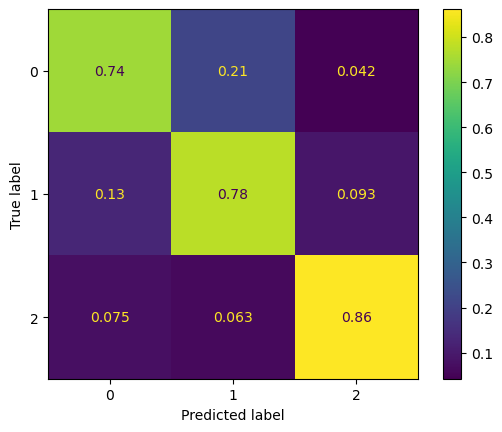

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.62386. Saving Model!
epoch 01, loss: 0.78122, acc: 0.59558, val_loss: 0.62386, val_accuracy: 0.77023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 02, loss: 0.78177, acc: 0.59954, val_loss: 0.63124, val_accuracy: 0.76758


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 03, loss: 0.77965, acc: 0.60039, val_loss: 0.63919, val_accuracy: 0.76415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 04, loss: 0.77612, acc: 0.61044, val_loss: 0.64704, val_accuracy: 0.76415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 05, loss: 0.77241, acc: 0.61009, val_loss: 0.65472, val_accuracy: 0.76494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 06, loss: 0.76951, acc: 0.60968, val_loss: 0.66218, val_accuracy: 0.75331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 07, loss: 0.76756, acc: 0.61873, val_loss: 0.66919, val_accuracy: 0.70386


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 08, loss: 0.76580, acc: 0.61729, val_loss: 0.67581, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 09, loss: 0.76405, acc: 0.61755, val_loss: 0.68183, val_accuracy: 0.68588


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 10, loss: 0.76253, acc: 0.61776, val_loss: 0.68726, val_accuracy: 0.68456


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 11, loss: 0.76104, acc: 0.62666, val_loss: 0.69222, val_accuracy: 0.68509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 12, loss: 0.75962, acc: 0.62648, val_loss: 0.69696, val_accuracy: 0.68482


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 13, loss: 0.75810, acc: 0.62531, val_loss: 0.70159, val_accuracy: 0.66261


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 14, loss: 0.75655, acc: 0.62316, val_loss: 0.70600, val_accuracy: 0.66261


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 15, loss: 0.75508, acc: 0.62366, val_loss: 0.71023, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 16, loss: 0.75362, acc: 0.62466, val_loss: 0.71432, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 17, loss: 0.75208, acc: 0.62475, val_loss: 0.71832, val_accuracy: 0.65812


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 18, loss: 0.75069, acc: 0.62493, val_loss: 0.72209, val_accuracy: 0.65785


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 19, loss: 0.74952, acc: 0.62499, val_loss: 0.72563, val_accuracy: 0.65732


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 20, loss: 0.74813, acc: 0.62651, val_loss: 0.72915, val_accuracy: 0.65732


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 21, loss: 0.74677, acc: 0.62125, val_loss: 0.73271, val_accuracy: 0.65759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 22, loss: 0.74557, acc: 0.62231, val_loss: 0.73620, val_accuracy: 0.65918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


epoch 23, loss: 0.74441, acc: 0.62581, val_loss: 0.73956, val_accuracy: 0.65944


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 24, loss: 0.74337, acc: 0.62901, val_loss: 0.74272, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 25, loss: 0.74208, acc: 0.63157, val_loss: 0.74577, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 26, loss: 0.74091, acc: 0.63239, val_loss: 0.74876, val_accuracy: 0.61687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 27, loss: 0.73969, acc: 0.63377, val_loss: 0.75187, val_accuracy: 0.61687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 28, loss: 0.73845, acc: 0.63621, val_loss: 0.75491, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 29, loss: 0.73739, acc: 0.64082, val_loss: 0.75793, val_accuracy: 0.61687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 30, loss: 0.73624, acc: 0.64106, val_loss: 0.76081, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 31, loss: 0.73503, acc: 0.64123, val_loss: 0.76370, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 32, loss: 0.73391, acc: 0.64150, val_loss: 0.76660, val_accuracy: 0.61687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 33, loss: 0.73287, acc: 0.64173, val_loss: 0.76956, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 34, loss: 0.73171, acc: 0.64182, val_loss: 0.77230, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 35, loss: 0.73067, acc: 0.64191, val_loss: 0.77508, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 36, loss: 0.72955, acc: 0.64073, val_loss: 0.77771, val_accuracy: 0.61713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 37, loss: 0.72834, acc: 0.64176, val_loss: 0.78045, val_accuracy: 0.61819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 38, loss: 0.72735, acc: 0.64203, val_loss: 0.78303, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 39, loss: 0.72636, acc: 0.64056, val_loss: 0.78548, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 40, loss: 0.72529, acc: 0.64109, val_loss: 0.78801, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.41it/s]


epoch 41, loss: 0.72416, acc: 0.64123, val_loss: 0.79084, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 42, loss: 0.72309, acc: 0.64159, val_loss: 0.79321, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 43, loss: 0.72204, acc: 0.64226, val_loss: 0.79576, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 44, loss: 0.72116, acc: 0.64250, val_loss: 0.79832, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 45, loss: 0.72004, acc: 0.64452, val_loss: 0.80112, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 46, loss: 0.71902, acc: 0.64144, val_loss: 0.80387, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 47, loss: 0.71832, acc: 0.64652, val_loss: 0.80617, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.15it/s]


epoch 48, loss: 0.71731, acc: 0.64752, val_loss: 0.80856, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 49, loss: 0.71612, acc: 0.64761, val_loss: 0.81104, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


epoch 50, loss: 0.71515, acc: 0.64825, val_loss: 0.81352, val_accuracy: 0.60841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 51, loss: 0.71418, acc: 0.65046, val_loss: 0.81581, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 52, loss: 0.71344, acc: 0.65078, val_loss: 0.81794, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 53, loss: 0.71254, acc: 0.65043, val_loss: 0.82010, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 54, loss: 0.71144, acc: 0.65393, val_loss: 0.82245, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 55, loss: 0.71035, acc: 0.65378, val_loss: 0.82470, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 56, loss: 0.70954, acc: 0.65266, val_loss: 0.82687, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 57, loss: 0.70863, acc: 0.65328, val_loss: 0.82911, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 58, loss: 0.70770, acc: 0.65504, val_loss: 0.83135, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.75it/s]


epoch 59, loss: 0.70688, acc: 0.65531, val_loss: 0.83339, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 60, loss: 0.70603, acc: 0.65516, val_loss: 0.83534, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 61, loss: 0.70515, acc: 0.65531, val_loss: 0.83746, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 62, loss: 0.70406, acc: 0.65554, val_loss: 0.83976, val_accuracy: 0.59122


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 63, loss: 0.70321, acc: 0.66054, val_loss: 0.84172, val_accuracy: 0.59149


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 64, loss: 0.70230, acc: 0.66045, val_loss: 0.84368, val_accuracy: 0.59201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 65, loss: 0.70150, acc: 0.66048, val_loss: 0.84579, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 66, loss: 0.70053, acc: 0.66165, val_loss: 0.84790, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 67, loss: 0.69963, acc: 0.66303, val_loss: 0.84989, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20it/s]


epoch 68, loss: 0.69882, acc: 0.66453, val_loss: 0.85171, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 69, loss: 0.69798, acc: 0.66465, val_loss: 0.85358, val_accuracy: 0.59175


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 70, loss: 0.69717, acc: 0.66506, val_loss: 0.85542, val_accuracy: 0.59228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 71, loss: 0.69621, acc: 0.66903, val_loss: 0.85731, val_accuracy: 0.59201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 72, loss: 0.69539, acc: 0.66906, val_loss: 0.85924, val_accuracy: 0.59228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 73, loss: 0.69467, acc: 0.66985, val_loss: 0.86090, val_accuracy: 0.59175


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 74, loss: 0.69383, acc: 0.66944, val_loss: 0.86268, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 75, loss: 0.69293, acc: 0.66964, val_loss: 0.86463, val_accuracy: 0.56372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 76, loss: 0.69211, acc: 0.66970, val_loss: 0.86641, val_accuracy: 0.56055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 77, loss: 0.69132, acc: 0.67464, val_loss: 0.86803, val_accuracy: 0.51401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 78, loss: 0.69063, acc: 0.67505, val_loss: 0.86983, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 79, loss: 0.68948, acc: 0.67646, val_loss: 0.87175, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 80, loss: 0.68878, acc: 0.67667, val_loss: 0.87347, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 81, loss: 0.68804, acc: 0.67778, val_loss: 0.87494, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 82, loss: 0.68724, acc: 0.67581, val_loss: 0.87674, val_accuracy: 0.51401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 83, loss: 0.68625, acc: 0.67796, val_loss: 0.87858, val_accuracy: 0.51428


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 84, loss: 0.68549, acc: 0.67834, val_loss: 0.88026, val_accuracy: 0.51375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 85, loss: 0.68495, acc: 0.67843, val_loss: 0.88212, val_accuracy: 0.51507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.01it/s]


epoch 86, loss: 0.68398, acc: 0.67769, val_loss: 0.88380, val_accuracy: 0.51534


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 87, loss: 0.68312, acc: 0.67781, val_loss: 0.88546, val_accuracy: 0.51560


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 88, loss: 0.68235, acc: 0.67746, val_loss: 0.88697, val_accuracy: 0.51851


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 89, loss: 0.68161, acc: 0.67861, val_loss: 0.88839, val_accuracy: 0.51851


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 90, loss: 0.68071, acc: 0.67913, val_loss: 0.89008, val_accuracy: 0.51851


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 91, loss: 0.68001, acc: 0.67931, val_loss: 0.89155, val_accuracy: 0.51824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 92, loss: 0.67922, acc: 0.67937, val_loss: 0.89292, val_accuracy: 0.51798


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 93, loss: 0.67837, acc: 0.67937, val_loss: 0.89470, val_accuracy: 0.51824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 94, loss: 0.67751, acc: 0.67928, val_loss: 0.89682, val_accuracy: 0.51798


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


epoch 95, loss: 0.67672, acc: 0.67928, val_loss: 0.89873, val_accuracy: 0.51824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 96, loss: 0.67587, acc: 0.67940, val_loss: 0.90051, val_accuracy: 0.51877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 97, loss: 0.67506, acc: 0.67943, val_loss: 0.90225, val_accuracy: 0.51877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 98, loss: 0.67434, acc: 0.67931, val_loss: 0.90342, val_accuracy: 0.51904


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 99, loss: 0.67354, acc: 0.67925, val_loss: 0.90484, val_accuracy: 0.51930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 100, loss: 0.67257, acc: 0.67937, val_loss: 0.90635, val_accuracy: 0.51930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 101, loss: 0.67186, acc: 0.67919, val_loss: 0.90760, val_accuracy: 0.51957


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 102, loss: 0.67100, acc: 0.67928, val_loss: 0.90899, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 103, loss: 0.67039, acc: 0.67925, val_loss: 0.91016, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 104, loss: 0.66971, acc: 0.67913, val_loss: 0.91104, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 105, loss: 0.66857, acc: 0.67940, val_loss: 0.91265, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 106, loss: 0.66795, acc: 0.67943, val_loss: 0.91437, val_accuracy: 0.52010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 107, loss: 0.66741, acc: 0.67946, val_loss: 0.91539, val_accuracy: 0.52010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 108, loss: 0.66639, acc: 0.67957, val_loss: 0.91669, val_accuracy: 0.52036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 109, loss: 0.66570, acc: 0.68310, val_loss: 0.91791, val_accuracy: 0.52036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 110, loss: 0.66511, acc: 0.68460, val_loss: 0.91908, val_accuracy: 0.52142


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 111, loss: 0.66411, acc: 0.68748, val_loss: 0.92040, val_accuracy: 0.52168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 112, loss: 0.66328, acc: 0.68768, val_loss: 0.92148, val_accuracy: 0.52195


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85it/s]


epoch 113, loss: 0.66278, acc: 0.68768, val_loss: 0.92260, val_accuracy: 0.52168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 114, loss: 0.66196, acc: 0.68771, val_loss: 0.92401, val_accuracy: 0.52010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 115, loss: 0.66106, acc: 0.69109, val_loss: 0.92528, val_accuracy: 0.51983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 116, loss: 0.66039, acc: 0.69109, val_loss: 0.92634, val_accuracy: 0.52010


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 117, loss: 0.65964, acc: 0.69150, val_loss: 0.92755, val_accuracy: 0.52036


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 118, loss: 0.65881, acc: 0.69112, val_loss: 0.92920, val_accuracy: 0.52062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 119, loss: 0.65814, acc: 0.69106, val_loss: 0.93051, val_accuracy: 0.52062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 120, loss: 0.65728, acc: 0.69147, val_loss: 0.93165, val_accuracy: 0.52062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 121, loss: 0.65644, acc: 0.69171, val_loss: 0.93263, val_accuracy: 0.52142


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.15it/s]


epoch 122, loss: 0.65589, acc: 0.69159, val_loss: 0.93380, val_accuracy: 0.52142


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 123, loss: 0.65530, acc: 0.69165, val_loss: 0.93499, val_accuracy: 0.52195


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 124, loss: 0.65433, acc: 0.69218, val_loss: 0.93601, val_accuracy: 0.52195


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.17it/s]


epoch 125, loss: 0.65351, acc: 0.69180, val_loss: 0.93719, val_accuracy: 0.52221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 126, loss: 0.65293, acc: 0.69141, val_loss: 0.93792, val_accuracy: 0.52221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 127, loss: 0.65209, acc: 0.69136, val_loss: 0.93869, val_accuracy: 0.52247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 128, loss: 0.65136, acc: 0.69153, val_loss: 0.93972, val_accuracy: 0.52274


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 129, loss: 0.65067, acc: 0.69053, val_loss: 0.94083, val_accuracy: 0.52274


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 130, loss: 0.65004, acc: 0.69071, val_loss: 0.94169, val_accuracy: 0.52353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07it/s]


epoch 131, loss: 0.64910, acc: 0.69042, val_loss: 0.94280, val_accuracy: 0.52353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 132, loss: 0.64849, acc: 0.69045, val_loss: 0.94364, val_accuracy: 0.52380


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 133, loss: 0.64773, acc: 0.68883, val_loss: 0.94455, val_accuracy: 0.52485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 134, loss: 0.64690, acc: 0.68886, val_loss: 0.94538, val_accuracy: 0.52485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 135, loss: 0.64637, acc: 0.68892, val_loss: 0.94615, val_accuracy: 0.52538


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 136, loss: 0.64550, acc: 0.68936, val_loss: 0.94716, val_accuracy: 0.52538


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 137, loss: 0.64477, acc: 0.68918, val_loss: 0.94763, val_accuracy: 0.52538


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 138, loss: 0.64406, acc: 0.68939, val_loss: 0.94861, val_accuracy: 0.52671


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 139, loss: 0.64323, acc: 0.69033, val_loss: 0.94958, val_accuracy: 0.52671


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 140, loss: 0.64260, acc: 0.69030, val_loss: 0.95050, val_accuracy: 0.52697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 141, loss: 0.64198, acc: 0.69036, val_loss: 0.95084, val_accuracy: 0.52829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 142, loss: 0.64109, acc: 0.69047, val_loss: 0.95158, val_accuracy: 0.52935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 143, loss: 0.64052, acc: 0.68998, val_loss: 0.95254, val_accuracy: 0.52856


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 144, loss: 0.63950, acc: 0.69003, val_loss: 0.95415, val_accuracy: 0.52961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 145, loss: 0.63902, acc: 0.69033, val_loss: 0.95478, val_accuracy: 0.52961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 146, loss: 0.63845, acc: 0.69039, val_loss: 0.95558, val_accuracy: 0.52935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


epoch 147, loss: 0.63731, acc: 0.69177, val_loss: 0.95662, val_accuracy: 0.52961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 148, loss: 0.63666, acc: 0.69174, val_loss: 0.95775, val_accuracy: 0.53014


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 149, loss: 0.63627, acc: 0.69189, val_loss: 0.95825, val_accuracy: 0.52961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 150, loss: 0.63538, acc: 0.69541, val_loss: 0.95927, val_accuracy: 0.53041


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 151, loss: 0.63475, acc: 0.69394, val_loss: 0.96021, val_accuracy: 0.53094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 152, loss: 0.63396, acc: 0.69456, val_loss: 0.96113, val_accuracy: 0.53094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 153, loss: 0.63320, acc: 0.69379, val_loss: 0.96187, val_accuracy: 0.53041


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 154, loss: 0.63252, acc: 0.69403, val_loss: 0.96300, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 155, loss: 0.63193, acc: 0.69418, val_loss: 0.96385, val_accuracy: 0.53094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 156, loss: 0.63081, acc: 0.70267, val_loss: 0.96492, val_accuracy: 0.53067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 157, loss: 0.63029, acc: 0.70240, val_loss: 0.96572, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 158, loss: 0.62990, acc: 0.70252, val_loss: 0.96635, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 159, loss: 0.62905, acc: 0.70258, val_loss: 0.96715, val_accuracy: 0.53120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 160, loss: 0.62805, acc: 0.70161, val_loss: 0.96799, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 161, loss: 0.62762, acc: 0.70199, val_loss: 0.96827, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 162, loss: 0.62689, acc: 0.70202, val_loss: 0.96872, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 163, loss: 0.62585, acc: 0.70314, val_loss: 0.96997, val_accuracy: 0.53279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 164, loss: 0.62535, acc: 0.70328, val_loss: 0.97080, val_accuracy: 0.53305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 165, loss: 0.62463, acc: 0.70375, val_loss: 0.97151, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 166, loss: 0.62385, acc: 0.70387, val_loss: 0.97269, val_accuracy: 0.53279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.96it/s]


epoch 167, loss: 0.62344, acc: 0.70384, val_loss: 0.97346, val_accuracy: 0.53305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 168, loss: 0.62242, acc: 0.70384, val_loss: 0.97433, val_accuracy: 0.53332


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 169, loss: 0.62185, acc: 0.70420, val_loss: 0.97536, val_accuracy: 0.53305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 170, loss: 0.62125, acc: 0.70431, val_loss: 0.97632, val_accuracy: 0.53279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 171, loss: 0.62044, acc: 0.70467, val_loss: 0.97695, val_accuracy: 0.53305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93it/s]


epoch 172, loss: 0.61973, acc: 0.70484, val_loss: 0.97723, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 173, loss: 0.61924, acc: 0.70502, val_loss: 0.97827, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 174, loss: 0.61838, acc: 0.70540, val_loss: 0.97939, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 175, loss: 0.61754, acc: 0.70593, val_loss: 0.98078, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94it/s]


epoch 176, loss: 0.61728, acc: 0.71181, val_loss: 0.98103, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 177, loss: 0.61633, acc: 0.71201, val_loss: 0.98231, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 178, loss: 0.61568, acc: 0.71251, val_loss: 0.98318, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 179, loss: 0.61510, acc: 0.71286, val_loss: 0.98460, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 180, loss: 0.61424, acc: 0.71868, val_loss: 0.98575, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 181, loss: 0.61352, acc: 0.72100, val_loss: 0.98639, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 182, loss: 0.61310, acc: 0.72141, val_loss: 0.98733, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 183, loss: 0.61217, acc: 0.72162, val_loss: 0.98878, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 184, loss: 0.61160, acc: 0.72200, val_loss: 0.99035, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 185, loss: 0.61101, acc: 0.72203, val_loss: 0.99106, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 186, loss: 0.61024, acc: 0.72218, val_loss: 0.99223, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 187, loss: 0.60971, acc: 0.72573, val_loss: 0.99300, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 188, loss: 0.60865, acc: 0.72747, val_loss: 0.99490, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 189, loss: 0.60848, acc: 0.72811, val_loss: 0.99516, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 190, loss: 0.60747, acc: 0.72826, val_loss: 0.99634, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 191, loss: 0.60661, acc: 0.72882, val_loss: 0.99838, val_accuracy: 0.53146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 192, loss: 0.60637, acc: 0.72923, val_loss: 0.99921, val_accuracy: 0.53173


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


epoch 193, loss: 0.60559, acc: 0.73076, val_loss: 1.00032, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 194, loss: 0.60487, acc: 0.73087, val_loss: 1.00070, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 195, loss: 0.60410, acc: 0.73087, val_loss: 1.00186, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 196, loss: 0.60380, acc: 0.73343, val_loss: 1.00311, val_accuracy: 0.53199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 197, loss: 0.60286, acc: 0.73349, val_loss: 1.00400, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 198, loss: 0.60209, acc: 0.73422, val_loss: 1.00501, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 199, loss: 0.60156, acc: 0.73334, val_loss: 1.00615, val_accuracy: 0.53226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 200, loss: 0.60088, acc: 0.73440, val_loss: 1.00769, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


epoch 201, loss: 0.60035, acc: 0.73449, val_loss: 1.00913, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 202, loss: 0.59975, acc: 0.73340, val_loss: 1.00978, val_accuracy: 0.53252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 203, loss: 0.59873, acc: 0.73343, val_loss: 1.01032, val_accuracy: 0.53384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 204, loss: 0.59836, acc: 0.73361, val_loss: 1.01084, val_accuracy: 0.53358


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 205, loss: 0.59773, acc: 0.73343, val_loss: 1.01173, val_accuracy: 0.53384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 206, loss: 0.59721, acc: 0.73372, val_loss: 1.01284, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 207, loss: 0.59616, acc: 0.73384, val_loss: 1.01428, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 208, loss: 0.59574, acc: 0.73387, val_loss: 1.01491, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 209, loss: 0.59512, acc: 0.73381, val_loss: 1.01617, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 210, loss: 0.59459, acc: 0.73393, val_loss: 1.01668, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 211, loss: 0.59355, acc: 0.73416, val_loss: 1.01775, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 212, loss: 0.59328, acc: 0.73411, val_loss: 1.01822, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 213, loss: 0.59241, acc: 0.73422, val_loss: 1.01883, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 214, loss: 0.59204, acc: 0.73413, val_loss: 1.02007, val_accuracy: 0.53517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 215, loss: 0.59153, acc: 0.73916, val_loss: 1.02168, val_accuracy: 0.53517


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 216, loss: 0.59044, acc: 0.73487, val_loss: 1.02263, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 217, loss: 0.59025, acc: 0.73522, val_loss: 1.02297, val_accuracy: 0.53570


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 218, loss: 0.58936, acc: 0.73528, val_loss: 1.02402, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 219, loss: 0.58852, acc: 0.73989, val_loss: 1.02499, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 220, loss: 0.58851, acc: 0.73980, val_loss: 1.02539, val_accuracy: 0.53570


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 221, loss: 0.58733, acc: 0.73998, val_loss: 1.02657, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 222, loss: 0.58711, acc: 0.73496, val_loss: 1.02731, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 223, loss: 0.58638, acc: 0.73972, val_loss: 1.02896, val_accuracy: 0.53543


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 224, loss: 0.58569, acc: 0.74016, val_loss: 1.03001, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 225, loss: 0.58518, acc: 0.74007, val_loss: 1.03021, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 226, loss: 0.58445, acc: 0.74048, val_loss: 1.03132, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 227, loss: 0.58388, acc: 0.73531, val_loss: 1.03271, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.67it/s]


epoch 228, loss: 0.58331, acc: 0.74069, val_loss: 1.03346, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 229, loss: 0.58278, acc: 0.74066, val_loss: 1.03438, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 230, loss: 0.58185, acc: 0.74060, val_loss: 1.03644, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 231, loss: 0.58154, acc: 0.74101, val_loss: 1.03716, val_accuracy: 0.53675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 232, loss: 0.58129, acc: 0.73669, val_loss: 1.03708, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.79it/s]


epoch 233, loss: 0.58029, acc: 0.74116, val_loss: 1.03885, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 234, loss: 0.57965, acc: 0.74151, val_loss: 1.04007, val_accuracy: 0.53675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 235, loss: 0.57922, acc: 0.74180, val_loss: 1.04086, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.46it/s]


epoch 236, loss: 0.57860, acc: 0.74186, val_loss: 1.04239, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


epoch 237, loss: 0.57786, acc: 0.74192, val_loss: 1.04350, val_accuracy: 0.54019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 238, loss: 0.57724, acc: 0.74227, val_loss: 1.04403, val_accuracy: 0.54045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 239, loss: 0.57679, acc: 0.74295, val_loss: 1.04496, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39it/s]


epoch 240, loss: 0.57602, acc: 0.74283, val_loss: 1.04657, val_accuracy: 0.53966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 241, loss: 0.57558, acc: 0.74298, val_loss: 1.04748, val_accuracy: 0.54019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.37it/s]


epoch 242, loss: 0.57468, acc: 0.74371, val_loss: 1.04882, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 243, loss: 0.57409, acc: 0.74389, val_loss: 1.05004, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 244, loss: 0.57378, acc: 0.74606, val_loss: 1.05081, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.76it/s]


epoch 245, loss: 0.57292, acc: 0.75103, val_loss: 1.05183, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 246, loss: 0.57249, acc: 0.75179, val_loss: 1.05225, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 247, loss: 0.57205, acc: 0.75203, val_loss: 1.05329, val_accuracy: 0.56425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


epoch 248, loss: 0.57127, acc: 0.75197, val_loss: 1.05541, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


epoch 249, loss: 0.57068, acc: 0.75209, val_loss: 1.05627, val_accuracy: 0.56637


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 250, loss: 0.57017, acc: 0.75259, val_loss: 1.05657, val_accuracy: 0.56663


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 251, loss: 0.56948, acc: 0.75261, val_loss: 1.05841, val_accuracy: 0.56637


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 252, loss: 0.56926, acc: 0.75256, val_loss: 1.05883, val_accuracy: 0.56716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 253, loss: 0.56815, acc: 0.75285, val_loss: 1.05990, val_accuracy: 0.56637


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 254, loss: 0.56779, acc: 0.75323, val_loss: 1.06087, val_accuracy: 0.56637


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 255, loss: 0.56768, acc: 0.75438, val_loss: 1.06139, val_accuracy: 0.56690


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 256, loss: 0.56648, acc: 0.75452, val_loss: 1.06373, val_accuracy: 0.56663


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 257, loss: 0.56604, acc: 0.75470, val_loss: 1.06401, val_accuracy: 0.56716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.86it/s]


epoch 258, loss: 0.56574, acc: 0.75526, val_loss: 1.06348, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


epoch 259, loss: 0.56478, acc: 0.75564, val_loss: 1.06684, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 260, loss: 0.56455, acc: 0.75520, val_loss: 1.06825, val_accuracy: 0.56769


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 261, loss: 0.56379, acc: 0.75538, val_loss: 1.06815, val_accuracy: 0.56848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95it/s]


epoch 262, loss: 0.56350, acc: 0.75579, val_loss: 1.06922, val_accuracy: 0.56848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 263, loss: 0.56270, acc: 0.75693, val_loss: 1.07096, val_accuracy: 0.56795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.06it/s]


epoch 264, loss: 0.56226, acc: 0.75726, val_loss: 1.07117, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 265, loss: 0.56173, acc: 0.75834, val_loss: 1.07218, val_accuracy: 0.56954


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.79it/s]


epoch 266, loss: 0.56124, acc: 0.75867, val_loss: 1.07279, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 267, loss: 0.56038, acc: 0.75911, val_loss: 1.07378, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 268, loss: 0.56015, acc: 0.75831, val_loss: 1.07413, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 269, loss: 0.55973, acc: 0.75858, val_loss: 1.07458, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 270, loss: 0.55851, acc: 0.75911, val_loss: 1.07643, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 271, loss: 0.55879, acc: 0.75920, val_loss: 1.07696, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 272, loss: 0.55768, acc: 0.75920, val_loss: 1.07765, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 273, loss: 0.55701, acc: 0.75896, val_loss: 1.08018, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95it/s]


epoch 274, loss: 0.55725, acc: 0.75881, val_loss: 1.07984, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 275, loss: 0.55596, acc: 0.75917, val_loss: 1.08045, val_accuracy: 0.57113


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 276, loss: 0.55525, acc: 0.75499, val_loss: 1.08266, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 277, loss: 0.55535, acc: 0.75491, val_loss: 1.08319, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 278, loss: 0.55461, acc: 0.75508, val_loss: 1.08271, val_accuracy: 0.57060


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 279, loss: 0.55399, acc: 0.75511, val_loss: 1.08271, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 280, loss: 0.55369, acc: 0.75593, val_loss: 1.08329, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 281, loss: 0.55273, acc: 0.75640, val_loss: 1.08472, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 282, loss: 0.55249, acc: 0.75555, val_loss: 1.08598, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 283, loss: 0.55177, acc: 0.75585, val_loss: 1.08774, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 284, loss: 0.55147, acc: 0.75593, val_loss: 1.08767, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 285, loss: 0.55081, acc: 0.75596, val_loss: 1.08807, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 286, loss: 0.55023, acc: 0.75596, val_loss: 1.08841, val_accuracy: 0.57086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 287, loss: 0.54987, acc: 0.75679, val_loss: 1.08888, val_accuracy: 0.57139


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 288, loss: 0.54912, acc: 0.75708, val_loss: 1.08977, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 289, loss: 0.54876, acc: 0.75729, val_loss: 1.09043, val_accuracy: 0.57245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 290, loss: 0.54829, acc: 0.75740, val_loss: 1.09115, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 291, loss: 0.54759, acc: 0.75817, val_loss: 1.09244, val_accuracy: 0.57298


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 292, loss: 0.54708, acc: 0.75831, val_loss: 1.09403, val_accuracy: 0.57245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 293, loss: 0.54670, acc: 0.75931, val_loss: 1.09436, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 294, loss: 0.54588, acc: 0.75958, val_loss: 1.09538, val_accuracy: 0.57298


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 295, loss: 0.54562, acc: 0.76114, val_loss: 1.09618, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 296, loss: 0.54503, acc: 0.76119, val_loss: 1.09743, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 297, loss: 0.54468, acc: 0.76131, val_loss: 1.09701, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


epoch 298, loss: 0.54397, acc: 0.76169, val_loss: 1.09845, val_accuracy: 0.57245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 299, loss: 0.54363, acc: 0.76143, val_loss: 1.09870, val_accuracy: 0.57245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 300, loss: 0.54310, acc: 0.76231, val_loss: 1.09918, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 301, loss: 0.54252, acc: 0.76231, val_loss: 1.10147, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 302, loss: 0.54190, acc: 0.76249, val_loss: 1.10283, val_accuracy: 0.57298


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 303, loss: 0.54185, acc: 0.76284, val_loss: 1.10179, val_accuracy: 0.57298


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 304, loss: 0.54074, acc: 0.76240, val_loss: 1.10447, val_accuracy: 0.57298


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 305, loss: 0.54048, acc: 0.76234, val_loss: 1.10733, val_accuracy: 0.57324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 306, loss: 0.54016, acc: 0.76237, val_loss: 1.10819, val_accuracy: 0.57324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14it/s]


epoch 307, loss: 0.53933, acc: 0.76249, val_loss: 1.10927, val_accuracy: 0.57324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 308, loss: 0.53935, acc: 0.76281, val_loss: 1.11083, val_accuracy: 0.57324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 309, loss: 0.53844, acc: 0.76287, val_loss: 1.11447, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 310, loss: 0.53796, acc: 0.76281, val_loss: 1.11677, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 311, loss: 0.53734, acc: 0.76296, val_loss: 1.11902, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.31it/s]


epoch 312, loss: 0.53715, acc: 0.76278, val_loss: 1.11965, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 313, loss: 0.53646, acc: 0.76296, val_loss: 1.12094, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 314, loss: 0.53610, acc: 0.76287, val_loss: 1.12341, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 315, loss: 0.53543, acc: 0.76343, val_loss: 1.12654, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 316, loss: 0.53498, acc: 0.76322, val_loss: 1.12675, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 317, loss: 0.53460, acc: 0.76310, val_loss: 1.12653, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 318, loss: 0.53419, acc: 0.76340, val_loss: 1.12774, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 319, loss: 0.53351, acc: 0.76354, val_loss: 1.12885, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 320, loss: 0.53316, acc: 0.76369, val_loss: 1.12928, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 321, loss: 0.53261, acc: 0.76381, val_loss: 1.13027, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 322, loss: 0.53202, acc: 0.76381, val_loss: 1.13190, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 323, loss: 0.53170, acc: 0.76360, val_loss: 1.13303, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 324, loss: 0.53094, acc: 0.76384, val_loss: 1.13534, val_accuracy: 0.57456


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.08it/s]


epoch 325, loss: 0.53094, acc: 0.76334, val_loss: 1.13488, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 326, loss: 0.53006, acc: 0.76363, val_loss: 1.13546, val_accuracy: 0.57483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 327, loss: 0.52951, acc: 0.76390, val_loss: 1.13577, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 328, loss: 0.52904, acc: 0.76357, val_loss: 1.13791, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 329, loss: 0.52909, acc: 0.76387, val_loss: 1.13953, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 330, loss: 0.52801, acc: 0.76375, val_loss: 1.13928, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 331, loss: 0.52794, acc: 0.76401, val_loss: 1.13970, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 332, loss: 0.52687, acc: 0.76419, val_loss: 1.14238, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95it/s]


epoch 333, loss: 0.52683, acc: 0.76440, val_loss: 1.14349, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 334, loss: 0.52609, acc: 0.76384, val_loss: 1.14434, val_accuracy: 0.57562


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 335, loss: 0.52576, acc: 0.76381, val_loss: 1.14562, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 336, loss: 0.52545, acc: 0.76401, val_loss: 1.14515, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27it/s]


epoch 337, loss: 0.52455, acc: 0.76425, val_loss: 1.14799, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 338, loss: 0.52462, acc: 0.76460, val_loss: 1.14836, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 339, loss: 0.52343, acc: 0.76466, val_loss: 1.14928, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 340, loss: 0.52342, acc: 0.76498, val_loss: 1.14929, val_accuracy: 0.60100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


epoch 341, loss: 0.52291, acc: 0.76495, val_loss: 1.15125, val_accuracy: 0.57879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 342, loss: 0.52227, acc: 0.76522, val_loss: 1.15235, val_accuracy: 0.57879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 343, loss: 0.52205, acc: 0.76490, val_loss: 1.15279, val_accuracy: 0.60127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 344, loss: 0.52146, acc: 0.76531, val_loss: 1.15483, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 345, loss: 0.52080, acc: 0.76542, val_loss: 1.15636, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 346, loss: 0.52039, acc: 0.76548, val_loss: 1.15831, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 347, loss: 0.51984, acc: 0.76587, val_loss: 1.15844, val_accuracy: 0.60153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 348, loss: 0.51940, acc: 0.76281, val_loss: 1.15770, val_accuracy: 0.60206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 349, loss: 0.51908, acc: 0.76260, val_loss: 1.15850, val_accuracy: 0.60206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


epoch 350, loss: 0.51840, acc: 0.76263, val_loss: 1.15986, val_accuracy: 0.60206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 351, loss: 0.51777, acc: 0.76275, val_loss: 1.16029, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 352, loss: 0.51717, acc: 0.76331, val_loss: 1.16233, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 353, loss: 0.51724, acc: 0.76316, val_loss: 1.16286, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 354, loss: 0.51629, acc: 0.76337, val_loss: 1.16328, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 355, loss: 0.51615, acc: 0.76343, val_loss: 1.16337, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 356, loss: 0.51541, acc: 0.76352, val_loss: 1.16731, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 357, loss: 0.51528, acc: 0.76381, val_loss: 1.16667, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 358, loss: 0.51440, acc: 0.76363, val_loss: 1.16742, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 359, loss: 0.51398, acc: 0.76416, val_loss: 1.16835, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 360, loss: 0.51384, acc: 0.76419, val_loss: 1.16828, val_accuracy: 0.60576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 361, loss: 0.51269, acc: 0.76478, val_loss: 1.17151, val_accuracy: 0.60656


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 362, loss: 0.51285, acc: 0.76469, val_loss: 1.17258, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 363, loss: 0.51220, acc: 0.76498, val_loss: 1.17159, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 364, loss: 0.51149, acc: 0.76504, val_loss: 1.17103, val_accuracy: 0.60788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 365, loss: 0.51098, acc: 0.76519, val_loss: 1.17193, val_accuracy: 0.60788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 366, loss: 0.51086, acc: 0.76516, val_loss: 1.17391, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 367, loss: 0.50997, acc: 0.76495, val_loss: 1.17622, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.50it/s]


epoch 368, loss: 0.50971, acc: 0.76531, val_loss: 1.17505, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 369, loss: 0.50928, acc: 0.76669, val_loss: 1.17515, val_accuracy: 0.60867


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 370, loss: 0.50849, acc: 0.76701, val_loss: 1.17794, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 371, loss: 0.50846, acc: 0.76707, val_loss: 1.17895, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 372, loss: 0.50739, acc: 0.76872, val_loss: 1.18010, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 373, loss: 0.50758, acc: 0.76913, val_loss: 1.17938, val_accuracy: 0.61026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 374, loss: 0.50659, acc: 0.76889, val_loss: 1.18350, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 375, loss: 0.50630, acc: 0.77004, val_loss: 1.18331, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.89it/s]


epoch 376, loss: 0.50582, acc: 0.77101, val_loss: 1.18457, val_accuracy: 0.61052


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 377, loss: 0.50551, acc: 0.77098, val_loss: 1.18432, val_accuracy: 0.61026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 378, loss: 0.50474, acc: 0.77145, val_loss: 1.18660, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 379, loss: 0.50443, acc: 0.77168, val_loss: 1.18820, val_accuracy: 0.61132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.35it/s]


epoch 380, loss: 0.50416, acc: 0.77168, val_loss: 1.18893, val_accuracy: 0.61132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


epoch 381, loss: 0.50323, acc: 0.77289, val_loss: 1.19088, val_accuracy: 0.61370


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 382, loss: 0.50281, acc: 0.77215, val_loss: 1.19170, val_accuracy: 0.61343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 383, loss: 0.50283, acc: 0.77327, val_loss: 1.19097, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 384, loss: 0.50151, acc: 0.77635, val_loss: 1.19207, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 385, loss: 0.50165, acc: 0.77556, val_loss: 1.19181, val_accuracy: 0.61343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 386, loss: 0.50106, acc: 0.77383, val_loss: 1.19307, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 387, loss: 0.50038, acc: 0.77400, val_loss: 1.19494, val_accuracy: 0.61475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 388, loss: 0.50000, acc: 0.77403, val_loss: 1.19621, val_accuracy: 0.61766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 389, loss: 0.49966, acc: 0.77418, val_loss: 1.19413, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 390, loss: 0.49900, acc: 0.77395, val_loss: 1.19599, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 391, loss: 0.49808, acc: 0.77697, val_loss: 1.19810, val_accuracy: 0.61502


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.54it/s]


epoch 392, loss: 0.49853, acc: 0.77597, val_loss: 1.19659, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.78it/s]


epoch 393, loss: 0.49702, acc: 0.77627, val_loss: 1.19943, val_accuracy: 0.61898


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


epoch 394, loss: 0.49707, acc: 0.77641, val_loss: 1.20018, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 395, loss: 0.49694, acc: 0.77638, val_loss: 1.20007, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 396, loss: 0.49551, acc: 0.77944, val_loss: 1.20371, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


epoch 397, loss: 0.49591, acc: 0.77688, val_loss: 1.20262, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]


epoch 398, loss: 0.49527, acc: 0.77688, val_loss: 1.20405, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 399, loss: 0.49441, acc: 0.77715, val_loss: 1.20783, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 400, loss: 0.49456, acc: 0.77700, val_loss: 1.20642, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 401, loss: 0.49310, acc: 0.77826, val_loss: 1.20911, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 402, loss: 0.49336, acc: 0.77897, val_loss: 1.20732, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 403, loss: 0.49296, acc: 0.77715, val_loss: 1.20867, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.90it/s]


epoch 404, loss: 0.49196, acc: 0.78009, val_loss: 1.21209, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 405, loss: 0.49202, acc: 0.78032, val_loss: 1.21108, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 406, loss: 0.49139, acc: 0.78038, val_loss: 1.21199, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 407, loss: 0.49062, acc: 0.78047, val_loss: 1.21325, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 408, loss: 0.49029, acc: 0.77865, val_loss: 1.21295, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 409, loss: 0.48960, acc: 0.78185, val_loss: 1.21515, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 410, loss: 0.48957, acc: 0.78276, val_loss: 1.21592, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.40it/s]


epoch 411, loss: 0.48879, acc: 0.78170, val_loss: 1.21780, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 412, loss: 0.48840, acc: 0.78305, val_loss: 1.21786, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 413, loss: 0.48819, acc: 0.78141, val_loss: 1.21763, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 414, loss: 0.48695, acc: 0.78202, val_loss: 1.22093, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 415, loss: 0.48735, acc: 0.77900, val_loss: 1.22167, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 416, loss: 0.48625, acc: 0.78064, val_loss: 1.22140, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 417, loss: 0.48598, acc: 0.77859, val_loss: 1.22352, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 418, loss: 0.48591, acc: 0.77826, val_loss: 1.22637, val_accuracy: 0.62692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.75it/s]


epoch 419, loss: 0.48495, acc: 0.77821, val_loss: 1.22644, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 420, loss: 0.48443, acc: 0.78100, val_loss: 1.22660, val_accuracy: 0.62718


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 421, loss: 0.48440, acc: 0.78094, val_loss: 1.22691, val_accuracy: 0.62692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 422, loss: 0.48367, acc: 0.77950, val_loss: 1.22759, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


epoch 423, loss: 0.48295, acc: 0.78147, val_loss: 1.22897, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 424, loss: 0.48337, acc: 0.78006, val_loss: 1.23073, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 425, loss: 0.48194, acc: 0.78082, val_loss: 1.23295, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 426, loss: 0.48227, acc: 0.78117, val_loss: 1.23085, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.45it/s]


epoch 427, loss: 0.48100, acc: 0.78044, val_loss: 1.23416, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 428, loss: 0.48099, acc: 0.78041, val_loss: 1.23634, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 429, loss: 0.48068, acc: 0.78023, val_loss: 1.23708, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 430, loss: 0.47977, acc: 0.78029, val_loss: 1.23813, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 431, loss: 0.47957, acc: 0.78061, val_loss: 1.23972, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 432, loss: 0.47912, acc: 0.78009, val_loss: 1.24188, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 433, loss: 0.47862, acc: 0.77962, val_loss: 1.24101, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 434, loss: 0.47798, acc: 0.77988, val_loss: 1.24260, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 435, loss: 0.47783, acc: 0.78023, val_loss: 1.24475, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 436, loss: 0.47731, acc: 0.78000, val_loss: 1.24566, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 437, loss: 0.47668, acc: 0.77994, val_loss: 1.24762, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 438, loss: 0.47628, acc: 0.78017, val_loss: 1.24851, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 439, loss: 0.47603, acc: 0.78176, val_loss: 1.24883, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 440, loss: 0.47521, acc: 0.78185, val_loss: 1.25020, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 441, loss: 0.47531, acc: 0.78191, val_loss: 1.24793, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 442, loss: 0.47431, acc: 0.78720, val_loss: 1.24922, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 443, loss: 0.47420, acc: 0.78681, val_loss: 1.25146, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 444, loss: 0.47387, acc: 0.78734, val_loss: 1.25127, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 445, loss: 0.47296, acc: 0.78731, val_loss: 1.25241, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 446, loss: 0.47296, acc: 0.78728, val_loss: 1.25441, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 447, loss: 0.47195, acc: 0.78770, val_loss: 1.25785, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 448, loss: 0.47219, acc: 0.78723, val_loss: 1.25816, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 449, loss: 0.47133, acc: 0.78840, val_loss: 1.25959, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 450, loss: 0.47111, acc: 0.78961, val_loss: 1.25805, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 451, loss: 0.47071, acc: 0.78834, val_loss: 1.25932, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 452, loss: 0.47009, acc: 0.78846, val_loss: 1.25924, val_accuracy: 0.64305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 453, loss: 0.46976, acc: 0.78899, val_loss: 1.25605, val_accuracy: 0.64305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


epoch 454, loss: 0.46902, acc: 0.78846, val_loss: 1.25803, val_accuracy: 0.64278


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 455, loss: 0.46881, acc: 0.78928, val_loss: 1.25941, val_accuracy: 0.64305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 456, loss: 0.46812, acc: 0.78934, val_loss: 1.26020, val_accuracy: 0.64278


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 457, loss: 0.46763, acc: 0.79060, val_loss: 1.26310, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 458, loss: 0.46723, acc: 0.78981, val_loss: 1.26080, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 459, loss: 0.46687, acc: 0.78899, val_loss: 1.26148, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 460, loss: 0.46586, acc: 0.78981, val_loss: 1.26391, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 461, loss: 0.46638, acc: 0.78981, val_loss: 1.26366, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 462, loss: 0.46489, acc: 0.79193, val_loss: 1.26805, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 463, loss: 0.46553, acc: 0.79201, val_loss: 1.26624, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 464, loss: 0.46418, acc: 0.79125, val_loss: 1.27166, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 465, loss: 0.46389, acc: 0.79166, val_loss: 1.27198, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 466, loss: 0.46384, acc: 0.79137, val_loss: 1.27307, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 467, loss: 0.46268, acc: 0.79172, val_loss: 1.27721, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]


epoch 468, loss: 0.46284, acc: 0.79190, val_loss: 1.27720, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 469, loss: 0.46232, acc: 0.78875, val_loss: 1.27740, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 470, loss: 0.46148, acc: 0.79140, val_loss: 1.27884, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 471, loss: 0.46124, acc: 0.79116, val_loss: 1.28094, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 472, loss: 0.46085, acc: 0.79172, val_loss: 1.28305, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 473, loss: 0.46036, acc: 0.78943, val_loss: 1.28185, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 474, loss: 0.45971, acc: 0.78940, val_loss: 1.28585, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 475, loss: 0.45919, acc: 0.79237, val_loss: 1.28848, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 476, loss: 0.45919, acc: 0.78990, val_loss: 1.28900, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 477, loss: 0.45806, acc: 0.78975, val_loss: 1.29342, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 478, loss: 0.45821, acc: 0.78963, val_loss: 1.29244, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 479, loss: 0.45728, acc: 0.79110, val_loss: 1.29382, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 480, loss: 0.45728, acc: 0.79196, val_loss: 1.29564, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.03it/s]


epoch 481, loss: 0.45640, acc: 0.79225, val_loss: 1.29903, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 482, loss: 0.45622, acc: 0.79248, val_loss: 1.30095, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 483, loss: 0.45573, acc: 0.79063, val_loss: 1.30259, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 484, loss: 0.45523, acc: 0.78996, val_loss: 1.30353, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 485, loss: 0.45453, acc: 0.79040, val_loss: 1.30499, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 486, loss: 0.45448, acc: 0.79060, val_loss: 1.30586, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 487, loss: 0.45380, acc: 0.79055, val_loss: 1.30811, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 488, loss: 0.45374, acc: 0.79040, val_loss: 1.31139, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 489, loss: 0.45285, acc: 0.79081, val_loss: 1.31243, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 490, loss: 0.45280, acc: 0.79075, val_loss: 1.31365, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 491, loss: 0.45211, acc: 0.79107, val_loss: 1.31620, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 492, loss: 0.45184, acc: 0.79087, val_loss: 1.31909, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.24it/s]


epoch 493, loss: 0.45125, acc: 0.79128, val_loss: 1.31807, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 494, loss: 0.45107, acc: 0.79116, val_loss: 1.31943, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 495, loss: 0.45032, acc: 0.79131, val_loss: 1.32305, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 496, loss: 0.44998, acc: 0.79149, val_loss: 1.32556, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.78it/s]


epoch 497, loss: 0.44973, acc: 0.79154, val_loss: 1.32772, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 498, loss: 0.44916, acc: 0.79160, val_loss: 1.32998, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 499, loss: 0.44908, acc: 0.79190, val_loss: 1.33112, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 500, loss: 0.44831, acc: 0.79181, val_loss: 1.33256, val_accuracy: 0.64543
2번째 교차검증
evaluation loss: 0.62386, evaluation accuracy: 0.77023
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 0.9891613	total: 8.74ms	remaining: 8.73s
1:	learn: 0.9020697	total: 18.3ms	remaining: 9.13s
2:	learn: 0.8307642	total: 26ms	remaining: 8.65s
3:	learn: 0.7712192	total: 35.3ms	remaining: 8.8s
4:	learn: 0.7203715	total: 43.2ms	remaining: 8.59s
5:	learn: 0.6769073	total: 52.4ms	remaining: 8.68s
6:	learn: 0.6394232	total: 60.6ms	remaining: 8.6s
7:	learn: 0.6067468	total: 69.2ms	remaining: 8.57s
8:	learn: 0.5783724	total: 78ms	remaining: 8.59s
9:	learn: 0.5535401	total: 85.3ms	remaining: 8.44s
10:	learn: 0.5312175	total: 94.9ms	remaining: 8.53s
11:	learn: 0.5116637	total: 108ms	remaining: 8.92s
12:	learn: 0.4937959	total: 119ms	remaining: 9.03s
13:	learn: 0.4778215	total: 131ms	remaining: 9.21s
14:	learn: 0.4639334	total: 141ms	remaining: 9.29s
15:	learn: 0.4514485	total: 151ms	remaining: 

163:	learn: 0.3093231	total: 1.26s	remaining: 6.41s
164:	learn: 0.3092892	total: 1.26s	remaining: 6.4s
165:	learn: 0.3092497	total: 1.27s	remaining: 6.39s
166:	learn: 0.3092103	total: 1.28s	remaining: 6.38s
167:	learn: 0.3091746	total: 1.29s	remaining: 6.37s
168:	learn: 0.3091396	total: 1.29s	remaining: 6.36s
169:	learn: 0.3090891	total: 1.3s	remaining: 6.35s
170:	learn: 0.3090443	total: 1.31s	remaining: 6.34s
171:	learn: 0.3090124	total: 1.32s	remaining: 6.34s
172:	learn: 0.3089769	total: 1.32s	remaining: 6.33s
173:	learn: 0.3089436	total: 1.33s	remaining: 6.33s
174:	learn: 0.3089121	total: 1.34s	remaining: 6.32s
175:	learn: 0.3088824	total: 1.35s	remaining: 6.31s
176:	learn: 0.3088391	total: 1.35s	remaining: 6.29s
177:	learn: 0.3088075	total: 1.36s	remaining: 6.29s
178:	learn: 0.3087798	total: 1.37s	remaining: 6.28s
179:	learn: 0.3087524	total: 1.38s	remaining: 6.28s
180:	learn: 0.3087206	total: 1.39s	remaining: 6.27s
181:	learn: 0.3086788	total: 1.39s	remaining: 6.27s
182:	learn: 0.

327:	learn: 0.3063128	total: 2.49s	remaining: 5.11s
328:	learn: 0.3063031	total: 2.5s	remaining: 5.1s
329:	learn: 0.3062950	total: 2.51s	remaining: 5.09s
330:	learn: 0.3062885	total: 2.51s	remaining: 5.08s
331:	learn: 0.3062791	total: 2.52s	remaining: 5.07s
332:	learn: 0.3062703	total: 2.53s	remaining: 5.07s
333:	learn: 0.3062630	total: 2.54s	remaining: 5.07s
334:	learn: 0.3062560	total: 2.55s	remaining: 5.06s
335:	learn: 0.3062489	total: 2.55s	remaining: 5.05s
336:	learn: 0.3062428	total: 2.56s	remaining: 5.04s
337:	learn: 0.3062335	total: 2.57s	remaining: 5.03s
338:	learn: 0.3062223	total: 2.58s	remaining: 5.02s
339:	learn: 0.3062141	total: 2.58s	remaining: 5.01s
340:	learn: 0.3062079	total: 2.59s	remaining: 5s
341:	learn: 0.3062012	total: 2.6s	remaining: 5s
342:	learn: 0.3061945	total: 2.6s	remaining: 4.99s
343:	learn: 0.3061885	total: 2.61s	remaining: 4.98s
344:	learn: 0.3061824	total: 2.62s	remaining: 4.97s
345:	learn: 0.3061774	total: 2.63s	remaining: 4.96s
346:	learn: 0.3061709	

486:	learn: 0.3054080	total: 3.74s	remaining: 3.94s
487:	learn: 0.3054047	total: 3.75s	remaining: 3.93s
488:	learn: 0.3054015	total: 3.76s	remaining: 3.93s
489:	learn: 0.3053987	total: 3.77s	remaining: 3.92s
490:	learn: 0.3053951	total: 3.77s	remaining: 3.91s
491:	learn: 0.3053903	total: 3.78s	remaining: 3.9s
492:	learn: 0.3053871	total: 3.79s	remaining: 3.9s
493:	learn: 0.3053824	total: 3.8s	remaining: 3.89s
494:	learn: 0.3053797	total: 3.81s	remaining: 3.88s
495:	learn: 0.3053767	total: 3.81s	remaining: 3.88s
496:	learn: 0.3053732	total: 3.82s	remaining: 3.87s
497:	learn: 0.3053688	total: 3.83s	remaining: 3.87s
498:	learn: 0.3053658	total: 3.84s	remaining: 3.86s
499:	learn: 0.3053627	total: 3.85s	remaining: 3.85s
500:	learn: 0.3053590	total: 3.86s	remaining: 3.85s
501:	learn: 0.3053550	total: 3.87s	remaining: 3.84s
502:	learn: 0.3053489	total: 3.88s	remaining: 3.83s
503:	learn: 0.3053461	total: 3.89s	remaining: 3.83s
504:	learn: 0.3053426	total: 3.9s	remaining: 3.82s
505:	learn: 0.30

661:	learn: 0.3049522	total: 5.39s	remaining: 2.75s
662:	learn: 0.3049501	total: 5.4s	remaining: 2.75s
663:	learn: 0.3049475	total: 5.42s	remaining: 2.74s
664:	learn: 0.3049456	total: 5.43s	remaining: 2.73s
665:	learn: 0.3049442	total: 5.43s	remaining: 2.73s
666:	learn: 0.3049429	total: 5.45s	remaining: 2.72s
667:	learn: 0.3049416	total: 5.45s	remaining: 2.71s
668:	learn: 0.3049397	total: 5.46s	remaining: 2.7s
669:	learn: 0.3049380	total: 5.47s	remaining: 2.69s
670:	learn: 0.3049368	total: 5.48s	remaining: 2.69s
671:	learn: 0.3049352	total: 5.49s	remaining: 2.68s
672:	learn: 0.3049335	total: 5.5s	remaining: 2.67s
673:	learn: 0.3049315	total: 5.51s	remaining: 2.66s
674:	learn: 0.3049298	total: 5.52s	remaining: 2.66s
675:	learn: 0.3049281	total: 5.53s	remaining: 2.65s
676:	learn: 0.3049263	total: 5.54s	remaining: 2.64s
677:	learn: 0.3049250	total: 5.54s	remaining: 2.63s
678:	learn: 0.3049236	total: 5.55s	remaining: 2.63s
679:	learn: 0.3049202	total: 5.56s	remaining: 2.62s
680:	learn: 0.3

837:	learn: 0.3046783	total: 7.06s	remaining: 1.36s
838:	learn: 0.3046765	total: 7.07s	remaining: 1.36s
839:	learn: 0.3046756	total: 7.08s	remaining: 1.35s
840:	learn: 0.3046744	total: 7.09s	remaining: 1.34s
841:	learn: 0.3046734	total: 7.1s	remaining: 1.33s
842:	learn: 0.3046725	total: 7.11s	remaining: 1.32s
843:	learn: 0.3046717	total: 7.12s	remaining: 1.31s
844:	learn: 0.3046708	total: 7.13s	remaining: 1.31s
845:	learn: 0.3046697	total: 7.14s	remaining: 1.3s
846:	learn: 0.3046687	total: 7.15s	remaining: 1.29s
847:	learn: 0.3046678	total: 7.16s	remaining: 1.28s
848:	learn: 0.3046670	total: 7.17s	remaining: 1.27s
849:	learn: 0.3046660	total: 7.18s	remaining: 1.27s
850:	learn: 0.3046653	total: 7.18s	remaining: 1.26s
851:	learn: 0.3046640	total: 7.19s	remaining: 1.25s
852:	learn: 0.3046626	total: 7.2s	remaining: 1.24s
853:	learn: 0.3046616	total: 7.21s	remaining: 1.23s
854:	learn: 0.3046603	total: 7.22s	remaining: 1.22s
855:	learn: 0.3046581	total: 7.23s	remaining: 1.22s
856:	learn: 0.3

Stacking ensemble (ML+DNN): 3782
[2]Accuracy : 87.36118455843469
[2]F1score : 0.8718460943109089
[2]Precision : 0.8838618478737419
[2]Recall : 0.8736118455843469



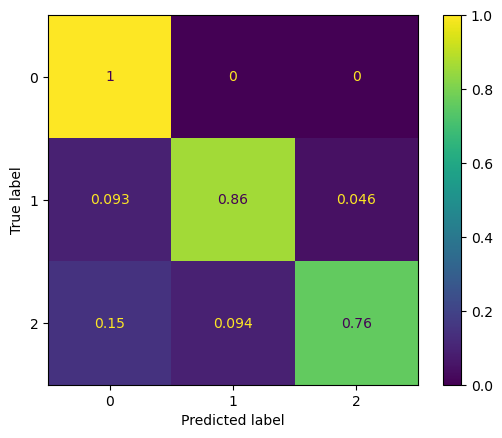

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.74251. Saving Model!
epoch 01, loss: 0.76803, acc: 0.61711, val_loss: 0.74251, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 02, loss: 0.76826, acc: 0.61699, val_loss: 0.74336, val_accuracy: 0.61237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 03, loss: 0.76683, acc: 0.62128, val_loss: 0.74460, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 04, loss: 0.76469, acc: 0.62243, val_loss: 0.74612, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94it/s]


epoch 05, loss: 0.76220, acc: 0.62290, val_loss: 0.74784, val_accuracy: 0.64040


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 06, loss: 0.75989, acc: 0.62372, val_loss: 0.74965, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 07, loss: 0.75789, acc: 0.62296, val_loss: 0.75136, val_accuracy: 0.63882


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 08, loss: 0.75643, acc: 0.63465, val_loss: 0.75289, val_accuracy: 0.63882


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 09, loss: 0.75515, acc: 0.63304, val_loss: 0.75426, val_accuracy: 0.63802


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 10, loss: 0.75375, acc: 0.63336, val_loss: 0.75548, val_accuracy: 0.63432


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 11, loss: 0.75240, acc: 0.63362, val_loss: 0.75665, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 12, loss: 0.75117, acc: 0.63841, val_loss: 0.75767, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 13, loss: 0.74976, acc: 0.63862, val_loss: 0.75885, val_accuracy: 0.59387


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.66it/s]


epoch 14, loss: 0.74845, acc: 0.64103, val_loss: 0.75999, val_accuracy: 0.59413


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 15, loss: 0.74740, acc: 0.64112, val_loss: 0.76101, val_accuracy: 0.59387


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 16, loss: 0.74622, acc: 0.64126, val_loss: 0.76198, val_accuracy: 0.59439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 17, loss: 0.74487, acc: 0.64020, val_loss: 0.76306, val_accuracy: 0.59466


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 18, loss: 0.74371, acc: 0.64035, val_loss: 0.76412, val_accuracy: 0.59545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 19, loss: 0.74263, acc: 0.64026, val_loss: 0.76513, val_accuracy: 0.59519


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 20, loss: 0.74132, acc: 0.64038, val_loss: 0.76611, val_accuracy: 0.59519


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


epoch 21, loss: 0.74018, acc: 0.64103, val_loss: 0.76715, val_accuracy: 0.59598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 22, loss: 0.73922, acc: 0.64144, val_loss: 0.76818, val_accuracy: 0.59625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 23, loss: 0.73800, acc: 0.64153, val_loss: 0.76923, val_accuracy: 0.59625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 24, loss: 0.73683, acc: 0.64167, val_loss: 0.77022, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 25, loss: 0.73570, acc: 0.64153, val_loss: 0.77127, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 26, loss: 0.73461, acc: 0.64429, val_loss: 0.77222, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 27, loss: 0.73349, acc: 0.64402, val_loss: 0.77310, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 28, loss: 0.73228, acc: 0.64555, val_loss: 0.77411, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 29, loss: 0.73118, acc: 0.64417, val_loss: 0.77517, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 30, loss: 0.73011, acc: 0.64435, val_loss: 0.77623, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


epoch 31, loss: 0.72913, acc: 0.64191, val_loss: 0.77726, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 32, loss: 0.72804, acc: 0.64229, val_loss: 0.77827, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 33, loss: 0.72693, acc: 0.64232, val_loss: 0.77925, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 34, loss: 0.72588, acc: 0.64270, val_loss: 0.78024, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39it/s]


epoch 35, loss: 0.72476, acc: 0.64646, val_loss: 0.78129, val_accuracy: 0.59968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 36, loss: 0.72379, acc: 0.64682, val_loss: 0.78232, val_accuracy: 0.60021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 37, loss: 0.72265, acc: 0.64652, val_loss: 0.78329, val_accuracy: 0.60074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 38, loss: 0.72165, acc: 0.64658, val_loss: 0.78426, val_accuracy: 0.60100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21it/s]


epoch 39, loss: 0.72055, acc: 0.64673, val_loss: 0.78535, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 40, loss: 0.71953, acc: 0.64682, val_loss: 0.78652, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 41, loss: 0.71851, acc: 0.64690, val_loss: 0.78762, val_accuracy: 0.59889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 42, loss: 0.71767, acc: 0.64723, val_loss: 0.78859, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 43, loss: 0.71647, acc: 0.64729, val_loss: 0.78959, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 44, loss: 0.71546, acc: 0.64749, val_loss: 0.79064, val_accuracy: 0.59968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 45, loss: 0.71442, acc: 0.64693, val_loss: 0.79176, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 46, loss: 0.71356, acc: 0.64726, val_loss: 0.79284, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.77it/s]


epoch 47, loss: 0.71259, acc: 0.64729, val_loss: 0.79388, val_accuracy: 0.60074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 48, loss: 0.71153, acc: 0.64717, val_loss: 0.79498, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 49, loss: 0.71052, acc: 0.64734, val_loss: 0.79610, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 50, loss: 0.70964, acc: 0.65125, val_loss: 0.79719, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 51, loss: 0.70872, acc: 0.65216, val_loss: 0.79829, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 52, loss: 0.70757, acc: 0.65246, val_loss: 0.79946, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 53, loss: 0.70660, acc: 0.65263, val_loss: 0.80055, val_accuracy: 0.57721


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 54, loss: 0.70574, acc: 0.65325, val_loss: 0.80166, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 55, loss: 0.70477, acc: 0.65210, val_loss: 0.80280, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 56, loss: 0.70363, acc: 0.65228, val_loss: 0.80384, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 57, loss: 0.70274, acc: 0.65181, val_loss: 0.80498, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 58, loss: 0.70177, acc: 0.65287, val_loss: 0.80616, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 59, loss: 0.70061, acc: 0.65463, val_loss: 0.80739, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 60, loss: 0.69977, acc: 0.65466, val_loss: 0.80860, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 61, loss: 0.69891, acc: 0.65454, val_loss: 0.80975, val_accuracy: 0.58144


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 62, loss: 0.69786, acc: 0.65481, val_loss: 0.81092, val_accuracy: 0.58170


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 63, loss: 0.69693, acc: 0.65528, val_loss: 0.81212, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 64, loss: 0.69599, acc: 0.66477, val_loss: 0.81327, val_accuracy: 0.57879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 65, loss: 0.69487, acc: 0.66609, val_loss: 0.81455, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 66, loss: 0.69411, acc: 0.66621, val_loss: 0.81580, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 67, loss: 0.69314, acc: 0.66638, val_loss: 0.81693, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 68, loss: 0.69209, acc: 0.67017, val_loss: 0.81815, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 69, loss: 0.69126, acc: 0.67044, val_loss: 0.81926, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 70, loss: 0.69028, acc: 0.67058, val_loss: 0.82049, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 71, loss: 0.68925, acc: 0.67869, val_loss: 0.82172, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 72, loss: 0.68829, acc: 0.67919, val_loss: 0.82304, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 73, loss: 0.68743, acc: 0.67972, val_loss: 0.82434, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 74, loss: 0.68659, acc: 0.67996, val_loss: 0.82555, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 75, loss: 0.68560, acc: 0.68007, val_loss: 0.82695, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 76, loss: 0.68457, acc: 0.68143, val_loss: 0.82831, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


epoch 77, loss: 0.68381, acc: 0.68157, val_loss: 0.82950, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 78, loss: 0.68300, acc: 0.68242, val_loss: 0.83061, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 79, loss: 0.68185, acc: 0.68269, val_loss: 0.83202, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 80, loss: 0.68104, acc: 0.68281, val_loss: 0.83341, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 81, loss: 0.68031, acc: 0.68304, val_loss: 0.83454, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 82, loss: 0.67913, acc: 0.68345, val_loss: 0.83603, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 83, loss: 0.67830, acc: 0.68357, val_loss: 0.83749, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 84, loss: 0.67764, acc: 0.68433, val_loss: 0.83859, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 85, loss: 0.67647, acc: 0.68477, val_loss: 0.83996, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 86, loss: 0.67552, acc: 0.68589, val_loss: 0.84140, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


epoch 87, loss: 0.67491, acc: 0.68598, val_loss: 0.84251, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 88, loss: 0.67377, acc: 0.68624, val_loss: 0.84385, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 89, loss: 0.67287, acc: 0.68630, val_loss: 0.84542, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 90, loss: 0.67223, acc: 0.68939, val_loss: 0.84679, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 91, loss: 0.67129, acc: 0.68930, val_loss: 0.84805, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 92, loss: 0.67043, acc: 0.68924, val_loss: 0.84939, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 93, loss: 0.66942, acc: 0.68915, val_loss: 0.85095, val_accuracy: 0.58091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.02it/s]


epoch 94, loss: 0.66869, acc: 0.68933, val_loss: 0.85218, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.76it/s]


epoch 95, loss: 0.66799, acc: 0.68942, val_loss: 0.85351, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 96, loss: 0.66682, acc: 0.68942, val_loss: 0.85493, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 97, loss: 0.66609, acc: 0.68936, val_loss: 0.85624, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 98, loss: 0.66543, acc: 0.68936, val_loss: 0.85736, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.64it/s]


epoch 99, loss: 0.66430, acc: 0.68801, val_loss: 0.85856, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 100, loss: 0.66343, acc: 0.68798, val_loss: 0.86005, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 101, loss: 0.66271, acc: 0.68809, val_loss: 0.86134, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 102, loss: 0.66176, acc: 0.68824, val_loss: 0.86249, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.59it/s]


epoch 103, loss: 0.66101, acc: 0.68842, val_loss: 0.86358, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 104, loss: 0.66003, acc: 0.69065, val_loss: 0.86518, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 105, loss: 0.65929, acc: 0.69086, val_loss: 0.86664, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 106, loss: 0.65853, acc: 0.69209, val_loss: 0.86763, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 107, loss: 0.65761, acc: 0.69194, val_loss: 0.86904, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 108, loss: 0.65694, acc: 0.69212, val_loss: 0.87031, val_accuracy: 0.53596


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 109, loss: 0.65579, acc: 0.69723, val_loss: 0.87170, val_accuracy: 0.53384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 110, loss: 0.65519, acc: 0.69711, val_loss: 0.87305, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 111, loss: 0.65433, acc: 0.69738, val_loss: 0.87428, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 112, loss: 0.65354, acc: 0.69741, val_loss: 0.87554, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 113, loss: 0.65271, acc: 0.69726, val_loss: 0.87689, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 114, loss: 0.65183, acc: 0.69753, val_loss: 0.87826, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.05it/s]


epoch 115, loss: 0.65102, acc: 0.69770, val_loss: 0.87949, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


epoch 116, loss: 0.65033, acc: 0.70038, val_loss: 0.88100, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 117, loss: 0.64952, acc: 0.70067, val_loss: 0.88223, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 118, loss: 0.64865, acc: 0.70088, val_loss: 0.88319, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 119, loss: 0.64755, acc: 0.70096, val_loss: 0.88487, val_accuracy: 0.53358


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 120, loss: 0.64716, acc: 0.70120, val_loss: 0.88603, val_accuracy: 0.53358


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 121, loss: 0.64623, acc: 0.70120, val_loss: 0.88706, val_accuracy: 0.53384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 122, loss: 0.64512, acc: 0.70132, val_loss: 0.88856, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 123, loss: 0.64453, acc: 0.70132, val_loss: 0.88980, val_accuracy: 0.53384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 124, loss: 0.64361, acc: 0.70132, val_loss: 0.89119, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 125, loss: 0.64284, acc: 0.70164, val_loss: 0.89240, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 126, loss: 0.64201, acc: 0.70158, val_loss: 0.89386, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 127, loss: 0.64140, acc: 0.70179, val_loss: 0.89470, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 128, loss: 0.64025, acc: 0.70220, val_loss: 0.89619, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 129, loss: 0.63947, acc: 0.70396, val_loss: 0.89768, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 130, loss: 0.63890, acc: 0.70396, val_loss: 0.89892, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 131, loss: 0.63793, acc: 0.70414, val_loss: 0.90013, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 132, loss: 0.63727, acc: 0.70425, val_loss: 0.90111, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 133, loss: 0.63645, acc: 0.70458, val_loss: 0.90246, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 134, loss: 0.63562, acc: 0.70472, val_loss: 0.90359, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


epoch 135, loss: 0.63476, acc: 0.70475, val_loss: 0.90448, val_accuracy: 0.53411


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 136, loss: 0.63392, acc: 0.70472, val_loss: 0.90587, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 137, loss: 0.63320, acc: 0.70511, val_loss: 0.90730, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 138, loss: 0.63244, acc: 0.70443, val_loss: 0.90837, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 139, loss: 0.63167, acc: 0.70449, val_loss: 0.90957, val_accuracy: 0.53437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 140, loss: 0.63086, acc: 0.70472, val_loss: 0.91091, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 141, loss: 0.62999, acc: 0.70481, val_loss: 0.91195, val_accuracy: 0.53490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 142, loss: 0.62914, acc: 0.70569, val_loss: 0.91352, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.31it/s]


epoch 143, loss: 0.62865, acc: 0.70593, val_loss: 0.91431, val_accuracy: 0.53464


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 144, loss: 0.62745, acc: 0.70596, val_loss: 0.91566, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 145, loss: 0.62691, acc: 0.70625, val_loss: 0.91720, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 146, loss: 0.62614, acc: 0.70608, val_loss: 0.91869, val_accuracy: 0.53781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.81it/s]


epoch 147, loss: 0.62527, acc: 0.70625, val_loss: 0.91957, val_accuracy: 0.53755


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 148, loss: 0.62457, acc: 0.70634, val_loss: 0.92086, val_accuracy: 0.53755


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


epoch 149, loss: 0.62384, acc: 0.70643, val_loss: 0.92244, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 150, loss: 0.62276, acc: 0.70819, val_loss: 0.92409, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 151, loss: 0.62234, acc: 0.70828, val_loss: 0.92503, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 152, loss: 0.62150, acc: 0.71160, val_loss: 0.92650, val_accuracy: 0.53622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 153, loss: 0.62033, acc: 0.71207, val_loss: 0.92854, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 154, loss: 0.62024, acc: 0.71198, val_loss: 0.92945, val_accuracy: 0.53649


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 155, loss: 0.61925, acc: 0.71192, val_loss: 0.93075, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 156, loss: 0.61819, acc: 0.71225, val_loss: 0.93228, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 157, loss: 0.61781, acc: 0.71225, val_loss: 0.93332, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 158, loss: 0.61682, acc: 0.71242, val_loss: 0.93495, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]


epoch 159, loss: 0.61603, acc: 0.71277, val_loss: 0.93644, val_accuracy: 0.53675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 160, loss: 0.61565, acc: 0.71277, val_loss: 0.93735, val_accuracy: 0.53702


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 161, loss: 0.61450, acc: 0.71298, val_loss: 0.93908, val_accuracy: 0.53755


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 162, loss: 0.61408, acc: 0.71310, val_loss: 0.94023, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.15it/s]


epoch 163, loss: 0.61297, acc: 0.71339, val_loss: 0.94185, val_accuracy: 0.53755


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 164, loss: 0.61271, acc: 0.71289, val_loss: 0.94276, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 165, loss: 0.61177, acc: 0.71272, val_loss: 0.94415, val_accuracy: 0.53728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 166, loss: 0.61080, acc: 0.71275, val_loss: 0.94606, val_accuracy: 0.53834


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.89it/s]


epoch 167, loss: 0.61050, acc: 0.71272, val_loss: 0.94711, val_accuracy: 0.53781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 168, loss: 0.60959, acc: 0.71806, val_loss: 0.94895, val_accuracy: 0.53781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 169, loss: 0.60884, acc: 0.71836, val_loss: 0.95041, val_accuracy: 0.53781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 170, loss: 0.60838, acc: 0.71871, val_loss: 0.95155, val_accuracy: 0.53808


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 171, loss: 0.60728, acc: 0.71915, val_loss: 0.95302, val_accuracy: 0.53808


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 172, loss: 0.60653, acc: 0.71959, val_loss: 0.95485, val_accuracy: 0.53781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 173, loss: 0.60604, acc: 0.71965, val_loss: 0.95636, val_accuracy: 0.53834


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 174, loss: 0.60511, acc: 0.71980, val_loss: 0.95827, val_accuracy: 0.53808


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 175, loss: 0.60468, acc: 0.72191, val_loss: 0.95943, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 176, loss: 0.60389, acc: 0.72209, val_loss: 0.96071, val_accuracy: 0.53993


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 177, loss: 0.60316, acc: 0.72226, val_loss: 0.96201, val_accuracy: 0.54019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 178, loss: 0.60233, acc: 0.72679, val_loss: 0.96366, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.96it/s]


epoch 179, loss: 0.60156, acc: 0.72723, val_loss: 0.96563, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 180, loss: 0.60094, acc: 0.72767, val_loss: 0.96695, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


epoch 181, loss: 0.60018, acc: 0.72776, val_loss: 0.96875, val_accuracy: 0.53887


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 182, loss: 0.59982, acc: 0.72564, val_loss: 0.96949, val_accuracy: 0.53887


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 183, loss: 0.59855, acc: 0.72582, val_loss: 0.97124, val_accuracy: 0.53860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 184, loss: 0.59832, acc: 0.72597, val_loss: 0.97253, val_accuracy: 0.53834


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 185, loss: 0.59749, acc: 0.72605, val_loss: 0.97389, val_accuracy: 0.53834


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 186, loss: 0.59661, acc: 0.72708, val_loss: 0.97577, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 187, loss: 0.59607, acc: 0.72747, val_loss: 0.97685, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 188, loss: 0.59525, acc: 0.72829, val_loss: 0.97862, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 189, loss: 0.59449, acc: 0.72843, val_loss: 0.98076, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 190, loss: 0.59409, acc: 0.72846, val_loss: 0.98156, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.99it/s]


epoch 191, loss: 0.59310, acc: 0.72858, val_loss: 0.98310, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 192, loss: 0.59257, acc: 0.72888, val_loss: 0.98402, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 193, loss: 0.59174, acc: 0.72905, val_loss: 0.98600, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 194, loss: 0.59078, acc: 0.72923, val_loss: 0.98796, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.88it/s]


epoch 195, loss: 0.59038, acc: 0.72911, val_loss: 0.98931, val_accuracy: 0.54045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 196, loss: 0.58977, acc: 0.72896, val_loss: 0.99059, val_accuracy: 0.54019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 197, loss: 0.58887, acc: 0.72935, val_loss: 0.99170, val_accuracy: 0.54045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 198, loss: 0.58806, acc: 0.72970, val_loss: 0.99367, val_accuracy: 0.54045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39it/s]


epoch 199, loss: 0.58760, acc: 0.72987, val_loss: 0.99504, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 200, loss: 0.58680, acc: 0.72979, val_loss: 0.99661, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 201, loss: 0.58592, acc: 0.73020, val_loss: 0.99842, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 202, loss: 0.58572, acc: 0.73149, val_loss: 0.99879, val_accuracy: 0.54045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 203, loss: 0.58461, acc: 0.73126, val_loss: 1.00057, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 204, loss: 0.58370, acc: 0.73175, val_loss: 1.00282, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 205, loss: 0.58319, acc: 0.73187, val_loss: 1.00422, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 206, loss: 0.58274, acc: 0.73222, val_loss: 1.00533, val_accuracy: 0.53860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.94it/s]


epoch 207, loss: 0.58176, acc: 0.73607, val_loss: 1.00696, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 208, loss: 0.58110, acc: 0.73569, val_loss: 1.00823, val_accuracy: 0.53834


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 209, loss: 0.58047, acc: 0.73716, val_loss: 1.00993, val_accuracy: 0.53860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 210, loss: 0.57946, acc: 0.73681, val_loss: 1.01143, val_accuracy: 0.53860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 211, loss: 0.57913, acc: 0.73695, val_loss: 1.01283, val_accuracy: 0.53860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 212, loss: 0.57820, acc: 0.73657, val_loss: 1.01523, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 213, loss: 0.57790, acc: 0.73678, val_loss: 1.01606, val_accuracy: 0.53860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 214, loss: 0.57692, acc: 0.73663, val_loss: 1.01796, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 215, loss: 0.57612, acc: 0.73669, val_loss: 1.01966, val_accuracy: 0.53913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 216, loss: 0.57603, acc: 0.73663, val_loss: 1.02003, val_accuracy: 0.53940


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 217, loss: 0.57484, acc: 0.73807, val_loss: 1.02249, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 218, loss: 0.57397, acc: 0.73734, val_loss: 1.02464, val_accuracy: 0.54045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 219, loss: 0.57391, acc: 0.73745, val_loss: 1.02519, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 220, loss: 0.57267, acc: 0.73898, val_loss: 1.02740, val_accuracy: 0.54125


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 221, loss: 0.57221, acc: 0.73792, val_loss: 1.02915, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 222, loss: 0.57166, acc: 0.73784, val_loss: 1.03022, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.95it/s]


epoch 223, loss: 0.57078, acc: 0.74286, val_loss: 1.03183, val_accuracy: 0.54072


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 224, loss: 0.57013, acc: 0.74498, val_loss: 1.03385, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


epoch 225, loss: 0.56989, acc: 0.74433, val_loss: 1.03477, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 226, loss: 0.56859, acc: 0.74715, val_loss: 1.03696, val_accuracy: 0.54098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.11it/s]


epoch 227, loss: 0.56827, acc: 0.74841, val_loss: 1.03829, val_accuracy: 0.54178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 228, loss: 0.56757, acc: 0.75000, val_loss: 1.04003, val_accuracy: 0.54257


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 229, loss: 0.56688, acc: 0.75021, val_loss: 1.04121, val_accuracy: 0.54125


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 230, loss: 0.56620, acc: 0.75523, val_loss: 1.04359, val_accuracy: 0.54231


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 231, loss: 0.56566, acc: 0.75576, val_loss: 1.04481, val_accuracy: 0.54151


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 232, loss: 0.56498, acc: 0.75626, val_loss: 1.04667, val_accuracy: 0.54178


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 233, loss: 0.56447, acc: 0.75658, val_loss: 1.04812, val_accuracy: 0.54231


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 234, loss: 0.56373, acc: 0.75670, val_loss: 1.04874, val_accuracy: 0.54389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 235, loss: 0.56309, acc: 0.75711, val_loss: 1.05060, val_accuracy: 0.54416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 236, loss: 0.56232, acc: 0.75790, val_loss: 1.05278, val_accuracy: 0.54416


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 237, loss: 0.56218, acc: 0.75779, val_loss: 1.05379, val_accuracy: 0.54469


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 238, loss: 0.56090, acc: 0.75837, val_loss: 1.05592, val_accuracy: 0.54469


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 239, loss: 0.56066, acc: 0.75878, val_loss: 1.05726, val_accuracy: 0.54469


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 240, loss: 0.56001, acc: 0.75870, val_loss: 1.05864, val_accuracy: 0.54521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 241, loss: 0.55906, acc: 0.75876, val_loss: 1.06014, val_accuracy: 0.54574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 242, loss: 0.55891, acc: 0.75870, val_loss: 1.06168, val_accuracy: 0.54521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 243, loss: 0.55805, acc: 0.75931, val_loss: 1.06344, val_accuracy: 0.54521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 244, loss: 0.55741, acc: 0.75961, val_loss: 1.06542, val_accuracy: 0.54521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 245, loss: 0.55699, acc: 0.75943, val_loss: 1.06617, val_accuracy: 0.54521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 246, loss: 0.55607, acc: 0.75964, val_loss: 1.06758, val_accuracy: 0.54601


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 247, loss: 0.55524, acc: 0.75993, val_loss: 1.06965, val_accuracy: 0.54574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 248, loss: 0.55527, acc: 0.76084, val_loss: 1.07045, val_accuracy: 0.54627


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 249, loss: 0.55422, acc: 0.76199, val_loss: 1.07225, val_accuracy: 0.54680


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 250, loss: 0.55353, acc: 0.76111, val_loss: 1.07400, val_accuracy: 0.54733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 251, loss: 0.55307, acc: 0.76169, val_loss: 1.07547, val_accuracy: 0.54733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 252, loss: 0.55249, acc: 0.76122, val_loss: 1.07653, val_accuracy: 0.54680


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 253, loss: 0.55203, acc: 0.76102, val_loss: 1.07820, val_accuracy: 0.54759


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 254, loss: 0.55097, acc: 0.76263, val_loss: 1.08020, val_accuracy: 0.54733


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 255, loss: 0.55075, acc: 0.76125, val_loss: 1.08121, val_accuracy: 0.54812


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 256, loss: 0.55017, acc: 0.76187, val_loss: 1.08277, val_accuracy: 0.54812


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 257, loss: 0.54928, acc: 0.76337, val_loss: 1.08488, val_accuracy: 0.54786


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 258, loss: 0.54887, acc: 0.76208, val_loss: 1.08623, val_accuracy: 0.54918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 259, loss: 0.54814, acc: 0.76349, val_loss: 1.08796, val_accuracy: 0.54971


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 260, loss: 0.54769, acc: 0.76360, val_loss: 1.08853, val_accuracy: 0.54839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 261, loss: 0.54700, acc: 0.76716, val_loss: 1.09063, val_accuracy: 0.54971


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 262, loss: 0.54635, acc: 0.76601, val_loss: 1.09209, val_accuracy: 0.54971


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 263, loss: 0.54572, acc: 0.76616, val_loss: 1.09337, val_accuracy: 0.54918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25it/s]


epoch 264, loss: 0.54518, acc: 0.76748, val_loss: 1.09491, val_accuracy: 0.54918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 265, loss: 0.54475, acc: 0.76769, val_loss: 1.09531, val_accuracy: 0.54918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 266, loss: 0.54370, acc: 0.76792, val_loss: 1.09772, val_accuracy: 0.54944


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 267, loss: 0.54395, acc: 0.76778, val_loss: 1.09848, val_accuracy: 0.54918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 268, loss: 0.54239, acc: 0.76913, val_loss: 1.10127, val_accuracy: 0.54944


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 269, loss: 0.54206, acc: 0.76854, val_loss: 1.10339, val_accuracy: 0.54892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 270, loss: 0.54229, acc: 0.76825, val_loss: 1.10351, val_accuracy: 0.54892


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 271, loss: 0.54078, acc: 0.76960, val_loss: 1.10567, val_accuracy: 0.55103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 272, loss: 0.54052, acc: 0.76974, val_loss: 1.10726, val_accuracy: 0.55103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 273, loss: 0.54013, acc: 0.76983, val_loss: 1.10789, val_accuracy: 0.55103


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 274, loss: 0.53931, acc: 0.76966, val_loss: 1.11051, val_accuracy: 0.55447


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 275, loss: 0.53861, acc: 0.77001, val_loss: 1.11210, val_accuracy: 0.55447


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 276, loss: 0.53866, acc: 0.76986, val_loss: 1.11381, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 277, loss: 0.53754, acc: 0.77004, val_loss: 1.11578, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 278, loss: 0.53722, acc: 0.77048, val_loss: 1.11684, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 279, loss: 0.53651, acc: 0.77045, val_loss: 1.11822, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 280, loss: 0.53589, acc: 0.77115, val_loss: 1.12018, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 281, loss: 0.53541, acc: 0.77130, val_loss: 1.12116, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


epoch 282, loss: 0.53502, acc: 0.77121, val_loss: 1.12319, val_accuracy: 0.55420


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 283, loss: 0.53406, acc: 0.77165, val_loss: 1.12484, val_accuracy: 0.55394


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 284, loss: 0.53385, acc: 0.76686, val_loss: 1.12695, val_accuracy: 0.55447


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 285, loss: 0.53332, acc: 0.76766, val_loss: 1.12736, val_accuracy: 0.55605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 286, loss: 0.53254, acc: 0.77201, val_loss: 1.12996, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 287, loss: 0.53183, acc: 0.76783, val_loss: 1.13130, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 288, loss: 0.53193, acc: 0.76772, val_loss: 1.13264, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 289, loss: 0.53064, acc: 0.76901, val_loss: 1.13455, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 290, loss: 0.53056, acc: 0.76898, val_loss: 1.13609, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 291, loss: 0.52984, acc: 0.76916, val_loss: 1.13803, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 292, loss: 0.52933, acc: 0.76945, val_loss: 1.13906, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 293, loss: 0.52892, acc: 0.76933, val_loss: 1.14034, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 294, loss: 0.52815, acc: 0.76963, val_loss: 1.14245, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 295, loss: 0.52753, acc: 0.77118, val_loss: 1.14460, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 296, loss: 0.52732, acc: 0.77154, val_loss: 1.14413, val_accuracy: 0.55605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 297, loss: 0.52627, acc: 0.77168, val_loss: 1.14591, val_accuracy: 0.55605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 298, loss: 0.52586, acc: 0.77209, val_loss: 1.14709, val_accuracy: 0.55711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 299, loss: 0.52587, acc: 0.77198, val_loss: 1.14561, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 300, loss: 0.52448, acc: 0.77218, val_loss: 1.14669, val_accuracy: 0.55685


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 301, loss: 0.52414, acc: 0.77245, val_loss: 1.14719, val_accuracy: 0.55738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 302, loss: 0.52414, acc: 0.77236, val_loss: 1.14720, val_accuracy: 0.55738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 303, loss: 0.52268, acc: 0.77248, val_loss: 1.14850, val_accuracy: 0.55764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 304, loss: 0.52262, acc: 0.77298, val_loss: 1.14879, val_accuracy: 0.55791


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 305, loss: 0.52245, acc: 0.77303, val_loss: 1.14923, val_accuracy: 0.55738


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 306, loss: 0.52115, acc: 0.77318, val_loss: 1.15025, val_accuracy: 0.55817


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 307, loss: 0.52102, acc: 0.77318, val_loss: 1.15147, val_accuracy: 0.55843


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 308, loss: 0.52005, acc: 0.77324, val_loss: 1.15348, val_accuracy: 0.55817


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 309, loss: 0.52008, acc: 0.77348, val_loss: 1.15509, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 310, loss: 0.51947, acc: 0.77368, val_loss: 1.15538, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 311, loss: 0.51840, acc: 0.77374, val_loss: 1.15835, val_accuracy: 0.56002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 312, loss: 0.51823, acc: 0.77406, val_loss: 1.15955, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 313, loss: 0.51772, acc: 0.77380, val_loss: 1.16145, val_accuracy: 0.56002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 314, loss: 0.51716, acc: 0.77415, val_loss: 1.16307, val_accuracy: 0.56029


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 315, loss: 0.51666, acc: 0.77430, val_loss: 1.16415, val_accuracy: 0.56029


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 316, loss: 0.51577, acc: 0.77439, val_loss: 1.16661, val_accuracy: 0.56055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 317, loss: 0.51575, acc: 0.77450, val_loss: 1.16693, val_accuracy: 0.56029


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 318, loss: 0.51481, acc: 0.77468, val_loss: 1.16913, val_accuracy: 0.56055


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.92it/s]


epoch 319, loss: 0.51458, acc: 0.77433, val_loss: 1.17080, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 320, loss: 0.51400, acc: 0.77427, val_loss: 1.17203, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 321, loss: 0.51329, acc: 0.77439, val_loss: 1.17358, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 322, loss: 0.51285, acc: 0.77521, val_loss: 1.17562, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.68it/s]


epoch 323, loss: 0.51269, acc: 0.77521, val_loss: 1.17582, val_accuracy: 0.56081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 324, loss: 0.51162, acc: 0.77530, val_loss: 1.17768, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 325, loss: 0.51132, acc: 0.77536, val_loss: 1.17905, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 326, loss: 0.51112, acc: 0.77541, val_loss: 1.17971, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 327, loss: 0.51006, acc: 0.77574, val_loss: 1.18064, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 328, loss: 0.50970, acc: 0.77574, val_loss: 1.18328, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 329, loss: 0.50932, acc: 0.77600, val_loss: 1.18481, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 330, loss: 0.50890, acc: 0.77477, val_loss: 1.18600, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 331, loss: 0.50820, acc: 0.77618, val_loss: 1.18731, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 332, loss: 0.50765, acc: 0.77633, val_loss: 1.18952, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 333, loss: 0.50761, acc: 0.77512, val_loss: 1.18965, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 334, loss: 0.50660, acc: 0.77644, val_loss: 1.19191, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 335, loss: 0.50589, acc: 0.77562, val_loss: 1.19418, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 336, loss: 0.50605, acc: 0.77571, val_loss: 1.19475, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 337, loss: 0.50545, acc: 0.77694, val_loss: 1.19484, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 338, loss: 0.50453, acc: 0.77703, val_loss: 1.19741, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 339, loss: 0.50427, acc: 0.77735, val_loss: 1.19837, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 340, loss: 0.50373, acc: 0.77735, val_loss: 1.19997, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


epoch 341, loss: 0.50284, acc: 0.77774, val_loss: 1.20219, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 342, loss: 0.50320, acc: 0.77753, val_loss: 1.20334, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 343, loss: 0.50207, acc: 0.77771, val_loss: 1.20405, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 344, loss: 0.50174, acc: 0.77776, val_loss: 1.20551, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 345, loss: 0.50114, acc: 0.77794, val_loss: 1.20671, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 346, loss: 0.50085, acc: 0.77788, val_loss: 1.20874, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 347, loss: 0.50010, acc: 0.77823, val_loss: 1.20961, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 348, loss: 0.49987, acc: 0.77812, val_loss: 1.21159, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 349, loss: 0.49901, acc: 0.77832, val_loss: 1.21260, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 350, loss: 0.49877, acc: 0.77832, val_loss: 1.21300, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


epoch 351, loss: 0.49826, acc: 0.77829, val_loss: 1.21557, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 352, loss: 0.49788, acc: 0.77853, val_loss: 1.21691, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 353, loss: 0.49745, acc: 0.77859, val_loss: 1.21802, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 354, loss: 0.49620, acc: 0.77876, val_loss: 1.22026, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 355, loss: 0.49660, acc: 0.77873, val_loss: 1.22106, val_accuracy: 0.56081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 356, loss: 0.49551, acc: 0.77915, val_loss: 1.22234, val_accuracy: 0.56134


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 357, loss: 0.49533, acc: 0.77912, val_loss: 1.22319, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 358, loss: 0.49462, acc: 0.77882, val_loss: 1.22582, val_accuracy: 0.56293


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27it/s]


epoch 359, loss: 0.49440, acc: 0.77873, val_loss: 1.22640, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 360, loss: 0.49341, acc: 0.77912, val_loss: 1.22955, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 361, loss: 0.49369, acc: 0.77920, val_loss: 1.22897, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 362, loss: 0.49276, acc: 0.77938, val_loss: 1.23130, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 363, loss: 0.49199, acc: 0.77973, val_loss: 1.23416, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 364, loss: 0.49254, acc: 0.77944, val_loss: 1.23315, val_accuracy: 0.56161


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 365, loss: 0.49064, acc: 0.77979, val_loss: 1.23660, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 366, loss: 0.49156, acc: 0.78006, val_loss: 1.23573, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 367, loss: 0.49035, acc: 0.78000, val_loss: 1.23841, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 368, loss: 0.48952, acc: 0.78064, val_loss: 1.24164, val_accuracy: 0.56214


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 369, loss: 0.48995, acc: 0.78044, val_loss: 1.24195, val_accuracy: 0.56504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 370, loss: 0.48868, acc: 0.78079, val_loss: 1.24328, val_accuracy: 0.56531


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 371, loss: 0.48882, acc: 0.78082, val_loss: 1.24484, val_accuracy: 0.56557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 372, loss: 0.48816, acc: 0.78100, val_loss: 1.24556, val_accuracy: 0.56557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.52it/s]


epoch 373, loss: 0.48742, acc: 0.78235, val_loss: 1.24817, val_accuracy: 0.56584


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 374, loss: 0.48750, acc: 0.78111, val_loss: 1.24665, val_accuracy: 0.56557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 375, loss: 0.48636, acc: 0.78129, val_loss: 1.24913, val_accuracy: 0.56584


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 376, loss: 0.48594, acc: 0.78302, val_loss: 1.25174, val_accuracy: 0.56610


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 377, loss: 0.48591, acc: 0.78155, val_loss: 1.25197, val_accuracy: 0.56610


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 378, loss: 0.48528, acc: 0.78188, val_loss: 1.25392, val_accuracy: 0.56610


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 379, loss: 0.48479, acc: 0.78188, val_loss: 1.25415, val_accuracy: 0.56637


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 380, loss: 0.48380, acc: 0.78241, val_loss: 1.25677, val_accuracy: 0.56716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 381, loss: 0.48409, acc: 0.78288, val_loss: 1.25765, val_accuracy: 0.56690


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 382, loss: 0.48319, acc: 0.78226, val_loss: 1.26045, val_accuracy: 0.56716


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 383, loss: 0.48278, acc: 0.78391, val_loss: 1.26223, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 384, loss: 0.48285, acc: 0.78435, val_loss: 1.26120, val_accuracy: 0.56742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 385, loss: 0.48174, acc: 0.78376, val_loss: 1.26370, val_accuracy: 0.56795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 386, loss: 0.48163, acc: 0.78417, val_loss: 1.26559, val_accuracy: 0.56795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 387, loss: 0.48103, acc: 0.78449, val_loss: 1.26702, val_accuracy: 0.57007


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 388, loss: 0.48069, acc: 0.78455, val_loss: 1.26859, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s]


epoch 389, loss: 0.47992, acc: 0.78523, val_loss: 1.27042, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.50it/s]


epoch 390, loss: 0.48004, acc: 0.78476, val_loss: 1.27151, val_accuracy: 0.57033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 391, loss: 0.47883, acc: 0.78564, val_loss: 1.27380, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 392, loss: 0.47899, acc: 0.78573, val_loss: 1.27480, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 393, loss: 0.47813, acc: 0.78593, val_loss: 1.27568, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.70it/s]


epoch 394, loss: 0.47774, acc: 0.78629, val_loss: 1.27818, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 395, loss: 0.47762, acc: 0.78626, val_loss: 1.27848, val_accuracy: 0.57166


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 396, loss: 0.47655, acc: 0.78661, val_loss: 1.28040, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 397, loss: 0.47680, acc: 0.78631, val_loss: 1.28030, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 398, loss: 0.47584, acc: 0.78678, val_loss: 1.28282, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.33it/s]


epoch 399, loss: 0.47588, acc: 0.78684, val_loss: 1.28306, val_accuracy: 0.57192


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


epoch 400, loss: 0.47482, acc: 0.78717, val_loss: 1.28585, val_accuracy: 0.57218


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 401, loss: 0.47471, acc: 0.78887, val_loss: 1.28735, val_accuracy: 0.57245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 402, loss: 0.47444, acc: 0.78728, val_loss: 1.28861, val_accuracy: 0.57245


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.02it/s]


epoch 403, loss: 0.47371, acc: 0.78731, val_loss: 1.28951, val_accuracy: 0.57271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 404, loss: 0.47336, acc: 0.78755, val_loss: 1.29120, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 405, loss: 0.47312, acc: 0.78749, val_loss: 1.29259, val_accuracy: 0.57298


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 406, loss: 0.47260, acc: 0.78770, val_loss: 1.29334, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 407, loss: 0.47205, acc: 0.78767, val_loss: 1.29464, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.22it/s]


epoch 408, loss: 0.47150, acc: 0.78770, val_loss: 1.29753, val_accuracy: 0.57351


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 409, loss: 0.47126, acc: 0.78955, val_loss: 1.29760, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 410, loss: 0.47101, acc: 0.78958, val_loss: 1.29753, val_accuracy: 0.57377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 411, loss: 0.46971, acc: 0.78799, val_loss: 1.30082, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04it/s]


epoch 412, loss: 0.47010, acc: 0.78811, val_loss: 1.30250, val_accuracy: 0.57403


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 413, loss: 0.46984, acc: 0.78961, val_loss: 1.30233, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 414, loss: 0.46847, acc: 0.78975, val_loss: 1.30502, val_accuracy: 0.57483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 415, loss: 0.46891, acc: 0.78958, val_loss: 1.30447, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 416, loss: 0.46783, acc: 0.79008, val_loss: 1.30681, val_accuracy: 0.57430


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 417, loss: 0.46765, acc: 0.79043, val_loss: 1.30763, val_accuracy: 0.57456


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


epoch 418, loss: 0.46769, acc: 0.79078, val_loss: 1.30816, val_accuracy: 0.57456


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 419, loss: 0.46616, acc: 0.79104, val_loss: 1.31191, val_accuracy: 0.57562


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18it/s]


epoch 420, loss: 0.46666, acc: 0.79146, val_loss: 1.31066, val_accuracy: 0.57589


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.41it/s]


epoch 421, loss: 0.46596, acc: 0.79190, val_loss: 1.31194, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.19it/s]


epoch 422, loss: 0.46538, acc: 0.79110, val_loss: 1.31431, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 423, loss: 0.46521, acc: 0.79110, val_loss: 1.31513, val_accuracy: 0.57589


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 424, loss: 0.46469, acc: 0.79225, val_loss: 1.31544, val_accuracy: 0.57589


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 425, loss: 0.46415, acc: 0.79137, val_loss: 1.31774, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 426, loss: 0.46367, acc: 0.79163, val_loss: 1.31864, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 427, loss: 0.46349, acc: 0.79304, val_loss: 1.32011, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 428, loss: 0.46315, acc: 0.79269, val_loss: 1.32149, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 429, loss: 0.46265, acc: 0.79316, val_loss: 1.32195, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 430, loss: 0.46231, acc: 0.79316, val_loss: 1.32117, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.50it/s]


epoch 431, loss: 0.46146, acc: 0.79316, val_loss: 1.32493, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 432, loss: 0.46122, acc: 0.79337, val_loss: 1.32620, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 433, loss: 0.46130, acc: 0.79190, val_loss: 1.32626, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 434, loss: 0.46029, acc: 0.79387, val_loss: 1.32813, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 435, loss: 0.46017, acc: 0.79372, val_loss: 1.32980, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 436, loss: 0.45964, acc: 0.79387, val_loss: 1.33173, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 437, loss: 0.45939, acc: 0.79401, val_loss: 1.33124, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 438, loss: 0.45861, acc: 0.79410, val_loss: 1.33410, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 439, loss: 0.45852, acc: 0.79431, val_loss: 1.33533, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 440, loss: 0.45850, acc: 0.79419, val_loss: 1.33669, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 441, loss: 0.45726, acc: 0.79384, val_loss: 1.34031, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 442, loss: 0.45740, acc: 0.79457, val_loss: 1.34151, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


epoch 443, loss: 0.45702, acc: 0.79407, val_loss: 1.34237, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 444, loss: 0.45639, acc: 0.79404, val_loss: 1.34360, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 445, loss: 0.45570, acc: 0.79436, val_loss: 1.34702, val_accuracy: 0.58065


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 446, loss: 0.45636, acc: 0.79442, val_loss: 1.34661, val_accuracy: 0.58091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 447, loss: 0.45467, acc: 0.79469, val_loss: 1.35076, val_accuracy: 0.58091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.16it/s]


epoch 448, loss: 0.45543, acc: 0.79416, val_loss: 1.35034, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 449, loss: 0.45413, acc: 0.79436, val_loss: 1.35263, val_accuracy: 0.58223


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 450, loss: 0.45421, acc: 0.79436, val_loss: 1.35449, val_accuracy: 0.58514


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 451, loss: 0.45373, acc: 0.79104, val_loss: 1.35508, val_accuracy: 0.58223


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 452, loss: 0.45325, acc: 0.79466, val_loss: 1.35703, val_accuracy: 0.58250


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 453, loss: 0.45294, acc: 0.79478, val_loss: 1.35904, val_accuracy: 0.58302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 454, loss: 0.45257, acc: 0.79507, val_loss: 1.36057, val_accuracy: 0.58620


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 455, loss: 0.45180, acc: 0.79181, val_loss: 1.36393, val_accuracy: 0.58567


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 456, loss: 0.45232, acc: 0.79181, val_loss: 1.36117, val_accuracy: 0.58302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 457, loss: 0.45113, acc: 0.79548, val_loss: 1.36315, val_accuracy: 0.58408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 458, loss: 0.45060, acc: 0.79560, val_loss: 1.36699, val_accuracy: 0.58646


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 459, loss: 0.45086, acc: 0.79216, val_loss: 1.36842, val_accuracy: 0.58620


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 460, loss: 0.45013, acc: 0.79228, val_loss: 1.37001, val_accuracy: 0.58699


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 461, loss: 0.44963, acc: 0.79234, val_loss: 1.37110, val_accuracy: 0.58726


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 462, loss: 0.44911, acc: 0.79260, val_loss: 1.37216, val_accuracy: 0.58673


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 463, loss: 0.44939, acc: 0.79272, val_loss: 1.37250, val_accuracy: 0.58726


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 464, loss: 0.44855, acc: 0.79293, val_loss: 1.37373, val_accuracy: 0.58699


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 465, loss: 0.44795, acc: 0.79301, val_loss: 1.37546, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 466, loss: 0.44789, acc: 0.79348, val_loss: 1.37647, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


epoch 467, loss: 0.44732, acc: 0.79378, val_loss: 1.37958, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 468, loss: 0.44720, acc: 0.79404, val_loss: 1.37820, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 469, loss: 0.44662, acc: 0.79407, val_loss: 1.37946, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 470, loss: 0.44623, acc: 0.79416, val_loss: 1.38135, val_accuracy: 0.58831


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 471, loss: 0.44579, acc: 0.79428, val_loss: 1.38317, val_accuracy: 0.58831


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 472, loss: 0.44565, acc: 0.79463, val_loss: 1.38394, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 473, loss: 0.44476, acc: 0.79451, val_loss: 1.38655, val_accuracy: 0.58831


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 474, loss: 0.44546, acc: 0.79442, val_loss: 1.38493, val_accuracy: 0.58831


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 475, loss: 0.44386, acc: 0.79478, val_loss: 1.38846, val_accuracy: 0.58858


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 476, loss: 0.44408, acc: 0.79489, val_loss: 1.38902, val_accuracy: 0.58831


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 477, loss: 0.44356, acc: 0.79833, val_loss: 1.39121, val_accuracy: 0.58805


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 478, loss: 0.44361, acc: 0.79830, val_loss: 1.39168, val_accuracy: 0.58937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


epoch 479, loss: 0.44262, acc: 0.79525, val_loss: 1.39233, val_accuracy: 0.58805


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 480, loss: 0.44268, acc: 0.79860, val_loss: 1.39442, val_accuracy: 0.58858


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 481, loss: 0.44207, acc: 0.79880, val_loss: 1.39564, val_accuracy: 0.58858


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 482, loss: 0.44217, acc: 0.79877, val_loss: 1.39625, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 483, loss: 0.44126, acc: 0.79918, val_loss: 1.39754, val_accuracy: 0.58805


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 484, loss: 0.44101, acc: 0.79918, val_loss: 1.40008, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 485, loss: 0.44080, acc: 0.79957, val_loss: 1.40012, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 486, loss: 0.44075, acc: 0.79918, val_loss: 1.40098, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 487, loss: 0.43952, acc: 0.79971, val_loss: 1.40272, val_accuracy: 0.58858


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 488, loss: 0.43989, acc: 0.79971, val_loss: 1.40245, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 489, loss: 0.43898, acc: 0.79986, val_loss: 1.40301, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 490, loss: 0.43904, acc: 0.79971, val_loss: 1.40499, val_accuracy: 0.58937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 491, loss: 0.43838, acc: 0.79983, val_loss: 1.40683, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 492, loss: 0.43848, acc: 0.79983, val_loss: 1.40659, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 493, loss: 0.43743, acc: 0.80036, val_loss: 1.40892, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 494, loss: 0.43787, acc: 0.80018, val_loss: 1.40944, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 495, loss: 0.43671, acc: 0.80086, val_loss: 1.41228, val_accuracy: 0.58964


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 496, loss: 0.43698, acc: 0.80059, val_loss: 1.41189, val_accuracy: 0.58964


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 497, loss: 0.43637, acc: 0.80074, val_loss: 1.41352, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 498, loss: 0.43621, acc: 0.80068, val_loss: 1.41334, val_accuracy: 0.58964


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 499, loss: 0.43530, acc: 0.80103, val_loss: 1.41612, val_accuracy: 0.58937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 500, loss: 0.43539, acc: 0.80118, val_loss: 1.41855, val_accuracy: 0.58964
3번째 교차검증
evaluation loss: 0.74251, evaluation accuracy: 0.61555
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0179782	total: 8.95ms	remaining: 8.94s
1:	learn: 0.9528690	total: 16.3ms	remaining: 8.14s
2:	learn: 0.8993928	total: 23.7ms	remaining: 7.87s
3:	learn: 0.8543603	total: 30.3ms	remaining: 7.55s
4:	learn: 0.8152708	total: 38.3ms	remaining: 7.63s
5:	learn: 0.7823884	total: 45.7ms	remaining: 7.57s
6:	learn: 0.7540441	total: 54.8ms	remaining: 7.78s
7:	learn: 0.7296663	total: 61.8ms	remaining: 7.66s
8:	learn: 0.7081420	total: 71.5ms	remaining: 7.87s
9:	learn: 0.6883230	total: 78.4ms	remaining: 7.76s
10:	learn: 0.6711117	total: 86.6ms	remaining: 7.79s
11:	learn: 0.6561025	total: 93.4ms	remaining: 7.69s
12:	learn: 0.6428358	total: 101ms	remaining: 7.69s
13:	learn: 0.6304781	total: 108ms	remaining: 7.63s
14:	learn: 0.6196497	total: 116ms	remaining: 7.62s
15:	learn: 0.6096957	total: 122ms	rema

172:	learn: 0.4839026	total: 1.24s	remaining: 5.91s
173:	learn: 0.4838603	total: 1.24s	remaining: 5.9s
174:	learn: 0.4838203	total: 1.25s	remaining: 5.9s
175:	learn: 0.4837401	total: 1.26s	remaining: 5.89s
176:	learn: 0.4837059	total: 1.26s	remaining: 5.88s
177:	learn: 0.4836532	total: 1.27s	remaining: 5.87s
178:	learn: 0.4836128	total: 1.28s	remaining: 5.86s
179:	learn: 0.4835716	total: 1.29s	remaining: 5.87s
180:	learn: 0.4835167	total: 1.29s	remaining: 5.86s
181:	learn: 0.4834778	total: 1.3s	remaining: 5.85s
182:	learn: 0.4834388	total: 1.31s	remaining: 5.84s
183:	learn: 0.4833882	total: 1.32s	remaining: 5.84s
184:	learn: 0.4833545	total: 1.32s	remaining: 5.83s
185:	learn: 0.4833180	total: 1.33s	remaining: 5.82s
186:	learn: 0.4832621	total: 1.34s	remaining: 5.82s
187:	learn: 0.4832208	total: 1.34s	remaining: 5.81s
188:	learn: 0.4831871	total: 1.35s	remaining: 5.8s
189:	learn: 0.4831529	total: 1.36s	remaining: 5.79s
190:	learn: 0.4831155	total: 1.37s	remaining: 5.79s
191:	learn: 0.48

347:	learn: 0.4798034	total: 2.69s	remaining: 5.04s
348:	learn: 0.4797889	total: 2.7s	remaining: 5.03s
349:	learn: 0.4797796	total: 2.71s	remaining: 5.03s
350:	learn: 0.4797685	total: 2.71s	remaining: 5.02s
351:	learn: 0.4797578	total: 2.72s	remaining: 5.01s
352:	learn: 0.4797469	total: 2.73s	remaining: 5.01s
353:	learn: 0.4797365	total: 2.74s	remaining: 5s
354:	learn: 0.4797219	total: 2.75s	remaining: 4.99s
355:	learn: 0.4797122	total: 2.76s	remaining: 4.99s
356:	learn: 0.4796990	total: 2.76s	remaining: 4.98s
357:	learn: 0.4796898	total: 2.77s	remaining: 4.97s
358:	learn: 0.4796797	total: 2.78s	remaining: 4.96s
359:	learn: 0.4796705	total: 2.79s	remaining: 4.96s
360:	learn: 0.4796578	total: 2.8s	remaining: 4.95s
361:	learn: 0.4796484	total: 2.8s	remaining: 4.94s
362:	learn: 0.4796369	total: 2.81s	remaining: 4.94s
363:	learn: 0.4796273	total: 2.82s	remaining: 4.93s
364:	learn: 0.4796188	total: 2.83s	remaining: 4.92s
365:	learn: 0.4796097	total: 2.84s	remaining: 4.92s
366:	learn: 0.4796

519:	learn: 0.4785633	total: 4.14s	remaining: 3.82s
520:	learn: 0.4785579	total: 4.15s	remaining: 3.81s
521:	learn: 0.4785529	total: 4.15s	remaining: 3.8s
522:	learn: 0.4785485	total: 4.16s	remaining: 3.8s
523:	learn: 0.4785450	total: 4.17s	remaining: 3.79s
524:	learn: 0.4785412	total: 4.18s	remaining: 3.78s
525:	learn: 0.4785382	total: 4.19s	remaining: 3.77s
526:	learn: 0.4785349	total: 4.2s	remaining: 3.77s
527:	learn: 0.4785296	total: 4.21s	remaining: 3.76s
528:	learn: 0.4785256	total: 4.21s	remaining: 3.75s
529:	learn: 0.4785217	total: 4.22s	remaining: 3.75s
530:	learn: 0.4785166	total: 4.23s	remaining: 3.74s
531:	learn: 0.4785118	total: 4.24s	remaining: 3.73s
532:	learn: 0.4785084	total: 4.25s	remaining: 3.72s
533:	learn: 0.4785041	total: 4.26s	remaining: 3.71s
534:	learn: 0.4784993	total: 4.26s	remaining: 3.71s
535:	learn: 0.4784955	total: 4.27s	remaining: 3.7s
536:	learn: 0.4784912	total: 4.28s	remaining: 3.69s
537:	learn: 0.4784876	total: 4.29s	remaining: 3.69s
538:	learn: 0.47

683:	learn: 0.4779889	total: 5.6s	remaining: 2.58s
684:	learn: 0.4779865	total: 5.6s	remaining: 2.58s
685:	learn: 0.4779834	total: 5.61s	remaining: 2.57s
686:	learn: 0.4779804	total: 5.62s	remaining: 2.56s
687:	learn: 0.4779776	total: 5.63s	remaining: 2.55s
688:	learn: 0.4779759	total: 5.64s	remaining: 2.54s
689:	learn: 0.4779730	total: 5.65s	remaining: 2.54s
690:	learn: 0.4779707	total: 5.66s	remaining: 2.53s
691:	learn: 0.4779683	total: 5.66s	remaining: 2.52s
692:	learn: 0.4779657	total: 5.67s	remaining: 2.51s
693:	learn: 0.4779630	total: 5.68s	remaining: 2.5s
694:	learn: 0.4779601	total: 5.69s	remaining: 2.5s
695:	learn: 0.4779576	total: 5.7s	remaining: 2.49s
696:	learn: 0.4779552	total: 5.71s	remaining: 2.48s
697:	learn: 0.4779527	total: 5.72s	remaining: 2.47s
698:	learn: 0.4779499	total: 5.72s	remaining: 2.46s
699:	learn: 0.4779486	total: 5.73s	remaining: 2.46s
700:	learn: 0.4779459	total: 5.74s	remaining: 2.45s
701:	learn: 0.4779434	total: 5.75s	remaining: 2.44s
702:	learn: 0.477

847:	learn: 0.4776574	total: 7.05s	remaining: 1.26s
848:	learn: 0.4776561	total: 7.06s	remaining: 1.26s
849:	learn: 0.4776544	total: 7.07s	remaining: 1.25s
850:	learn: 0.4776519	total: 7.08s	remaining: 1.24s
851:	learn: 0.4776504	total: 7.09s	remaining: 1.23s
852:	learn: 0.4776486	total: 7.1s	remaining: 1.22s
853:	learn: 0.4776474	total: 7.1s	remaining: 1.21s
854:	learn: 0.4776457	total: 7.11s	remaining: 1.21s
855:	learn: 0.4776446	total: 7.12s	remaining: 1.2s
856:	learn: 0.4776435	total: 7.13s	remaining: 1.19s
857:	learn: 0.4776424	total: 7.14s	remaining: 1.18s
858:	learn: 0.4776408	total: 7.14s	remaining: 1.17s
859:	learn: 0.4776392	total: 7.15s	remaining: 1.16s
860:	learn: 0.4776372	total: 7.16s	remaining: 1.16s
861:	learn: 0.4776357	total: 7.17s	remaining: 1.15s
862:	learn: 0.4776341	total: 7.18s	remaining: 1.14s
863:	learn: 0.4776329	total: 7.19s	remaining: 1.13s
864:	learn: 0.4776311	total: 7.2s	remaining: 1.12s
865:	learn: 0.4776293	total: 7.21s	remaining: 1.11s
866:	learn: 0.47

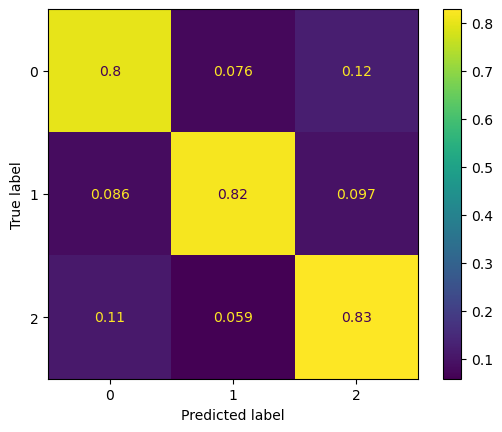

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.70470. Saving Model!
epoch 01, loss: 0.77182, acc: 0.61179, val_loss: 0.70470, val_accuracy: 0.67715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 02, loss: 0.77315, acc: 0.61250, val_loss: 0.70744, val_accuracy: 0.67927


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 03, loss: 0.77213, acc: 0.61253, val_loss: 0.71019, val_accuracy: 0.67821


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 04, loss: 0.76962, acc: 0.61520, val_loss: 0.71296, val_accuracy: 0.67980


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 05, loss: 0.76664, acc: 0.61497, val_loss: 0.71568, val_accuracy: 0.67901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 06, loss: 0.76395, acc: 0.61702, val_loss: 0.71839, val_accuracy: 0.67715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


epoch 07, loss: 0.76181, acc: 0.62878, val_loss: 0.72102, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 08, loss: 0.76025, acc: 0.62863, val_loss: 0.72330, val_accuracy: 0.67557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 09, loss: 0.75903, acc: 0.62745, val_loss: 0.72510, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 10, loss: 0.75790, acc: 0.62792, val_loss: 0.72636, val_accuracy: 0.67557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 11, loss: 0.75667, acc: 0.62804, val_loss: 0.72727, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 12, loss: 0.75534, acc: 0.63277, val_loss: 0.72805, val_accuracy: 0.67478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


epoch 13, loss: 0.75412, acc: 0.63641, val_loss: 0.72866, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 14, loss: 0.75306, acc: 0.63633, val_loss: 0.72909, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 15, loss: 0.75181, acc: 0.63733, val_loss: 0.72953, val_accuracy: 0.67319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 16, loss: 0.75059, acc: 0.63747, val_loss: 0.72995, val_accuracy: 0.67372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 17, loss: 0.74947, acc: 0.63747, val_loss: 0.73038, val_accuracy: 0.67266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 18, loss: 0.74845, acc: 0.63735, val_loss: 0.73069, val_accuracy: 0.67266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 19, loss: 0.74729, acc: 0.63724, val_loss: 0.73084, val_accuracy: 0.67266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 20, loss: 0.74599, acc: 0.63718, val_loss: 0.73116, val_accuracy: 0.67266


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 21, loss: 0.74471, acc: 0.63683, val_loss: 0.73166, val_accuracy: 0.67319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 22, loss: 0.74374, acc: 0.63627, val_loss: 0.73209, val_accuracy: 0.67240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 23, loss: 0.74276, acc: 0.63844, val_loss: 0.73240, val_accuracy: 0.67557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 24, loss: 0.74170, acc: 0.63800, val_loss: 0.73269, val_accuracy: 0.67557


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 25, loss: 0.74062, acc: 0.63659, val_loss: 0.73296, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 26, loss: 0.73965, acc: 0.63650, val_loss: 0.73328, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 27, loss: 0.73872, acc: 0.63662, val_loss: 0.73358, val_accuracy: 0.67768


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 28, loss: 0.73763, acc: 0.63650, val_loss: 0.73366, val_accuracy: 0.67768


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 29, loss: 0.73667, acc: 0.63794, val_loss: 0.73394, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 30, loss: 0.73564, acc: 0.63794, val_loss: 0.73433, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 31, loss: 0.73462, acc: 0.63897, val_loss: 0.73472, val_accuracy: 0.67848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 32, loss: 0.73360, acc: 0.63923, val_loss: 0.73508, val_accuracy: 0.67874


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 33, loss: 0.73255, acc: 0.63903, val_loss: 0.73543, val_accuracy: 0.67848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 34, loss: 0.73173, acc: 0.63888, val_loss: 0.73573, val_accuracy: 0.67874


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.22it/s]


epoch 35, loss: 0.73079, acc: 0.63909, val_loss: 0.73606, val_accuracy: 0.67874


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 36, loss: 0.72961, acc: 0.63921, val_loss: 0.73642, val_accuracy: 0.67901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 37, loss: 0.72861, acc: 0.64065, val_loss: 0.73680, val_accuracy: 0.67901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 38, loss: 0.72782, acc: 0.64288, val_loss: 0.73708, val_accuracy: 0.68191


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 39, loss: 0.72676, acc: 0.64200, val_loss: 0.73737, val_accuracy: 0.68191


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 40, loss: 0.72576, acc: 0.64211, val_loss: 0.73771, val_accuracy: 0.68165


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 41, loss: 0.72486, acc: 0.64223, val_loss: 0.73793, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 42, loss: 0.72397, acc: 0.64261, val_loss: 0.73825, val_accuracy: 0.68244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 43, loss: 0.72300, acc: 0.64267, val_loss: 0.73873, val_accuracy: 0.67980


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 44, loss: 0.72212, acc: 0.64288, val_loss: 0.73918, val_accuracy: 0.68006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 45, loss: 0.72125, acc: 0.64294, val_loss: 0.73956, val_accuracy: 0.68006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 46, loss: 0.72031, acc: 0.64285, val_loss: 0.73993, val_accuracy: 0.68006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 47, loss: 0.71939, acc: 0.64297, val_loss: 0.74029, val_accuracy: 0.68086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.65it/s]


epoch 48, loss: 0.71844, acc: 0.63856, val_loss: 0.74070, val_accuracy: 0.68086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 49, loss: 0.71757, acc: 0.63859, val_loss: 0.74097, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 50, loss: 0.71663, acc: 0.63862, val_loss: 0.74133, val_accuracy: 0.68112


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 51, loss: 0.71574, acc: 0.63856, val_loss: 0.74168, val_accuracy: 0.67795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 52, loss: 0.71493, acc: 0.64361, val_loss: 0.74188, val_accuracy: 0.67795


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 53, loss: 0.71388, acc: 0.64376, val_loss: 0.74226, val_accuracy: 0.67768


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 54, loss: 0.71305, acc: 0.64373, val_loss: 0.74279, val_accuracy: 0.67715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 55, loss: 0.71226, acc: 0.64370, val_loss: 0.74328, val_accuracy: 0.67663


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 56, loss: 0.71139, acc: 0.64905, val_loss: 0.74368, val_accuracy: 0.67636


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 57, loss: 0.71049, acc: 0.64831, val_loss: 0.74407, val_accuracy: 0.67689


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 58, loss: 0.70955, acc: 0.64849, val_loss: 0.74445, val_accuracy: 0.67742


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 59, loss: 0.70863, acc: 0.64852, val_loss: 0.74490, val_accuracy: 0.67715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 60, loss: 0.70789, acc: 0.64858, val_loss: 0.74527, val_accuracy: 0.67689


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 61, loss: 0.70697, acc: 0.64875, val_loss: 0.74569, val_accuracy: 0.67636


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 62, loss: 0.70599, acc: 0.65005, val_loss: 0.74611, val_accuracy: 0.67663


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 63, loss: 0.70530, acc: 0.65481, val_loss: 0.74642, val_accuracy: 0.67663


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 64, loss: 0.70442, acc: 0.65507, val_loss: 0.74689, val_accuracy: 0.67636


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 65, loss: 0.70347, acc: 0.65516, val_loss: 0.74756, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 66, loss: 0.70271, acc: 0.66327, val_loss: 0.74808, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 67, loss: 0.70196, acc: 0.66365, val_loss: 0.74857, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.90it/s]


epoch 68, loss: 0.70096, acc: 0.66368, val_loss: 0.74919, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 69, loss: 0.70008, acc: 0.66368, val_loss: 0.74989, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 70, loss: 0.69916, acc: 0.66553, val_loss: 0.75067, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 71, loss: 0.69837, acc: 0.66568, val_loss: 0.75127, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 72, loss: 0.69751, acc: 0.66594, val_loss: 0.75181, val_accuracy: 0.67478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 73, loss: 0.69675, acc: 0.66741, val_loss: 0.75227, val_accuracy: 0.67478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 74, loss: 0.69592, acc: 0.66756, val_loss: 0.75275, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 75, loss: 0.69502, acc: 0.67000, val_loss: 0.75326, val_accuracy: 0.67504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 76, loss: 0.69400, acc: 0.67006, val_loss: 0.75401, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 77, loss: 0.69331, acc: 0.66929, val_loss: 0.75459, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 78, loss: 0.69274, acc: 0.66950, val_loss: 0.75490, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 79, loss: 0.69167, acc: 0.66964, val_loss: 0.75521, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 80, loss: 0.69083, acc: 0.67055, val_loss: 0.75560, val_accuracy: 0.67425


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 81, loss: 0.69008, acc: 0.67058, val_loss: 0.75614, val_accuracy: 0.67478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 82, loss: 0.68928, acc: 0.67047, val_loss: 0.75678, val_accuracy: 0.67504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 83, loss: 0.68846, acc: 0.67053, val_loss: 0.75732, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 84, loss: 0.68766, acc: 0.66947, val_loss: 0.75757, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 85, loss: 0.68688, acc: 0.66900, val_loss: 0.75800, val_accuracy: 0.67504


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 86, loss: 0.68597, acc: 0.66912, val_loss: 0.75843, val_accuracy: 0.67530


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 87, loss: 0.68502, acc: 0.67185, val_loss: 0.75906, val_accuracy: 0.67583


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 88, loss: 0.68434, acc: 0.67194, val_loss: 0.75954, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 89, loss: 0.68368, acc: 0.67050, val_loss: 0.75996, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 90, loss: 0.68265, acc: 0.67082, val_loss: 0.76050, val_accuracy: 0.63723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.75it/s]


epoch 91, loss: 0.68184, acc: 0.67229, val_loss: 0.76125, val_accuracy: 0.63776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 92, loss: 0.68111, acc: 0.67264, val_loss: 0.76190, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 93, loss: 0.68031, acc: 0.67293, val_loss: 0.76237, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 94, loss: 0.67936, acc: 0.67493, val_loss: 0.76302, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 95, loss: 0.67873, acc: 0.67323, val_loss: 0.76345, val_accuracy: 0.63882


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 96, loss: 0.67791, acc: 0.67534, val_loss: 0.76387, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 97, loss: 0.67693, acc: 0.67496, val_loss: 0.76436, val_accuracy: 0.63908


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 98, loss: 0.67608, acc: 0.67714, val_loss: 0.76498, val_accuracy: 0.63961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 99, loss: 0.67551, acc: 0.67714, val_loss: 0.76535, val_accuracy: 0.63802


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 100, loss: 0.67466, acc: 0.68660, val_loss: 0.76585, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 101, loss: 0.67349, acc: 0.68689, val_loss: 0.76665, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 102, loss: 0.67306, acc: 0.68598, val_loss: 0.76700, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 103, loss: 0.67211, acc: 0.68621, val_loss: 0.76777, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 104, loss: 0.67146, acc: 0.68598, val_loss: 0.76842, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 105, loss: 0.67056, acc: 0.68577, val_loss: 0.76903, val_accuracy: 0.63882


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 106, loss: 0.66991, acc: 0.68768, val_loss: 0.76966, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 107, loss: 0.66887, acc: 0.68786, val_loss: 0.77033, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 108, loss: 0.66834, acc: 0.68821, val_loss: 0.77066, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14it/s]


epoch 109, loss: 0.66742, acc: 0.68854, val_loss: 0.77140, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 110, loss: 0.66658, acc: 0.68857, val_loss: 0.77229, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 111, loss: 0.66607, acc: 0.68880, val_loss: 0.77276, val_accuracy: 0.63855


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 112, loss: 0.66509, acc: 0.68904, val_loss: 0.77336, val_accuracy: 0.63882


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 113, loss: 0.66427, acc: 0.68909, val_loss: 0.77406, val_accuracy: 0.63829


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 114, loss: 0.66374, acc: 0.68912, val_loss: 0.77456, val_accuracy: 0.63987


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 115, loss: 0.66280, acc: 0.68980, val_loss: 0.77540, val_accuracy: 0.63987


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 116, loss: 0.66190, acc: 0.68974, val_loss: 0.77626, val_accuracy: 0.64040


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


epoch 117, loss: 0.66133, acc: 0.68974, val_loss: 0.77680, val_accuracy: 0.64040


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 118, loss: 0.66076, acc: 0.69244, val_loss: 0.77726, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 119, loss: 0.65960, acc: 0.69241, val_loss: 0.77816, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 120, loss: 0.65896, acc: 0.69247, val_loss: 0.77903, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 121, loss: 0.65828, acc: 0.69253, val_loss: 0.77963, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 122, loss: 0.65727, acc: 0.69321, val_loss: 0.78043, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 123, loss: 0.65665, acc: 0.69306, val_loss: 0.78108, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 124, loss: 0.65588, acc: 0.69321, val_loss: 0.78191, val_accuracy: 0.64199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 125, loss: 0.65495, acc: 0.69338, val_loss: 0.78249, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 126, loss: 0.65419, acc: 0.69341, val_loss: 0.78290, val_accuracy: 0.64278


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 127, loss: 0.65346, acc: 0.69385, val_loss: 0.78361, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 128, loss: 0.65245, acc: 0.69391, val_loss: 0.78470, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 129, loss: 0.65182, acc: 0.69432, val_loss: 0.78520, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 130, loss: 0.65099, acc: 0.69453, val_loss: 0.78541, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 131, loss: 0.65014, acc: 0.69459, val_loss: 0.78608, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 132, loss: 0.64934, acc: 0.69468, val_loss: 0.78679, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 133, loss: 0.64860, acc: 0.69394, val_loss: 0.78751, val_accuracy: 0.64252


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 134, loss: 0.64771, acc: 0.69459, val_loss: 0.78845, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 135, loss: 0.64703, acc: 0.69556, val_loss: 0.78906, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 136, loss: 0.64630, acc: 0.69568, val_loss: 0.78966, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 137, loss: 0.64553, acc: 0.69559, val_loss: 0.79047, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 138, loss: 0.64458, acc: 0.69591, val_loss: 0.79128, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 139, loss: 0.64402, acc: 0.69711, val_loss: 0.79173, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 140, loss: 0.64318, acc: 0.69729, val_loss: 0.79233, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 141, loss: 0.64246, acc: 0.69891, val_loss: 0.79276, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 142, loss: 0.64190, acc: 0.69861, val_loss: 0.79333, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 143, loss: 0.64088, acc: 0.69888, val_loss: 0.79434, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 144, loss: 0.64020, acc: 0.70026, val_loss: 0.79544, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 145, loss: 0.63956, acc: 0.70038, val_loss: 0.79613, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 146, loss: 0.63871, acc: 0.70032, val_loss: 0.79650, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 147, loss: 0.63799, acc: 0.70090, val_loss: 0.79692, val_accuracy: 0.64463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18it/s]


epoch 148, loss: 0.63714, acc: 0.70135, val_loss: 0.79817, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 149, loss: 0.63631, acc: 0.70155, val_loss: 0.79931, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 150, loss: 0.63592, acc: 0.70135, val_loss: 0.79944, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 151, loss: 0.63499, acc: 0.70114, val_loss: 0.79992, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 152, loss: 0.63411, acc: 0.70067, val_loss: 0.80084, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 153, loss: 0.63356, acc: 0.70099, val_loss: 0.80105, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 154, loss: 0.63265, acc: 0.70129, val_loss: 0.80176, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 155, loss: 0.63193, acc: 0.70114, val_loss: 0.80278, val_accuracy: 0.64410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 156, loss: 0.63127, acc: 0.70123, val_loss: 0.80348, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 157, loss: 0.63059, acc: 0.70132, val_loss: 0.80388, val_accuracy: 0.64490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 158, loss: 0.62990, acc: 0.70135, val_loss: 0.80422, val_accuracy: 0.64490


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 159, loss: 0.62907, acc: 0.70558, val_loss: 0.80524, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 160, loss: 0.62842, acc: 0.70584, val_loss: 0.80592, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.17it/s]


epoch 161, loss: 0.62762, acc: 0.70584, val_loss: 0.80634, val_accuracy: 0.64516


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 162, loss: 0.62674, acc: 0.70593, val_loss: 0.80714, val_accuracy: 0.64569


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 163, loss: 0.62625, acc: 0.70622, val_loss: 0.80757, val_accuracy: 0.64595


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 164, loss: 0.62537, acc: 0.70743, val_loss: 0.80803, val_accuracy: 0.64595


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 165, loss: 0.62474, acc: 0.70731, val_loss: 0.80874, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 166, loss: 0.62403, acc: 0.70734, val_loss: 0.80962, val_accuracy: 0.64622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 167, loss: 0.62335, acc: 0.70746, val_loss: 0.81036, val_accuracy: 0.64622


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 168, loss: 0.62231, acc: 0.70757, val_loss: 0.81118, val_accuracy: 0.64675


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 169, loss: 0.62208, acc: 0.70752, val_loss: 0.81158, val_accuracy: 0.64728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 170, loss: 0.62107, acc: 0.70707, val_loss: 0.81258, val_accuracy: 0.64728


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 171, loss: 0.62041, acc: 0.70719, val_loss: 0.81323, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 172, loss: 0.61989, acc: 0.70737, val_loss: 0.81376, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 173, loss: 0.61881, acc: 0.70710, val_loss: 0.81465, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 174, loss: 0.61832, acc: 0.70731, val_loss: 0.81542, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 175, loss: 0.61766, acc: 0.70857, val_loss: 0.81606, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 176, loss: 0.61676, acc: 0.70881, val_loss: 0.81688, val_accuracy: 0.64860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 177, loss: 0.61606, acc: 0.70890, val_loss: 0.81739, val_accuracy: 0.64860


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


epoch 178, loss: 0.61574, acc: 0.70890, val_loss: 0.81779, val_accuracy: 0.64886


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 179, loss: 0.61470, acc: 0.70866, val_loss: 0.81843, val_accuracy: 0.64913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 180, loss: 0.61384, acc: 0.70878, val_loss: 0.81955, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 181, loss: 0.61371, acc: 0.70866, val_loss: 0.81979, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 182, loss: 0.61261, acc: 0.71389, val_loss: 0.82059, val_accuracy: 0.64966


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 183, loss: 0.61174, acc: 0.71777, val_loss: 0.82128, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 184, loss: 0.61133, acc: 0.71809, val_loss: 0.82215, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 185, loss: 0.61062, acc: 0.71815, val_loss: 0.82305, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 186, loss: 0.61004, acc: 0.71815, val_loss: 0.82307, val_accuracy: 0.64781


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 187, loss: 0.60907, acc: 0.71824, val_loss: 0.82396, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 188, loss: 0.60880, acc: 0.71824, val_loss: 0.82416, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 189, loss: 0.60774, acc: 0.72165, val_loss: 0.82516, val_accuracy: 0.64807


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 190, loss: 0.60693, acc: 0.72197, val_loss: 0.82638, val_accuracy: 0.65019


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 191, loss: 0.60649, acc: 0.72209, val_loss: 0.82644, val_accuracy: 0.64833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 192, loss: 0.60574, acc: 0.72235, val_loss: 0.82696, val_accuracy: 0.64886


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 193, loss: 0.60511, acc: 0.72238, val_loss: 0.82760, val_accuracy: 0.64913


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 194, loss: 0.60432, acc: 0.72341, val_loss: 0.82820, val_accuracy: 0.64939


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 195, loss: 0.60364, acc: 0.72394, val_loss: 0.82910, val_accuracy: 0.64992


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 196, loss: 0.60289, acc: 0.72400, val_loss: 0.83002, val_accuracy: 0.65098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 197, loss: 0.60253, acc: 0.72417, val_loss: 0.83026, val_accuracy: 0.65124


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 198, loss: 0.60154, acc: 0.72438, val_loss: 0.83109, val_accuracy: 0.65204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 199, loss: 0.60087, acc: 0.72453, val_loss: 0.83143, val_accuracy: 0.65204


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 200, loss: 0.60025, acc: 0.72473, val_loss: 0.83191, val_accuracy: 0.65124


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 201, loss: 0.59971, acc: 0.72876, val_loss: 0.83262, val_accuracy: 0.65045


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 202, loss: 0.59877, acc: 0.72882, val_loss: 0.83360, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 203, loss: 0.59831, acc: 0.73184, val_loss: 0.83355, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.14it/s]


epoch 204, loss: 0.59768, acc: 0.73193, val_loss: 0.83403, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 205, loss: 0.59685, acc: 0.73205, val_loss: 0.83509, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 206, loss: 0.59616, acc: 0.73231, val_loss: 0.83533, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 207, loss: 0.59536, acc: 0.73228, val_loss: 0.83614, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 208, loss: 0.59526, acc: 0.73214, val_loss: 0.83654, val_accuracy: 0.65151


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 209, loss: 0.59410, acc: 0.73443, val_loss: 0.83731, val_accuracy: 0.65230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 210, loss: 0.59348, acc: 0.73443, val_loss: 0.83760, val_accuracy: 0.65230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 211, loss: 0.59300, acc: 0.73416, val_loss: 0.83783, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 212, loss: 0.59225, acc: 0.73460, val_loss: 0.83817, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 213, loss: 0.59149, acc: 0.73458, val_loss: 0.83912, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 214, loss: 0.59087, acc: 0.73513, val_loss: 0.83967, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 215, loss: 0.59040, acc: 0.73543, val_loss: 0.84013, val_accuracy: 0.65230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 216, loss: 0.58957, acc: 0.74016, val_loss: 0.84094, val_accuracy: 0.65230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 217, loss: 0.58911, acc: 0.74039, val_loss: 0.84102, val_accuracy: 0.65230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 218, loss: 0.58842, acc: 0.74083, val_loss: 0.84086, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 219, loss: 0.58749, acc: 0.73763, val_loss: 0.84210, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 220, loss: 0.58715, acc: 0.73766, val_loss: 0.84270, val_accuracy: 0.65468


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 221, loss: 0.58663, acc: 0.73766, val_loss: 0.84220, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 222, loss: 0.58541, acc: 0.73751, val_loss: 0.84353, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 223, loss: 0.58549, acc: 0.73798, val_loss: 0.84361, val_accuracy: 0.65547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 224, loss: 0.58454, acc: 0.73816, val_loss: 0.84411, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 225, loss: 0.58350, acc: 0.73819, val_loss: 0.84534, val_accuracy: 0.65547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 226, loss: 0.58343, acc: 0.73828, val_loss: 0.84547, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 227, loss: 0.58267, acc: 0.73857, val_loss: 0.84572, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 228, loss: 0.58198, acc: 0.73845, val_loss: 0.84591, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 229, loss: 0.58112, acc: 0.73848, val_loss: 0.84671, val_accuracy: 0.65600


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 230, loss: 0.58057, acc: 0.73851, val_loss: 0.84795, val_accuracy: 0.65574


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 231, loss: 0.58022, acc: 0.73913, val_loss: 0.84789, val_accuracy: 0.65521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 232, loss: 0.57931, acc: 0.73919, val_loss: 0.84869, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 233, loss: 0.57888, acc: 0.74301, val_loss: 0.84900, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 234, loss: 0.57767, acc: 0.73998, val_loss: 0.85031, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 235, loss: 0.57795, acc: 0.73972, val_loss: 0.84969, val_accuracy: 0.65098


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.21it/s]


epoch 236, loss: 0.57690, acc: 0.74318, val_loss: 0.85066, val_accuracy: 0.65415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 237, loss: 0.57601, acc: 0.74404, val_loss: 0.85226, val_accuracy: 0.65415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 238, loss: 0.57592, acc: 0.74042, val_loss: 0.85173, val_accuracy: 0.65230


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 239, loss: 0.57482, acc: 0.74383, val_loss: 0.85265, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 240, loss: 0.57456, acc: 0.74342, val_loss: 0.85387, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 241, loss: 0.57410, acc: 0.74365, val_loss: 0.85428, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 242, loss: 0.57292, acc: 0.74409, val_loss: 0.85482, val_accuracy: 0.65256


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 243, loss: 0.57262, acc: 0.74395, val_loss: 0.85516, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 244, loss: 0.57212, acc: 0.74527, val_loss: 0.85593, val_accuracy: 0.65283


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 245, loss: 0.57128, acc: 0.74524, val_loss: 0.85725, val_accuracy: 0.65468


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 246, loss: 0.57086, acc: 0.74404, val_loss: 0.85754, val_accuracy: 0.65309


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 247, loss: 0.57029, acc: 0.74483, val_loss: 0.85803, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 248, loss: 0.56971, acc: 0.74612, val_loss: 0.85820, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 249, loss: 0.56906, acc: 0.74627, val_loss: 0.85895, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 250, loss: 0.56817, acc: 0.74630, val_loss: 0.86013, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 251, loss: 0.56793, acc: 0.74639, val_loss: 0.86043, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 252, loss: 0.56749, acc: 0.74650, val_loss: 0.86065, val_accuracy: 0.65415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


epoch 253, loss: 0.56624, acc: 0.74747, val_loss: 0.86149, val_accuracy: 0.65415


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 254, loss: 0.56632, acc: 0.74689, val_loss: 0.86138, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 255, loss: 0.56564, acc: 0.74706, val_loss: 0.86233, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 256, loss: 0.56476, acc: 0.75314, val_loss: 0.86403, val_accuracy: 0.65336


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 257, loss: 0.56451, acc: 0.75323, val_loss: 0.86433, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 258, loss: 0.56370, acc: 0.75332, val_loss: 0.86470, val_accuracy: 0.65389


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 259, loss: 0.56313, acc: 0.75338, val_loss: 0.86551, val_accuracy: 0.65362


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 260, loss: 0.56278, acc: 0.75256, val_loss: 0.86587, val_accuracy: 0.65442


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 261, loss: 0.56205, acc: 0.75405, val_loss: 0.86622, val_accuracy: 0.65468


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 262, loss: 0.56151, acc: 0.75335, val_loss: 0.86655, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 263, loss: 0.56062, acc: 0.75364, val_loss: 0.86775, val_accuracy: 0.65494


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 264, loss: 0.56048, acc: 0.75432, val_loss: 0.86891, val_accuracy: 0.65706


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 265, loss: 0.55994, acc: 0.75094, val_loss: 0.86861, val_accuracy: 0.65547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 266, loss: 0.55899, acc: 0.75450, val_loss: 0.86953, val_accuracy: 0.65521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 267, loss: 0.55853, acc: 0.75464, val_loss: 0.87078, val_accuracy: 0.65521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.43it/s]


epoch 268, loss: 0.55808, acc: 0.75491, val_loss: 0.87182, val_accuracy: 0.65547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 269, loss: 0.55728, acc: 0.75558, val_loss: 0.87239, val_accuracy: 0.65547


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 270, loss: 0.55668, acc: 0.75638, val_loss: 0.87371, val_accuracy: 0.65521


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 271, loss: 0.55649, acc: 0.75638, val_loss: 0.87376, val_accuracy: 0.65865


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 272, loss: 0.55550, acc: 0.75626, val_loss: 0.87472, val_accuracy: 0.65944


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 273, loss: 0.55522, acc: 0.75629, val_loss: 0.87430, val_accuracy: 0.65918


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 274, loss: 0.55445, acc: 0.75682, val_loss: 0.87517, val_accuracy: 0.65997


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 275, loss: 0.55384, acc: 0.75834, val_loss: 0.87637, val_accuracy: 0.66023


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 276, loss: 0.55349, acc: 0.75790, val_loss: 0.87682, val_accuracy: 0.66050


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 277, loss: 0.55244, acc: 0.75823, val_loss: 0.87824, val_accuracy: 0.66129


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 278, loss: 0.55228, acc: 0.75908, val_loss: 0.87861, val_accuracy: 0.66155


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 279, loss: 0.55197, acc: 0.75752, val_loss: 0.87794, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 280, loss: 0.55096, acc: 0.75881, val_loss: 0.87902, val_accuracy: 0.66208


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 281, loss: 0.55060, acc: 0.75917, val_loss: 0.87995, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 282, loss: 0.55017, acc: 0.75773, val_loss: 0.88070, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 283, loss: 0.54958, acc: 0.75890, val_loss: 0.88095, val_accuracy: 0.66208


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 284, loss: 0.54892, acc: 0.75952, val_loss: 0.88150, val_accuracy: 0.66208


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 285, loss: 0.54843, acc: 0.75964, val_loss: 0.88277, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 286, loss: 0.54806, acc: 0.75823, val_loss: 0.88219, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 287, loss: 0.54709, acc: 0.75837, val_loss: 0.88360, val_accuracy: 0.66182


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 288, loss: 0.54705, acc: 0.75978, val_loss: 0.88415, val_accuracy: 0.66235


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 289, loss: 0.54577, acc: 0.76005, val_loss: 0.88652, val_accuracy: 0.66526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 290, loss: 0.54609, acc: 0.75887, val_loss: 0.88607, val_accuracy: 0.66499


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 291, loss: 0.54526, acc: 0.76014, val_loss: 0.88631, val_accuracy: 0.66526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 292, loss: 0.54446, acc: 0.76020, val_loss: 0.88718, val_accuracy: 0.66526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 293, loss: 0.54406, acc: 0.76020, val_loss: 0.88757, val_accuracy: 0.66552


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 294, loss: 0.54364, acc: 0.76072, val_loss: 0.88875, val_accuracy: 0.66552


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 295, loss: 0.54306, acc: 0.76196, val_loss: 0.88994, val_accuracy: 0.66605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 296, loss: 0.54245, acc: 0.76175, val_loss: 0.88973, val_accuracy: 0.66579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 297, loss: 0.54195, acc: 0.76172, val_loss: 0.89114, val_accuracy: 0.66579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


epoch 298, loss: 0.54143, acc: 0.76240, val_loss: 0.89191, val_accuracy: 0.66816


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 299, loss: 0.54129, acc: 0.76281, val_loss: 0.89113, val_accuracy: 0.66711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 300, loss: 0.54021, acc: 0.76257, val_loss: 0.89230, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 301, loss: 0.53964, acc: 0.76296, val_loss: 0.89287, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 302, loss: 0.53939, acc: 0.76252, val_loss: 0.89383, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 303, loss: 0.53858, acc: 0.76319, val_loss: 0.89499, val_accuracy: 0.66790


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 304, loss: 0.53856, acc: 0.76281, val_loss: 0.89539, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 305, loss: 0.53784, acc: 0.76228, val_loss: 0.89643, val_accuracy: 0.66764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 306, loss: 0.53707, acc: 0.76163, val_loss: 0.89639, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 307, loss: 0.53669, acc: 0.76319, val_loss: 0.89729, val_accuracy: 0.66790


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 308, loss: 0.53618, acc: 0.76340, val_loss: 0.89814, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 309, loss: 0.53565, acc: 0.76481, val_loss: 0.89862, val_accuracy: 0.66790


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56it/s]


epoch 310, loss: 0.53543, acc: 0.76466, val_loss: 0.89848, val_accuracy: 0.66816


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 311, loss: 0.53422, acc: 0.76481, val_loss: 0.90075, val_accuracy: 0.66896


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 312, loss: 0.53440, acc: 0.76487, val_loss: 0.90056, val_accuracy: 0.66869


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 313, loss: 0.53348, acc: 0.76487, val_loss: 0.90127, val_accuracy: 0.66896


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 314, loss: 0.53297, acc: 0.76522, val_loss: 0.90208, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 315, loss: 0.53262, acc: 0.76531, val_loss: 0.90297, val_accuracy: 0.66922


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 316, loss: 0.53196, acc: 0.76554, val_loss: 0.90306, val_accuracy: 0.66949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.22it/s]


epoch 317, loss: 0.53141, acc: 0.76604, val_loss: 0.90383, val_accuracy: 0.66949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 318, loss: 0.53103, acc: 0.76631, val_loss: 0.90503, val_accuracy: 0.67160


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 319, loss: 0.53053, acc: 0.76243, val_loss: 0.90448, val_accuracy: 0.67160


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 320, loss: 0.52993, acc: 0.76246, val_loss: 0.90574, val_accuracy: 0.67187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 321, loss: 0.52933, acc: 0.76260, val_loss: 0.90697, val_accuracy: 0.67213


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 322, loss: 0.52901, acc: 0.76257, val_loss: 0.90761, val_accuracy: 0.67213


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 323, loss: 0.52858, acc: 0.76278, val_loss: 0.90701, val_accuracy: 0.67240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 324, loss: 0.52769, acc: 0.76296, val_loss: 0.90917, val_accuracy: 0.67213


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 325, loss: 0.52763, acc: 0.76287, val_loss: 0.91001, val_accuracy: 0.67213


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 326, loss: 0.52672, acc: 0.76463, val_loss: 0.91085, val_accuracy: 0.67319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 327, loss: 0.52661, acc: 0.76313, val_loss: 0.91118, val_accuracy: 0.67292


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 328, loss: 0.52609, acc: 0.76328, val_loss: 0.91241, val_accuracy: 0.67372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 329, loss: 0.52549, acc: 0.76481, val_loss: 0.91283, val_accuracy: 0.67372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 330, loss: 0.52461, acc: 0.76490, val_loss: 0.91398, val_accuracy: 0.67821


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 331, loss: 0.52473, acc: 0.76498, val_loss: 0.91476, val_accuracy: 0.67372


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 332, loss: 0.52392, acc: 0.76507, val_loss: 0.91535, val_accuracy: 0.67398


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 333, loss: 0.52329, acc: 0.76545, val_loss: 0.91613, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 334, loss: 0.52278, acc: 0.76548, val_loss: 0.91801, val_accuracy: 0.67821


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 335, loss: 0.52263, acc: 0.76557, val_loss: 0.91825, val_accuracy: 0.67848


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 336, loss: 0.52194, acc: 0.76575, val_loss: 0.91912, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 337, loss: 0.52127, acc: 0.76616, val_loss: 0.91961, val_accuracy: 0.67901


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 338, loss: 0.52117, acc: 0.76601, val_loss: 0.91985, val_accuracy: 0.67451


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 339, loss: 0.52025, acc: 0.76551, val_loss: 0.92031, val_accuracy: 0.67478


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 340, loss: 0.51976, acc: 0.76692, val_loss: 0.92098, val_accuracy: 0.67927


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 341, loss: 0.51959, acc: 0.76689, val_loss: 0.92247, val_accuracy: 0.67927


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 342, loss: 0.51910, acc: 0.76131, val_loss: 0.92295, val_accuracy: 0.67927


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 343, loss: 0.51850, acc: 0.76513, val_loss: 0.92333, val_accuracy: 0.67953


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.93it/s]


epoch 344, loss: 0.51779, acc: 0.76689, val_loss: 0.92490, val_accuracy: 0.67953


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 345, loss: 0.51795, acc: 0.76692, val_loss: 0.92434, val_accuracy: 0.67980


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 346, loss: 0.51648, acc: 0.76237, val_loss: 0.92689, val_accuracy: 0.68033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 347, loss: 0.51690, acc: 0.76322, val_loss: 0.92675, val_accuracy: 0.68059


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 348, loss: 0.51645, acc: 0.76733, val_loss: 0.92664, val_accuracy: 0.68033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 349, loss: 0.51525, acc: 0.76742, val_loss: 0.92840, val_accuracy: 0.68033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 350, loss: 0.51518, acc: 0.76272, val_loss: 0.92946, val_accuracy: 0.68033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 351, loss: 0.51486, acc: 0.76137, val_loss: 0.92891, val_accuracy: 0.68059


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 352, loss: 0.51367, acc: 0.76293, val_loss: 0.93036, val_accuracy: 0.68086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 353, loss: 0.51442, acc: 0.76293, val_loss: 0.93090, val_accuracy: 0.68059


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 354, loss: 0.51272, acc: 0.76813, val_loss: 0.93312, val_accuracy: 0.68059


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 355, loss: 0.51264, acc: 0.76349, val_loss: 0.93241, val_accuracy: 0.68086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 356, loss: 0.51264, acc: 0.76213, val_loss: 0.93309, val_accuracy: 0.68059


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 357, loss: 0.51155, acc: 0.76249, val_loss: 0.93467, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


epoch 358, loss: 0.51131, acc: 0.76263, val_loss: 0.93462, val_accuracy: 0.68086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 359, loss: 0.51097, acc: 0.76272, val_loss: 0.93501, val_accuracy: 0.68165


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 360, loss: 0.51007, acc: 0.76302, val_loss: 0.93707, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 361, loss: 0.51000, acc: 0.76313, val_loss: 0.93708, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 362, loss: 0.50964, acc: 0.76287, val_loss: 0.93794, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 363, loss: 0.50896, acc: 0.76328, val_loss: 0.93840, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 364, loss: 0.50862, acc: 0.76346, val_loss: 0.93853, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 365, loss: 0.50784, acc: 0.76396, val_loss: 0.93911, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 366, loss: 0.50750, acc: 0.76387, val_loss: 0.94123, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 367, loss: 0.50702, acc: 0.76401, val_loss: 0.94305, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 368, loss: 0.50709, acc: 0.76425, val_loss: 0.94208, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 369, loss: 0.50592, acc: 0.76440, val_loss: 0.94331, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 370, loss: 0.50576, acc: 0.76481, val_loss: 0.94427, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 371, loss: 0.50529, acc: 0.76475, val_loss: 0.94419, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 372, loss: 0.50452, acc: 0.76534, val_loss: 0.94571, val_accuracy: 0.64199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 373, loss: 0.50461, acc: 0.76545, val_loss: 0.94569, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84it/s]


epoch 374, loss: 0.50358, acc: 0.76557, val_loss: 0.94627, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 375, loss: 0.50367, acc: 0.76581, val_loss: 0.94687, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.32it/s]


epoch 376, loss: 0.50282, acc: 0.77098, val_loss: 0.94800, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 377, loss: 0.50232, acc: 0.77107, val_loss: 0.94974, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 378, loss: 0.50221, acc: 0.76610, val_loss: 0.94980, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 379, loss: 0.50147, acc: 0.77159, val_loss: 0.95097, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 380, loss: 0.50126, acc: 0.77183, val_loss: 0.95125, val_accuracy: 0.64199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 381, loss: 0.50019, acc: 0.77218, val_loss: 0.95278, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 382, loss: 0.50068, acc: 0.77165, val_loss: 0.95221, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 383, loss: 0.49979, acc: 0.77174, val_loss: 0.95301, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 384, loss: 0.49891, acc: 0.77212, val_loss: 0.95387, val_accuracy: 0.64357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 385, loss: 0.49918, acc: 0.77215, val_loss: 0.95467, val_accuracy: 0.64384


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 386, loss: 0.49797, acc: 0.77218, val_loss: 0.95626, val_accuracy: 0.64437


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 387, loss: 0.49807, acc: 0.77251, val_loss: 0.95619, val_accuracy: 0.60814


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 388, loss: 0.49774, acc: 0.77283, val_loss: 0.95690, val_accuracy: 0.60788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72it/s]


epoch 389, loss: 0.49701, acc: 0.77342, val_loss: 0.95763, val_accuracy: 0.60841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 390, loss: 0.49636, acc: 0.77421, val_loss: 0.95856, val_accuracy: 0.60841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 391, loss: 0.49623, acc: 0.77574, val_loss: 0.95871, val_accuracy: 0.60841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.72it/s]


epoch 392, loss: 0.49581, acc: 0.77571, val_loss: 0.95862, val_accuracy: 0.60867


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 393, loss: 0.49496, acc: 0.77583, val_loss: 0.95954, val_accuracy: 0.60867


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.64it/s]


epoch 394, loss: 0.49468, acc: 0.77603, val_loss: 0.96056, val_accuracy: 0.60894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 395, loss: 0.49427, acc: 0.77624, val_loss: 0.96249, val_accuracy: 0.61158


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 396, loss: 0.49415, acc: 0.77700, val_loss: 0.96268, val_accuracy: 0.61132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 397, loss: 0.49313, acc: 0.77656, val_loss: 0.96403, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 398, loss: 0.49330, acc: 0.77662, val_loss: 0.96303, val_accuracy: 0.61185


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 399, loss: 0.49214, acc: 0.77697, val_loss: 0.96411, val_accuracy: 0.61396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 400, loss: 0.49201, acc: 0.77729, val_loss: 0.96425, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 401, loss: 0.49152, acc: 0.77735, val_loss: 0.96647, val_accuracy: 0.61396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 402, loss: 0.49096, acc: 0.77729, val_loss: 0.96777, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 403, loss: 0.49066, acc: 0.77753, val_loss: 0.96744, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88it/s]


epoch 404, loss: 0.49007, acc: 0.77870, val_loss: 0.96911, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 405, loss: 0.48968, acc: 0.77897, val_loss: 0.96918, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 406, loss: 0.48941, acc: 0.77923, val_loss: 0.96865, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.36it/s]


epoch 407, loss: 0.48825, acc: 0.77941, val_loss: 0.97227, val_accuracy: 0.61766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 408, loss: 0.48879, acc: 0.77959, val_loss: 0.97224, val_accuracy: 0.61766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 409, loss: 0.48777, acc: 0.77947, val_loss: 0.97314, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 410, loss: 0.48720, acc: 0.78120, val_loss: 0.97326, val_accuracy: 0.61898


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 411, loss: 0.48723, acc: 0.78050, val_loss: 0.97324, val_accuracy: 0.61898


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 412, loss: 0.48621, acc: 0.78126, val_loss: 0.97588, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 413, loss: 0.48600, acc: 0.78167, val_loss: 0.97612, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 414, loss: 0.48565, acc: 0.78132, val_loss: 0.97729, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 415, loss: 0.48475, acc: 0.78167, val_loss: 0.97886, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 416, loss: 0.48529, acc: 0.78247, val_loss: 0.97743, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 417, loss: 0.48351, acc: 0.78291, val_loss: 0.97908, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 418, loss: 0.48377, acc: 0.78285, val_loss: 0.98052, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 419, loss: 0.48326, acc: 0.78291, val_loss: 0.98108, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


epoch 420, loss: 0.48272, acc: 0.78435, val_loss: 0.98275, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 421, loss: 0.48240, acc: 0.78414, val_loss: 0.98303, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 422, loss: 0.48183, acc: 0.78285, val_loss: 0.98526, val_accuracy: 0.61898


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 423, loss: 0.48163, acc: 0.78288, val_loss: 0.98550, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.08it/s]


epoch 424, loss: 0.48056, acc: 0.78461, val_loss: 0.98741, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 425, loss: 0.48051, acc: 0.78452, val_loss: 0.98811, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 426, loss: 0.47996, acc: 0.78352, val_loss: 0.98849, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 427, loss: 0.47952, acc: 0.78546, val_loss: 0.99086, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 428, loss: 0.47900, acc: 0.78646, val_loss: 0.99286, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 429, loss: 0.47850, acc: 0.78626, val_loss: 0.99463, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 430, loss: 0.47838, acc: 0.78490, val_loss: 0.99352, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 431, loss: 0.47759, acc: 0.78640, val_loss: 0.99485, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 432, loss: 0.47723, acc: 0.78511, val_loss: 0.99764, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 433, loss: 0.47703, acc: 0.78599, val_loss: 0.99833, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 434, loss: 0.47608, acc: 0.78596, val_loss: 0.99942, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 435, loss: 0.47626, acc: 0.78599, val_loss: 0.99789, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 436, loss: 0.47522, acc: 0.78731, val_loss: 1.00023, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 437, loss: 0.47483, acc: 0.78658, val_loss: 1.00239, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 438, loss: 0.47507, acc: 0.78664, val_loss: 1.00325, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 439, loss: 0.47350, acc: 0.78723, val_loss: 1.00553, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 440, loss: 0.47401, acc: 0.78731, val_loss: 1.00602, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 441, loss: 0.47334, acc: 0.78767, val_loss: 1.00716, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 442, loss: 0.47258, acc: 0.78723, val_loss: 1.00875, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 443, loss: 0.47238, acc: 0.78749, val_loss: 1.00941, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 444, loss: 0.47183, acc: 0.78758, val_loss: 1.00954, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.64it/s]


epoch 445, loss: 0.47160, acc: 0.78790, val_loss: 1.00948, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 446, loss: 0.47058, acc: 0.78819, val_loss: 1.01150, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


epoch 447, loss: 0.47102, acc: 0.78955, val_loss: 1.01151, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 448, loss: 0.46966, acc: 0.78963, val_loss: 1.01388, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 449, loss: 0.46993, acc: 0.78978, val_loss: 1.01403, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 450, loss: 0.46954, acc: 0.78872, val_loss: 1.01330, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 451, loss: 0.46845, acc: 0.78999, val_loss: 1.01506, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 452, loss: 0.46842, acc: 0.78999, val_loss: 1.01607, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 453, loss: 0.46821, acc: 0.78978, val_loss: 1.01728, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


epoch 454, loss: 0.46733, acc: 0.79060, val_loss: 1.01843, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 455, loss: 0.46743, acc: 0.79046, val_loss: 1.01578, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 456, loss: 0.46643, acc: 0.79046, val_loss: 1.01718, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 457, loss: 0.46637, acc: 0.79087, val_loss: 1.01831, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 458, loss: 0.46574, acc: 0.79063, val_loss: 1.02031, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 459, loss: 0.46532, acc: 0.79066, val_loss: 1.01930, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


epoch 460, loss: 0.46545, acc: 0.79040, val_loss: 1.01896, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 461, loss: 0.46351, acc: 0.79172, val_loss: 1.02378, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 462, loss: 0.46488, acc: 0.79166, val_loss: 1.02131, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 463, loss: 0.46345, acc: 0.79157, val_loss: 1.02205, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 464, loss: 0.46318, acc: 0.79166, val_loss: 1.02319, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 465, loss: 0.46310, acc: 0.79196, val_loss: 1.02430, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 466, loss: 0.46229, acc: 0.79169, val_loss: 1.02499, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 467, loss: 0.46190, acc: 0.79207, val_loss: 1.02426, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 468, loss: 0.46155, acc: 0.79196, val_loss: 1.02557, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 469, loss: 0.46131, acc: 0.79204, val_loss: 1.02742, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 470, loss: 0.46059, acc: 0.79216, val_loss: 1.02838, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 471, loss: 0.46042, acc: 0.79198, val_loss: 1.02744, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]


epoch 472, loss: 0.45985, acc: 0.79557, val_loss: 1.02860, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 473, loss: 0.45952, acc: 0.79246, val_loss: 1.02977, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 474, loss: 0.45897, acc: 0.80124, val_loss: 1.03204, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 475, loss: 0.45855, acc: 0.79604, val_loss: 1.03299, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 476, loss: 0.45845, acc: 0.80098, val_loss: 1.03168, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 477, loss: 0.45772, acc: 0.79616, val_loss: 1.03190, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 478, loss: 0.45713, acc: 0.80150, val_loss: 1.03471, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 479, loss: 0.45703, acc: 0.80186, val_loss: 1.03560, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 480, loss: 0.45644, acc: 0.79845, val_loss: 1.03609, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 481, loss: 0.45604, acc: 0.80209, val_loss: 1.03685, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 482, loss: 0.45567, acc: 0.80218, val_loss: 1.03843, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 483, loss: 0.45522, acc: 0.80212, val_loss: 1.03888, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 484, loss: 0.45476, acc: 0.80265, val_loss: 1.03951, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 485, loss: 0.45438, acc: 0.80271, val_loss: 1.03960, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 486, loss: 0.45385, acc: 0.80294, val_loss: 1.04130, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 487, loss: 0.45402, acc: 0.80286, val_loss: 1.04075, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 488, loss: 0.45256, acc: 0.80330, val_loss: 1.04391, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 489, loss: 0.45299, acc: 0.80324, val_loss: 1.04427, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.81it/s]


epoch 490, loss: 0.45230, acc: 0.80324, val_loss: 1.04677, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 491, loss: 0.45174, acc: 0.80350, val_loss: 1.04650, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 492, loss: 0.45137, acc: 0.80344, val_loss: 1.04708, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 493, loss: 0.45132, acc: 0.80347, val_loss: 1.04736, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 494, loss: 0.45024, acc: 0.80383, val_loss: 1.05024, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 495, loss: 0.45057, acc: 0.80385, val_loss: 1.04937, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 496, loss: 0.44988, acc: 0.80406, val_loss: 1.05024, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 497, loss: 0.44885, acc: 0.80444, val_loss: 1.05291, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 498, loss: 0.44953, acc: 0.80421, val_loss: 1.05246, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 499, loss: 0.44847, acc: 0.80438, val_loss: 1.05436, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 500, loss: 0.44834, acc: 0.80447, val_loss: 1.05582, val_accuracy: 0.62454
4번째 교차검증
evaluation loss: 0.70470, evaluation accuracy: 0.67715
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0249641	total: 8.14ms	remaining: 8.13s
1:	learn: 0.9652362	total: 14.6ms	remaining: 7.3s
2:	learn: 0.9166792	total: 21.9ms	remaining: 7.28s
3:	learn: 0.8758925	total: 29.2ms	remaining: 7.28s
4:	learn: 0.8394136	total: 36.3ms	remaining: 7.23s
5:	learn: 0.8096527	total: 43.7ms	remaining: 7.25s
6:	learn: 0.7820933	total: 50.1ms	remaining: 7.11s
7:	learn: 0.7595274	total: 58.3ms	remaining: 7.23s
8:	learn: 0.7376387	total: 64.9ms	remaining: 7.15s
9:	learn: 0.7184152	total: 72.2ms	remaining: 7.15s
10:	learn: 0.7014695	total: 78.8ms	remaining: 7.09s
11:	learn: 0.6864850	total: 85.8ms	remaining: 7.06s
12:	learn: 0.6735149	total: 93.2ms	remaining: 7.07s
13:	learn: 0.6609124	total: 99.7ms	remaining: 7.02s
14:	learn: 0.6503675	total: 108ms	remaining: 7.08s
15:	learn: 0.6412002	total: 114ms	rem

178:	learn: 0.5107056	total: 1.24s	remaining: 5.7s
179:	learn: 0.5106599	total: 1.25s	remaining: 5.69s
180:	learn: 0.5105900	total: 1.26s	remaining: 5.69s
181:	learn: 0.5105495	total: 1.26s	remaining: 5.68s
182:	learn: 0.5105013	total: 1.27s	remaining: 5.68s
183:	learn: 0.5104567	total: 1.28s	remaining: 5.67s
184:	learn: 0.5104141	total: 1.29s	remaining: 5.67s
185:	learn: 0.5103555	total: 1.29s	remaining: 5.66s
186:	learn: 0.5103170	total: 1.3s	remaining: 5.66s
187:	learn: 0.5102637	total: 1.31s	remaining: 5.65s
188:	learn: 0.5102280	total: 1.31s	remaining: 5.64s
189:	learn: 0.5101935	total: 1.32s	remaining: 5.64s
190:	learn: 0.5101346	total: 1.33s	remaining: 5.63s
191:	learn: 0.5101028	total: 1.34s	remaining: 5.63s
192:	learn: 0.5100600	total: 1.34s	remaining: 5.63s
193:	learn: 0.5100235	total: 1.35s	remaining: 5.62s
194:	learn: 0.5099908	total: 1.36s	remaining: 5.61s
195:	learn: 0.5099402	total: 1.36s	remaining: 5.6s
196:	learn: 0.5098991	total: 1.37s	remaining: 5.6s
197:	learn: 0.50

337:	learn: 0.5065304	total: 2.48s	remaining: 4.87s
338:	learn: 0.5065211	total: 2.49s	remaining: 4.86s
339:	learn: 0.5065079	total: 2.5s	remaining: 4.85s
340:	learn: 0.5064960	total: 2.51s	remaining: 4.85s
341:	learn: 0.5064829	total: 2.52s	remaining: 4.84s
342:	learn: 0.5064708	total: 2.52s	remaining: 4.84s
343:	learn: 0.5064622	total: 2.54s	remaining: 4.84s
344:	learn: 0.5064455	total: 2.54s	remaining: 4.83s
345:	learn: 0.5064362	total: 2.55s	remaining: 4.83s
346:	learn: 0.5064269	total: 2.56s	remaining: 4.82s
347:	learn: 0.5064184	total: 2.57s	remaining: 4.82s
348:	learn: 0.5064072	total: 2.58s	remaining: 4.81s
349:	learn: 0.5063984	total: 2.58s	remaining: 4.8s
350:	learn: 0.5063862	total: 2.59s	remaining: 4.79s
351:	learn: 0.5063718	total: 2.6s	remaining: 4.79s
352:	learn: 0.5063562	total: 2.61s	remaining: 4.78s
353:	learn: 0.5063460	total: 2.62s	remaining: 4.78s
354:	learn: 0.5063329	total: 2.63s	remaining: 4.78s
355:	learn: 0.5063203	total: 2.64s	remaining: 4.77s
356:	learn: 0.5

510:	learn: 0.5051420	total: 3.94s	remaining: 3.77s
511:	learn: 0.5051369	total: 3.95s	remaining: 3.76s
512:	learn: 0.5051338	total: 3.96s	remaining: 3.75s
513:	learn: 0.5051303	total: 3.96s	remaining: 3.75s
514:	learn: 0.5051246	total: 3.97s	remaining: 3.74s
515:	learn: 0.5051207	total: 3.98s	remaining: 3.73s
516:	learn: 0.5051148	total: 3.99s	remaining: 3.73s
517:	learn: 0.5051090	total: 4s	remaining: 3.72s
518:	learn: 0.5051051	total: 4.01s	remaining: 3.71s
519:	learn: 0.5051011	total: 4.02s	remaining: 3.71s
520:	learn: 0.5050951	total: 4.03s	remaining: 3.7s
521:	learn: 0.5050897	total: 4.04s	remaining: 3.69s
522:	learn: 0.5050833	total: 4.04s	remaining: 3.69s
523:	learn: 0.5050799	total: 4.05s	remaining: 3.68s
524:	learn: 0.5050749	total: 4.06s	remaining: 3.67s
525:	learn: 0.5050712	total: 4.07s	remaining: 3.67s
526:	learn: 0.5050682	total: 4.08s	remaining: 3.66s
527:	learn: 0.5050629	total: 4.08s	remaining: 3.65s
528:	learn: 0.5050570	total: 4.09s	remaining: 3.65s
529:	learn: 0.50

673:	learn: 0.5045365	total: 5.37s	remaining: 2.6s
674:	learn: 0.5045332	total: 5.38s	remaining: 2.59s
675:	learn: 0.5045303	total: 5.39s	remaining: 2.58s
676:	learn: 0.5045275	total: 5.4s	remaining: 2.58s
677:	learn: 0.5045245	total: 5.41s	remaining: 2.57s
678:	learn: 0.5045215	total: 5.42s	remaining: 2.56s
679:	learn: 0.5045187	total: 5.43s	remaining: 2.55s
680:	learn: 0.5045154	total: 5.44s	remaining: 2.55s
681:	learn: 0.5045122	total: 5.45s	remaining: 2.54s
682:	learn: 0.5045098	total: 5.46s	remaining: 2.53s
683:	learn: 0.5045071	total: 5.46s	remaining: 2.52s
684:	learn: 0.5045053	total: 5.47s	remaining: 2.52s
685:	learn: 0.5045027	total: 5.49s	remaining: 2.51s
686:	learn: 0.5044992	total: 5.5s	remaining: 2.51s
687:	learn: 0.5044962	total: 5.51s	remaining: 2.5s
688:	learn: 0.5044936	total: 5.52s	remaining: 2.49s
689:	learn: 0.5044918	total: 5.53s	remaining: 2.48s
690:	learn: 0.5044903	total: 5.54s	remaining: 2.48s
691:	learn: 0.5044877	total: 5.54s	remaining: 2.47s
692:	learn: 0.50

836:	learn: 0.5041871	total: 6.84s	remaining: 1.33s
837:	learn: 0.5041859	total: 6.85s	remaining: 1.32s
838:	learn: 0.5041840	total: 6.86s	remaining: 1.32s
839:	learn: 0.5041829	total: 6.87s	remaining: 1.31s
840:	learn: 0.5041815	total: 6.88s	remaining: 1.3s
841:	learn: 0.5041793	total: 6.89s	remaining: 1.29s
842:	learn: 0.5041775	total: 6.89s	remaining: 1.28s
843:	learn: 0.5041760	total: 6.9s	remaining: 1.27s
844:	learn: 0.5041742	total: 6.91s	remaining: 1.27s
845:	learn: 0.5041727	total: 6.92s	remaining: 1.26s
846:	learn: 0.5041710	total: 6.93s	remaining: 1.25s
847:	learn: 0.5041689	total: 6.94s	remaining: 1.24s
848:	learn: 0.5041672	total: 6.95s	remaining: 1.24s
849:	learn: 0.5041653	total: 6.96s	remaining: 1.23s
850:	learn: 0.5041641	total: 6.97s	remaining: 1.22s
851:	learn: 0.5041628	total: 6.97s	remaining: 1.21s
852:	learn: 0.5041608	total: 6.99s	remaining: 1.2s
853:	learn: 0.5041579	total: 6.99s	remaining: 1.2s
854:	learn: 0.5041563	total: 7s	remaining: 1.19s
855:	learn: 0.50415

998:	learn: 0.5039462	total: 8.29s	remaining: 8.3ms
999:	learn: 0.5039449	total: 8.3s	remaining: 0us
Stacking ensemble (ML+DNN): 3782
[4]Accuracy : 77.94817556848228
[4]F1score : 0.7753514901812966
[4]Precision : 0.7950332027770243
[4]Recall : 0.7794817556848228



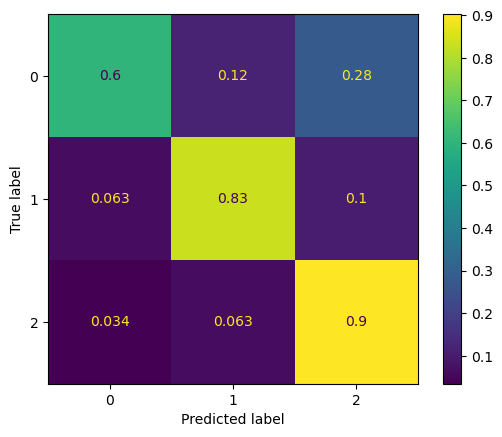

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.72037. Saving Model!
epoch 01, loss: 0.77134, acc: 0.61761, val_loss: 0.72037, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 02, loss: 0.77267, acc: 0.61908, val_loss: 0.72344, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 03, loss: 0.77176, acc: 0.62443, val_loss: 0.72483, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 04, loss: 0.76923, acc: 0.62316, val_loss: 0.72551, val_accuracy: 0.62586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 05, loss: 0.76615, acc: 0.62581, val_loss: 0.72641, val_accuracy: 0.62612


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 06, loss: 0.76325, acc: 0.62405, val_loss: 0.72798, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 07, loss: 0.76099, acc: 0.62460, val_loss: 0.72978, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 08, loss: 0.75914, acc: 0.62628, val_loss: 0.73161, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 09, loss: 0.75775, acc: 0.62672, val_loss: 0.73344, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 10, loss: 0.75668, acc: 0.62845, val_loss: 0.73501, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 11, loss: 0.75566, acc: 0.62454, val_loss: 0.73612, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 12, loss: 0.75450, acc: 0.62346, val_loss: 0.73711, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 13, loss: 0.75333, acc: 0.62340, val_loss: 0.73810, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 14, loss: 0.75224, acc: 0.62328, val_loss: 0.73907, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 15, loss: 0.75115, acc: 0.62296, val_loss: 0.73982, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 16, loss: 0.75008, acc: 0.62581, val_loss: 0.74034, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 17, loss: 0.74903, acc: 0.62781, val_loss: 0.74069, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 18, loss: 0.74802, acc: 0.62784, val_loss: 0.74103, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 19, loss: 0.74703, acc: 0.62786, val_loss: 0.74126, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 20, loss: 0.74603, acc: 0.63262, val_loss: 0.74146, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 21, loss: 0.74502, acc: 0.63280, val_loss: 0.74171, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 22, loss: 0.74415, acc: 0.63312, val_loss: 0.74177, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 23, loss: 0.74331, acc: 0.63306, val_loss: 0.74154, val_accuracy: 0.68006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 24, loss: 0.74221, acc: 0.63321, val_loss: 0.74145, val_accuracy: 0.68006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 25, loss: 0.74122, acc: 0.63480, val_loss: 0.74159, val_accuracy: 0.68059


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 26, loss: 0.74040, acc: 0.63486, val_loss: 0.74151, val_accuracy: 0.68033


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 27, loss: 0.73961, acc: 0.63597, val_loss: 0.74114, val_accuracy: 0.68006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 28, loss: 0.73860, acc: 0.63594, val_loss: 0.74097, val_accuracy: 0.68086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 29, loss: 0.73766, acc: 0.63612, val_loss: 0.74081, val_accuracy: 0.68112


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 30, loss: 0.73683, acc: 0.63612, val_loss: 0.74067, val_accuracy: 0.68139


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 31, loss: 0.73591, acc: 0.63627, val_loss: 0.74053, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 32, loss: 0.73500, acc: 0.63603, val_loss: 0.74038, val_accuracy: 0.68271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 33, loss: 0.73411, acc: 0.63639, val_loss: 0.74012, val_accuracy: 0.68271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 34, loss: 0.73324, acc: 0.63879, val_loss: 0.74002, val_accuracy: 0.68244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 35, loss: 0.73225, acc: 0.63906, val_loss: 0.73995, val_accuracy: 0.68218


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 36, loss: 0.73142, acc: 0.63912, val_loss: 0.73970, val_accuracy: 0.68271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 37, loss: 0.73059, acc: 0.64247, val_loss: 0.73927, val_accuracy: 0.68244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 38, loss: 0.72963, acc: 0.64250, val_loss: 0.73900, val_accuracy: 0.68271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 39, loss: 0.72869, acc: 0.64223, val_loss: 0.73893, val_accuracy: 0.68271


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 40, loss: 0.72791, acc: 0.64053, val_loss: 0.73890, val_accuracy: 0.68694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 41, loss: 0.72715, acc: 0.64047, val_loss: 0.73864, val_accuracy: 0.68747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.20it/s]


epoch 42, loss: 0.72629, acc: 0.63888, val_loss: 0.73850, val_accuracy: 0.68773


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 43, loss: 0.72548, acc: 0.63897, val_loss: 0.73836, val_accuracy: 0.68482


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 44, loss: 0.72468, acc: 0.63918, val_loss: 0.73816, val_accuracy: 0.68509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 45, loss: 0.72375, acc: 0.63923, val_loss: 0.73808, val_accuracy: 0.68429


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 46, loss: 0.72293, acc: 0.63932, val_loss: 0.73792, val_accuracy: 0.68297


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 47, loss: 0.72212, acc: 0.64382, val_loss: 0.73787, val_accuracy: 0.68350


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 48, loss: 0.72125, acc: 0.64399, val_loss: 0.73786, val_accuracy: 0.68324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 49, loss: 0.72045, acc: 0.64308, val_loss: 0.73766, val_accuracy: 0.68350


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 50, loss: 0.71954, acc: 0.64314, val_loss: 0.73747, val_accuracy: 0.68350


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 51, loss: 0.71880, acc: 0.64332, val_loss: 0.73730, val_accuracy: 0.68324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 52, loss: 0.71788, acc: 0.64385, val_loss: 0.73739, val_accuracy: 0.68324


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]


epoch 53, loss: 0.71697, acc: 0.64790, val_loss: 0.73721, val_accuracy: 0.68377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 54, loss: 0.71632, acc: 0.64911, val_loss: 0.73689, val_accuracy: 0.68377


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 55, loss: 0.71544, acc: 0.64875, val_loss: 0.73678, val_accuracy: 0.68429


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 56, loss: 0.71456, acc: 0.64881, val_loss: 0.73676, val_accuracy: 0.68456


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 57, loss: 0.71385, acc: 0.64870, val_loss: 0.73660, val_accuracy: 0.68456


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


epoch 58, loss: 0.71305, acc: 0.65390, val_loss: 0.73629, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 59, loss: 0.71211, acc: 0.65410, val_loss: 0.73614, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 60, loss: 0.71136, acc: 0.65639, val_loss: 0.73609, val_accuracy: 0.68614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 61, loss: 0.71068, acc: 0.65666, val_loss: 0.73578, val_accuracy: 0.68667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 62, loss: 0.70985, acc: 0.66012, val_loss: 0.73555, val_accuracy: 0.68694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 63, loss: 0.70906, acc: 0.66221, val_loss: 0.73528, val_accuracy: 0.68667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 64, loss: 0.70831, acc: 0.66292, val_loss: 0.73521, val_accuracy: 0.68588


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 65, loss: 0.70760, acc: 0.65930, val_loss: 0.73492, val_accuracy: 0.68482


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 66, loss: 0.70679, acc: 0.65945, val_loss: 0.73490, val_accuracy: 0.68429


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 67, loss: 0.70606, acc: 0.65951, val_loss: 0.73448, val_accuracy: 0.68562


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 68, loss: 0.70523, acc: 0.65945, val_loss: 0.73415, val_accuracy: 0.68614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 69, loss: 0.70439, acc: 0.65974, val_loss: 0.73411, val_accuracy: 0.68773


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 70, loss: 0.70378, acc: 0.65971, val_loss: 0.73390, val_accuracy: 0.68800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 71, loss: 0.70300, acc: 0.65886, val_loss: 0.73372, val_accuracy: 0.68800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 72, loss: 0.70217, acc: 0.65827, val_loss: 0.73341, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 73, loss: 0.70148, acc: 0.66324, val_loss: 0.73337, val_accuracy: 0.68614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 74, loss: 0.70082, acc: 0.66342, val_loss: 0.73289, val_accuracy: 0.68614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 75, loss: 0.69993, acc: 0.66383, val_loss: 0.73285, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 76, loss: 0.69917, acc: 0.66365, val_loss: 0.73303, val_accuracy: 0.68667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 77, loss: 0.69848, acc: 0.66330, val_loss: 0.73286, val_accuracy: 0.68694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 78, loss: 0.69778, acc: 0.66512, val_loss: 0.73255, val_accuracy: 0.68694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 79, loss: 0.69688, acc: 0.66638, val_loss: 0.73257, val_accuracy: 0.68720


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s]


epoch 80, loss: 0.69613, acc: 0.66538, val_loss: 0.73256, val_accuracy: 0.68773


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 81, loss: 0.69546, acc: 0.66635, val_loss: 0.73245, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 82, loss: 0.69466, acc: 0.66721, val_loss: 0.73233, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 83, loss: 0.69397, acc: 0.67276, val_loss: 0.73237, val_accuracy: 0.68562


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 84, loss: 0.69340, acc: 0.67317, val_loss: 0.73224, val_accuracy: 0.68535


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 85, loss: 0.69250, acc: 0.67573, val_loss: 0.73221, val_accuracy: 0.68588


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 86, loss: 0.69171, acc: 0.67581, val_loss: 0.73221, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 87, loss: 0.69107, acc: 0.67596, val_loss: 0.73198, val_accuracy: 0.68641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 88, loss: 0.69043, acc: 0.67608, val_loss: 0.73189, val_accuracy: 0.68667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 89, loss: 0.68955, acc: 0.67611, val_loss: 0.73189, val_accuracy: 0.68694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 90, loss: 0.68889, acc: 0.67625, val_loss: 0.73183, val_accuracy: 0.68826


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 91, loss: 0.68830, acc: 0.67664, val_loss: 0.73134, val_accuracy: 0.68879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 92, loss: 0.68740, acc: 0.67908, val_loss: 0.73130, val_accuracy: 0.68879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 93, loss: 0.68675, acc: 0.67825, val_loss: 0.73144, val_accuracy: 0.68852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 94, loss: 0.68613, acc: 0.67908, val_loss: 0.73104, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 95, loss: 0.68526, acc: 0.67916, val_loss: 0.73094, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 96, loss: 0.68453, acc: 0.67937, val_loss: 0.73102, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 97, loss: 0.68396, acc: 0.67960, val_loss: 0.73095, val_accuracy: 0.68958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 98, loss: 0.68329, acc: 0.67972, val_loss: 0.73070, val_accuracy: 0.68985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42it/s]


epoch 99, loss: 0.68267, acc: 0.67978, val_loss: 0.73053, val_accuracy: 0.69011


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.11it/s]


epoch 100, loss: 0.68180, acc: 0.68013, val_loss: 0.73048, val_accuracy: 0.69038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 101, loss: 0.68117, acc: 0.68040, val_loss: 0.73021, val_accuracy: 0.69090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 102, loss: 0.68052, acc: 0.68060, val_loss: 0.73015, val_accuracy: 0.69117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 103, loss: 0.67988, acc: 0.68172, val_loss: 0.73008, val_accuracy: 0.69117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 104, loss: 0.67918, acc: 0.68178, val_loss: 0.72995, val_accuracy: 0.69064


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.46it/s]


epoch 105, loss: 0.67848, acc: 0.68228, val_loss: 0.72991, val_accuracy: 0.69090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 106, loss: 0.67770, acc: 0.68248, val_loss: 0.72980, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 107, loss: 0.67708, acc: 0.68754, val_loss: 0.72974, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 108, loss: 0.67639, acc: 0.68777, val_loss: 0.72962, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 109, loss: 0.67566, acc: 0.68795, val_loss: 0.72966, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 110, loss: 0.67499, acc: 0.68807, val_loss: 0.72937, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 111, loss: 0.67439, acc: 0.68818, val_loss: 0.72938, val_accuracy: 0.68852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 112, loss: 0.67361, acc: 0.68848, val_loss: 0.72966, val_accuracy: 0.68879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 113, loss: 0.67300, acc: 0.68857, val_loss: 0.72965, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 114, loss: 0.67230, acc: 0.68859, val_loss: 0.72925, val_accuracy: 0.68905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 115, loss: 0.67157, acc: 0.68904, val_loss: 0.72927, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 116, loss: 0.67087, acc: 0.68924, val_loss: 0.72950, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 117, loss: 0.67036, acc: 0.68939, val_loss: 0.72941, val_accuracy: 0.68932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 118, loss: 0.66957, acc: 0.68942, val_loss: 0.72913, val_accuracy: 0.68958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 119, loss: 0.66882, acc: 0.68942, val_loss: 0.72954, val_accuracy: 0.68958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 120, loss: 0.66831, acc: 0.68942, val_loss: 0.72986, val_accuracy: 0.68985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 121, loss: 0.66760, acc: 0.68968, val_loss: 0.72971, val_accuracy: 0.69011


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 122, loss: 0.66677, acc: 0.68980, val_loss: 0.72960, val_accuracy: 0.69011


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 123, loss: 0.66629, acc: 0.68971, val_loss: 0.72936, val_accuracy: 0.69038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 124, loss: 0.66539, acc: 0.69000, val_loss: 0.72957, val_accuracy: 0.69038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 125, loss: 0.66476, acc: 0.69015, val_loss: 0.72963, val_accuracy: 0.69038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 126, loss: 0.66418, acc: 0.68998, val_loss: 0.72930, val_accuracy: 0.69038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 127, loss: 0.66354, acc: 0.69033, val_loss: 0.72931, val_accuracy: 0.69196


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 128, loss: 0.66290, acc: 0.69071, val_loss: 0.72929, val_accuracy: 0.69223


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 129, loss: 0.66212, acc: 0.69074, val_loss: 0.72912, val_accuracy: 0.69223


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 130, loss: 0.66148, acc: 0.69083, val_loss: 0.72887, val_accuracy: 0.69276


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 131, loss: 0.66080, acc: 0.69097, val_loss: 0.72903, val_accuracy: 0.69276


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 132, loss: 0.66020, acc: 0.69100, val_loss: 0.72914, val_accuracy: 0.69276


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 133, loss: 0.65949, acc: 0.69362, val_loss: 0.72918, val_accuracy: 0.69302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 134, loss: 0.65874, acc: 0.69365, val_loss: 0.72938, val_accuracy: 0.69302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 135, loss: 0.65826, acc: 0.69374, val_loss: 0.72960, val_accuracy: 0.69302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 136, loss: 0.65760, acc: 0.69374, val_loss: 0.72973, val_accuracy: 0.69355


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 137, loss: 0.65679, acc: 0.69368, val_loss: 0.72978, val_accuracy: 0.69381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 138, loss: 0.65605, acc: 0.69394, val_loss: 0.72972, val_accuracy: 0.69381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 139, loss: 0.65551, acc: 0.69435, val_loss: 0.72948, val_accuracy: 0.69408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 140, loss: 0.65476, acc: 0.69488, val_loss: 0.72983, val_accuracy: 0.69408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 141, loss: 0.65423, acc: 0.69491, val_loss: 0.72965, val_accuracy: 0.69408


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 142, loss: 0.65349, acc: 0.69568, val_loss: 0.72941, val_accuracy: 0.69461


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 143, loss: 0.65280, acc: 0.69588, val_loss: 0.72949, val_accuracy: 0.69513


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 144, loss: 0.65222, acc: 0.69603, val_loss: 0.72955, val_accuracy: 0.69778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 145, loss: 0.65153, acc: 0.69635, val_loss: 0.72957, val_accuracy: 0.69751


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 146, loss: 0.65082, acc: 0.69650, val_loss: 0.72944, val_accuracy: 0.69778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 147, loss: 0.65019, acc: 0.69644, val_loss: 0.72965, val_accuracy: 0.69778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 148, loss: 0.64968, acc: 0.69673, val_loss: 0.72979, val_accuracy: 0.69778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 149, loss: 0.64893, acc: 0.69717, val_loss: 0.72961, val_accuracy: 0.69804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 150, loss: 0.64818, acc: 0.69835, val_loss: 0.72960, val_accuracy: 0.69804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 151, loss: 0.64755, acc: 0.69826, val_loss: 0.72951, val_accuracy: 0.69804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 152, loss: 0.64696, acc: 0.69838, val_loss: 0.72958, val_accuracy: 0.69804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 153, loss: 0.64626, acc: 0.69850, val_loss: 0.72963, val_accuracy: 0.69804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 154, loss: 0.64576, acc: 0.69844, val_loss: 0.72971, val_accuracy: 0.69804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 155, loss: 0.64508, acc: 0.69855, val_loss: 0.72967, val_accuracy: 0.69857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 156, loss: 0.64437, acc: 0.69885, val_loss: 0.72948, val_accuracy: 0.69857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 157, loss: 0.64366, acc: 0.69867, val_loss: 0.72960, val_accuracy: 0.69857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 158, loss: 0.64319, acc: 0.69870, val_loss: 0.72971, val_accuracy: 0.69857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 159, loss: 0.64239, acc: 0.69908, val_loss: 0.72991, val_accuracy: 0.69910


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 160, loss: 0.64195, acc: 0.69911, val_loss: 0.72967, val_accuracy: 0.69910


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 161, loss: 0.64137, acc: 0.70111, val_loss: 0.72937, val_accuracy: 0.69937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 162, loss: 0.64044, acc: 0.70129, val_loss: 0.72975, val_accuracy: 0.69989


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 163, loss: 0.63999, acc: 0.70135, val_loss: 0.73008, val_accuracy: 0.70201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 164, loss: 0.63937, acc: 0.70155, val_loss: 0.73030, val_accuracy: 0.70254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 165, loss: 0.63867, acc: 0.70173, val_loss: 0.73032, val_accuracy: 0.70307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 166, loss: 0.63804, acc: 0.70199, val_loss: 0.73016, val_accuracy: 0.70280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 167, loss: 0.63733, acc: 0.70214, val_loss: 0.73049, val_accuracy: 0.70307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 168, loss: 0.63685, acc: 0.70176, val_loss: 0.73047, val_accuracy: 0.70333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 169, loss: 0.63626, acc: 0.70217, val_loss: 0.73011, val_accuracy: 0.70360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 170, loss: 0.63545, acc: 0.70179, val_loss: 0.73041, val_accuracy: 0.70360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 171, loss: 0.63501, acc: 0.70190, val_loss: 0.73048, val_accuracy: 0.70360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 172, loss: 0.63428, acc: 0.70182, val_loss: 0.73024, val_accuracy: 0.70360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 173, loss: 0.63364, acc: 0.70199, val_loss: 0.73026, val_accuracy: 0.70360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.50it/s]


epoch 174, loss: 0.63307, acc: 0.70208, val_loss: 0.73001, val_accuracy: 0.70412


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 175, loss: 0.63245, acc: 0.70211, val_loss: 0.72976, val_accuracy: 0.70412


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 176, loss: 0.63158, acc: 0.70252, val_loss: 0.72998, val_accuracy: 0.70439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 177, loss: 0.63095, acc: 0.70311, val_loss: 0.73043, val_accuracy: 0.70492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 178, loss: 0.63062, acc: 0.70334, val_loss: 0.73026, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 179, loss: 0.62990, acc: 0.70337, val_loss: 0.73014, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 180, loss: 0.62924, acc: 0.70337, val_loss: 0.73010, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 181, loss: 0.62863, acc: 0.70534, val_loss: 0.72993, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 182, loss: 0.62788, acc: 0.70666, val_loss: 0.73040, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 183, loss: 0.62738, acc: 0.70672, val_loss: 0.73039, val_accuracy: 0.70571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 184, loss: 0.62684, acc: 0.70678, val_loss: 0.73022, val_accuracy: 0.70598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 185, loss: 0.62605, acc: 0.70702, val_loss: 0.73050, val_accuracy: 0.70624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 186, loss: 0.62550, acc: 0.70737, val_loss: 0.73064, val_accuracy: 0.70624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 187, loss: 0.62501, acc: 0.70752, val_loss: 0.73058, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.71it/s]


epoch 188, loss: 0.62427, acc: 0.70669, val_loss: 0.73045, val_accuracy: 0.70703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 189, loss: 0.62357, acc: 0.70816, val_loss: 0.73072, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 190, loss: 0.62306, acc: 0.70813, val_loss: 0.73079, val_accuracy: 0.70703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 191, loss: 0.62242, acc: 0.70684, val_loss: 0.73095, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 192, loss: 0.62185, acc: 0.71181, val_loss: 0.73116, val_accuracy: 0.70756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.96it/s]


epoch 193, loss: 0.62136, acc: 0.71295, val_loss: 0.73092, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 194, loss: 0.62042, acc: 0.71307, val_loss: 0.73141, val_accuracy: 0.70650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 195, loss: 0.62006, acc: 0.71369, val_loss: 0.73161, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 196, loss: 0.61960, acc: 0.71736, val_loss: 0.73125, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 197, loss: 0.61869, acc: 0.71686, val_loss: 0.73155, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 198, loss: 0.61814, acc: 0.71692, val_loss: 0.73175, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 199, loss: 0.61775, acc: 0.71683, val_loss: 0.73163, val_accuracy: 0.70465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 200, loss: 0.61688, acc: 0.71689, val_loss: 0.73201, val_accuracy: 0.70465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


epoch 201, loss: 0.61628, acc: 0.71695, val_loss: 0.73223, val_accuracy: 0.70465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 202, loss: 0.61596, acc: 0.71689, val_loss: 0.73229, val_accuracy: 0.70465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 203, loss: 0.61515, acc: 0.71900, val_loss: 0.73226, val_accuracy: 0.70465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 204, loss: 0.61459, acc: 0.71894, val_loss: 0.73223, val_accuracy: 0.70492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


epoch 205, loss: 0.61412, acc: 0.71912, val_loss: 0.73217, val_accuracy: 0.70492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 206, loss: 0.61332, acc: 0.71924, val_loss: 0.73256, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.51it/s]


epoch 207, loss: 0.61292, acc: 0.71889, val_loss: 0.73278, val_accuracy: 0.70492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.94it/s]


epoch 208, loss: 0.61223, acc: 0.71906, val_loss: 0.73288, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 209, loss: 0.61163, acc: 0.71894, val_loss: 0.73282, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 210, loss: 0.61102, acc: 0.71900, val_loss: 0.73290, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 211, loss: 0.61058, acc: 0.71880, val_loss: 0.73247, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18it/s]


epoch 212, loss: 0.60990, acc: 0.71921, val_loss: 0.73282, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 213, loss: 0.60936, acc: 0.71912, val_loss: 0.73314, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 214, loss: 0.60887, acc: 0.71921, val_loss: 0.73291, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 215, loss: 0.60820, acc: 0.72244, val_loss: 0.73320, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 216, loss: 0.60788, acc: 0.72215, val_loss: 0.73310, val_accuracy: 0.70518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 217, loss: 0.60697, acc: 0.72232, val_loss: 0.73316, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 218, loss: 0.60643, acc: 0.72247, val_loss: 0.73315, val_accuracy: 0.70571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 219, loss: 0.60602, acc: 0.72247, val_loss: 0.73284, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 220, loss: 0.60523, acc: 0.72259, val_loss: 0.73258, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 221, loss: 0.60476, acc: 0.72271, val_loss: 0.73292, val_accuracy: 0.70571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 222, loss: 0.60418, acc: 0.72279, val_loss: 0.73295, val_accuracy: 0.70624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 223, loss: 0.60334, acc: 0.72265, val_loss: 0.73316, val_accuracy: 0.70598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 224, loss: 0.60305, acc: 0.72250, val_loss: 0.73265, val_accuracy: 0.70650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 225, loss: 0.60255, acc: 0.72450, val_loss: 0.73251, val_accuracy: 0.70650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 226, loss: 0.60142, acc: 0.72444, val_loss: 0.73264, val_accuracy: 0.70650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 227, loss: 0.60123, acc: 0.72356, val_loss: 0.73188, val_accuracy: 0.70650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 228, loss: 0.60055, acc: 0.72444, val_loss: 0.73133, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 229, loss: 0.59974, acc: 0.72438, val_loss: 0.73141, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 230, loss: 0.59915, acc: 0.72459, val_loss: 0.73133, val_accuracy: 0.70677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 231, loss: 0.59837, acc: 0.72470, val_loss: 0.73178, val_accuracy: 0.70703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 232, loss: 0.59815, acc: 0.72467, val_loss: 0.73130, val_accuracy: 0.70703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 233, loss: 0.59717, acc: 0.72485, val_loss: 0.73118, val_accuracy: 0.70756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 234, loss: 0.59701, acc: 0.72494, val_loss: 0.73141, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 235, loss: 0.59615, acc: 0.72511, val_loss: 0.73151, val_accuracy: 0.70756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.57it/s]


epoch 236, loss: 0.59562, acc: 0.72523, val_loss: 0.73091, val_accuracy: 0.70783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 237, loss: 0.59495, acc: 0.72517, val_loss: 0.73049, val_accuracy: 0.70809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 238, loss: 0.59438, acc: 0.72538, val_loss: 0.73071, val_accuracy: 0.70862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 239, loss: 0.59364, acc: 0.72558, val_loss: 0.73027, val_accuracy: 0.70836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 240, loss: 0.59320, acc: 0.72550, val_loss: 0.73045, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 241, loss: 0.59271, acc: 0.72576, val_loss: 0.73064, val_accuracy: 0.70915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 242, loss: 0.59197, acc: 0.72564, val_loss: 0.73019, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 243, loss: 0.59143, acc: 0.72664, val_loss: 0.72998, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


epoch 244, loss: 0.59081, acc: 0.72673, val_loss: 0.72992, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 245, loss: 0.59032, acc: 0.72670, val_loss: 0.72966, val_accuracy: 0.71021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 246, loss: 0.58933, acc: 0.72699, val_loss: 0.72985, val_accuracy: 0.71021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 247, loss: 0.58912, acc: 0.72729, val_loss: 0.72950, val_accuracy: 0.71047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 248, loss: 0.58861, acc: 0.72744, val_loss: 0.72966, val_accuracy: 0.71126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 249, loss: 0.58790, acc: 0.72767, val_loss: 0.72892, val_accuracy: 0.71259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 250, loss: 0.58718, acc: 0.72779, val_loss: 0.72901, val_accuracy: 0.71232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 251, loss: 0.58653, acc: 0.72788, val_loss: 0.72979, val_accuracy: 0.71338


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 252, loss: 0.58650, acc: 0.72752, val_loss: 0.72893, val_accuracy: 0.71338


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 253, loss: 0.58560, acc: 0.72796, val_loss: 0.72946, val_accuracy: 0.71311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 254, loss: 0.58495, acc: 0.72829, val_loss: 0.72932, val_accuracy: 0.71364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 255, loss: 0.58468, acc: 0.72846, val_loss: 0.72832, val_accuracy: 0.71391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 256, loss: 0.58379, acc: 0.72870, val_loss: 0.72842, val_accuracy: 0.71364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 257, loss: 0.58329, acc: 0.72893, val_loss: 0.72882, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 258, loss: 0.58289, acc: 0.72896, val_loss: 0.72895, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 259, loss: 0.58233, acc: 0.72929, val_loss: 0.72826, val_accuracy: 0.71364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 260, loss: 0.58142, acc: 0.72946, val_loss: 0.72817, val_accuracy: 0.71391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 261, loss: 0.58125, acc: 0.72964, val_loss: 0.72798, val_accuracy: 0.71417


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 262, loss: 0.58050, acc: 0.72984, val_loss: 0.72782, val_accuracy: 0.71497


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 263, loss: 0.57977, acc: 0.72990, val_loss: 0.72815, val_accuracy: 0.71523


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 264, loss: 0.57952, acc: 0.73076, val_loss: 0.72774, val_accuracy: 0.71549


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 265, loss: 0.57881, acc: 0.72990, val_loss: 0.72713, val_accuracy: 0.71655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 266, loss: 0.57814, acc: 0.72999, val_loss: 0.72696, val_accuracy: 0.71655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 267, loss: 0.57761, acc: 0.73026, val_loss: 0.72742, val_accuracy: 0.71655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 268, loss: 0.57701, acc: 0.73079, val_loss: 0.72713, val_accuracy: 0.71655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 269, loss: 0.57642, acc: 0.73079, val_loss: 0.72633, val_accuracy: 0.71682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 270, loss: 0.57596, acc: 0.73061, val_loss: 0.72634, val_accuracy: 0.71655


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 271, loss: 0.57532, acc: 0.73131, val_loss: 0.72726, val_accuracy: 0.71973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 272, loss: 0.57466, acc: 0.73149, val_loss: 0.72686, val_accuracy: 0.71999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 273, loss: 0.57431, acc: 0.73181, val_loss: 0.72636, val_accuracy: 0.72052


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 274, loss: 0.57360, acc: 0.73211, val_loss: 0.72620, val_accuracy: 0.72263


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 275, loss: 0.57323, acc: 0.73252, val_loss: 0.72636, val_accuracy: 0.72316


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 276, loss: 0.57226, acc: 0.73267, val_loss: 0.72649, val_accuracy: 0.72396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


epoch 277, loss: 0.57203, acc: 0.73302, val_loss: 0.72592, val_accuracy: 0.72448


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 278, loss: 0.57131, acc: 0.73299, val_loss: 0.72508, val_accuracy: 0.72501


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 279, loss: 0.57082, acc: 0.73387, val_loss: 0.72486, val_accuracy: 0.72475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 280, loss: 0.56987, acc: 0.73434, val_loss: 0.72598, val_accuracy: 0.72554


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 281, loss: 0.56978, acc: 0.73434, val_loss: 0.72521, val_accuracy: 0.72554


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 282, loss: 0.56903, acc: 0.73904, val_loss: 0.72453, val_accuracy: 0.72554


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 283, loss: 0.56804, acc: 0.73443, val_loss: 0.72545, val_accuracy: 0.72581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 284, loss: 0.56811, acc: 0.74045, val_loss: 0.72538, val_accuracy: 0.72607


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 285, loss: 0.56700, acc: 0.74083, val_loss: 0.72527, val_accuracy: 0.72634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 286, loss: 0.56688, acc: 0.73983, val_loss: 0.72447, val_accuracy: 0.72686


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.81it/s]


epoch 287, loss: 0.56576, acc: 0.74116, val_loss: 0.72543, val_accuracy: 0.72766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 288, loss: 0.56564, acc: 0.74139, val_loss: 0.72555, val_accuracy: 0.72766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 289, loss: 0.56511, acc: 0.74113, val_loss: 0.72503, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 290, loss: 0.56416, acc: 0.74142, val_loss: 0.72518, val_accuracy: 0.72766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 291, loss: 0.56400, acc: 0.74127, val_loss: 0.72526, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 292, loss: 0.56333, acc: 0.74010, val_loss: 0.72461, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 293, loss: 0.56247, acc: 0.74007, val_loss: 0.72543, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 294, loss: 0.56229, acc: 0.74348, val_loss: 0.72533, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 295, loss: 0.56131, acc: 0.74374, val_loss: 0.72565, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 296, loss: 0.56124, acc: 0.74371, val_loss: 0.72438, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 297, loss: 0.56035, acc: 0.74383, val_loss: 0.72519, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 298, loss: 0.55994, acc: 0.74395, val_loss: 0.72581, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 299, loss: 0.55947, acc: 0.74368, val_loss: 0.72561, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 300, loss: 0.55856, acc: 0.74389, val_loss: 0.72526, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 301, loss: 0.55861, acc: 0.74392, val_loss: 0.72496, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 302, loss: 0.55768, acc: 0.74386, val_loss: 0.72576, val_accuracy: 0.72871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 303, loss: 0.55696, acc: 0.74401, val_loss: 0.72559, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 304, loss: 0.55649, acc: 0.74929, val_loss: 0.72574, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 305, loss: 0.55611, acc: 0.74430, val_loss: 0.72536, val_accuracy: 0.72792


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 306, loss: 0.55526, acc: 0.74935, val_loss: 0.72621, val_accuracy: 0.72819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 307, loss: 0.55505, acc: 0.74950, val_loss: 0.72504, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 308, loss: 0.55448, acc: 0.74962, val_loss: 0.72506, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 309, loss: 0.55362, acc: 0.74974, val_loss: 0.72532, val_accuracy: 0.72845


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 310, loss: 0.55353, acc: 0.74962, val_loss: 0.72558, val_accuracy: 0.72871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.57it/s]


epoch 311, loss: 0.55272, acc: 0.74976, val_loss: 0.72508, val_accuracy: 0.72871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 312, loss: 0.55236, acc: 0.74982, val_loss: 0.72452, val_accuracy: 0.72871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 313, loss: 0.55178, acc: 0.75012, val_loss: 0.72462, val_accuracy: 0.72898


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 314, loss: 0.55121, acc: 0.75018, val_loss: 0.72503, val_accuracy: 0.72871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 315, loss: 0.55096, acc: 0.75006, val_loss: 0.72498, val_accuracy: 0.72871


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 316, loss: 0.55000, acc: 0.75041, val_loss: 0.72512, val_accuracy: 0.72898


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 317, loss: 0.54923, acc: 0.75059, val_loss: 0.72545, val_accuracy: 0.72924


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 318, loss: 0.54946, acc: 0.75038, val_loss: 0.72447, val_accuracy: 0.73109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 319, loss: 0.54819, acc: 0.75094, val_loss: 0.72510, val_accuracy: 0.73480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 320, loss: 0.54837, acc: 0.75244, val_loss: 0.72476, val_accuracy: 0.73109


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 321, loss: 0.54742, acc: 0.75126, val_loss: 0.72512, val_accuracy: 0.73559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 322, loss: 0.54654, acc: 0.75300, val_loss: 0.72530, val_accuracy: 0.73559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 323, loss: 0.54702, acc: 0.75273, val_loss: 0.72487, val_accuracy: 0.73559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 324, loss: 0.54569, acc: 0.75176, val_loss: 0.72606, val_accuracy: 0.73533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 325, loss: 0.54568, acc: 0.75300, val_loss: 0.72535, val_accuracy: 0.73427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 326, loss: 0.54474, acc: 0.75314, val_loss: 0.72458, val_accuracy: 0.73585


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 327, loss: 0.54413, acc: 0.75314, val_loss: 0.72460, val_accuracy: 0.73533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 328, loss: 0.54428, acc: 0.75306, val_loss: 0.72534, val_accuracy: 0.73770


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 329, loss: 0.54297, acc: 0.75373, val_loss: 0.72514, val_accuracy: 0.73770


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 330, loss: 0.54316, acc: 0.75353, val_loss: 0.72516, val_accuracy: 0.73823


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59it/s]


epoch 331, loss: 0.54227, acc: 0.75397, val_loss: 0.72491, val_accuracy: 0.73876


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


epoch 332, loss: 0.54181, acc: 0.75397, val_loss: 0.72545, val_accuracy: 0.73876


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 333, loss: 0.54129, acc: 0.75426, val_loss: 0.72646, val_accuracy: 0.73850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 334, loss: 0.54070, acc: 0.75411, val_loss: 0.72679, val_accuracy: 0.73823


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 335, loss: 0.54057, acc: 0.75438, val_loss: 0.72657, val_accuracy: 0.73823


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 336, loss: 0.53971, acc: 0.75667, val_loss: 0.72660, val_accuracy: 0.73850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 337, loss: 0.53923, acc: 0.75667, val_loss: 0.72683, val_accuracy: 0.70571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 338, loss: 0.53855, acc: 0.75649, val_loss: 0.72722, val_accuracy: 0.70571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


epoch 339, loss: 0.53862, acc: 0.75646, val_loss: 0.72753, val_accuracy: 0.70545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 340, loss: 0.53753, acc: 0.75729, val_loss: 0.72799, val_accuracy: 0.70730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 341, loss: 0.53718, acc: 0.75223, val_loss: 0.72800, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 342, loss: 0.53708, acc: 0.75685, val_loss: 0.72774, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 343, loss: 0.53587, acc: 0.75852, val_loss: 0.72898, val_accuracy: 0.70994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 344, loss: 0.53605, acc: 0.75223, val_loss: 0.72799, val_accuracy: 0.70915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.98it/s]


epoch 345, loss: 0.53524, acc: 0.75729, val_loss: 0.72828, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.27it/s]


epoch 346, loss: 0.53468, acc: 0.75261, val_loss: 0.72920, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 347, loss: 0.53472, acc: 0.75276, val_loss: 0.72838, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 348, loss: 0.53365, acc: 0.75893, val_loss: 0.72957, val_accuracy: 0.70994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 349, loss: 0.53310, acc: 0.75450, val_loss: 0.72936, val_accuracy: 0.70941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 350, loss: 0.53324, acc: 0.75452, val_loss: 0.72891, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 351, loss: 0.53196, acc: 0.75743, val_loss: 0.73037, val_accuracy: 0.71021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 352, loss: 0.53207, acc: 0.75579, val_loss: 0.73032, val_accuracy: 0.70968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 353, loss: 0.53150, acc: 0.75740, val_loss: 0.73107, val_accuracy: 0.71074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 354, loss: 0.53069, acc: 0.75952, val_loss: 0.73197, val_accuracy: 0.71126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 355, loss: 0.53094, acc: 0.75782, val_loss: 0.73074, val_accuracy: 0.71100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 356, loss: 0.52971, acc: 0.75805, val_loss: 0.73206, val_accuracy: 0.71232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 357, loss: 0.52951, acc: 0.75978, val_loss: 0.73229, val_accuracy: 0.71153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 358, loss: 0.52934, acc: 0.75802, val_loss: 0.73197, val_accuracy: 0.71232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 359, loss: 0.52807, acc: 0.76005, val_loss: 0.73322, val_accuracy: 0.71259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 360, loss: 0.52838, acc: 0.75999, val_loss: 0.73283, val_accuracy: 0.71285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 361, loss: 0.52734, acc: 0.76034, val_loss: 0.73255, val_accuracy: 0.71259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 362, loss: 0.52705, acc: 0.76143, val_loss: 0.73416, val_accuracy: 0.71311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 363, loss: 0.52666, acc: 0.76199, val_loss: 0.73389, val_accuracy: 0.71311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 364, loss: 0.52605, acc: 0.76205, val_loss: 0.73367, val_accuracy: 0.71311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 365, loss: 0.52569, acc: 0.76210, val_loss: 0.73375, val_accuracy: 0.71285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 366, loss: 0.52504, acc: 0.76222, val_loss: 0.73465, val_accuracy: 0.71311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 367, loss: 0.52468, acc: 0.76246, val_loss: 0.73505, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 368, loss: 0.52417, acc: 0.76134, val_loss: 0.73468, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 369, loss: 0.52381, acc: 0.76269, val_loss: 0.73585, val_accuracy: 0.71311


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 370, loss: 0.52320, acc: 0.76293, val_loss: 0.73579, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 371, loss: 0.52278, acc: 0.76369, val_loss: 0.73578, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 372, loss: 0.52230, acc: 0.76401, val_loss: 0.73639, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 373, loss: 0.52177, acc: 0.76399, val_loss: 0.73712, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 374, loss: 0.52159, acc: 0.76396, val_loss: 0.73621, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 375, loss: 0.52079, acc: 0.76399, val_loss: 0.73846, val_accuracy: 0.66711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.59it/s]


epoch 376, loss: 0.52058, acc: 0.76448, val_loss: 0.73784, val_accuracy: 0.66631


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 377, loss: 0.51994, acc: 0.76428, val_loss: 0.73920, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 378, loss: 0.51923, acc: 0.76484, val_loss: 0.73974, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.04it/s]


epoch 379, loss: 0.51964, acc: 0.76454, val_loss: 0.73959, val_accuracy: 0.66631


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 380, loss: 0.51837, acc: 0.76478, val_loss: 0.74067, val_accuracy: 0.66631


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 381, loss: 0.51799, acc: 0.76563, val_loss: 0.74103, val_accuracy: 0.66631


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 382, loss: 0.51798, acc: 0.76540, val_loss: 0.74134, val_accuracy: 0.66711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 383, loss: 0.51712, acc: 0.76587, val_loss: 0.74136, val_accuracy: 0.66764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 384, loss: 0.51693, acc: 0.76481, val_loss: 0.74152, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 385, loss: 0.51594, acc: 0.76510, val_loss: 0.74333, val_accuracy: 0.66711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 386, loss: 0.51620, acc: 0.76528, val_loss: 0.74344, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 387, loss: 0.51527, acc: 0.76540, val_loss: 0.74270, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 388, loss: 0.51483, acc: 0.76522, val_loss: 0.74380, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 389, loss: 0.51437, acc: 0.76566, val_loss: 0.74454, val_accuracy: 0.66684


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 390, loss: 0.51402, acc: 0.76678, val_loss: 0.74538, val_accuracy: 0.66737


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 391, loss: 0.51403, acc: 0.76554, val_loss: 0.74503, val_accuracy: 0.66605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 392, loss: 0.51287, acc: 0.76581, val_loss: 0.74654, val_accuracy: 0.66605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 393, loss: 0.51245, acc: 0.76616, val_loss: 0.74655, val_accuracy: 0.66579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 394, loss: 0.51248, acc: 0.76587, val_loss: 0.74665, val_accuracy: 0.66579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06it/s]


epoch 395, loss: 0.51134, acc: 0.76601, val_loss: 0.74911, val_accuracy: 0.66764


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 396, loss: 0.51163, acc: 0.76651, val_loss: 0.74828, val_accuracy: 0.66605


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 397, loss: 0.51092, acc: 0.76675, val_loss: 0.74814, val_accuracy: 0.66631


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 398, loss: 0.50997, acc: 0.76701, val_loss: 0.74986, val_accuracy: 0.66658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 399, loss: 0.51026, acc: 0.76701, val_loss: 0.75060, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 400, loss: 0.50946, acc: 0.76731, val_loss: 0.75024, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 401, loss: 0.50902, acc: 0.76713, val_loss: 0.75026, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 402, loss: 0.50851, acc: 0.76728, val_loss: 0.75172, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 403, loss: 0.50818, acc: 0.76757, val_loss: 0.75268, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 404, loss: 0.50772, acc: 0.76733, val_loss: 0.75358, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 405, loss: 0.50690, acc: 0.76751, val_loss: 0.75433, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 406, loss: 0.50729, acc: 0.76898, val_loss: 0.75354, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 407, loss: 0.50595, acc: 0.76892, val_loss: 0.75534, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 408, loss: 0.50582, acc: 0.76919, val_loss: 0.75744, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 409, loss: 0.50545, acc: 0.76913, val_loss: 0.75589, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 410, loss: 0.50482, acc: 0.76919, val_loss: 0.75596, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 411, loss: 0.50457, acc: 0.76927, val_loss: 0.75726, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 412, loss: 0.50396, acc: 0.76954, val_loss: 0.75722, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 413, loss: 0.50385, acc: 0.76954, val_loss: 0.75714, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 414, loss: 0.50266, acc: 0.76966, val_loss: 0.75887, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 415, loss: 0.50310, acc: 0.77089, val_loss: 0.76082, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 416, loss: 0.50231, acc: 0.76983, val_loss: 0.75987, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 417, loss: 0.50193, acc: 0.77112, val_loss: 0.75995, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 418, loss: 0.50118, acc: 0.77121, val_loss: 0.76140, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 419, loss: 0.50108, acc: 0.77010, val_loss: 0.76219, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 420, loss: 0.50064, acc: 0.77180, val_loss: 0.76232, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 421, loss: 0.49987, acc: 0.77189, val_loss: 0.76403, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.84it/s]


epoch 422, loss: 0.49980, acc: 0.77165, val_loss: 0.76408, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 423, loss: 0.49900, acc: 0.77068, val_loss: 0.76490, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 424, loss: 0.49907, acc: 0.77045, val_loss: 0.76464, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 425, loss: 0.49818, acc: 0.77089, val_loss: 0.76495, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 426, loss: 0.49742, acc: 0.77218, val_loss: 0.76615, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 427, loss: 0.49798, acc: 0.77142, val_loss: 0.76543, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 428, loss: 0.49625, acc: 0.77189, val_loss: 0.76759, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 429, loss: 0.49666, acc: 0.77133, val_loss: 0.76647, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 430, loss: 0.49581, acc: 0.77171, val_loss: 0.76811, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


epoch 431, loss: 0.49517, acc: 0.77186, val_loss: 0.77033, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 432, loss: 0.49520, acc: 0.77159, val_loss: 0.76934, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 433, loss: 0.49430, acc: 0.77180, val_loss: 0.77121, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 434, loss: 0.49411, acc: 0.77192, val_loss: 0.76977, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 435, loss: 0.49385, acc: 0.77195, val_loss: 0.77074, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


epoch 436, loss: 0.49212, acc: 0.77262, val_loss: 0.77320, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 437, loss: 0.49318, acc: 0.77239, val_loss: 0.77265, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 438, loss: 0.49170, acc: 0.77239, val_loss: 0.77294, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 439, loss: 0.49189, acc: 0.77236, val_loss: 0.77346, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 440, loss: 0.49070, acc: 0.77271, val_loss: 0.77553, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 441, loss: 0.49058, acc: 0.77259, val_loss: 0.77744, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 442, loss: 0.48989, acc: 0.77321, val_loss: 0.77798, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 443, loss: 0.48999, acc: 0.77253, val_loss: 0.77747, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 444, loss: 0.48890, acc: 0.77794, val_loss: 0.77828, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 445, loss: 0.48892, acc: 0.77650, val_loss: 0.77677, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 446, loss: 0.48796, acc: 0.77756, val_loss: 0.77815, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 447, loss: 0.48682, acc: 0.77635, val_loss: 0.78081, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 448, loss: 0.48788, acc: 0.77591, val_loss: 0.77871, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


epoch 449, loss: 0.48640, acc: 0.77803, val_loss: 0.77960, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 450, loss: 0.48630, acc: 0.77788, val_loss: 0.78128, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 451, loss: 0.48573, acc: 0.77677, val_loss: 0.78060, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 452, loss: 0.48554, acc: 0.77876, val_loss: 0.78060, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 453, loss: 0.48482, acc: 0.78023, val_loss: 0.78107, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.65it/s]


epoch 454, loss: 0.48469, acc: 0.78020, val_loss: 0.78266, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 455, loss: 0.48349, acc: 0.78061, val_loss: 0.78382, val_accuracy: 0.62586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 456, loss: 0.48407, acc: 0.77970, val_loss: 0.78344, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 457, loss: 0.48323, acc: 0.77938, val_loss: 0.78375, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 458, loss: 0.48265, acc: 0.77882, val_loss: 0.78617, val_accuracy: 0.62586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 459, loss: 0.48189, acc: 0.77944, val_loss: 0.78669, val_accuracy: 0.62692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 460, loss: 0.48261, acc: 0.77953, val_loss: 0.78628, val_accuracy: 0.62586


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 461, loss: 0.48069, acc: 0.78111, val_loss: 0.78840, val_accuracy: 0.62612


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 462, loss: 0.48167, acc: 0.78164, val_loss: 0.78531, val_accuracy: 0.62665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 463, loss: 0.48058, acc: 0.78126, val_loss: 0.78703, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 464, loss: 0.47940, acc: 0.78132, val_loss: 0.79141, val_accuracy: 0.62692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 465, loss: 0.48097, acc: 0.77844, val_loss: 0.78914, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 466, loss: 0.47913, acc: 0.78205, val_loss: 0.78973, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.15it/s]


epoch 467, loss: 0.47878, acc: 0.78170, val_loss: 0.79049, val_accuracy: 0.62665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 468, loss: 0.47822, acc: 0.78150, val_loss: 0.79219, val_accuracy: 0.62692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 469, loss: 0.47860, acc: 0.78006, val_loss: 0.79038, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 470, loss: 0.47717, acc: 0.78229, val_loss: 0.79286, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 471, loss: 0.47725, acc: 0.78188, val_loss: 0.79291, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 472, loss: 0.47710, acc: 0.78593, val_loss: 0.79317, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 473, loss: 0.47550, acc: 0.78414, val_loss: 0.79486, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 474, loss: 0.47658, acc: 0.78517, val_loss: 0.79306, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 475, loss: 0.47500, acc: 0.78596, val_loss: 0.79515, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.57it/s]


epoch 476, loss: 0.47535, acc: 0.78549, val_loss: 0.79561, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 477, loss: 0.47459, acc: 0.78582, val_loss: 0.79714, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 478, loss: 0.47372, acc: 0.78499, val_loss: 0.79788, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 479, loss: 0.47449, acc: 0.78629, val_loss: 0.79612, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 480, loss: 0.47252, acc: 0.78587, val_loss: 0.79940, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 481, loss: 0.47371, acc: 0.78676, val_loss: 0.79915, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 482, loss: 0.47228, acc: 0.78493, val_loss: 0.80144, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 483, loss: 0.47197, acc: 0.78690, val_loss: 0.80336, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 484, loss: 0.47171, acc: 0.78778, val_loss: 0.80284, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 485, loss: 0.47159, acc: 0.78752, val_loss: 0.80319, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 486, loss: 0.47028, acc: 0.78605, val_loss: 0.80551, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 487, loss: 0.47121, acc: 0.78561, val_loss: 0.80583, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 488, loss: 0.46936, acc: 0.78599, val_loss: 0.80837, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.49it/s]


epoch 489, loss: 0.46999, acc: 0.78825, val_loss: 0.80889, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 490, loss: 0.46963, acc: 0.78825, val_loss: 0.80708, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 491, loss: 0.46859, acc: 0.78852, val_loss: 0.80976, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 492, loss: 0.46803, acc: 0.78784, val_loss: 0.80879, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.86it/s]


epoch 493, loss: 0.46853, acc: 0.78981, val_loss: 0.80847, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 494, loss: 0.46769, acc: 0.79046, val_loss: 0.81004, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 495, loss: 0.46687, acc: 0.78984, val_loss: 0.81350, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 496, loss: 0.46667, acc: 0.78761, val_loss: 0.81365, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 497, loss: 0.46694, acc: 0.79043, val_loss: 0.81386, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 498, loss: 0.46568, acc: 0.78893, val_loss: 0.81443, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72it/s]


epoch 499, loss: 0.46592, acc: 0.79104, val_loss: 0.81432, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 500, loss: 0.46498, acc: 0.79104, val_loss: 0.81694, val_accuracy: 0.62507
5번째 교차검증
evaluation loss: 0.72037, evaluation accuracy: 0.62745
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0298494	total: 7.66ms	remaining: 7.65s
1:	learn: 0.9745471	total: 14ms	remaining: 6.98s
2:	learn: 0.9267267	total: 20.2ms	remaining: 6.73s
3:	learn: 0.8865128	total: 28.2ms	remaining: 7.01s
4:	learn: 0.8523720	total: 34.4ms	remaining: 6.84s
5:	learn: 0.8228146	total: 42.1ms	remaining: 6.97s
6:	learn: 0.7967684	total: 50.3ms	remaining: 7.14s
7:	learn: 0.7739373	total: 57.7ms	remaining: 7.15s
8:	learn: 0.7539638	total: 64ms	remaining: 7.05s
9:	learn: 0.7369424	total: 70.8ms	remaining: 7.01s
10:	learn: 0.7210916	total: 78.3ms	remaining: 7.04s
11:	learn: 0.7077857	total: 85ms	remaining: 7s
12:	learn: 0.6942552	total: 92.6ms	remaining: 7.03s
13:	learn: 0.6829469	total: 99.3ms	remaining: 6.99s
14:	learn: 0.6717156	total: 107ms	remaining: 7.02s
15:	learn: 0.6625346	total: 114ms	remaining: 

180:	learn: 0.5457201	total: 1.24s	remaining: 5.6s
181:	learn: 0.5456757	total: 1.25s	remaining: 5.6s
182:	learn: 0.5456209	total: 1.25s	remaining: 5.59s
183:	learn: 0.5455783	total: 1.26s	remaining: 5.59s
184:	learn: 0.5455280	total: 1.27s	remaining: 5.58s
185:	learn: 0.5454771	total: 1.27s	remaining: 5.58s
186:	learn: 0.5454317	total: 1.28s	remaining: 5.58s
187:	learn: 0.5453849	total: 1.29s	remaining: 5.58s
188:	learn: 0.5453391	total: 1.3s	remaining: 5.57s
189:	learn: 0.5452974	total: 1.31s	remaining: 5.57s
190:	learn: 0.5452527	total: 1.31s	remaining: 5.56s
191:	learn: 0.5452057	total: 1.32s	remaining: 5.56s
192:	learn: 0.5451603	total: 1.33s	remaining: 5.55s
193:	learn: 0.5451222	total: 1.34s	remaining: 5.55s
194:	learn: 0.5450849	total: 1.34s	remaining: 5.54s
195:	learn: 0.5450389	total: 1.35s	remaining: 5.54s
196:	learn: 0.5449949	total: 1.36s	remaining: 5.53s
197:	learn: 0.5449521	total: 1.36s	remaining: 5.53s
198:	learn: 0.5449104	total: 1.37s	remaining: 5.52s
199:	learn: 0.5

344:	learn: 0.5419874	total: 2.48s	remaining: 4.7s
345:	learn: 0.5419779	total: 2.48s	remaining: 4.7s
346:	learn: 0.5419700	total: 2.49s	remaining: 4.69s
347:	learn: 0.5419626	total: 2.5s	remaining: 4.68s
348:	learn: 0.5419527	total: 2.51s	remaining: 4.67s
349:	learn: 0.5419396	total: 2.51s	remaining: 4.67s
350:	learn: 0.5419307	total: 2.52s	remaining: 4.66s
351:	learn: 0.5419177	total: 2.53s	remaining: 4.65s
352:	learn: 0.5419067	total: 2.54s	remaining: 4.65s
353:	learn: 0.5418925	total: 2.54s	remaining: 4.64s
354:	learn: 0.5418821	total: 2.55s	remaining: 4.64s
355:	learn: 0.5418732	total: 2.56s	remaining: 4.63s
356:	learn: 0.5418637	total: 2.57s	remaining: 4.63s
357:	learn: 0.5418570	total: 2.58s	remaining: 4.62s
358:	learn: 0.5418473	total: 2.58s	remaining: 4.62s
359:	learn: 0.5418388	total: 2.59s	remaining: 4.61s
360:	learn: 0.5418286	total: 2.6s	remaining: 4.6s
361:	learn: 0.5418196	total: 2.61s	remaining: 4.59s
362:	learn: 0.5418117	total: 2.62s	remaining: 4.59s
363:	learn: 0.541

527:	learn: 0.5407960	total: 3.91s	remaining: 3.5s
528:	learn: 0.5407914	total: 3.92s	remaining: 3.49s
529:	learn: 0.5407847	total: 3.93s	remaining: 3.48s
530:	learn: 0.5407822	total: 3.94s	remaining: 3.48s
531:	learn: 0.5407758	total: 3.94s	remaining: 3.47s
532:	learn: 0.5407719	total: 3.95s	remaining: 3.46s
533:	learn: 0.5407673	total: 3.96s	remaining: 3.46s
534:	learn: 0.5407622	total: 3.97s	remaining: 3.45s
535:	learn: 0.5407580	total: 3.98s	remaining: 3.44s
536:	learn: 0.5407547	total: 3.98s	remaining: 3.44s
537:	learn: 0.5407517	total: 3.99s	remaining: 3.43s
538:	learn: 0.5407486	total: 4s	remaining: 3.42s
539:	learn: 0.5407437	total: 4.01s	remaining: 3.42s
540:	learn: 0.5407409	total: 4.02s	remaining: 3.41s
541:	learn: 0.5407372	total: 4.02s	remaining: 3.4s
542:	learn: 0.5407341	total: 4.03s	remaining: 3.4s
543:	learn: 0.5407293	total: 4.04s	remaining: 3.39s
544:	learn: 0.5407254	total: 4.05s	remaining: 3.38s
545:	learn: 0.5407211	total: 4.06s	remaining: 3.37s
546:	learn: 0.5407

699:	learn: 0.5402736	total: 5.36s	remaining: 2.3s
700:	learn: 0.5402711	total: 5.37s	remaining: 2.29s
701:	learn: 0.5402694	total: 5.38s	remaining: 2.28s
702:	learn: 0.5402671	total: 5.38s	remaining: 2.27s
703:	learn: 0.5402643	total: 5.39s	remaining: 2.27s
704:	learn: 0.5402614	total: 5.4s	remaining: 2.26s
705:	learn: 0.5402602	total: 5.41s	remaining: 2.25s
706:	learn: 0.5402574	total: 5.42s	remaining: 2.25s
707:	learn: 0.5402558	total: 5.43s	remaining: 2.24s
708:	learn: 0.5402536	total: 5.44s	remaining: 2.23s
709:	learn: 0.5402502	total: 5.45s	remaining: 2.23s
710:	learn: 0.5402476	total: 5.46s	remaining: 2.22s
711:	learn: 0.5402450	total: 5.46s	remaining: 2.21s
712:	learn: 0.5402432	total: 5.48s	remaining: 2.2s
713:	learn: 0.5402419	total: 5.48s	remaining: 2.2s
714:	learn: 0.5402401	total: 5.49s	remaining: 2.19s
715:	learn: 0.5402383	total: 5.5s	remaining: 2.18s
716:	learn: 0.5402367	total: 5.51s	remaining: 2.17s
717:	learn: 0.5402336	total: 5.52s	remaining: 2.17s
718:	learn: 0.540

867:	learn: 0.5399909	total: 6.82s	remaining: 1.04s
868:	learn: 0.5399895	total: 6.83s	remaining: 1.03s
869:	learn: 0.5399873	total: 6.84s	remaining: 1.02s
870:	learn: 0.5399853	total: 6.85s	remaining: 1.01s
871:	learn: 0.5399840	total: 6.85s	remaining: 1.01s
872:	learn: 0.5399828	total: 6.86s	remaining: 999ms
873:	learn: 0.5399814	total: 6.87s	remaining: 991ms
874:	learn: 0.5399794	total: 6.88s	remaining: 983ms
875:	learn: 0.5399777	total: 6.89s	remaining: 975ms
876:	learn: 0.5399769	total: 6.9s	remaining: 968ms
877:	learn: 0.5399751	total: 6.91s	remaining: 960ms
878:	learn: 0.5399737	total: 6.92s	remaining: 953ms
879:	learn: 0.5399722	total: 6.93s	remaining: 945ms
880:	learn: 0.5399712	total: 6.94s	remaining: 937ms
881:	learn: 0.5399691	total: 6.95s	remaining: 930ms
882:	learn: 0.5399679	total: 6.96s	remaining: 922ms
883:	learn: 0.5399668	total: 6.97s	remaining: 914ms
884:	learn: 0.5399650	total: 6.98s	remaining: 907ms
885:	learn: 0.5399637	total: 6.99s	remaining: 899ms
886:	learn: 0

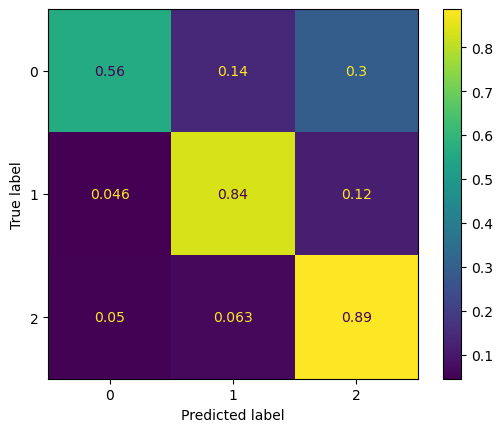

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.77004. Saving Model!
epoch 01, loss: 0.76843, acc: 0.62278, val_loss: 0.77004, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 02, loss: 0.76946, acc: 0.62073, val_loss: 0.77007, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


[INFO] val_acc has been improved from 0.77004 to 0.76931. Saving Model!
epoch 03, loss: 0.76735, acc: 0.62099, val_loss: 0.76931, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


[INFO] val_acc has been improved from 0.76931 to 0.76836. Saving Model!
epoch 04, loss: 0.76403, acc: 0.62310, val_loss: 0.76836, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.76836 to 0.76750. Saving Model!
epoch 05, loss: 0.76081, acc: 0.62299, val_loss: 0.76750, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


[INFO] val_acc has been improved from 0.76750 to 0.76680. Saving Model!
epoch 06, loss: 0.75850, acc: 0.62249, val_loss: 0.76680, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.76680 to 0.76629. Saving Model!
epoch 07, loss: 0.75674, acc: 0.62155, val_loss: 0.76629, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.76629 to 0.76595. Saving Model!
epoch 08, loss: 0.75509, acc: 0.62945, val_loss: 0.76595, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


[INFO] val_acc has been improved from 0.76595 to 0.76568. Saving Model!
epoch 09, loss: 0.75364, acc: 0.64053, val_loss: 0.76568, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.76568 to 0.76527. Saving Model!
epoch 10, loss: 0.75236, acc: 0.64059, val_loss: 0.76527, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.76527 to 0.76486. Saving Model!
epoch 11, loss: 0.75093, acc: 0.64056, val_loss: 0.76486, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


[INFO] val_acc has been improved from 0.76486 to 0.76447. Saving Model!
epoch 12, loss: 0.74965, acc: 0.64073, val_loss: 0.76447, val_accuracy: 0.62665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


[INFO] val_acc has been improved from 0.76447 to 0.76416. Saving Model!
epoch 13, loss: 0.74845, acc: 0.64085, val_loss: 0.76416, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


[INFO] val_acc has been improved from 0.76416 to 0.76390. Saving Model!
epoch 14, loss: 0.74723, acc: 0.64135, val_loss: 0.76390, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


[INFO] val_acc has been improved from 0.76390 to 0.76371. Saving Model!
epoch 15, loss: 0.74604, acc: 0.64173, val_loss: 0.76371, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


[INFO] val_acc has been improved from 0.76371 to 0.76358. Saving Model!
epoch 16, loss: 0.74499, acc: 0.64197, val_loss: 0.76358, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


[INFO] val_acc has been improved from 0.76358 to 0.76349. Saving Model!
epoch 17, loss: 0.74389, acc: 0.64235, val_loss: 0.76349, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.76349 to 0.76338. Saving Model!
epoch 18, loss: 0.74273, acc: 0.64297, val_loss: 0.76338, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


[INFO] val_acc has been improved from 0.76338 to 0.76329. Saving Model!
epoch 19, loss: 0.74166, acc: 0.64314, val_loss: 0.76329, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.76329 to 0.76314. Saving Model!
epoch 20, loss: 0.74055, acc: 0.64053, val_loss: 0.76314, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.76314 to 0.76299. Saving Model!
epoch 21, loss: 0.73955, acc: 0.64009, val_loss: 0.76299, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.76299 to 0.76285. Saving Model!
epoch 22, loss: 0.73835, acc: 0.64305, val_loss: 0.76285, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.76285 to 0.76263. Saving Model!
epoch 23, loss: 0.73731, acc: 0.64355, val_loss: 0.76263, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


[INFO] val_acc has been improved from 0.76263 to 0.76259. Saving Model!
epoch 24, loss: 0.73616, acc: 0.64391, val_loss: 0.76259, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


[INFO] val_acc has been improved from 0.76259 to 0.76251. Saving Model!
epoch 25, loss: 0.73521, acc: 0.64502, val_loss: 0.76251, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.76251 to 0.76235. Saving Model!
epoch 26, loss: 0.73416, acc: 0.64526, val_loss: 0.76235, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


[INFO] val_acc has been improved from 0.76235 to 0.76224. Saving Model!
epoch 27, loss: 0.73319, acc: 0.64543, val_loss: 0.76224, val_accuracy: 0.63591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


[INFO] val_acc has been improved from 0.76224 to 0.76211. Saving Model!
epoch 28, loss: 0.73226, acc: 0.64567, val_loss: 0.76211, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


[INFO] val_acc has been improved from 0.76211 to 0.76201. Saving Model!
epoch 29, loss: 0.73113, acc: 0.64573, val_loss: 0.76201, val_accuracy: 0.63696


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


[INFO] val_acc has been improved from 0.76201 to 0.76189. Saving Model!
epoch 30, loss: 0.73015, acc: 0.64731, val_loss: 0.76189, val_accuracy: 0.63696


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


[INFO] val_acc has been improved from 0.76189 to 0.76182. Saving Model!
epoch 31, loss: 0.72935, acc: 0.64749, val_loss: 0.76182, val_accuracy: 0.63723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


[INFO] val_acc has been improved from 0.76182 to 0.76165. Saving Model!
epoch 32, loss: 0.72822, acc: 0.64743, val_loss: 0.76165, val_accuracy: 0.63749


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


[INFO] val_acc has been improved from 0.76165 to 0.76147. Saving Model!
epoch 33, loss: 0.72718, acc: 0.64828, val_loss: 0.76147, val_accuracy: 0.63723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.76147 to 0.76139. Saving Model!
epoch 34, loss: 0.72620, acc: 0.64872, val_loss: 0.76139, val_accuracy: 0.63723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


[INFO] val_acc has been improved from 0.76139 to 0.76123. Saving Model!
epoch 35, loss: 0.72526, acc: 0.64896, val_loss: 0.76123, val_accuracy: 0.63723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.76123 to 0.76110. Saving Model!
epoch 36, loss: 0.72429, acc: 0.64928, val_loss: 0.76110, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


[INFO] val_acc has been improved from 0.76110 to 0.76093. Saving Model!
epoch 37, loss: 0.72349, acc: 0.64958, val_loss: 0.76093, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


[INFO] val_acc has been improved from 0.76093 to 0.76072. Saving Model!
epoch 38, loss: 0.72266, acc: 0.64952, val_loss: 0.76072, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


[INFO] val_acc has been improved from 0.76072 to 0.76064. Saving Model!
epoch 39, loss: 0.72142, acc: 0.65387, val_loss: 0.76064, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


[INFO] val_acc has been improved from 0.76064 to 0.76059. Saving Model!
epoch 40, loss: 0.72047, acc: 0.65398, val_loss: 0.76059, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


[INFO] val_acc has been improved from 0.76059 to 0.76038. Saving Model!
epoch 41, loss: 0.71958, acc: 0.65416, val_loss: 0.76038, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


[INFO] val_acc has been improved from 0.76038 to 0.76015. Saving Model!
epoch 42, loss: 0.71869, acc: 0.65416, val_loss: 0.76015, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


[INFO] val_acc has been improved from 0.76015 to 0.76004. Saving Model!
epoch 43, loss: 0.71778, acc: 0.65360, val_loss: 0.76004, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


[INFO] val_acc has been improved from 0.76004 to 0.76002. Saving Model!
epoch 44, loss: 0.71690, acc: 0.65375, val_loss: 0.76002, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


[INFO] val_acc has been improved from 0.76002 to 0.75999. Saving Model!
epoch 45, loss: 0.71587, acc: 0.65375, val_loss: 0.75999, val_accuracy: 0.59889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


[INFO] val_acc has been improved from 0.75999 to 0.75993. Saving Model!
epoch 46, loss: 0.71510, acc: 0.65725, val_loss: 0.75993, val_accuracy: 0.60048


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


[INFO] val_acc has been improved from 0.75993 to 0.75984. Saving Model!
epoch 47, loss: 0.71403, acc: 0.65689, val_loss: 0.75984, val_accuracy: 0.60127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


[INFO] val_acc has been improved from 0.75984 to 0.75963. Saving Model!
epoch 48, loss: 0.71322, acc: 0.65695, val_loss: 0.75963, val_accuracy: 0.60153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


[INFO] val_acc has been improved from 0.75963 to 0.75952. Saving Model!
epoch 49, loss: 0.71245, acc: 0.65692, val_loss: 0.75952, val_accuracy: 0.60206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


[INFO] val_acc has been improved from 0.75952 to 0.75946. Saving Model!
epoch 50, loss: 0.71147, acc: 0.65719, val_loss: 0.75946, val_accuracy: 0.60259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


[INFO] val_acc has been improved from 0.75946 to 0.75946. Saving Model!
epoch 51, loss: 0.71053, acc: 0.65710, val_loss: 0.75946, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


[INFO] val_acc has been improved from 0.75946 to 0.75943. Saving Model!
epoch 52, loss: 0.70978, acc: 0.65760, val_loss: 0.75943, val_accuracy: 0.60762


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


[INFO] val_acc has been improved from 0.75943 to 0.75930. Saving Model!
epoch 53, loss: 0.70888, acc: 0.65645, val_loss: 0.75930, val_accuracy: 0.60867


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.75930 to 0.75905. Saving Model!
epoch 54, loss: 0.70817, acc: 0.65651, val_loss: 0.75905, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


epoch 55, loss: 0.70728, acc: 0.65898, val_loss: 0.75906, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 56, loss: 0.70622, acc: 0.65907, val_loss: 0.75914, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


[INFO] val_acc has been improved from 0.75905 to 0.75892. Saving Model!
epoch 57, loss: 0.70549, acc: 0.65848, val_loss: 0.75892, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


[INFO] val_acc has been improved from 0.75892 to 0.75875. Saving Model!
epoch 58, loss: 0.70473, acc: 0.65874, val_loss: 0.75875, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.75875 to 0.75875. Saving Model!
epoch 59, loss: 0.70371, acc: 0.65963, val_loss: 0.75875, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


[INFO] val_acc has been improved from 0.75875 to 0.75867. Saving Model!
epoch 60, loss: 0.70289, acc: 0.65951, val_loss: 0.75867, val_accuracy: 0.61264


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


[INFO] val_acc has been improved from 0.75867 to 0.75842. Saving Model!
epoch 61, loss: 0.70198, acc: 0.65995, val_loss: 0.75842, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


[INFO] val_acc has been improved from 0.75842 to 0.75826. Saving Model!
epoch 62, loss: 0.70122, acc: 0.66051, val_loss: 0.75826, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


[INFO] val_acc has been improved from 0.75826 to 0.75820. Saving Model!
epoch 63, loss: 0.70029, acc: 0.66074, val_loss: 0.75820, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 64, loss: 0.69933, acc: 0.66098, val_loss: 0.75823, val_accuracy: 0.61475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


[INFO] val_acc has been improved from 0.75820 to 0.75816. Saving Model!
epoch 65, loss: 0.69862, acc: 0.66547, val_loss: 0.75816, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


[INFO] val_acc has been improved from 0.75816 to 0.75804. Saving Model!
epoch 66, loss: 0.69768, acc: 0.66556, val_loss: 0.75804, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


[INFO] val_acc has been improved from 0.75804 to 0.75789. Saving Model!
epoch 67, loss: 0.69694, acc: 0.66562, val_loss: 0.75789, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


[INFO] val_acc has been improved from 0.75789 to 0.75779. Saving Model!
epoch 68, loss: 0.69609, acc: 0.66568, val_loss: 0.75779, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


[INFO] val_acc has been improved from 0.75779 to 0.75774. Saving Model!
epoch 69, loss: 0.69503, acc: 0.66671, val_loss: 0.75774, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


[INFO] val_acc has been improved from 0.75774 to 0.75762. Saving Model!
epoch 70, loss: 0.69448, acc: 0.66662, val_loss: 0.75762, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


[INFO] val_acc has been improved from 0.75762 to 0.75752. Saving Model!
epoch 71, loss: 0.69354, acc: 0.66691, val_loss: 0.75752, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 72, loss: 0.69243, acc: 0.66706, val_loss: 0.75755, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


[INFO] val_acc has been improved from 0.75752 to 0.75750. Saving Model!
epoch 73, loss: 0.69204, acc: 0.66712, val_loss: 0.75750, val_accuracy: 0.61475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


[INFO] val_acc has been improved from 0.75750 to 0.75736. Saving Model!
epoch 74, loss: 0.69111, acc: 0.66809, val_loss: 0.75736, val_accuracy: 0.61475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.75736 to 0.75730. Saving Model!
epoch 75, loss: 0.69004, acc: 0.66829, val_loss: 0.75730, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


[INFO] val_acc has been improved from 0.75730 to 0.75720. Saving Model!
epoch 76, loss: 0.68929, acc: 0.66829, val_loss: 0.75720, val_accuracy: 0.61449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


[INFO] val_acc has been improved from 0.75720 to 0.75708. Saving Model!
epoch 77, loss: 0.68864, acc: 0.66844, val_loss: 0.75708, val_accuracy: 0.61475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 78, loss: 0.68779, acc: 0.66853, val_loss: 0.75711, val_accuracy: 0.61502


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


[INFO] val_acc has been improved from 0.75708 to 0.75705. Saving Model!
epoch 79, loss: 0.68690, acc: 0.67020, val_loss: 0.75705, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


[INFO] val_acc has been improved from 0.75705 to 0.75702. Saving Model!
epoch 80, loss: 0.68609, acc: 0.67558, val_loss: 0.75702, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


[INFO] val_acc has been improved from 0.75702 to 0.75696. Saving Model!
epoch 81, loss: 0.68515, acc: 0.67576, val_loss: 0.75696, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


[INFO] val_acc has been improved from 0.75696 to 0.75691. Saving Model!
epoch 82, loss: 0.68438, acc: 0.67828, val_loss: 0.75691, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


[INFO] val_acc has been improved from 0.75691 to 0.75683. Saving Model!
epoch 83, loss: 0.68373, acc: 0.67863, val_loss: 0.75683, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 84, loss: 0.68270, acc: 0.68002, val_loss: 0.75688, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 85, loss: 0.68198, acc: 0.67999, val_loss: 0.75695, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 86, loss: 0.68111, acc: 0.68007, val_loss: 0.75691, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


[INFO] val_acc has been improved from 0.75683 to 0.75672. Saving Model!
epoch 87, loss: 0.68042, acc: 0.68060, val_loss: 0.75672, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 88, loss: 0.67965, acc: 0.68072, val_loss: 0.75685, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 89, loss: 0.67851, acc: 0.68148, val_loss: 0.75702, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 90, loss: 0.67790, acc: 0.68031, val_loss: 0.75697, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 91, loss: 0.67721, acc: 0.68054, val_loss: 0.75696, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 92, loss: 0.67632, acc: 0.68075, val_loss: 0.75700, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 93, loss: 0.67529, acc: 0.68195, val_loss: 0.75698, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 94, loss: 0.67472, acc: 0.68210, val_loss: 0.75695, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 95, loss: 0.67381, acc: 0.68231, val_loss: 0.75706, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 96, loss: 0.67269, acc: 0.68225, val_loss: 0.75714, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 97, loss: 0.67222, acc: 0.68242, val_loss: 0.75715, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 98, loss: 0.67137, acc: 0.68257, val_loss: 0.75719, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 99, loss: 0.67074, acc: 0.68269, val_loss: 0.75732, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


epoch 100, loss: 0.66995, acc: 0.68442, val_loss: 0.75749, val_accuracy: 0.61687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 101, loss: 0.66900, acc: 0.68445, val_loss: 0.75752, val_accuracy: 0.61766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 102, loss: 0.66841, acc: 0.68457, val_loss: 0.75751, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 103, loss: 0.66739, acc: 0.68566, val_loss: 0.75759, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 104, loss: 0.66669, acc: 0.68551, val_loss: 0.75782, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 105, loss: 0.66591, acc: 0.68771, val_loss: 0.75784, val_accuracy: 0.61819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 106, loss: 0.66525, acc: 0.68780, val_loss: 0.75787, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 107, loss: 0.66435, acc: 0.68809, val_loss: 0.75807, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 108, loss: 0.66343, acc: 0.68824, val_loss: 0.75835, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 109, loss: 0.66280, acc: 0.68827, val_loss: 0.75825, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 110, loss: 0.66229, acc: 0.68848, val_loss: 0.75819, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 111, loss: 0.66123, acc: 0.68854, val_loss: 0.75845, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 112, loss: 0.66043, acc: 0.69124, val_loss: 0.75869, val_accuracy: 0.57483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 113, loss: 0.65978, acc: 0.69074, val_loss: 0.75883, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 114, loss: 0.65903, acc: 0.69059, val_loss: 0.75894, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 115, loss: 0.65804, acc: 0.69080, val_loss: 0.75912, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 116, loss: 0.65734, acc: 0.68968, val_loss: 0.75924, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 117, loss: 0.65695, acc: 0.69030, val_loss: 0.75920, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 118, loss: 0.65588, acc: 0.69045, val_loss: 0.75929, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 119, loss: 0.65492, acc: 0.69103, val_loss: 0.75943, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 120, loss: 0.65454, acc: 0.69097, val_loss: 0.75949, val_accuracy: 0.57509


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 121, loss: 0.65391, acc: 0.69118, val_loss: 0.75972, val_accuracy: 0.57536


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 122, loss: 0.65268, acc: 0.69180, val_loss: 0.76009, val_accuracy: 0.57483


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 123, loss: 0.65203, acc: 0.69233, val_loss: 0.76012, val_accuracy: 0.57562


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 124, loss: 0.65170, acc: 0.69224, val_loss: 0.76013, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 125, loss: 0.65030, acc: 0.69250, val_loss: 0.76059, val_accuracy: 0.57589


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 126, loss: 0.64994, acc: 0.69494, val_loss: 0.76081, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 127, loss: 0.64910, acc: 0.69526, val_loss: 0.76098, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 128, loss: 0.64844, acc: 0.69526, val_loss: 0.76112, val_accuracy: 0.57615


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 129, loss: 0.64767, acc: 0.69535, val_loss: 0.76113, val_accuracy: 0.57589


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 130, loss: 0.64669, acc: 0.69538, val_loss: 0.76141, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 131, loss: 0.64604, acc: 0.69559, val_loss: 0.76164, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 132, loss: 0.64555, acc: 0.69568, val_loss: 0.76159, val_accuracy: 0.57668


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 133, loss: 0.64455, acc: 0.69570, val_loss: 0.76188, val_accuracy: 0.57721


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 134, loss: 0.64388, acc: 0.69568, val_loss: 0.76207, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 135, loss: 0.64318, acc: 0.69573, val_loss: 0.76219, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 136, loss: 0.64232, acc: 0.69659, val_loss: 0.76260, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 137, loss: 0.64168, acc: 0.69662, val_loss: 0.76283, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.71it/s]


epoch 138, loss: 0.64087, acc: 0.69685, val_loss: 0.76292, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 139, loss: 0.64027, acc: 0.69697, val_loss: 0.76310, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 140, loss: 0.63937, acc: 0.69700, val_loss: 0.76347, val_accuracy: 0.57906


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.79it/s]


epoch 141, loss: 0.63846, acc: 0.69717, val_loss: 0.76382, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 142, loss: 0.63802, acc: 0.69717, val_loss: 0.76406, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 143, loss: 0.63744, acc: 0.69735, val_loss: 0.76415, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 144, loss: 0.63632, acc: 0.70164, val_loss: 0.76444, val_accuracy: 0.57641


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 145, loss: 0.63564, acc: 0.70746, val_loss: 0.76471, val_accuracy: 0.57694


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 146, loss: 0.63486, acc: 0.70757, val_loss: 0.76488, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 147, loss: 0.63443, acc: 0.70699, val_loss: 0.76487, val_accuracy: 0.57747


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 148, loss: 0.63338, acc: 0.70628, val_loss: 0.76519, val_accuracy: 0.57774


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 149, loss: 0.63244, acc: 0.70663, val_loss: 0.76564, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 150, loss: 0.63242, acc: 0.70655, val_loss: 0.76556, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 151, loss: 0.63118, acc: 0.70652, val_loss: 0.76591, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 152, loss: 0.63054, acc: 0.70658, val_loss: 0.76631, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 153, loss: 0.63008, acc: 0.70649, val_loss: 0.76644, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 154, loss: 0.62897, acc: 0.70625, val_loss: 0.76688, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.96it/s]


epoch 155, loss: 0.62838, acc: 0.70619, val_loss: 0.76707, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 156, loss: 0.62776, acc: 0.70640, val_loss: 0.76725, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 157, loss: 0.62694, acc: 0.70622, val_loss: 0.76736, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 158, loss: 0.62608, acc: 0.70640, val_loss: 0.76770, val_accuracy: 0.57800


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 159, loss: 0.62578, acc: 0.70649, val_loss: 0.76803, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 160, loss: 0.62462, acc: 0.70696, val_loss: 0.76834, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


epoch 161, loss: 0.62424, acc: 0.70684, val_loss: 0.76858, val_accuracy: 0.57853


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 162, loss: 0.62338, acc: 0.70719, val_loss: 0.76906, val_accuracy: 0.57879


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 163, loss: 0.62244, acc: 0.70728, val_loss: 0.76934, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 164, loss: 0.62203, acc: 0.70757, val_loss: 0.76967, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 165, loss: 0.62117, acc: 0.71154, val_loss: 0.76988, val_accuracy: 0.57959


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 166, loss: 0.62037, acc: 0.71160, val_loss: 0.77043, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 167, loss: 0.61974, acc: 0.71169, val_loss: 0.77070, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 168, loss: 0.61907, acc: 0.71692, val_loss: 0.77105, val_accuracy: 0.57827


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 169, loss: 0.61839, acc: 0.71815, val_loss: 0.77139, val_accuracy: 0.57932


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.86it/s]


epoch 170, loss: 0.61736, acc: 0.71850, val_loss: 0.77190, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 171, loss: 0.61698, acc: 0.71845, val_loss: 0.77226, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 172, loss: 0.61661, acc: 0.71842, val_loss: 0.77265, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 173, loss: 0.61524, acc: 0.71968, val_loss: 0.77337, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 174, loss: 0.61473, acc: 0.71991, val_loss: 0.77382, val_accuracy: 0.57985


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 175, loss: 0.61415, acc: 0.72006, val_loss: 0.77381, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 176, loss: 0.61331, acc: 0.71939, val_loss: 0.77420, val_accuracy: 0.58038


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 177, loss: 0.61265, acc: 0.71944, val_loss: 0.77458, val_accuracy: 0.58012


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 178, loss: 0.61211, acc: 0.71974, val_loss: 0.77495, val_accuracy: 0.58091


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 179, loss: 0.61082, acc: 0.72006, val_loss: 0.77544, val_accuracy: 0.58117


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 180, loss: 0.61042, acc: 0.72009, val_loss: 0.77589, val_accuracy: 0.58144


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 181, loss: 0.61002, acc: 0.72024, val_loss: 0.77641, val_accuracy: 0.58144


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 182, loss: 0.60905, acc: 0.72033, val_loss: 0.77721, val_accuracy: 0.58144


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 183, loss: 0.60810, acc: 0.72041, val_loss: 0.77773, val_accuracy: 0.58144


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 184, loss: 0.60786, acc: 0.72083, val_loss: 0.77789, val_accuracy: 0.58197


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 185, loss: 0.60728, acc: 0.72103, val_loss: 0.77820, val_accuracy: 0.58250


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 186, loss: 0.60596, acc: 0.72153, val_loss: 0.77893, val_accuracy: 0.58620


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 187, loss: 0.60573, acc: 0.72379, val_loss: 0.77904, val_accuracy: 0.58620


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 188, loss: 0.60507, acc: 0.72359, val_loss: 0.77954, val_accuracy: 0.58699


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 189, loss: 0.60392, acc: 0.72382, val_loss: 0.78024, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 190, loss: 0.60345, acc: 0.72464, val_loss: 0.78060, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 191, loss: 0.60281, acc: 0.72503, val_loss: 0.78060, val_accuracy: 0.58778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 192, loss: 0.60193, acc: 0.72491, val_loss: 0.78103, val_accuracy: 0.58858


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 193, loss: 0.60115, acc: 0.72514, val_loss: 0.78158, val_accuracy: 0.58858


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 194, loss: 0.60088, acc: 0.72523, val_loss: 0.78183, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 195, loss: 0.59982, acc: 0.72550, val_loss: 0.78256, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.87it/s]


epoch 196, loss: 0.59903, acc: 0.72553, val_loss: 0.78334, val_accuracy: 0.58911


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 197, loss: 0.59872, acc: 0.72594, val_loss: 0.78350, val_accuracy: 0.58937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.39it/s]


epoch 198, loss: 0.59765, acc: 0.72603, val_loss: 0.78404, val_accuracy: 0.58937


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s]


epoch 199, loss: 0.59739, acc: 0.72626, val_loss: 0.78440, val_accuracy: 0.58964


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 200, loss: 0.59615, acc: 0.72638, val_loss: 0.78522, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 201, loss: 0.59587, acc: 0.72720, val_loss: 0.78586, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.44it/s]


epoch 202, loss: 0.59506, acc: 0.72720, val_loss: 0.78646, val_accuracy: 0.59096


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 203, loss: 0.59446, acc: 0.72843, val_loss: 0.78691, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 204, loss: 0.59364, acc: 0.72867, val_loss: 0.78758, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 205, loss: 0.59325, acc: 0.73002, val_loss: 0.78793, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.61it/s]


epoch 206, loss: 0.59216, acc: 0.73008, val_loss: 0.78868, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 207, loss: 0.59191, acc: 0.73026, val_loss: 0.78914, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 208, loss: 0.59110, acc: 0.73052, val_loss: 0.78986, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 209, loss: 0.59014, acc: 0.73040, val_loss: 0.79060, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 210, loss: 0.58984, acc: 0.73055, val_loss: 0.79131, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 211, loss: 0.58889, acc: 0.73126, val_loss: 0.79222, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 212, loss: 0.58831, acc: 0.73137, val_loss: 0.79240, val_accuracy: 0.59281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 213, loss: 0.58769, acc: 0.73143, val_loss: 0.79301, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 214, loss: 0.58711, acc: 0.73137, val_loss: 0.79376, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06it/s]


epoch 215, loss: 0.58620, acc: 0.73134, val_loss: 0.79441, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 216, loss: 0.58561, acc: 0.73164, val_loss: 0.79518, val_accuracy: 0.59281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 217, loss: 0.58512, acc: 0.73175, val_loss: 0.79519, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 218, loss: 0.58423, acc: 0.73220, val_loss: 0.79558, val_accuracy: 0.59360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 219, loss: 0.58337, acc: 0.73228, val_loss: 0.79674, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.81it/s]


epoch 220, loss: 0.58308, acc: 0.73181, val_loss: 0.79724, val_accuracy: 0.59360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


epoch 221, loss: 0.58207, acc: 0.73217, val_loss: 0.79813, val_accuracy: 0.59360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 222, loss: 0.58178, acc: 0.73269, val_loss: 0.79865, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 223, loss: 0.58090, acc: 0.73337, val_loss: 0.79956, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 224, loss: 0.58038, acc: 0.73522, val_loss: 0.80016, val_accuracy: 0.59360


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18it/s]


epoch 225, loss: 0.57940, acc: 0.73543, val_loss: 0.80078, val_accuracy: 0.55473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 226, loss: 0.57936, acc: 0.73772, val_loss: 0.80129, val_accuracy: 0.55473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s]


epoch 227, loss: 0.57816, acc: 0.73798, val_loss: 0.80230, val_accuracy: 0.55447


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 228, loss: 0.57768, acc: 0.73816, val_loss: 0.80290, val_accuracy: 0.55473


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 229, loss: 0.57726, acc: 0.73831, val_loss: 0.80354, val_accuracy: 0.55500


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 230, loss: 0.57648, acc: 0.73822, val_loss: 0.80442, val_accuracy: 0.55500


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 231, loss: 0.57555, acc: 0.73834, val_loss: 0.80516, val_accuracy: 0.55526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 232, loss: 0.57530, acc: 0.73837, val_loss: 0.80602, val_accuracy: 0.55526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.42it/s]


epoch 233, loss: 0.57460, acc: 0.73866, val_loss: 0.80637, val_accuracy: 0.55553


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 234, loss: 0.57359, acc: 0.73919, val_loss: 0.80735, val_accuracy: 0.55553


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 235, loss: 0.57344, acc: 0.73898, val_loss: 0.80800, val_accuracy: 0.55553


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 236, loss: 0.57268, acc: 0.73936, val_loss: 0.80894, val_accuracy: 0.55553


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 237, loss: 0.57183, acc: 0.73948, val_loss: 0.80995, val_accuracy: 0.55526


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 238, loss: 0.57174, acc: 0.73966, val_loss: 0.81041, val_accuracy: 0.55579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 239, loss: 0.57053, acc: 0.74045, val_loss: 0.81147, val_accuracy: 0.55579


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 240, loss: 0.57009, acc: 0.73972, val_loss: 0.81225, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 241, loss: 0.56979, acc: 0.73983, val_loss: 0.81283, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.47it/s]


epoch 242, loss: 0.56863, acc: 0.73992, val_loss: 0.81384, val_accuracy: 0.55632


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 243, loss: 0.56849, acc: 0.74060, val_loss: 0.81454, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 244, loss: 0.56742, acc: 0.74080, val_loss: 0.81538, val_accuracy: 0.55711


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 245, loss: 0.56726, acc: 0.74110, val_loss: 0.81604, val_accuracy: 0.55658


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.91it/s]


epoch 246, loss: 0.56640, acc: 0.74107, val_loss: 0.81689, val_accuracy: 0.55843


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 247, loss: 0.56615, acc: 0.74142, val_loss: 0.81733, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.47it/s]


epoch 248, loss: 0.56502, acc: 0.74174, val_loss: 0.81848, val_accuracy: 0.55976


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 249, loss: 0.56462, acc: 0.74201, val_loss: 0.81942, val_accuracy: 0.55949


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 250, loss: 0.56452, acc: 0.74357, val_loss: 0.81954, val_accuracy: 0.56002


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 251, loss: 0.56319, acc: 0.74386, val_loss: 0.82046, val_accuracy: 0.56108


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 252, loss: 0.56288, acc: 0.74412, val_loss: 0.82177, val_accuracy: 0.56081


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 253, loss: 0.56257, acc: 0.74415, val_loss: 0.82227, val_accuracy: 0.56187


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 254, loss: 0.56172, acc: 0.74445, val_loss: 0.82306, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 255, loss: 0.56093, acc: 0.74471, val_loss: 0.82394, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 256, loss: 0.56041, acc: 0.74501, val_loss: 0.82479, val_accuracy: 0.56240


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 257, loss: 0.55994, acc: 0.74521, val_loss: 0.82568, val_accuracy: 0.56267


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 258, loss: 0.55925, acc: 0.74553, val_loss: 0.82628, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 259, loss: 0.55926, acc: 0.74606, val_loss: 0.82690, val_accuracy: 0.56319


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 260, loss: 0.55775, acc: 0.74609, val_loss: 0.82844, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 261, loss: 0.55768, acc: 0.74662, val_loss: 0.82886, val_accuracy: 0.56399


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 262, loss: 0.55704, acc: 0.74824, val_loss: 0.82971, val_accuracy: 0.60656


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 263, loss: 0.55611, acc: 0.75332, val_loss: 0.83055, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 264, loss: 0.55567, acc: 0.75341, val_loss: 0.83113, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 265, loss: 0.55510, acc: 0.75338, val_loss: 0.83235, val_accuracy: 0.60894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 266, loss: 0.55473, acc: 0.75350, val_loss: 0.83290, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 267, loss: 0.55375, acc: 0.75391, val_loss: 0.83393, val_accuracy: 0.61026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 268, loss: 0.55312, acc: 0.75388, val_loss: 0.83543, val_accuracy: 0.61026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 269, loss: 0.55303, acc: 0.75397, val_loss: 0.83545, val_accuracy: 0.61185


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 270, loss: 0.55198, acc: 0.75391, val_loss: 0.83598, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35it/s]


epoch 271, loss: 0.55139, acc: 0.75896, val_loss: 0.83711, val_accuracy: 0.60894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 272, loss: 0.55102, acc: 0.75361, val_loss: 0.83779, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 273, loss: 0.55015, acc: 0.75338, val_loss: 0.83913, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 274, loss: 0.54972, acc: 0.75009, val_loss: 0.84040, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 275, loss: 0.54933, acc: 0.74891, val_loss: 0.84101, val_accuracy: 0.60894


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 276, loss: 0.54866, acc: 0.75388, val_loss: 0.84163, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 277, loss: 0.54778, acc: 0.75447, val_loss: 0.84268, val_accuracy: 0.60999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 278, loss: 0.54712, acc: 0.75488, val_loss: 0.84379, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 279, loss: 0.54693, acc: 0.75502, val_loss: 0.84514, val_accuracy: 0.60973


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 280, loss: 0.54613, acc: 0.75526, val_loss: 0.84616, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 281, loss: 0.54565, acc: 0.75605, val_loss: 0.84705, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 282, loss: 0.54518, acc: 0.75714, val_loss: 0.84767, val_accuracy: 0.61237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 283, loss: 0.54441, acc: 0.75735, val_loss: 0.84841, val_accuracy: 0.61237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 284, loss: 0.54383, acc: 0.75787, val_loss: 0.84911, val_accuracy: 0.61264


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 285, loss: 0.54318, acc: 0.75834, val_loss: 0.85060, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 286, loss: 0.54304, acc: 0.75834, val_loss: 0.85127, val_accuracy: 0.61317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 287, loss: 0.54227, acc: 0.75961, val_loss: 0.85201, val_accuracy: 0.61317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 288, loss: 0.54153, acc: 0.75967, val_loss: 0.85300, val_accuracy: 0.61317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 289, loss: 0.54123, acc: 0.75961, val_loss: 0.85404, val_accuracy: 0.61317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 290, loss: 0.54031, acc: 0.75964, val_loss: 0.85530, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 291, loss: 0.54026, acc: 0.75485, val_loss: 0.85520, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 292, loss: 0.53943, acc: 0.75497, val_loss: 0.85640, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 293, loss: 0.53873, acc: 0.75499, val_loss: 0.85732, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 294, loss: 0.53860, acc: 0.75497, val_loss: 0.85769, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 295, loss: 0.53757, acc: 0.75497, val_loss: 0.85919, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 296, loss: 0.53720, acc: 0.75508, val_loss: 0.86071, val_accuracy: 0.61766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 297, loss: 0.53684, acc: 0.75523, val_loss: 0.86133, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 298, loss: 0.53596, acc: 0.75555, val_loss: 0.86218, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 299, loss: 0.53550, acc: 0.75576, val_loss: 0.86328, val_accuracy: 0.61819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 300, loss: 0.53508, acc: 0.75591, val_loss: 0.86420, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.55it/s]


epoch 301, loss: 0.53455, acc: 0.75573, val_loss: 0.86469, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 302, loss: 0.53397, acc: 0.75576, val_loss: 0.86549, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 303, loss: 0.53303, acc: 0.75611, val_loss: 0.86629, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 304, loss: 0.53306, acc: 0.75593, val_loss: 0.86689, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 305, loss: 0.53245, acc: 0.75958, val_loss: 0.86776, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 306, loss: 0.53135, acc: 0.75978, val_loss: 0.86928, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 307, loss: 0.53128, acc: 0.75999, val_loss: 0.87016, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 308, loss: 0.53080, acc: 0.76061, val_loss: 0.87024, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.04it/s]


epoch 309, loss: 0.53000, acc: 0.76055, val_loss: 0.87139, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 310, loss: 0.52962, acc: 0.76081, val_loss: 0.87237, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 311, loss: 0.52899, acc: 0.76354, val_loss: 0.87350, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 312, loss: 0.52853, acc: 0.76114, val_loss: 0.87461, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 313, loss: 0.52809, acc: 0.76122, val_loss: 0.87518, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.31it/s]


epoch 314, loss: 0.52731, acc: 0.76134, val_loss: 0.87628, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 315, loss: 0.52692, acc: 0.76425, val_loss: 0.87703, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 316, loss: 0.52649, acc: 0.76413, val_loss: 0.87819, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 317, loss: 0.52599, acc: 0.76434, val_loss: 0.87933, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 318, loss: 0.52508, acc: 0.76437, val_loss: 0.88014, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 319, loss: 0.52482, acc: 0.76451, val_loss: 0.88082, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.59it/s]


epoch 320, loss: 0.52424, acc: 0.76454, val_loss: 0.88134, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 321, loss: 0.52384, acc: 0.76478, val_loss: 0.88200, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 322, loss: 0.52330, acc: 0.76493, val_loss: 0.88389, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 323, loss: 0.52288, acc: 0.76454, val_loss: 0.88515, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 324, loss: 0.52223, acc: 0.76460, val_loss: 0.88617, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 325, loss: 0.52183, acc: 0.76510, val_loss: 0.88671, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 326, loss: 0.52125, acc: 0.76595, val_loss: 0.88719, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 327, loss: 0.52070, acc: 0.76604, val_loss: 0.88800, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 328, loss: 0.52014, acc: 0.76601, val_loss: 0.88923, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 329, loss: 0.51968, acc: 0.76613, val_loss: 0.88975, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 330, loss: 0.51934, acc: 0.76613, val_loss: 0.89095, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 331, loss: 0.51874, acc: 0.77136, val_loss: 0.89163, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 332, loss: 0.51821, acc: 0.77136, val_loss: 0.89221, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 333, loss: 0.51752, acc: 0.77136, val_loss: 0.89314, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 334, loss: 0.51682, acc: 0.77168, val_loss: 0.89465, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 335, loss: 0.51701, acc: 0.77165, val_loss: 0.89457, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 336, loss: 0.51586, acc: 0.77174, val_loss: 0.89489, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 337, loss: 0.51530, acc: 0.77186, val_loss: 0.89645, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


epoch 338, loss: 0.51540, acc: 0.77183, val_loss: 0.89717, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 339, loss: 0.51416, acc: 0.77271, val_loss: 0.89882, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 340, loss: 0.51411, acc: 0.77230, val_loss: 0.90015, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 341, loss: 0.51353, acc: 0.77227, val_loss: 0.90168, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 342, loss: 0.51324, acc: 0.77230, val_loss: 0.90214, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 343, loss: 0.51241, acc: 0.77303, val_loss: 0.90310, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 344, loss: 0.51182, acc: 0.77259, val_loss: 0.90376, val_accuracy: 0.61740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 345, loss: 0.51178, acc: 0.77262, val_loss: 0.90531, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 346, loss: 0.51113, acc: 0.77283, val_loss: 0.90599, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 347, loss: 0.51016, acc: 0.77292, val_loss: 0.90703, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 348, loss: 0.51001, acc: 0.77295, val_loss: 0.90827, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 349, loss: 0.50916, acc: 0.77315, val_loss: 0.90939, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 350, loss: 0.50942, acc: 0.77309, val_loss: 0.90991, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 351, loss: 0.50819, acc: 0.77318, val_loss: 0.91098, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 352, loss: 0.50774, acc: 0.77327, val_loss: 0.91252, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 353, loss: 0.50748, acc: 0.77389, val_loss: 0.91381, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 354, loss: 0.50729, acc: 0.77403, val_loss: 0.91536, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 355, loss: 0.50651, acc: 0.77421, val_loss: 0.91602, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 356, loss: 0.50573, acc: 0.77421, val_loss: 0.91684, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 357, loss: 0.50587, acc: 0.77421, val_loss: 0.91776, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 358, loss: 0.50474, acc: 0.77433, val_loss: 0.91912, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.97it/s]


epoch 359, loss: 0.50464, acc: 0.77444, val_loss: 0.92085, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 360, loss: 0.50448, acc: 0.77436, val_loss: 0.92152, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 361, loss: 0.50314, acc: 0.77494, val_loss: 0.92347, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 362, loss: 0.50341, acc: 0.77486, val_loss: 0.92362, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 363, loss: 0.50227, acc: 0.77524, val_loss: 0.92530, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 364, loss: 0.50240, acc: 0.77515, val_loss: 0.92596, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 365, loss: 0.50159, acc: 0.77544, val_loss: 0.92708, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 366, loss: 0.50101, acc: 0.77547, val_loss: 0.92891, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 367, loss: 0.50106, acc: 0.77577, val_loss: 0.92916, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 368, loss: 0.50001, acc: 0.77583, val_loss: 0.93055, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 369, loss: 0.49990, acc: 0.77635, val_loss: 0.93122, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 370, loss: 0.49933, acc: 0.77618, val_loss: 0.93288, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 371, loss: 0.49902, acc: 0.77644, val_loss: 0.93373, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 372, loss: 0.49828, acc: 0.77653, val_loss: 0.93473, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 373, loss: 0.49780, acc: 0.77674, val_loss: 0.93531, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 374, loss: 0.49742, acc: 0.77829, val_loss: 0.93736, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 375, loss: 0.49702, acc: 0.77835, val_loss: 0.93861, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 376, loss: 0.49642, acc: 0.77841, val_loss: 0.93998, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 377, loss: 0.49599, acc: 0.77868, val_loss: 0.94088, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 378, loss: 0.49561, acc: 0.77853, val_loss: 0.94147, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 379, loss: 0.49502, acc: 0.77859, val_loss: 0.94261, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 380, loss: 0.49421, acc: 0.77935, val_loss: 0.94370, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 381, loss: 0.49420, acc: 0.77956, val_loss: 0.94453, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 382, loss: 0.49378, acc: 0.77967, val_loss: 0.94587, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 383, loss: 0.49312, acc: 0.77985, val_loss: 0.94655, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 384, loss: 0.49231, acc: 0.78003, val_loss: 0.94858, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 385, loss: 0.49253, acc: 0.77991, val_loss: 0.94931, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 386, loss: 0.49150, acc: 0.77982, val_loss: 0.95106, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 387, loss: 0.49111, acc: 0.78006, val_loss: 0.95175, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 388, loss: 0.49084, acc: 0.77994, val_loss: 0.95246, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 389, loss: 0.49003, acc: 0.78009, val_loss: 0.95364, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 390, loss: 0.49021, acc: 0.78129, val_loss: 0.95485, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 391, loss: 0.48884, acc: 0.78032, val_loss: 0.95641, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 392, loss: 0.48929, acc: 0.78026, val_loss: 0.95693, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 393, loss: 0.48813, acc: 0.78288, val_loss: 0.95857, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 394, loss: 0.48753, acc: 0.78308, val_loss: 0.96073, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 395, loss: 0.48785, acc: 0.78294, val_loss: 0.96027, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 396, loss: 0.48651, acc: 0.78305, val_loss: 0.96249, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 397, loss: 0.48703, acc: 0.78311, val_loss: 0.96267, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 398, loss: 0.48552, acc: 0.78317, val_loss: 0.96397, val_accuracy: 0.62348


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 399, loss: 0.48543, acc: 0.78223, val_loss: 0.96487, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 400, loss: 0.48531, acc: 0.78346, val_loss: 0.96598, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 401, loss: 0.48442, acc: 0.78341, val_loss: 0.96825, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 402, loss: 0.48443, acc: 0.78358, val_loss: 0.96850, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 403, loss: 0.48306, acc: 0.78405, val_loss: 0.97031, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 404, loss: 0.48356, acc: 0.78399, val_loss: 0.97003, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 405, loss: 0.48249, acc: 0.78399, val_loss: 0.97195, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 406, loss: 0.48205, acc: 0.78417, val_loss: 0.97339, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 407, loss: 0.48182, acc: 0.78417, val_loss: 0.97524, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 408, loss: 0.48160, acc: 0.78955, val_loss: 0.97567, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 409, loss: 0.48046, acc: 0.78993, val_loss: 0.97712, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 410, loss: 0.48063, acc: 0.78523, val_loss: 0.97731, val_accuracy: 0.62718


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 411, loss: 0.47960, acc: 0.79049, val_loss: 0.97918, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 412, loss: 0.47945, acc: 0.79066, val_loss: 0.97941, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 413, loss: 0.47871, acc: 0.79078, val_loss: 0.98086, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 414, loss: 0.47881, acc: 0.78649, val_loss: 0.98178, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 415, loss: 0.47792, acc: 0.79099, val_loss: 0.98327, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 416, loss: 0.47759, acc: 0.79128, val_loss: 0.98390, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 417, loss: 0.47696, acc: 0.79113, val_loss: 0.98581, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 418, loss: 0.47701, acc: 0.79143, val_loss: 0.98594, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 419, loss: 0.47586, acc: 0.79143, val_loss: 0.98771, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.08it/s]


epoch 420, loss: 0.47570, acc: 0.79163, val_loss: 0.98850, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 421, loss: 0.47542, acc: 0.79210, val_loss: 0.99022, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 422, loss: 0.47487, acc: 0.79222, val_loss: 0.99082, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 423, loss: 0.47424, acc: 0.79201, val_loss: 0.99180, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 424, loss: 0.47416, acc: 0.79201, val_loss: 0.99235, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 425, loss: 0.47326, acc: 0.79748, val_loss: 0.99345, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 426, loss: 0.47309, acc: 0.79760, val_loss: 0.99500, val_accuracy: 0.62718


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 427, loss: 0.47224, acc: 0.79880, val_loss: 0.99661, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 428, loss: 0.47237, acc: 0.79868, val_loss: 0.99697, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 429, loss: 0.47182, acc: 0.79892, val_loss: 0.99820, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 430, loss: 0.47083, acc: 0.79874, val_loss: 0.99889, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 431, loss: 0.47076, acc: 0.79871, val_loss: 0.99993, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 432, loss: 0.47026, acc: 0.79865, val_loss: 1.00097, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 433, loss: 0.46986, acc: 0.79865, val_loss: 1.00132, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 434, loss: 0.46905, acc: 0.79886, val_loss: 1.00292, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 435, loss: 0.46912, acc: 0.79877, val_loss: 1.00433, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 436, loss: 0.46822, acc: 0.79877, val_loss: 1.00491, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 437, loss: 0.46794, acc: 0.79898, val_loss: 1.00666, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 438, loss: 0.46783, acc: 0.79921, val_loss: 1.00702, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 439, loss: 0.46704, acc: 0.79898, val_loss: 1.00877, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 440, loss: 0.46624, acc: 0.79930, val_loss: 1.01058, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 441, loss: 0.46679, acc: 0.79912, val_loss: 1.01030, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 442, loss: 0.46548, acc: 0.79912, val_loss: 1.01167, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 443, loss: 0.46541, acc: 0.79927, val_loss: 1.01368, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 444, loss: 0.46487, acc: 0.79945, val_loss: 1.01553, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 445, loss: 0.46456, acc: 0.79927, val_loss: 1.01642, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 446, loss: 0.46419, acc: 0.79945, val_loss: 1.01694, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 447, loss: 0.46292, acc: 0.79942, val_loss: 1.01940, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 448, loss: 0.46368, acc: 0.79959, val_loss: 1.01984, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 449, loss: 0.46234, acc: 0.80001, val_loss: 1.02159, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 450, loss: 0.46260, acc: 0.80015, val_loss: 1.02153, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 451, loss: 0.46172, acc: 0.80004, val_loss: 1.02228, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 452, loss: 0.46129, acc: 0.80024, val_loss: 1.02278, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 453, loss: 0.46097, acc: 0.80004, val_loss: 1.02386, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 454, loss: 0.46028, acc: 0.79989, val_loss: 1.02554, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 455, loss: 0.46026, acc: 0.80012, val_loss: 1.02686, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 456, loss: 0.45948, acc: 0.80024, val_loss: 1.02914, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 457, loss: 0.45915, acc: 0.80039, val_loss: 1.02914, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 458, loss: 0.45852, acc: 0.80027, val_loss: 1.03027, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 459, loss: 0.45845, acc: 0.80068, val_loss: 1.03139, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 460, loss: 0.45804, acc: 0.80080, val_loss: 1.03239, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 461, loss: 0.45723, acc: 0.80106, val_loss: 1.03439, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 462, loss: 0.45723, acc: 0.80089, val_loss: 1.03627, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 463, loss: 0.45603, acc: 0.80142, val_loss: 1.03835, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 464, loss: 0.45674, acc: 0.80130, val_loss: 1.03674, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 465, loss: 0.45568, acc: 0.80183, val_loss: 1.03805, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 466, loss: 0.45508, acc: 0.80189, val_loss: 1.04142, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 467, loss: 0.45528, acc: 0.80159, val_loss: 1.04214, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 468, loss: 0.45405, acc: 0.80192, val_loss: 1.04377, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 469, loss: 0.45474, acc: 0.80233, val_loss: 1.04294, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 470, loss: 0.45329, acc: 0.80244, val_loss: 1.04581, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 471, loss: 0.45300, acc: 0.80283, val_loss: 1.04729, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 472, loss: 0.45321, acc: 0.80247, val_loss: 1.04808, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 473, loss: 0.45235, acc: 0.80274, val_loss: 1.04992, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 474, loss: 0.45195, acc: 0.80309, val_loss: 1.05173, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 475, loss: 0.45148, acc: 0.80312, val_loss: 1.05351, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 476, loss: 0.45155, acc: 0.80315, val_loss: 1.05368, val_accuracy: 0.63221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 477, loss: 0.45020, acc: 0.80283, val_loss: 1.05595, val_accuracy: 0.63247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 478, loss: 0.45062, acc: 0.80330, val_loss: 1.05637, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 479, loss: 0.45002, acc: 0.80324, val_loss: 1.05717, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 480, loss: 0.44943, acc: 0.80347, val_loss: 1.05813, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 481, loss: 0.44920, acc: 0.80318, val_loss: 1.05992, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 482, loss: 0.44842, acc: 0.80356, val_loss: 1.06202, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 483, loss: 0.44827, acc: 0.80403, val_loss: 1.06288, val_accuracy: 0.63273


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 484, loss: 0.44775, acc: 0.80400, val_loss: 1.06464, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 485, loss: 0.44723, acc: 0.80432, val_loss: 1.06595, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 486, loss: 0.44746, acc: 0.80415, val_loss: 1.06725, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 487, loss: 0.44679, acc: 0.80447, val_loss: 1.06832, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 488, loss: 0.44554, acc: 0.80500, val_loss: 1.07068, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 489, loss: 0.44633, acc: 0.80450, val_loss: 1.07139, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 490, loss: 0.44508, acc: 0.80509, val_loss: 1.07460, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 491, loss: 0.44545, acc: 0.80515, val_loss: 1.07377, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 492, loss: 0.44437, acc: 0.80509, val_loss: 1.07579, val_accuracy: 0.63432


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 493, loss: 0.44391, acc: 0.80547, val_loss: 1.07737, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 494, loss: 0.44426, acc: 0.80562, val_loss: 1.07730, val_accuracy: 0.63379


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20it/s]


epoch 495, loss: 0.44293, acc: 0.80582, val_loss: 1.07807, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 496, loss: 0.44288, acc: 0.80568, val_loss: 1.07994, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 497, loss: 0.44272, acc: 0.80562, val_loss: 1.08103, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 498, loss: 0.44179, acc: 0.80606, val_loss: 1.08388, val_accuracy: 0.63458


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 499, loss: 0.44198, acc: 0.80591, val_loss: 1.08384, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 500, loss: 0.44145, acc: 0.80612, val_loss: 1.08577, val_accuracy: 0.63353
6번째 교차검증
evaluation loss: 0.75672, evaluation accuracy: 0.61581
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0350215	total: 7.5ms	remaining: 7.5s
1:	learn: 0.9832182	total: 14.1ms	remaining: 7.05s
2:	learn: 0.9394622	total: 20.4ms	remaining: 6.78s
3:	learn: 0.9031304	total: 29.3ms	remaining: 7.3s
4:	learn: 0.8715643	total: 36.9ms	remaining: 7.34s
5:	learn: 0.8448196	total: 44ms	remaining: 7.28s
6:	learn: 0.8211717	total: 51ms	remaining: 7.24s
7:	learn: 0.8002501	total: 57.3ms	remaining: 7.11s
8:	learn: 0.7819613	total: 63.9ms	remaining: 7.04s
9:	learn: 0.7663548	total: 70.5ms	remaining: 6.98s
10:	learn: 0.7521117	total: 77.7ms	remaining: 6.98s
11:	learn: 0.7393307	total: 84.1ms	remaining: 6.93s
12:	learn: 0.7280834	total: 90.6ms	remaining: 6.88s
13:	learn: 0.7184974	total: 97.6ms	remaining: 6.87s
14:	learn: 0.7095441	total: 104ms	remaining: 6.82s
15:	learn: 0.7020691	total: 111ms	remaining

170:	learn: 0.6031455	total: 1.03s	remaining: 5s
171:	learn: 0.6030679	total: 1.04s	remaining: 5s
172:	learn: 0.6029842	total: 1.05s	remaining: 5s
173:	learn: 0.6029077	total: 1.05s	remaining: 5s
174:	learn: 0.6028373	total: 1.06s	remaining: 4.99s
175:	learn: 0.6027496	total: 1.06s	remaining: 4.99s
176:	learn: 0.6027008	total: 1.07s	remaining: 4.98s
177:	learn: 0.6026409	total: 1.08s	remaining: 4.98s
178:	learn: 0.6025759	total: 1.08s	remaining: 4.97s
179:	learn: 0.6025304	total: 1.09s	remaining: 4.97s
180:	learn: 0.6024781	total: 1.1s	remaining: 4.97s
181:	learn: 0.6024350	total: 1.1s	remaining: 4.96s
182:	learn: 0.6023841	total: 1.11s	remaining: 4.96s
183:	learn: 0.6023358	total: 1.12s	remaining: 4.96s
184:	learn: 0.6022976	total: 1.13s	remaining: 4.96s
185:	learn: 0.6022280	total: 1.13s	remaining: 4.96s
186:	learn: 0.6021715	total: 1.14s	remaining: 4.95s
187:	learn: 0.6021020	total: 1.15s	remaining: 4.95s
188:	learn: 0.6020346	total: 1.15s	remaining: 4.95s
189:	learn: 0.6019749	tota

354:	learn: 0.5974605	total: 2.27s	remaining: 4.13s
355:	learn: 0.5974503	total: 2.28s	remaining: 4.13s
356:	learn: 0.5974418	total: 2.29s	remaining: 4.12s
357:	learn: 0.5974274	total: 2.3s	remaining: 4.12s
358:	learn: 0.5974130	total: 2.3s	remaining: 4.11s
359:	learn: 0.5973964	total: 2.31s	remaining: 4.11s
360:	learn: 0.5973860	total: 2.32s	remaining: 4.1s
361:	learn: 0.5973725	total: 2.32s	remaining: 4.09s
362:	learn: 0.5973630	total: 2.33s	remaining: 4.09s
363:	learn: 0.5973529	total: 2.33s	remaining: 4.08s
364:	learn: 0.5973376	total: 2.34s	remaining: 4.07s
365:	learn: 0.5973222	total: 2.35s	remaining: 4.07s
366:	learn: 0.5973135	total: 2.35s	remaining: 4.06s
367:	learn: 0.5973023	total: 2.36s	remaining: 4.06s
368:	learn: 0.5972926	total: 2.37s	remaining: 4.05s
369:	learn: 0.5972689	total: 2.38s	remaining: 4.04s
370:	learn: 0.5972614	total: 2.38s	remaining: 4.04s
371:	learn: 0.5972523	total: 2.39s	remaining: 4.04s
372:	learn: 0.5972383	total: 2.4s	remaining: 4.03s
373:	learn: 0.59

521:	learn: 0.5961449	total: 3.51s	remaining: 3.21s
522:	learn: 0.5961415	total: 3.52s	remaining: 3.21s
523:	learn: 0.5961371	total: 3.53s	remaining: 3.2s
524:	learn: 0.5961339	total: 3.53s	remaining: 3.2s
525:	learn: 0.5961249	total: 3.54s	remaining: 3.19s
526:	learn: 0.5961206	total: 3.55s	remaining: 3.19s
527:	learn: 0.5961143	total: 3.56s	remaining: 3.18s
528:	learn: 0.5961060	total: 3.56s	remaining: 3.17s
529:	learn: 0.5961023	total: 3.57s	remaining: 3.17s
530:	learn: 0.5960965	total: 3.58s	remaining: 3.16s
531:	learn: 0.5960932	total: 3.59s	remaining: 3.16s
532:	learn: 0.5960893	total: 3.6s	remaining: 3.15s
533:	learn: 0.5960831	total: 3.6s	remaining: 3.15s
534:	learn: 0.5960775	total: 3.61s	remaining: 3.14s
535:	learn: 0.5960706	total: 3.62s	remaining: 3.13s
536:	learn: 0.5960672	total: 3.63s	remaining: 3.13s
537:	learn: 0.5960618	total: 3.63s	remaining: 3.12s
538:	learn: 0.5960564	total: 3.64s	remaining: 3.12s
539:	learn: 0.5960526	total: 3.65s	remaining: 3.11s
540:	learn: 0.59

692:	learn: 0.5955006	total: 4.97s	remaining: 2.2s
693:	learn: 0.5954987	total: 4.98s	remaining: 2.19s
694:	learn: 0.5954952	total: 4.98s	remaining: 2.19s
695:	learn: 0.5954916	total: 4.99s	remaining: 2.18s
696:	learn: 0.5954882	total: 5s	remaining: 2.17s
697:	learn: 0.5954863	total: 5.01s	remaining: 2.17s
698:	learn: 0.5954840	total: 5.02s	remaining: 2.16s
699:	learn: 0.5954818	total: 5.03s	remaining: 2.15s
700:	learn: 0.5954795	total: 5.03s	remaining: 2.15s
701:	learn: 0.5954760	total: 5.05s	remaining: 2.15s
702:	learn: 0.5954729	total: 5.07s	remaining: 2.14s
703:	learn: 0.5954700	total: 5.07s	remaining: 2.13s
704:	learn: 0.5954681	total: 5.08s	remaining: 2.13s
705:	learn: 0.5954659	total: 5.09s	remaining: 2.12s
706:	learn: 0.5954619	total: 5.1s	remaining: 2.11s
707:	learn: 0.5954593	total: 5.11s	remaining: 2.11s
708:	learn: 0.5954563	total: 5.12s	remaining: 2.1s
709:	learn: 0.5954545	total: 5.13s	remaining: 2.09s
710:	learn: 0.5954525	total: 5.13s	remaining: 2.09s
711:	learn: 0.5954

871:	learn: 0.5951265	total: 6.64s	remaining: 974ms
872:	learn: 0.5951230	total: 6.65s	remaining: 967ms
873:	learn: 0.5951214	total: 6.65s	remaining: 959ms
874:	learn: 0.5951202	total: 6.66s	remaining: 952ms
875:	learn: 0.5951171	total: 6.67s	remaining: 944ms
876:	learn: 0.5951159	total: 6.68s	remaining: 937ms
877:	learn: 0.5951139	total: 6.69s	remaining: 929ms
878:	learn: 0.5951113	total: 6.7s	remaining: 922ms
879:	learn: 0.5951099	total: 6.7s	remaining: 914ms
880:	learn: 0.5951085	total: 6.71s	remaining: 907ms
881:	learn: 0.5951061	total: 6.73s	remaining: 900ms
882:	learn: 0.5951050	total: 6.74s	remaining: 893ms
883:	learn: 0.5951037	total: 6.75s	remaining: 886ms
884:	learn: 0.5951026	total: 6.76s	remaining: 878ms
885:	learn: 0.5951011	total: 6.76s	remaining: 870ms
886:	learn: 0.5951001	total: 6.77s	remaining: 863ms
887:	learn: 0.5950990	total: 6.78s	remaining: 855ms
888:	learn: 0.5950979	total: 6.79s	remaining: 848ms
889:	learn: 0.5950961	total: 6.8s	remaining: 840ms
890:	learn: 0.5

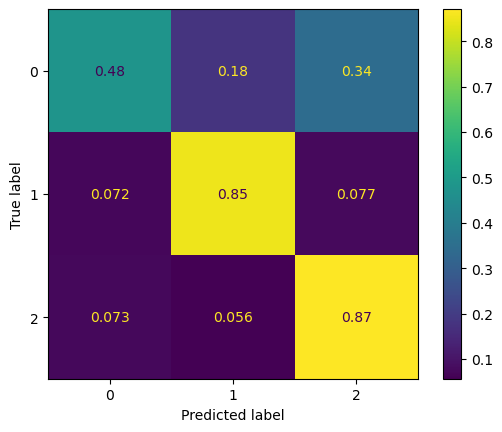

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.74720. Saving Model!
epoch 01, loss: 0.67865, acc: 0.68090, val_loss: 0.74720, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 02, loss: 0.68153, acc: 0.67843, val_loss: 0.74844, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 03, loss: 0.68092, acc: 0.68010, val_loss: 0.74878, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 04, loss: 0.67883, acc: 0.68093, val_loss: 0.74954, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 05, loss: 0.67710, acc: 0.67778, val_loss: 0.75095, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 06, loss: 0.67591, acc: 0.67746, val_loss: 0.75235, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 07, loss: 0.67447, acc: 0.67869, val_loss: 0.75382, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.35it/s]


epoch 08, loss: 0.67324, acc: 0.68316, val_loss: 0.75537, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 09, loss: 0.67259, acc: 0.68989, val_loss: 0.75663, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 10, loss: 0.67186, acc: 0.69021, val_loss: 0.75756, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 11, loss: 0.67094, acc: 0.69024, val_loss: 0.75839, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


epoch 12, loss: 0.66987, acc: 0.69003, val_loss: 0.75901, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 13, loss: 0.66875, acc: 0.68962, val_loss: 0.75977, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 14, loss: 0.66776, acc: 0.68989, val_loss: 0.76069, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 15, loss: 0.66697, acc: 0.68942, val_loss: 0.76153, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 16, loss: 0.66599, acc: 0.68956, val_loss: 0.76233, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 17, loss: 0.66525, acc: 0.69335, val_loss: 0.76297, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 18, loss: 0.66427, acc: 0.69359, val_loss: 0.76374, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 19, loss: 0.66341, acc: 0.69379, val_loss: 0.76449, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 20, loss: 0.66255, acc: 0.69441, val_loss: 0.76513, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 21, loss: 0.66169, acc: 0.69450, val_loss: 0.76575, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 22, loss: 0.66087, acc: 0.69462, val_loss: 0.76634, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 23, loss: 0.65990, acc: 0.69473, val_loss: 0.76707, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 24, loss: 0.65908, acc: 0.69485, val_loss: 0.76785, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 25, loss: 0.65836, acc: 0.69468, val_loss: 0.76850, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 26, loss: 0.65758, acc: 0.69473, val_loss: 0.76898, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 27, loss: 0.65671, acc: 0.69473, val_loss: 0.76950, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 28, loss: 0.65568, acc: 0.69476, val_loss: 0.77027, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 29, loss: 0.65499, acc: 0.69485, val_loss: 0.77076, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 30, loss: 0.65412, acc: 0.69518, val_loss: 0.77136, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 31, loss: 0.65358, acc: 0.70002, val_loss: 0.77171, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 32, loss: 0.65263, acc: 0.70284, val_loss: 0.77236, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 33, loss: 0.65180, acc: 0.70287, val_loss: 0.77299, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 34, loss: 0.65108, acc: 0.70311, val_loss: 0.77339, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 35, loss: 0.65011, acc: 0.70328, val_loss: 0.77410, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 36, loss: 0.64952, acc: 0.70584, val_loss: 0.77457, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 37, loss: 0.64855, acc: 0.70581, val_loss: 0.77517, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 38, loss: 0.64774, acc: 0.70605, val_loss: 0.77588, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 39, loss: 0.64701, acc: 0.70616, val_loss: 0.77639, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 40, loss: 0.64627, acc: 0.70613, val_loss: 0.77690, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 41, loss: 0.64535, acc: 0.70619, val_loss: 0.77755, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 42, loss: 0.64479, acc: 0.70628, val_loss: 0.77786, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 43, loss: 0.64381, acc: 0.70616, val_loss: 0.77854, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 44, loss: 0.64318, acc: 0.70616, val_loss: 0.77909, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 45, loss: 0.64240, acc: 0.70637, val_loss: 0.77943, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 46, loss: 0.64145, acc: 0.70666, val_loss: 0.78005, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 47, loss: 0.64077, acc: 0.70649, val_loss: 0.78070, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.25it/s]


epoch 48, loss: 0.64014, acc: 0.70649, val_loss: 0.78092, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 49, loss: 0.63917, acc: 0.70481, val_loss: 0.78128, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 50, loss: 0.63834, acc: 0.70558, val_loss: 0.78188, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 51, loss: 0.63767, acc: 0.70549, val_loss: 0.78259, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 52, loss: 0.63703, acc: 0.70564, val_loss: 0.78282, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 53, loss: 0.63613, acc: 0.70590, val_loss: 0.78329, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 54, loss: 0.63544, acc: 0.70590, val_loss: 0.78384, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 55, loss: 0.63482, acc: 0.70581, val_loss: 0.78401, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 56, loss: 0.63380, acc: 0.70596, val_loss: 0.78465, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 57, loss: 0.63312, acc: 0.70578, val_loss: 0.78522, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 58, loss: 0.63248, acc: 0.70743, val_loss: 0.78583, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 59, loss: 0.63173, acc: 0.70731, val_loss: 0.78626, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 60, loss: 0.63102, acc: 0.70737, val_loss: 0.78644, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 61, loss: 0.63020, acc: 0.70734, val_loss: 0.78701, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 62, loss: 0.62948, acc: 0.70725, val_loss: 0.78755, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 63, loss: 0.62867, acc: 0.70743, val_loss: 0.78816, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 64, loss: 0.62806, acc: 0.70760, val_loss: 0.78856, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 65, loss: 0.62734, acc: 0.70757, val_loss: 0.78904, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.07it/s]


epoch 66, loss: 0.62660, acc: 0.71169, val_loss: 0.78962, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 67, loss: 0.62596, acc: 0.71178, val_loss: 0.78992, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 68, loss: 0.62512, acc: 0.71183, val_loss: 0.79040, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 69, loss: 0.62442, acc: 0.71207, val_loss: 0.79096, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 70, loss: 0.62369, acc: 0.71219, val_loss: 0.79142, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 71, loss: 0.62315, acc: 0.71236, val_loss: 0.79166, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 72, loss: 0.62234, acc: 0.72226, val_loss: 0.79197, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 73, loss: 0.62146, acc: 0.72247, val_loss: 0.79236, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 74, loss: 0.62091, acc: 0.72241, val_loss: 0.79252, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 75, loss: 0.62002, acc: 0.72273, val_loss: 0.79322, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 76, loss: 0.61947, acc: 0.72273, val_loss: 0.79337, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


epoch 77, loss: 0.61856, acc: 0.72271, val_loss: 0.79364, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 78, loss: 0.61806, acc: 0.72306, val_loss: 0.79418, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 79, loss: 0.61738, acc: 0.72288, val_loss: 0.79474, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 80, loss: 0.61655, acc: 0.72303, val_loss: 0.79505, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 81, loss: 0.61606, acc: 0.72312, val_loss: 0.79509, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 82, loss: 0.61521, acc: 0.72309, val_loss: 0.79548, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 83, loss: 0.61459, acc: 0.72470, val_loss: 0.79575, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 84, loss: 0.61369, acc: 0.72494, val_loss: 0.79627, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 85, loss: 0.61326, acc: 0.72491, val_loss: 0.79638, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 86, loss: 0.61234, acc: 0.72476, val_loss: 0.79674, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 87, loss: 0.61185, acc: 0.72497, val_loss: 0.79705, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 88, loss: 0.61100, acc: 0.72500, val_loss: 0.79773, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 89, loss: 0.61051, acc: 0.72661, val_loss: 0.79816, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 90, loss: 0.60991, acc: 0.72558, val_loss: 0.79832, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 91, loss: 0.60912, acc: 0.72676, val_loss: 0.79858, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 92, loss: 0.60849, acc: 0.72685, val_loss: 0.79885, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 93, loss: 0.60780, acc: 0.72708, val_loss: 0.79903, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 94, loss: 0.60698, acc: 0.72726, val_loss: 0.79964, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 95, loss: 0.60651, acc: 0.72744, val_loss: 0.79978, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 96, loss: 0.60574, acc: 0.72782, val_loss: 0.80009, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 97, loss: 0.60507, acc: 0.72744, val_loss: 0.80067, val_accuracy: 0.63168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 98, loss: 0.60456, acc: 0.72770, val_loss: 0.80077, val_accuracy: 0.63194


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 99, loss: 0.60363, acc: 0.72808, val_loss: 0.80124, val_accuracy: 0.63300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 100, loss: 0.60318, acc: 0.72832, val_loss: 0.80144, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 101, loss: 0.60224, acc: 0.72855, val_loss: 0.80225, val_accuracy: 0.63379


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 102, loss: 0.60197, acc: 0.72890, val_loss: 0.80235, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 103, loss: 0.60110, acc: 0.72935, val_loss: 0.80268, val_accuracy: 0.63432


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 104, loss: 0.60032, acc: 0.72946, val_loss: 0.80323, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 105, loss: 0.59995, acc: 0.72961, val_loss: 0.80346, val_accuracy: 0.63406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 106, loss: 0.59925, acc: 0.72984, val_loss: 0.80338, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 107, loss: 0.59818, acc: 0.72999, val_loss: 0.80408, val_accuracy: 0.63353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 108, loss: 0.59790, acc: 0.72996, val_loss: 0.80452, val_accuracy: 0.63326


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 109, loss: 0.59731, acc: 0.73023, val_loss: 0.80479, val_accuracy: 0.63379


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.26it/s]


epoch 110, loss: 0.59623, acc: 0.73031, val_loss: 0.80538, val_accuracy: 0.63379


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 111, loss: 0.59598, acc: 0.73040, val_loss: 0.80555, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 112, loss: 0.59527, acc: 0.73037, val_loss: 0.80578, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 113, loss: 0.59445, acc: 0.73170, val_loss: 0.80618, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 114, loss: 0.59385, acc: 0.73164, val_loss: 0.80681, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 115, loss: 0.59343, acc: 0.73111, val_loss: 0.80691, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 116, loss: 0.59241, acc: 0.73208, val_loss: 0.80773, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 117, loss: 0.59203, acc: 0.73328, val_loss: 0.80785, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 118, loss: 0.59149, acc: 0.73316, val_loss: 0.80796, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 119, loss: 0.59061, acc: 0.73311, val_loss: 0.80883, val_accuracy: 0.63511


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 120, loss: 0.59019, acc: 0.73199, val_loss: 0.80906, val_accuracy: 0.63485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 121, loss: 0.58940, acc: 0.73199, val_loss: 0.80956, val_accuracy: 0.63511


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 122, loss: 0.58867, acc: 0.73228, val_loss: 0.81026, val_accuracy: 0.63564


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 123, loss: 0.58834, acc: 0.73184, val_loss: 0.81049, val_accuracy: 0.63538


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 124, loss: 0.58762, acc: 0.73190, val_loss: 0.81067, val_accuracy: 0.63564


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 125, loss: 0.58683, acc: 0.73202, val_loss: 0.81128, val_accuracy: 0.63644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 126, loss: 0.58626, acc: 0.73193, val_loss: 0.81175, val_accuracy: 0.63617


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 127, loss: 0.58573, acc: 0.73187, val_loss: 0.81198, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 128, loss: 0.58483, acc: 0.73208, val_loss: 0.81254, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 129, loss: 0.58437, acc: 0.73261, val_loss: 0.81329, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 130, loss: 0.58391, acc: 0.73261, val_loss: 0.81329, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 131, loss: 0.58304, acc: 0.73267, val_loss: 0.81389, val_accuracy: 0.64067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 132, loss: 0.58248, acc: 0.73246, val_loss: 0.81437, val_accuracy: 0.64120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 133, loss: 0.58177, acc: 0.73261, val_loss: 0.81455, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 134, loss: 0.58092, acc: 0.73264, val_loss: 0.81567, val_accuracy: 0.64172


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 135, loss: 0.58062, acc: 0.73264, val_loss: 0.81595, val_accuracy: 0.64146


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 136, loss: 0.57993, acc: 0.73281, val_loss: 0.81656, val_accuracy: 0.64093


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 137, loss: 0.57934, acc: 0.73278, val_loss: 0.81719, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 138, loss: 0.57868, acc: 0.73278, val_loss: 0.81793, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 139, loss: 0.57812, acc: 0.73275, val_loss: 0.81835, val_accuracy: 0.64225


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 140, loss: 0.57765, acc: 0.73281, val_loss: 0.81850, val_accuracy: 0.64278


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 141, loss: 0.57663, acc: 0.73290, val_loss: 0.81922, val_accuracy: 0.64331


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 142, loss: 0.57640, acc: 0.73299, val_loss: 0.81978, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 143, loss: 0.57549, acc: 0.73302, val_loss: 0.82070, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 144, loss: 0.57498, acc: 0.72846, val_loss: 0.82102, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 145, loss: 0.57458, acc: 0.72841, val_loss: 0.82141, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 146, loss: 0.57377, acc: 0.72964, val_loss: 0.82198, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 147, loss: 0.57313, acc: 0.72964, val_loss: 0.82242, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 148, loss: 0.57259, acc: 0.72970, val_loss: 0.82293, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 149, loss: 0.57177, acc: 0.72979, val_loss: 0.82395, val_accuracy: 0.59704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 150, loss: 0.57153, acc: 0.73366, val_loss: 0.82386, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 151, loss: 0.57041, acc: 0.73713, val_loss: 0.82518, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 152, loss: 0.57029, acc: 0.73716, val_loss: 0.82545, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 153, loss: 0.56961, acc: 0.73731, val_loss: 0.82595, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 154, loss: 0.56888, acc: 0.73737, val_loss: 0.82668, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 155, loss: 0.56840, acc: 0.73731, val_loss: 0.82720, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 156, loss: 0.56789, acc: 0.73754, val_loss: 0.82749, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 157, loss: 0.56696, acc: 0.73754, val_loss: 0.82837, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 158, loss: 0.56661, acc: 0.73757, val_loss: 0.82886, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 159, loss: 0.56599, acc: 0.73751, val_loss: 0.82925, val_accuracy: 0.60814


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 160, loss: 0.56517, acc: 0.73772, val_loss: 0.83052, val_accuracy: 0.60841


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 161, loss: 0.56493, acc: 0.73760, val_loss: 0.83096, val_accuracy: 0.60867


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 162, loss: 0.56425, acc: 0.73784, val_loss: 0.83116, val_accuracy: 0.60920


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 163, loss: 0.56355, acc: 0.73769, val_loss: 0.83179, val_accuracy: 0.60947


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 164, loss: 0.56293, acc: 0.73804, val_loss: 0.83281, val_accuracy: 0.60999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 165, loss: 0.56249, acc: 0.73822, val_loss: 0.83293, val_accuracy: 0.60999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 166, loss: 0.56189, acc: 0.73825, val_loss: 0.83359, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]


epoch 167, loss: 0.56099, acc: 0.73884, val_loss: 0.83462, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 168, loss: 0.56072, acc: 0.73925, val_loss: 0.83468, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 169, loss: 0.56010, acc: 0.73954, val_loss: 0.83500, val_accuracy: 0.61079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 170, loss: 0.55934, acc: 0.73995, val_loss: 0.83591, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 171, loss: 0.55868, acc: 0.74010, val_loss: 0.83659, val_accuracy: 0.61132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 172, loss: 0.55840, acc: 0.74057, val_loss: 0.83715, val_accuracy: 0.61132


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 173, loss: 0.55744, acc: 0.74063, val_loss: 0.83840, val_accuracy: 0.61185


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 174, loss: 0.55756, acc: 0.74086, val_loss: 0.83806, val_accuracy: 0.61185


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 175, loss: 0.55632, acc: 0.74151, val_loss: 0.83916, val_accuracy: 0.61158


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 176, loss: 0.55592, acc: 0.74218, val_loss: 0.83989, val_accuracy: 0.61185


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 177, loss: 0.55566, acc: 0.74354, val_loss: 0.84058, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 178, loss: 0.55473, acc: 0.74392, val_loss: 0.84155, val_accuracy: 0.61185


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.13it/s]


epoch 179, loss: 0.55407, acc: 0.74386, val_loss: 0.84228, val_accuracy: 0.61237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.51it/s]


epoch 180, loss: 0.55384, acc: 0.74389, val_loss: 0.84239, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 181, loss: 0.55309, acc: 0.74404, val_loss: 0.84319, val_accuracy: 0.61290


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 182, loss: 0.55242, acc: 0.74421, val_loss: 0.84408, val_accuracy: 0.61105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 183, loss: 0.55211, acc: 0.74436, val_loss: 0.84427, val_accuracy: 0.61343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 184, loss: 0.55120, acc: 0.74433, val_loss: 0.84528, val_accuracy: 0.61396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 185, loss: 0.55082, acc: 0.74489, val_loss: 0.84619, val_accuracy: 0.61370


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 186, loss: 0.55035, acc: 0.74454, val_loss: 0.84662, val_accuracy: 0.61211


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 187, loss: 0.54965, acc: 0.74471, val_loss: 0.84753, val_accuracy: 0.61317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 188, loss: 0.54910, acc: 0.74462, val_loss: 0.84821, val_accuracy: 0.61343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 189, loss: 0.54849, acc: 0.74486, val_loss: 0.84877, val_accuracy: 0.61317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 190, loss: 0.54790, acc: 0.74451, val_loss: 0.85000, val_accuracy: 0.61343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 191, loss: 0.54761, acc: 0.74471, val_loss: 0.85014, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 192, loss: 0.54664, acc: 0.74465, val_loss: 0.85143, val_accuracy: 0.61370


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 193, loss: 0.54644, acc: 0.74527, val_loss: 0.85170, val_accuracy: 0.61423


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 194, loss: 0.54550, acc: 0.74548, val_loss: 0.85290, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 195, loss: 0.54542, acc: 0.74545, val_loss: 0.85310, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 196, loss: 0.54458, acc: 0.75044, val_loss: 0.85380, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 197, loss: 0.54373, acc: 0.75238, val_loss: 0.85521, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 198, loss: 0.54382, acc: 0.75405, val_loss: 0.85504, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 199, loss: 0.54287, acc: 0.75452, val_loss: 0.85613, val_accuracy: 0.61528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 200, loss: 0.54208, acc: 0.75605, val_loss: 0.85752, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 201, loss: 0.54204, acc: 0.75755, val_loss: 0.85733, val_accuracy: 0.61634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 202, loss: 0.54111, acc: 0.75764, val_loss: 0.85851, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 203, loss: 0.54060, acc: 0.76055, val_loss: 0.85972, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 204, loss: 0.54044, acc: 0.76046, val_loss: 0.85944, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.49it/s]


epoch 205, loss: 0.53930, acc: 0.75975, val_loss: 0.86103, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 206, loss: 0.53943, acc: 0.75829, val_loss: 0.86091, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 207, loss: 0.53817, acc: 0.76087, val_loss: 0.86236, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 208, loss: 0.53813, acc: 0.75999, val_loss: 0.86245, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 209, loss: 0.53734, acc: 0.75846, val_loss: 0.86370, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 210, loss: 0.53677, acc: 0.76143, val_loss: 0.86451, val_accuracy: 0.61608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 211, loss: 0.53650, acc: 0.76134, val_loss: 0.86461, val_accuracy: 0.61555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 212, loss: 0.53559, acc: 0.75896, val_loss: 0.86599, val_accuracy: 0.61660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 213, loss: 0.53539, acc: 0.76108, val_loss: 0.86589, val_accuracy: 0.61581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 214, loss: 0.53444, acc: 0.76437, val_loss: 0.86729, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 215, loss: 0.53408, acc: 0.76213, val_loss: 0.86827, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 216, loss: 0.53360, acc: 0.76542, val_loss: 0.86866, val_accuracy: 0.61819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 217, loss: 0.53307, acc: 0.76575, val_loss: 0.86956, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 218, loss: 0.53271, acc: 0.76472, val_loss: 0.86938, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 219, loss: 0.53146, acc: 0.76319, val_loss: 0.87095, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 220, loss: 0.53171, acc: 0.76513, val_loss: 0.87044, val_accuracy: 0.61819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.84it/s]


epoch 221, loss: 0.53053, acc: 0.76519, val_loss: 0.87198, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 222, loss: 0.53007, acc: 0.76628, val_loss: 0.87331, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.60it/s]


epoch 223, loss: 0.53004, acc: 0.76551, val_loss: 0.87342, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 224, loss: 0.52906, acc: 0.76399, val_loss: 0.87429, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 225, loss: 0.52852, acc: 0.76619, val_loss: 0.87528, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 226, loss: 0.52792, acc: 0.76493, val_loss: 0.87577, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 227, loss: 0.52789, acc: 0.76616, val_loss: 0.87664, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 228, loss: 0.52702, acc: 0.76648, val_loss: 0.87720, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 229, loss: 0.52607, acc: 0.76675, val_loss: 0.87860, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 230, loss: 0.52621, acc: 0.76666, val_loss: 0.87901, val_accuracy: 0.62057


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 231, loss: 0.52551, acc: 0.76713, val_loss: 0.87943, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 232, loss: 0.52459, acc: 0.76830, val_loss: 0.88066, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 233, loss: 0.52473, acc: 0.76745, val_loss: 0.88056, val_accuracy: 0.61793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 234, loss: 0.52363, acc: 0.76587, val_loss: 0.88180, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 235, loss: 0.52329, acc: 0.76786, val_loss: 0.88271, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 236, loss: 0.52281, acc: 0.76792, val_loss: 0.88332, val_accuracy: 0.61872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 237, loss: 0.52223, acc: 0.76883, val_loss: 0.88359, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 238, loss: 0.52166, acc: 0.76966, val_loss: 0.88433, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 239, loss: 0.52161, acc: 0.76739, val_loss: 0.88433, val_accuracy: 0.61846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 240, loss: 0.52026, acc: 0.76795, val_loss: 0.88581, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 241, loss: 0.52007, acc: 0.77098, val_loss: 0.88656, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 242, loss: 0.51982, acc: 0.76939, val_loss: 0.88728, val_accuracy: 0.61713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 243, loss: 0.51924, acc: 0.76921, val_loss: 0.88819, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 244, loss: 0.51876, acc: 0.77115, val_loss: 0.88811, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 245, loss: 0.51782, acc: 0.77154, val_loss: 0.88964, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 246, loss: 0.51742, acc: 0.77230, val_loss: 0.89110, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 247, loss: 0.51750, acc: 0.77186, val_loss: 0.89077, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 248, loss: 0.51656, acc: 0.77054, val_loss: 0.89161, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 249, loss: 0.51563, acc: 0.77356, val_loss: 0.89286, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 250, loss: 0.51553, acc: 0.77251, val_loss: 0.89276, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 251, loss: 0.51467, acc: 0.77336, val_loss: 0.89486, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 252, loss: 0.51479, acc: 0.77368, val_loss: 0.89388, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 253, loss: 0.51366, acc: 0.77280, val_loss: 0.89555, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 254, loss: 0.51337, acc: 0.77395, val_loss: 0.89645, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 255, loss: 0.51305, acc: 0.77118, val_loss: 0.89723, val_accuracy: 0.61978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 256, loss: 0.51222, acc: 0.77633, val_loss: 0.89805, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 257, loss: 0.51195, acc: 0.77412, val_loss: 0.89842, val_accuracy: 0.61951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 258, loss: 0.51123, acc: 0.77985, val_loss: 0.90011, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 259, loss: 0.51099, acc: 0.77509, val_loss: 0.90034, val_accuracy: 0.61925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.80it/s]


epoch 260, loss: 0.51026, acc: 0.78009, val_loss: 0.90077, val_accuracy: 0.62295


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 261, loss: 0.50958, acc: 0.78067, val_loss: 0.90211, val_accuracy: 0.62322


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 262, loss: 0.50968, acc: 0.78053, val_loss: 0.90250, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 263, loss: 0.50867, acc: 0.78076, val_loss: 0.90305, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 264, loss: 0.50832, acc: 0.78091, val_loss: 0.90374, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 265, loss: 0.50784, acc: 0.78082, val_loss: 0.90455, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 266, loss: 0.50723, acc: 0.78097, val_loss: 0.90542, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 267, loss: 0.50679, acc: 0.78123, val_loss: 0.90610, val_accuracy: 0.62242


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


epoch 268, loss: 0.50642, acc: 0.78141, val_loss: 0.90603, val_accuracy: 0.62269


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 269, loss: 0.50566, acc: 0.78085, val_loss: 0.90768, val_accuracy: 0.62110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 270, loss: 0.50527, acc: 0.78191, val_loss: 0.90812, val_accuracy: 0.62084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 271, loss: 0.50458, acc: 0.78211, val_loss: 0.90982, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 272, loss: 0.50443, acc: 0.78226, val_loss: 0.90973, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 273, loss: 0.50372, acc: 0.78229, val_loss: 0.91039, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 274, loss: 0.50353, acc: 0.78379, val_loss: 0.91077, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 275, loss: 0.50257, acc: 0.78473, val_loss: 0.91245, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 276, loss: 0.50227, acc: 0.78496, val_loss: 0.91272, val_accuracy: 0.62004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 277, loss: 0.50202, acc: 0.78482, val_loss: 0.91331, val_accuracy: 0.62031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 278, loss: 0.50091, acc: 0.78523, val_loss: 0.91507, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 279, loss: 0.50126, acc: 0.78670, val_loss: 0.91493, val_accuracy: 0.62136


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 280, loss: 0.50014, acc: 0.78708, val_loss: 0.91609, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 281, loss: 0.49989, acc: 0.78772, val_loss: 0.91692, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 282, loss: 0.49952, acc: 0.78778, val_loss: 0.91738, val_accuracy: 0.62189


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 283, loss: 0.49882, acc: 0.78787, val_loss: 0.91850, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


epoch 284, loss: 0.49846, acc: 0.78784, val_loss: 0.91872, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 285, loss: 0.49754, acc: 0.78802, val_loss: 0.92091, val_accuracy: 0.62216


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 286, loss: 0.49811, acc: 0.78787, val_loss: 0.91924, val_accuracy: 0.62163


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 287, loss: 0.49661, acc: 0.78978, val_loss: 0.92101, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 288, loss: 0.49594, acc: 0.78499, val_loss: 0.92280, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 289, loss: 0.49681, acc: 0.78479, val_loss: 0.92238, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 290, loss: 0.49510, acc: 0.78514, val_loss: 0.92464, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.85it/s]


epoch 291, loss: 0.49493, acc: 0.78523, val_loss: 0.92463, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 292, loss: 0.49509, acc: 0.78420, val_loss: 0.92445, val_accuracy: 0.62401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 293, loss: 0.49384, acc: 0.78529, val_loss: 0.92597, val_accuracy: 0.62374


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 294, loss: 0.49362, acc: 0.78543, val_loss: 0.92645, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 295, loss: 0.49300, acc: 0.78564, val_loss: 0.92808, val_accuracy: 0.62427


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 296, loss: 0.49269, acc: 0.78549, val_loss: 0.92894, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 297, loss: 0.49243, acc: 0.78543, val_loss: 0.92946, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 298, loss: 0.49174, acc: 0.78573, val_loss: 0.92979, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 299, loss: 0.49108, acc: 0.78570, val_loss: 0.93056, val_accuracy: 0.62454


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 300, loss: 0.49076, acc: 0.78570, val_loss: 0.93179, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]


epoch 301, loss: 0.49043, acc: 0.78596, val_loss: 0.93194, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 302, loss: 0.48987, acc: 0.78728, val_loss: 0.93356, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 303, loss: 0.48934, acc: 0.78772, val_loss: 0.93422, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 304, loss: 0.48899, acc: 0.78673, val_loss: 0.93500, val_accuracy: 0.62507


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 305, loss: 0.48817, acc: 0.78772, val_loss: 0.93599, val_accuracy: 0.62480


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 306, loss: 0.48834, acc: 0.78787, val_loss: 0.93588, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 307, loss: 0.48762, acc: 0.78843, val_loss: 0.93612, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 308, loss: 0.48708, acc: 0.78775, val_loss: 0.93756, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 309, loss: 0.48657, acc: 0.78846, val_loss: 0.93930, val_accuracy: 0.62559


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 310, loss: 0.48610, acc: 0.78890, val_loss: 0.94050, val_accuracy: 0.62533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 311, loss: 0.48595, acc: 0.78866, val_loss: 0.94085, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 312, loss: 0.48507, acc: 0.78905, val_loss: 0.94231, val_accuracy: 0.62639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 313, loss: 0.48489, acc: 0.78925, val_loss: 0.94275, val_accuracy: 0.62665


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


epoch 314, loss: 0.48414, acc: 0.79005, val_loss: 0.94367, val_accuracy: 0.62718


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 315, loss: 0.48419, acc: 0.78987, val_loss: 0.94357, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 316, loss: 0.48324, acc: 0.79022, val_loss: 0.94411, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 317, loss: 0.48272, acc: 0.79040, val_loss: 0.94569, val_accuracy: 0.62745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 318, loss: 0.48257, acc: 0.79031, val_loss: 0.94619, val_accuracy: 0.62771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 319, loss: 0.48213, acc: 0.79248, val_loss: 0.94740, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 320, loss: 0.48154, acc: 0.78963, val_loss: 0.94750, val_accuracy: 0.62797


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 321, loss: 0.48106, acc: 0.79031, val_loss: 0.94893, val_accuracy: 0.62824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 322, loss: 0.48075, acc: 0.79060, val_loss: 0.94908, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 323, loss: 0.48019, acc: 0.79107, val_loss: 0.95068, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 324, loss: 0.47993, acc: 0.79096, val_loss: 0.95099, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 325, loss: 0.47927, acc: 0.79125, val_loss: 0.95187, val_accuracy: 0.62850


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 326, loss: 0.47879, acc: 0.79160, val_loss: 0.95262, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 327, loss: 0.47857, acc: 0.79160, val_loss: 0.95342, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 328, loss: 0.47804, acc: 0.79348, val_loss: 0.95371, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 329, loss: 0.47734, acc: 0.79378, val_loss: 0.95529, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 330, loss: 0.47700, acc: 0.79384, val_loss: 0.95625, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 331, loss: 0.47703, acc: 0.79375, val_loss: 0.95578, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 332, loss: 0.47561, acc: 0.79513, val_loss: 0.95800, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 333, loss: 0.47591, acc: 0.79263, val_loss: 0.95769, val_accuracy: 0.62877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 334, loss: 0.47512, acc: 0.79345, val_loss: 0.95927, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 335, loss: 0.47450, acc: 0.79357, val_loss: 0.96061, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 336, loss: 0.47498, acc: 0.79342, val_loss: 0.95918, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 337, loss: 0.47330, acc: 0.79569, val_loss: 0.96184, val_accuracy: 0.62930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 338, loss: 0.47354, acc: 0.79569, val_loss: 0.96135, val_accuracy: 0.62903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 339, loss: 0.47272, acc: 0.79575, val_loss: 0.96314, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 340, loss: 0.47250, acc: 0.79583, val_loss: 0.96394, val_accuracy: 0.62956


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 341, loss: 0.47169, acc: 0.79586, val_loss: 0.96608, val_accuracy: 0.63009


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 342, loss: 0.47193, acc: 0.79595, val_loss: 0.96478, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 343, loss: 0.47079, acc: 0.79613, val_loss: 0.96625, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 344, loss: 0.47048, acc: 0.79636, val_loss: 0.96715, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 345, loss: 0.47026, acc: 0.79660, val_loss: 0.96754, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 346, loss: 0.46953, acc: 0.79666, val_loss: 0.96977, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 347, loss: 0.46931, acc: 0.79677, val_loss: 0.96964, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 348, loss: 0.46878, acc: 0.79680, val_loss: 0.96992, val_accuracy: 0.63035


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 349, loss: 0.46840, acc: 0.79683, val_loss: 0.97044, val_accuracy: 0.62983


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 350, loss: 0.46754, acc: 0.79692, val_loss: 0.97179, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 351, loss: 0.46754, acc: 0.79598, val_loss: 0.97245, val_accuracy: 0.63062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.22it/s]


epoch 352, loss: 0.46666, acc: 0.79616, val_loss: 0.97430, val_accuracy: 0.63115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 353, loss: 0.46652, acc: 0.79627, val_loss: 0.97489, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.04it/s]


epoch 354, loss: 0.46613, acc: 0.79648, val_loss: 0.97470, val_accuracy: 0.63088


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 355, loss: 0.46525, acc: 0.79642, val_loss: 0.97734, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 356, loss: 0.46546, acc: 0.79666, val_loss: 0.97631, val_accuracy: 0.63141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 357, loss: 0.46431, acc: 0.79636, val_loss: 0.97815, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 358, loss: 0.46432, acc: 0.79683, val_loss: 0.97722, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 359, loss: 0.46391, acc: 0.79677, val_loss: 0.97864, val_accuracy: 0.59651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 360, loss: 0.46328, acc: 0.79719, val_loss: 0.97891, val_accuracy: 0.59625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 361, loss: 0.46287, acc: 0.79727, val_loss: 0.98071, val_accuracy: 0.59598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 362, loss: 0.46227, acc: 0.79730, val_loss: 0.98173, val_accuracy: 0.59651


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 363, loss: 0.46225, acc: 0.79642, val_loss: 0.98156, val_accuracy: 0.59704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 364, loss: 0.46146, acc: 0.79654, val_loss: 0.98266, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 365, loss: 0.46097, acc: 0.79768, val_loss: 0.98418, val_accuracy: 0.59677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 366, loss: 0.46066, acc: 0.79768, val_loss: 0.98537, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 367, loss: 0.46025, acc: 0.79724, val_loss: 0.98572, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.96it/s]


epoch 368, loss: 0.45983, acc: 0.79721, val_loss: 0.98604, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 369, loss: 0.45941, acc: 0.79727, val_loss: 0.98639, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 370, loss: 0.45881, acc: 0.79721, val_loss: 0.98769, val_accuracy: 0.59704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 371, loss: 0.45860, acc: 0.79751, val_loss: 0.98737, val_accuracy: 0.59704


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 372, loss: 0.45773, acc: 0.79780, val_loss: 0.98916, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 373, loss: 0.45786, acc: 0.79807, val_loss: 0.98872, val_accuracy: 0.59783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 374, loss: 0.45697, acc: 0.79777, val_loss: 0.99009, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.81it/s]


epoch 375, loss: 0.45634, acc: 0.79804, val_loss: 0.99147, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 376, loss: 0.45643, acc: 0.79801, val_loss: 0.99229, val_accuracy: 0.59810


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 377, loss: 0.45585, acc: 0.79830, val_loss: 0.99256, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 378, loss: 0.45527, acc: 0.79818, val_loss: 0.99376, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 379, loss: 0.45480, acc: 0.79827, val_loss: 0.99489, val_accuracy: 0.59889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 380, loss: 0.45433, acc: 0.79833, val_loss: 0.99619, val_accuracy: 0.59889


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 381, loss: 0.45395, acc: 0.79842, val_loss: 0.99623, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.00it/s]


epoch 382, loss: 0.45360, acc: 0.79851, val_loss: 0.99720, val_accuracy: 0.59968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 383, loss: 0.45343, acc: 0.79857, val_loss: 0.99735, val_accuracy: 0.59915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 384, loss: 0.45272, acc: 0.79862, val_loss: 0.99762, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 385, loss: 0.45198, acc: 0.79874, val_loss: 0.99961, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 386, loss: 0.45212, acc: 0.79871, val_loss: 0.99952, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 387, loss: 0.45125, acc: 0.79883, val_loss: 1.00171, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 388, loss: 0.45168, acc: 0.79892, val_loss: 0.99960, val_accuracy: 0.59942


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 389, loss: 0.45023, acc: 0.80521, val_loss: 1.00213, val_accuracy: 0.58964


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 390, loss: 0.44998, acc: 0.80421, val_loss: 1.00275, val_accuracy: 0.58805


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


epoch 391, loss: 0.45025, acc: 0.80494, val_loss: 1.00251, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 392, loss: 0.44870, acc: 0.80459, val_loss: 1.00492, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 393, loss: 0.44942, acc: 0.80456, val_loss: 1.00379, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 394, loss: 0.44822, acc: 0.80647, val_loss: 1.00607, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 395, loss: 0.44815, acc: 0.80385, val_loss: 1.00536, val_accuracy: 0.58805


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.85it/s]


epoch 396, loss: 0.44764, acc: 0.80882, val_loss: 1.00715, val_accuracy: 0.58831


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 397, loss: 0.44681, acc: 0.81023, val_loss: 1.00864, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 398, loss: 0.44761, acc: 0.81005, val_loss: 1.00781, val_accuracy: 0.58884


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 399, loss: 0.44603, acc: 0.81017, val_loss: 1.01004, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 400, loss: 0.44576, acc: 0.81120, val_loss: 1.01022, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 401, loss: 0.44556, acc: 0.80982, val_loss: 1.01021, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 402, loss: 0.44492, acc: 0.81061, val_loss: 1.01210, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 403, loss: 0.44474, acc: 0.81091, val_loss: 1.01197, val_accuracy: 0.58990


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 404, loss: 0.44425, acc: 0.81085, val_loss: 1.01301, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 405, loss: 0.44392, acc: 0.81196, val_loss: 1.01318, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 406, loss: 0.44319, acc: 0.81182, val_loss: 1.01477, val_accuracy: 0.59043


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 407, loss: 0.44304, acc: 0.81273, val_loss: 1.01466, val_accuracy: 0.59043


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 408, loss: 0.44243, acc: 0.81305, val_loss: 1.01631, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 409, loss: 0.44249, acc: 0.81290, val_loss: 1.01574, val_accuracy: 0.58964


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 410, loss: 0.44122, acc: 0.81287, val_loss: 1.01860, val_accuracy: 0.59096


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 411, loss: 0.44120, acc: 0.81420, val_loss: 1.01971, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 412, loss: 0.44095, acc: 0.81405, val_loss: 1.01928, val_accuracy: 0.59043


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.65it/s]


epoch 413, loss: 0.44058, acc: 0.81414, val_loss: 1.02111, val_accuracy: 0.59122


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 414, loss: 0.44008, acc: 0.81320, val_loss: 1.02088, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 415, loss: 0.43953, acc: 0.81340, val_loss: 1.02080, val_accuracy: 0.59016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 416, loss: 0.43895, acc: 0.81443, val_loss: 1.02286, val_accuracy: 0.59096


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 417, loss: 0.43884, acc: 0.81478, val_loss: 1.02311, val_accuracy: 0.59122


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 418, loss: 0.43860, acc: 0.81443, val_loss: 1.02437, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 419, loss: 0.43772, acc: 0.81511, val_loss: 1.02548, val_accuracy: 0.59096


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 420, loss: 0.43773, acc: 0.81528, val_loss: 1.02481, val_accuracy: 0.59069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.10it/s]


epoch 421, loss: 0.43702, acc: 0.81528, val_loss: 1.02730, val_accuracy: 0.59175


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 422, loss: 0.43683, acc: 0.81543, val_loss: 1.02694, val_accuracy: 0.59096


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 423, loss: 0.43615, acc: 0.81552, val_loss: 1.02814, val_accuracy: 0.59096


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 424, loss: 0.43616, acc: 0.81555, val_loss: 1.02727, val_accuracy: 0.59122


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 425, loss: 0.43502, acc: 0.81611, val_loss: 1.02936, val_accuracy: 0.59175


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 426, loss: 0.43539, acc: 0.81617, val_loss: 1.02866, val_accuracy: 0.59175


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 427, loss: 0.43428, acc: 0.81637, val_loss: 1.03070, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 428, loss: 0.43453, acc: 0.81634, val_loss: 1.02925, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 429, loss: 0.43356, acc: 0.81640, val_loss: 1.03124, val_accuracy: 0.59254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 430, loss: 0.43352, acc: 0.81664, val_loss: 1.03188, val_accuracy: 0.59228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 431, loss: 0.43269, acc: 0.81678, val_loss: 1.03415, val_accuracy: 0.59281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 432, loss: 0.43314, acc: 0.81669, val_loss: 1.03186, val_accuracy: 0.59228


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 433, loss: 0.43192, acc: 0.81675, val_loss: 1.03332, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 434, loss: 0.43174, acc: 0.81705, val_loss: 1.03555, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 435, loss: 0.43159, acc: 0.81711, val_loss: 1.03632, val_accuracy: 0.59281


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


epoch 436, loss: 0.43084, acc: 0.81467, val_loss: 1.03715, val_accuracy: 0.59307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 437, loss: 0.43075, acc: 0.81743, val_loss: 1.03783, val_accuracy: 0.59334


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 438, loss: 0.43025, acc: 0.81746, val_loss: 1.03762, val_accuracy: 0.59387


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.08it/s]


epoch 439, loss: 0.42969, acc: 0.81678, val_loss: 1.03880, val_accuracy: 0.59492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]


epoch 440, loss: 0.42963, acc: 0.81649, val_loss: 1.03986, val_accuracy: 0.59519


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 441, loss: 0.42934, acc: 0.81496, val_loss: 1.03866, val_accuracy: 0.59466


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 442, loss: 0.42802, acc: 0.81496, val_loss: 1.04147, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 443, loss: 0.42846, acc: 0.81766, val_loss: 1.04200, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 444, loss: 0.42795, acc: 0.81784, val_loss: 1.04275, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 445, loss: 0.42734, acc: 0.81711, val_loss: 1.04350, val_accuracy: 0.59598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 446, loss: 0.42714, acc: 0.81555, val_loss: 1.04324, val_accuracy: 0.59545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 447, loss: 0.42645, acc: 0.81564, val_loss: 1.04528, val_accuracy: 0.59598


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 448, loss: 0.42657, acc: 0.81578, val_loss: 1.04457, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 449, loss: 0.42564, acc: 0.81675, val_loss: 1.04718, val_accuracy: 0.59625


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.98it/s]


epoch 450, loss: 0.42551, acc: 0.81787, val_loss: 1.04653, val_accuracy: 0.59572


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 451, loss: 0.42563, acc: 0.81605, val_loss: 1.04379, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 452, loss: 0.42417, acc: 0.81922, val_loss: 1.04796, val_accuracy: 0.59677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 453, loss: 0.42482, acc: 0.81899, val_loss: 1.04685, val_accuracy: 0.59677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 454, loss: 0.42367, acc: 0.81819, val_loss: 1.04979, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 455, loss: 0.42345, acc: 0.81946, val_loss: 1.05053, val_accuracy: 0.59677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 456, loss: 0.42335, acc: 0.81937, val_loss: 1.05089, val_accuracy: 0.59677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


epoch 457, loss: 0.42279, acc: 0.81890, val_loss: 1.05261, val_accuracy: 0.59757


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 458, loss: 0.42256, acc: 0.81819, val_loss: 1.05144, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 459, loss: 0.42168, acc: 0.81925, val_loss: 1.05429, val_accuracy: 0.59730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.99it/s]


epoch 460, loss: 0.42171, acc: 0.81987, val_loss: 1.05222, val_accuracy: 0.59836


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 461, loss: 0.42092, acc: 0.81940, val_loss: 1.05645, val_accuracy: 0.59995


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]


epoch 462, loss: 0.42076, acc: 0.81998, val_loss: 1.05614, val_accuracy: 0.59968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 463, loss: 0.42073, acc: 0.81884, val_loss: 1.05621, val_accuracy: 0.59968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 464, loss: 0.41994, acc: 0.82019, val_loss: 1.05688, val_accuracy: 0.60100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 465, loss: 0.41990, acc: 0.81881, val_loss: 1.05707, val_accuracy: 0.60127


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 466, loss: 0.41908, acc: 0.81769, val_loss: 1.05808, val_accuracy: 0.59863


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 467, loss: 0.41899, acc: 0.82037, val_loss: 1.05922, val_accuracy: 0.60074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 468, loss: 0.41872, acc: 0.81987, val_loss: 1.05901, val_accuracy: 0.60021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


epoch 469, loss: 0.41818, acc: 0.81957, val_loss: 1.06061, val_accuracy: 0.60074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 470, loss: 0.41781, acc: 0.82007, val_loss: 1.06065, val_accuracy: 0.60259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 471, loss: 0.41749, acc: 0.81916, val_loss: 1.06216, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 472, loss: 0.41718, acc: 0.81937, val_loss: 1.06320, val_accuracy: 0.60312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 473, loss: 0.41656, acc: 0.81793, val_loss: 1.06428, val_accuracy: 0.60233


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 474, loss: 0.41653, acc: 0.81954, val_loss: 1.06510, val_accuracy: 0.60286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 475, loss: 0.41665, acc: 0.81810, val_loss: 1.06282, val_accuracy: 0.60180


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 476, loss: 0.41501, acc: 0.81755, val_loss: 1.06667, val_accuracy: 0.60286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 477, loss: 0.41539, acc: 0.82066, val_loss: 1.06550, val_accuracy: 0.60286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 478, loss: 0.41496, acc: 0.82016, val_loss: 1.06750, val_accuracy: 0.60286


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 479, loss: 0.41451, acc: 0.81843, val_loss: 1.06844, val_accuracy: 0.60312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 480, loss: 0.41441, acc: 0.81849, val_loss: 1.06868, val_accuracy: 0.60259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 481, loss: 0.41399, acc: 0.81849, val_loss: 1.06982, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 482, loss: 0.41370, acc: 0.81840, val_loss: 1.06825, val_accuracy: 0.60338


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 483, loss: 0.41275, acc: 0.81875, val_loss: 1.07235, val_accuracy: 0.60444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 484, loss: 0.41293, acc: 0.82013, val_loss: 1.07115, val_accuracy: 0.60365


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 485, loss: 0.41261, acc: 0.81881, val_loss: 1.07200, val_accuracy: 0.60391


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 486, loss: 0.41188, acc: 0.81907, val_loss: 1.07356, val_accuracy: 0.60576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 487, loss: 0.41175, acc: 0.81857, val_loss: 1.07374, val_accuracy: 0.60629


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.91it/s]


epoch 488, loss: 0.41111, acc: 0.81857, val_loss: 1.07689, val_accuracy: 0.60735


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 489, loss: 0.41157, acc: 0.81866, val_loss: 1.07367, val_accuracy: 0.60418


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 490, loss: 0.41033, acc: 0.81902, val_loss: 1.07740, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 491, loss: 0.41036, acc: 0.81928, val_loss: 1.07547, val_accuracy: 0.60603


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 492, loss: 0.40999, acc: 0.81875, val_loss: 1.07777, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 493, loss: 0.40929, acc: 0.81987, val_loss: 1.07932, val_accuracy: 0.60656


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 494, loss: 0.40960, acc: 0.81978, val_loss: 1.07973, val_accuracy: 0.60682


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 495, loss: 0.40897, acc: 0.81978, val_loss: 1.07997, val_accuracy: 0.60709


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 496, loss: 0.40829, acc: 0.82022, val_loss: 1.08204, val_accuracy: 0.60709


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 497, loss: 0.40850, acc: 0.81916, val_loss: 1.08048, val_accuracy: 0.60709


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 498, loss: 0.40737, acc: 0.81969, val_loss: 1.08347, val_accuracy: 0.60709


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 499, loss: 0.40764, acc: 0.82043, val_loss: 1.08292, val_accuracy: 0.60762


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 500, loss: 0.40703, acc: 0.81993, val_loss: 1.08232, val_accuracy: 0.60709
7번째 교차검증
evaluation loss: 0.74720, evaluation accuracy: 0.62533
(5, 3782)
(3782, 5)
Learning rate set to 0.085141
0:	learn: 1.0378919	total: 8.41ms	remaining: 8.4s
1:	learn: 0.9877244	total: 16.4ms	remaining: 8.19s
2:	learn: 0.9458531	total: 23.8ms	remaining: 7.92s
3:	learn: 0.9110164	total: 32.5ms	remaining: 8.08s
4:	learn: 0.8799645	total: 39.8ms	remaining: 7.92s
5:	learn: 0.8534045	total: 47.7ms	remaining: 7.89s
6:	learn: 0.8300036	total: 57.2ms	remaining: 8.12s
7:	learn: 0.8096475	total: 65ms	remaining: 8.06s
8:	learn: 0.7913770	total: 72.2ms	remaining: 7.95s
9:	learn: 0.7745162	total: 79.5ms	remaining: 7.87s
10:	learn: 0.7602539	total: 87ms	remaining: 7.82s
11:	learn: 0.7474410	total: 93.5ms	remaining: 7.7s
12:	learn: 0.7360151	total: 102ms	remaining: 7.76s
13:	learn: 0.7254393	total: 109ms	remaining: 7.66s
14:	learn: 0.7158100	total: 117ms	remaining: 7.67s
15:	learn: 0.7074677	total: 123ms	remaining:

175:	learn: 0.5983442	total: 1.24s	remaining: 5.8s
176:	learn: 0.5983014	total: 1.25s	remaining: 5.79s
177:	learn: 0.5982561	total: 1.25s	remaining: 5.78s
178:	learn: 0.5982038	total: 1.26s	remaining: 5.77s
179:	learn: 0.5981656	total: 1.27s	remaining: 5.77s
180:	learn: 0.5981161	total: 1.27s	remaining: 5.76s
181:	learn: 0.5980720	total: 1.28s	remaining: 5.75s
182:	learn: 0.5980250	total: 1.29s	remaining: 5.75s
183:	learn: 0.5979787	total: 1.29s	remaining: 5.74s
184:	learn: 0.5979413	total: 1.3s	remaining: 5.73s
185:	learn: 0.5979094	total: 1.31s	remaining: 5.72s
186:	learn: 0.5978656	total: 1.32s	remaining: 5.72s
187:	learn: 0.5978260	total: 1.32s	remaining: 5.71s
188:	learn: 0.5977836	total: 1.33s	remaining: 5.71s
189:	learn: 0.5977439	total: 1.34s	remaining: 5.7s
190:	learn: 0.5977107	total: 1.34s	remaining: 5.7s
191:	learn: 0.5976794	total: 1.35s	remaining: 5.69s
192:	learn: 0.5976456	total: 1.36s	remaining: 5.68s
193:	learn: 0.5975929	total: 1.37s	remaining: 5.68s
194:	learn: 0.59

346:	learn: 0.5946615	total: 2.48s	remaining: 4.67s
347:	learn: 0.5946531	total: 2.49s	remaining: 4.66s
348:	learn: 0.5946437	total: 2.5s	remaining: 4.66s
349:	learn: 0.5946347	total: 2.5s	remaining: 4.65s
350:	learn: 0.5946277	total: 2.51s	remaining: 4.64s
351:	learn: 0.5946169	total: 2.52s	remaining: 4.64s
352:	learn: 0.5946062	total: 2.53s	remaining: 4.63s
353:	learn: 0.5945934	total: 2.53s	remaining: 4.62s
354:	learn: 0.5945840	total: 2.54s	remaining: 4.62s
355:	learn: 0.5945713	total: 2.55s	remaining: 4.61s
356:	learn: 0.5945648	total: 2.56s	remaining: 4.6s
357:	learn: 0.5945576	total: 2.56s	remaining: 4.6s
358:	learn: 0.5945441	total: 2.57s	remaining: 4.59s
359:	learn: 0.5945314	total: 2.58s	remaining: 4.58s
360:	learn: 0.5945188	total: 2.58s	remaining: 4.57s
361:	learn: 0.5945111	total: 2.59s	remaining: 4.57s
362:	learn: 0.5945037	total: 2.6s	remaining: 4.56s
363:	learn: 0.5944937	total: 2.6s	remaining: 4.55s
364:	learn: 0.5944862	total: 2.61s	remaining: 4.54s
365:	learn: 0.5944

518:	learn: 0.5935088	total: 3.72s	remaining: 3.45s
519:	learn: 0.5935058	total: 3.73s	remaining: 3.44s
520:	learn: 0.5935030	total: 3.74s	remaining: 3.44s
521:	learn: 0.5934993	total: 3.75s	remaining: 3.43s
522:	learn: 0.5934942	total: 3.75s	remaining: 3.42s
523:	learn: 0.5934915	total: 3.77s	remaining: 3.42s
524:	learn: 0.5934869	total: 3.77s	remaining: 3.41s
525:	learn: 0.5934824	total: 3.78s	remaining: 3.41s
526:	learn: 0.5934773	total: 3.79s	remaining: 3.4s
527:	learn: 0.5934745	total: 3.8s	remaining: 3.39s
528:	learn: 0.5934697	total: 3.8s	remaining: 3.39s
529:	learn: 0.5934671	total: 3.81s	remaining: 3.38s
530:	learn: 0.5934645	total: 3.82s	remaining: 3.37s
531:	learn: 0.5934612	total: 3.83s	remaining: 3.37s
532:	learn: 0.5934579	total: 3.83s	remaining: 3.36s
533:	learn: 0.5934550	total: 3.85s	remaining: 3.35s
534:	learn: 0.5934484	total: 3.85s	remaining: 3.35s
535:	learn: 0.5934453	total: 3.86s	remaining: 3.34s
536:	learn: 0.5934421	total: 3.87s	remaining: 3.33s
537:	learn: 0.5

693:	learn: 0.5929481	total: 5.17s	remaining: 2.28s
694:	learn: 0.5929463	total: 5.18s	remaining: 2.27s
695:	learn: 0.5929443	total: 5.19s	remaining: 2.27s
696:	learn: 0.5929426	total: 5.2s	remaining: 2.26s
697:	learn: 0.5929388	total: 5.2s	remaining: 2.25s
698:	learn: 0.5929372	total: 5.21s	remaining: 2.24s
699:	learn: 0.5929357	total: 5.22s	remaining: 2.24s
700:	learn: 0.5929332	total: 5.23s	remaining: 2.23s
701:	learn: 0.5929295	total: 5.24s	remaining: 2.22s
702:	learn: 0.5929271	total: 5.25s	remaining: 2.22s
703:	learn: 0.5929255	total: 5.25s	remaining: 2.21s
704:	learn: 0.5929211	total: 5.26s	remaining: 2.2s
705:	learn: 0.5929193	total: 5.27s	remaining: 2.19s
706:	learn: 0.5929179	total: 5.28s	remaining: 2.19s
707:	learn: 0.5929142	total: 5.29s	remaining: 2.18s
708:	learn: 0.5929113	total: 5.3s	remaining: 2.17s
709:	learn: 0.5929080	total: 5.3s	remaining: 2.17s
710:	learn: 0.5929050	total: 5.31s	remaining: 2.16s
711:	learn: 0.5929029	total: 5.32s	remaining: 2.15s
712:	learn: 0.592

861:	learn: 0.5926101	total: 6.63s	remaining: 1.06s
862:	learn: 0.5926089	total: 6.64s	remaining: 1.05s
863:	learn: 0.5926073	total: 6.64s	remaining: 1.05s
864:	learn: 0.5926050	total: 6.65s	remaining: 1.04s
865:	learn: 0.5926040	total: 6.66s	remaining: 1.03s
866:	learn: 0.5926031	total: 6.67s	remaining: 1.02s
867:	learn: 0.5926019	total: 6.68s	remaining: 1.01s
868:	learn: 0.5926000	total: 6.68s	remaining: 1.01s
869:	learn: 0.5925989	total: 6.69s	remaining: 1000ms
870:	learn: 0.5925971	total: 6.7s	remaining: 992ms
871:	learn: 0.5925949	total: 6.71s	remaining: 985ms
872:	learn: 0.5925940	total: 6.71s	remaining: 977ms
873:	learn: 0.5925922	total: 6.72s	remaining: 969ms
874:	learn: 0.5925912	total: 6.73s	remaining: 962ms
875:	learn: 0.5925900	total: 6.74s	remaining: 954ms
876:	learn: 0.5925889	total: 6.75s	remaining: 946ms
877:	learn: 0.5925877	total: 6.75s	remaining: 939ms
878:	learn: 0.5925856	total: 6.76s	remaining: 931ms
879:	learn: 0.5925833	total: 6.77s	remaining: 923ms
880:	learn: 

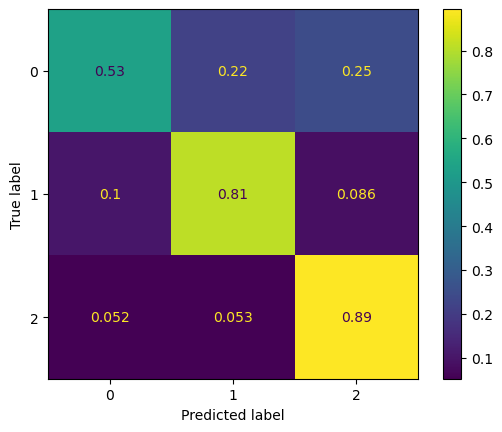

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.72113. Saving Model!
epoch 01, loss: 0.68484, acc: 0.67368, val_loss: 0.72113, val_accuracy: 0.66067


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 02, loss: 0.68660, acc: 0.67268, val_loss: 0.73181, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.18it/s]


epoch 03, loss: 0.68468, acc: 0.67474, val_loss: 0.74293, val_accuracy: 0.65591


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 04, loss: 0.68156, acc: 0.67145, val_loss: 0.75449, val_accuracy: 0.65406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 05, loss: 0.67899, acc: 0.67356, val_loss: 0.76481, val_accuracy: 0.64771


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 06, loss: 0.67710, acc: 0.68423, val_loss: 0.77310, val_accuracy: 0.64533


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 07, loss: 0.67548, acc: 0.68373, val_loss: 0.77972, val_accuracy: 0.59984


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 08, loss: 0.67414, acc: 0.68370, val_loss: 0.78537, val_accuracy: 0.59984


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 09, loss: 0.67315, acc: 0.68443, val_loss: 0.79055, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 10, loss: 0.67230, acc: 0.68590, val_loss: 0.79511, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.24it/s]


epoch 11, loss: 0.67135, acc: 0.68596, val_loss: 0.79879, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 12, loss: 0.67026, acc: 0.68593, val_loss: 0.80230, val_accuracy: 0.59693


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 13, loss: 0.66917, acc: 0.68605, val_loss: 0.80620, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 14, loss: 0.66837, acc: 0.68625, val_loss: 0.80968, val_accuracy: 0.59667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.51it/s]


epoch 15, loss: 0.66766, acc: 0.68581, val_loss: 0.81202, val_accuracy: 0.59667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.18it/s]


epoch 16, loss: 0.66651, acc: 0.68760, val_loss: 0.81493, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 17, loss: 0.66558, acc: 0.68834, val_loss: 0.81828, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.87it/s]


epoch 18, loss: 0.66465, acc: 0.68984, val_loss: 0.82157, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 19, loss: 0.66364, acc: 0.69028, val_loss: 0.82439, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 20, loss: 0.66273, acc: 0.69069, val_loss: 0.82738, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 21, loss: 0.66198, acc: 0.69092, val_loss: 0.83011, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 22, loss: 0.66114, acc: 0.69090, val_loss: 0.83277, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 23, loss: 0.66021, acc: 0.69090, val_loss: 0.83560, val_accuracy: 0.59323


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 24, loss: 0.65940, acc: 0.69087, val_loss: 0.83808, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 25, loss: 0.65845, acc: 0.69128, val_loss: 0.84067, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 26, loss: 0.65775, acc: 0.69122, val_loss: 0.84338, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 27, loss: 0.65696, acc: 0.69513, val_loss: 0.84556, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.44it/s]


epoch 28, loss: 0.65598, acc: 0.69513, val_loss: 0.84803, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 29, loss: 0.65513, acc: 0.69510, val_loss: 0.85086, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 30, loss: 0.65458, acc: 0.69997, val_loss: 0.85270, val_accuracy: 0.59455


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 31, loss: 0.65356, acc: 0.70009, val_loss: 0.85574, val_accuracy: 0.59455


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 32, loss: 0.65287, acc: 0.70024, val_loss: 0.85830, val_accuracy: 0.59508


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 33, loss: 0.65203, acc: 0.70021, val_loss: 0.86112, val_accuracy: 0.59535


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 34, loss: 0.65126, acc: 0.70024, val_loss: 0.86367, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 35, loss: 0.65062, acc: 0.69865, val_loss: 0.86604, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 36, loss: 0.64981, acc: 0.70000, val_loss: 0.86826, val_accuracy: 0.59720


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 37, loss: 0.64890, acc: 0.70012, val_loss: 0.87106, val_accuracy: 0.59693


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 38, loss: 0.64830, acc: 0.70012, val_loss: 0.87348, val_accuracy: 0.59693


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 39, loss: 0.64763, acc: 0.70018, val_loss: 0.87510, val_accuracy: 0.59720


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.42it/s]


epoch 40, loss: 0.64666, acc: 0.70083, val_loss: 0.87766, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 41, loss: 0.64609, acc: 0.70115, val_loss: 0.87998, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 42, loss: 0.64514, acc: 0.70130, val_loss: 0.88303, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 43, loss: 0.64462, acc: 0.70135, val_loss: 0.88525, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 44, loss: 0.64402, acc: 0.70147, val_loss: 0.88701, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 45, loss: 0.64320, acc: 0.70174, val_loss: 0.88875, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 46, loss: 0.64234, acc: 0.70206, val_loss: 0.89106, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 47, loss: 0.64160, acc: 0.70235, val_loss: 0.89342, val_accuracy: 0.59640


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 48, loss: 0.64100, acc: 0.70738, val_loss: 0.89557, val_accuracy: 0.59667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 49, loss: 0.64033, acc: 0.70767, val_loss: 0.89765, val_accuracy: 0.59640


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 50, loss: 0.63968, acc: 0.70838, val_loss: 0.89860, val_accuracy: 0.59640


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 51, loss: 0.63879, acc: 0.70835, val_loss: 0.90038, val_accuracy: 0.59667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 52, loss: 0.63807, acc: 0.70876, val_loss: 0.90324, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 53, loss: 0.63752, acc: 0.70914, val_loss: 0.90580, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 54, loss: 0.63696, acc: 0.70923, val_loss: 0.90708, val_accuracy: 0.59905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 55, loss: 0.63593, acc: 0.70967, val_loss: 0.90952, val_accuracy: 0.59958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 56, loss: 0.63545, acc: 0.70967, val_loss: 0.91081, val_accuracy: 0.59958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 57, loss: 0.63465, acc: 0.70976, val_loss: 0.91269, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 58, loss: 0.63396, acc: 0.71011, val_loss: 0.91470, val_accuracy: 0.60063


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 59, loss: 0.63337, acc: 0.71152, val_loss: 0.91638, val_accuracy: 0.60063


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 60, loss: 0.63275, acc: 0.71158, val_loss: 0.91793, val_accuracy: 0.60011


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 61, loss: 0.63193, acc: 0.71173, val_loss: 0.91932, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 62, loss: 0.63123, acc: 0.71193, val_loss: 0.92110, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 63, loss: 0.63059, acc: 0.71199, val_loss: 0.92339, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 64, loss: 0.63005, acc: 0.71202, val_loss: 0.92487, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 65, loss: 0.62929, acc: 0.71237, val_loss: 0.92682, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 66, loss: 0.62869, acc: 0.71252, val_loss: 0.92832, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 67, loss: 0.62796, acc: 0.71261, val_loss: 0.93008, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


epoch 68, loss: 0.62722, acc: 0.71258, val_loss: 0.93214, val_accuracy: 0.60116


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 69, loss: 0.62682, acc: 0.71270, val_loss: 0.93314, val_accuracy: 0.57842


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 70, loss: 0.62600, acc: 0.71296, val_loss: 0.93509, val_accuracy: 0.60116


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 71, loss: 0.62540, acc: 0.71305, val_loss: 0.93636, val_accuracy: 0.57868


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 72, loss: 0.62479, acc: 0.71317, val_loss: 0.93751, val_accuracy: 0.57842


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]


epoch 73, loss: 0.62396, acc: 0.71331, val_loss: 0.94009, val_accuracy: 0.57842


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 74, loss: 0.62335, acc: 0.71340, val_loss: 0.94235, val_accuracy: 0.57842


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 75, loss: 0.62284, acc: 0.71352, val_loss: 0.94317, val_accuracy: 0.57868


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 76, loss: 0.62211, acc: 0.71361, val_loss: 0.94457, val_accuracy: 0.57868


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 77, loss: 0.62148, acc: 0.71378, val_loss: 0.94665, val_accuracy: 0.57921


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 78, loss: 0.62100, acc: 0.71399, val_loss: 0.94758, val_accuracy: 0.57895


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 79, loss: 0.62019, acc: 0.71402, val_loss: 0.94925, val_accuracy: 0.57948


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 80, loss: 0.61947, acc: 0.71425, val_loss: 0.95135, val_accuracy: 0.57948


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 81, loss: 0.61880, acc: 0.71449, val_loss: 0.95368, val_accuracy: 0.57895


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.09it/s]


epoch 82, loss: 0.61850, acc: 0.71554, val_loss: 0.95475, val_accuracy: 0.57895


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 83, loss: 0.61784, acc: 0.71578, val_loss: 0.95558, val_accuracy: 0.57974


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 84, loss: 0.61682, acc: 0.72045, val_loss: 0.95817, val_accuracy: 0.58027


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 85, loss: 0.61641, acc: 0.72060, val_loss: 0.96001, val_accuracy: 0.58027


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 86, loss: 0.61586, acc: 0.72089, val_loss: 0.96160, val_accuracy: 0.58159


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.81it/s]


epoch 87, loss: 0.61532, acc: 0.72098, val_loss: 0.96204, val_accuracy: 0.58159


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 88, loss: 0.61429, acc: 0.72119, val_loss: 0.96510, val_accuracy: 0.58186


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 89, loss: 0.61408, acc: 0.72119, val_loss: 0.96617, val_accuracy: 0.58212


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 90, loss: 0.61342, acc: 0.72139, val_loss: 0.96738, val_accuracy: 0.58239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 91, loss: 0.61259, acc: 0.72174, val_loss: 0.96924, val_accuracy: 0.58212


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 92, loss: 0.61204, acc: 0.72192, val_loss: 0.97161, val_accuracy: 0.58186


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 93, loss: 0.61152, acc: 0.72224, val_loss: 0.97310, val_accuracy: 0.58212


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 94, loss: 0.61076, acc: 0.72239, val_loss: 0.97486, val_accuracy: 0.58239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 95, loss: 0.61033, acc: 0.72257, val_loss: 0.97603, val_accuracy: 0.58239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 96, loss: 0.60967, acc: 0.72257, val_loss: 0.97778, val_accuracy: 0.58239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 97, loss: 0.60900, acc: 0.72274, val_loss: 0.97966, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.87it/s]


epoch 98, loss: 0.60847, acc: 0.72298, val_loss: 0.98087, val_accuracy: 0.58239


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 99, loss: 0.60783, acc: 0.72298, val_loss: 0.98226, val_accuracy: 0.58291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 100, loss: 0.60708, acc: 0.72362, val_loss: 0.98417, val_accuracy: 0.58318


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 101, loss: 0.60672, acc: 0.72389, val_loss: 0.98527, val_accuracy: 0.58265


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 102, loss: 0.60595, acc: 0.72418, val_loss: 0.98805, val_accuracy: 0.58291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 103, loss: 0.60554, acc: 0.72521, val_loss: 0.98886, val_accuracy: 0.58371


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 104, loss: 0.60485, acc: 0.72527, val_loss: 0.99001, val_accuracy: 0.58424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 105, loss: 0.60417, acc: 0.72550, val_loss: 0.99204, val_accuracy: 0.58397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 106, loss: 0.60364, acc: 0.72553, val_loss: 0.99344, val_accuracy: 0.58424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 107, loss: 0.60304, acc: 0.72592, val_loss: 0.99391, val_accuracy: 0.58424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 108, loss: 0.60232, acc: 0.72630, val_loss: 0.99623, val_accuracy: 0.58477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 109, loss: 0.60184, acc: 0.72639, val_loss: 0.99838, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 110, loss: 0.60129, acc: 0.72656, val_loss: 0.99920, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 111, loss: 0.60059, acc: 0.72653, val_loss: 1.00063, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 112, loss: 0.60015, acc: 0.72647, val_loss: 1.00190, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 113, loss: 0.59954, acc: 0.72621, val_loss: 1.00315, val_accuracy: 0.58397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 114, loss: 0.59886, acc: 0.72627, val_loss: 1.00509, val_accuracy: 0.58371


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 115, loss: 0.59845, acc: 0.72556, val_loss: 1.00627, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.73it/s]


epoch 116, loss: 0.59776, acc: 0.72533, val_loss: 1.00759, val_accuracy: 0.58397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 117, loss: 0.59712, acc: 0.72545, val_loss: 1.01028, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 118, loss: 0.59680, acc: 0.72592, val_loss: 1.01046, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 119, loss: 0.59587, acc: 0.72609, val_loss: 1.01258, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 120, loss: 0.59565, acc: 0.72609, val_loss: 1.01361, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 121, loss: 0.59482, acc: 0.72615, val_loss: 1.01480, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 122, loss: 0.59423, acc: 0.72636, val_loss: 1.01628, val_accuracy: 0.58477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 123, loss: 0.59389, acc: 0.72677, val_loss: 1.01700, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 124, loss: 0.59315, acc: 0.72662, val_loss: 1.01869, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 125, loss: 0.59271, acc: 0.72862, val_loss: 1.02042, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 126, loss: 0.59207, acc: 0.72877, val_loss: 1.02120, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 127, loss: 0.59155, acc: 0.72950, val_loss: 1.02193, val_accuracy: 0.58450


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.80it/s]


epoch 128, loss: 0.59075, acc: 0.72941, val_loss: 1.02459, val_accuracy: 0.58477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 129, loss: 0.59043, acc: 0.72888, val_loss: 1.02553, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]


epoch 130, loss: 0.58983, acc: 0.72947, val_loss: 1.02645, val_accuracy: 0.58503


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 131, loss: 0.58936, acc: 0.72982, val_loss: 1.02708, val_accuracy: 0.58477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.87it/s]


epoch 132, loss: 0.58852, acc: 0.72997, val_loss: 1.02925, val_accuracy: 0.58582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 133, loss: 0.58805, acc: 0.72974, val_loss: 1.03052, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.59it/s]


epoch 134, loss: 0.58754, acc: 0.72971, val_loss: 1.03163, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 135, loss: 0.58698, acc: 0.72991, val_loss: 1.03321, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 136, loss: 0.58661, acc: 0.73000, val_loss: 1.03479, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 137, loss: 0.58601, acc: 0.72994, val_loss: 1.03509, val_accuracy: 0.58529


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 138, loss: 0.58504, acc: 0.73006, val_loss: 1.03818, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 139, loss: 0.58491, acc: 0.73026, val_loss: 1.03976, val_accuracy: 0.58609


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 140, loss: 0.58417, acc: 0.73035, val_loss: 1.04091, val_accuracy: 0.58582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 141, loss: 0.58368, acc: 0.73032, val_loss: 1.04197, val_accuracy: 0.58582


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 142, loss: 0.58342, acc: 0.73282, val_loss: 1.04224, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 143, loss: 0.58214, acc: 0.73297, val_loss: 1.04541, val_accuracy: 0.58635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 144, loss: 0.58207, acc: 0.73308, val_loss: 1.04703, val_accuracy: 0.58371


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 145, loss: 0.58180, acc: 0.73690, val_loss: 1.04722, val_accuracy: 0.58344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 146, loss: 0.58087, acc: 0.73687, val_loss: 1.04766, val_accuracy: 0.58318


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.88it/s]


epoch 147, loss: 0.58013, acc: 0.73714, val_loss: 1.04994, val_accuracy: 0.58609


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 148, loss: 0.57994, acc: 0.73702, val_loss: 1.05210, val_accuracy: 0.58371


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 149, loss: 0.57938, acc: 0.74052, val_loss: 1.05277, val_accuracy: 0.58344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 150, loss: 0.57863, acc: 0.74072, val_loss: 1.05331, val_accuracy: 0.58291


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 151, loss: 0.57820, acc: 0.74084, val_loss: 1.05514, val_accuracy: 0.58318


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.28it/s]


epoch 152, loss: 0.57759, acc: 0.74090, val_loss: 1.05663, val_accuracy: 0.58344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 153, loss: 0.57694, acc: 0.74105, val_loss: 1.05861, val_accuracy: 0.58318


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 154, loss: 0.57666, acc: 0.74105, val_loss: 1.05930, val_accuracy: 0.58344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 155, loss: 0.57583, acc: 0.74193, val_loss: 1.06002, val_accuracy: 0.58344


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 156, loss: 0.57536, acc: 0.74213, val_loss: 1.06160, val_accuracy: 0.58371


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 157, loss: 0.57471, acc: 0.74205, val_loss: 1.06308, val_accuracy: 0.58424


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 158, loss: 0.57416, acc: 0.74210, val_loss: 1.06416, val_accuracy: 0.58397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 159, loss: 0.57362, acc: 0.74210, val_loss: 1.06587, val_accuracy: 0.58397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 160, loss: 0.57326, acc: 0.74266, val_loss: 1.06708, val_accuracy: 0.58397


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 161, loss: 0.57251, acc: 0.74278, val_loss: 1.06753, val_accuracy: 0.58477


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 162, loss: 0.57198, acc: 0.74269, val_loss: 1.06869, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 163, loss: 0.57153, acc: 0.74278, val_loss: 1.07038, val_accuracy: 0.58556


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 164, loss: 0.57092, acc: 0.74296, val_loss: 1.07134, val_accuracy: 0.58609


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 165, loss: 0.57023, acc: 0.74322, val_loss: 1.07290, val_accuracy: 0.58609


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 166, loss: 0.56991, acc: 0.74343, val_loss: 1.07431, val_accuracy: 0.58635


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 167, loss: 0.56919, acc: 0.74381, val_loss: 1.07639, val_accuracy: 0.58662


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 168, loss: 0.56857, acc: 0.74407, val_loss: 1.07752, val_accuracy: 0.58715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 169, loss: 0.56833, acc: 0.74396, val_loss: 1.07756, val_accuracy: 0.59006


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 170, loss: 0.56763, acc: 0.74398, val_loss: 1.07970, val_accuracy: 0.59032


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 171, loss: 0.56725, acc: 0.74563, val_loss: 1.07992, val_accuracy: 0.59058


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 172, loss: 0.56671, acc: 0.74545, val_loss: 1.08145, val_accuracy: 0.59085


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 173, loss: 0.56592, acc: 0.74422, val_loss: 1.08304, val_accuracy: 0.59191


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 174, loss: 0.56561, acc: 0.74595, val_loss: 1.08339, val_accuracy: 0.59191


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 175, loss: 0.56495, acc: 0.74595, val_loss: 1.08478, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 176, loss: 0.56435, acc: 0.74951, val_loss: 1.08615, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 177, loss: 0.56396, acc: 0.74963, val_loss: 1.08732, val_accuracy: 0.59217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 178, loss: 0.56351, acc: 0.74960, val_loss: 1.08809, val_accuracy: 0.59244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 179, loss: 0.56282, acc: 0.74980, val_loss: 1.09062, val_accuracy: 0.59244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 180, loss: 0.56240, acc: 0.74998, val_loss: 1.09091, val_accuracy: 0.59270


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 181, loss: 0.56187, acc: 0.74998, val_loss: 1.09161, val_accuracy: 0.59217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 182, loss: 0.56116, acc: 0.75139, val_loss: 1.09473, val_accuracy: 0.59270


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 183, loss: 0.56091, acc: 0.75154, val_loss: 1.09474, val_accuracy: 0.59217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 184, loss: 0.56024, acc: 0.75151, val_loss: 1.09688, val_accuracy: 0.59270


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 185, loss: 0.55978, acc: 0.75156, val_loss: 1.09686, val_accuracy: 0.59244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 186, loss: 0.55907, acc: 0.75156, val_loss: 1.09850, val_accuracy: 0.59270


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 187, loss: 0.55865, acc: 0.75245, val_loss: 1.10051, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 188, loss: 0.55806, acc: 0.75250, val_loss: 1.10204, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 189, loss: 0.55775, acc: 0.75221, val_loss: 1.10191, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.07it/s]


epoch 190, loss: 0.55715, acc: 0.75248, val_loss: 1.10385, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 191, loss: 0.55647, acc: 0.75259, val_loss: 1.10575, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.25it/s]


epoch 192, loss: 0.55611, acc: 0.75253, val_loss: 1.10667, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 193, loss: 0.55551, acc: 0.75274, val_loss: 1.10726, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 194, loss: 0.55506, acc: 0.75286, val_loss: 1.10938, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 195, loss: 0.55468, acc: 0.75283, val_loss: 1.11115, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 196, loss: 0.55398, acc: 0.75286, val_loss: 1.11242, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


epoch 197, loss: 0.55361, acc: 0.75359, val_loss: 1.11258, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 198, loss: 0.55303, acc: 0.75312, val_loss: 1.11291, val_accuracy: 0.59296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 199, loss: 0.55259, acc: 0.75277, val_loss: 1.11488, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.83it/s]


epoch 200, loss: 0.55198, acc: 0.75303, val_loss: 1.11665, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 201, loss: 0.55165, acc: 0.75297, val_loss: 1.11720, val_accuracy: 0.59323


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 202, loss: 0.55112, acc: 0.75324, val_loss: 1.11831, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 203, loss: 0.55030, acc: 0.75339, val_loss: 1.12176, val_accuracy: 0.59482


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 204, loss: 0.55034, acc: 0.75330, val_loss: 1.12181, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 205, loss: 0.54943, acc: 0.75389, val_loss: 1.12329, val_accuracy: 0.59429


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.29it/s]


epoch 206, loss: 0.54905, acc: 0.75412, val_loss: 1.12395, val_accuracy: 0.59455


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 207, loss: 0.54858, acc: 0.75418, val_loss: 1.12437, val_accuracy: 0.59429


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 208, loss: 0.54817, acc: 0.75438, val_loss: 1.12657, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 209, loss: 0.54757, acc: 0.75488, val_loss: 1.12800, val_accuracy: 0.59852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 210, loss: 0.54702, acc: 0.75480, val_loss: 1.12848, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 211, loss: 0.54675, acc: 0.75474, val_loss: 1.12927, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.12it/s]


epoch 212, loss: 0.54619, acc: 0.75471, val_loss: 1.13057, val_accuracy: 0.60116


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 213, loss: 0.54555, acc: 0.75483, val_loss: 1.13283, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 214, loss: 0.54524, acc: 0.75512, val_loss: 1.13306, val_accuracy: 0.60407


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 215, loss: 0.54467, acc: 0.75512, val_loss: 1.13425, val_accuracy: 0.60513


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.85it/s]


epoch 216, loss: 0.54413, acc: 0.75057, val_loss: 1.13589, val_accuracy: 0.60487


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 217, loss: 0.54407, acc: 0.75059, val_loss: 1.13538, val_accuracy: 0.60487


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.63it/s]


epoch 218, loss: 0.54290, acc: 0.75585, val_loss: 1.13891, val_accuracy: 0.60566


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 219, loss: 0.54290, acc: 0.75588, val_loss: 1.13912, val_accuracy: 0.60540


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 220, loss: 0.54237, acc: 0.75107, val_loss: 1.14047, val_accuracy: 0.60540


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 221, loss: 0.54183, acc: 0.75112, val_loss: 1.14064, val_accuracy: 0.60540


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 222, loss: 0.54138, acc: 0.75735, val_loss: 1.14250, val_accuracy: 0.60592


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 223, loss: 0.54081, acc: 0.75779, val_loss: 1.14337, val_accuracy: 0.60619


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 224, loss: 0.54045, acc: 0.75803, val_loss: 1.14416, val_accuracy: 0.60592


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 225, loss: 0.54009, acc: 0.75800, val_loss: 1.14530, val_accuracy: 0.60619


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 226, loss: 0.53943, acc: 0.75967, val_loss: 1.14636, val_accuracy: 0.60592


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 227, loss: 0.53889, acc: 0.75985, val_loss: 1.14698, val_accuracy: 0.60619


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 228, loss: 0.53853, acc: 0.75991, val_loss: 1.14827, val_accuracy: 0.60619


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 229, loss: 0.53782, acc: 0.76003, val_loss: 1.15049, val_accuracy: 0.60619


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 230, loss: 0.53772, acc: 0.75997, val_loss: 1.15080, val_accuracy: 0.60645


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 231, loss: 0.53717, acc: 0.75994, val_loss: 1.15273, val_accuracy: 0.60672


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 232, loss: 0.53658, acc: 0.76003, val_loss: 1.15387, val_accuracy: 0.60672


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 233, loss: 0.53641, acc: 0.76003, val_loss: 1.15262, val_accuracy: 0.60645


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 234, loss: 0.53548, acc: 0.76023, val_loss: 1.15460, val_accuracy: 0.60698


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 235, loss: 0.53538, acc: 0.76050, val_loss: 1.15495, val_accuracy: 0.60645


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 236, loss: 0.53457, acc: 0.76047, val_loss: 1.15835, val_accuracy: 0.60857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 237, loss: 0.53441, acc: 0.76029, val_loss: 1.15851, val_accuracy: 0.60698


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 238, loss: 0.53417, acc: 0.76029, val_loss: 1.15678, val_accuracy: 0.60936


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 239, loss: 0.53318, acc: 0.76050, val_loss: 1.15995, val_accuracy: 0.60989


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 240, loss: 0.53313, acc: 0.76053, val_loss: 1.16172, val_accuracy: 0.60989


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 241, loss: 0.53252, acc: 0.76017, val_loss: 1.16324, val_accuracy: 0.61016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.02it/s]


epoch 242, loss: 0.53204, acc: 0.76014, val_loss: 1.16337, val_accuracy: 0.61042


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 243, loss: 0.53162, acc: 0.76020, val_loss: 1.16363, val_accuracy: 0.60989


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 244, loss: 0.53097, acc: 0.75829, val_loss: 1.16610, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 245, loss: 0.53060, acc: 0.75862, val_loss: 1.16603, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 246, loss: 0.53032, acc: 0.75876, val_loss: 1.16564, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.20it/s]


epoch 247, loss: 0.52938, acc: 0.75897, val_loss: 1.16895, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.65it/s]


epoch 248, loss: 0.52957, acc: 0.75906, val_loss: 1.16872, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 249, loss: 0.52905, acc: 0.75888, val_loss: 1.16893, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 250, loss: 0.52797, acc: 0.76070, val_loss: 1.17141, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 251, loss: 0.52810, acc: 0.75979, val_loss: 1.17096, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 252, loss: 0.52758, acc: 0.75985, val_loss: 1.17197, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 253, loss: 0.52676, acc: 0.76006, val_loss: 1.17396, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.74it/s]


epoch 254, loss: 0.52678, acc: 0.75991, val_loss: 1.17287, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 255, loss: 0.52616, acc: 0.75997, val_loss: 1.17521, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 256, loss: 0.52565, acc: 0.76017, val_loss: 1.17617, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 257, loss: 0.52536, acc: 0.76158, val_loss: 1.17623, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 258, loss: 0.52463, acc: 0.76179, val_loss: 1.17664, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.99it/s]


epoch 259, loss: 0.52447, acc: 0.76246, val_loss: 1.17715, val_accuracy: 0.61148


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.18it/s]


epoch 260, loss: 0.52367, acc: 0.76258, val_loss: 1.17933, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 261, loss: 0.52368, acc: 0.76249, val_loss: 1.18013, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 262, loss: 0.52297, acc: 0.76326, val_loss: 1.17998, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 263, loss: 0.52233, acc: 0.76367, val_loss: 1.18052, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 264, loss: 0.52220, acc: 0.76379, val_loss: 1.18109, val_accuracy: 0.61227


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 265, loss: 0.52152, acc: 0.76534, val_loss: 1.18239, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 266, loss: 0.52112, acc: 0.76561, val_loss: 1.18304, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 267, loss: 0.52089, acc: 0.76432, val_loss: 1.18354, val_accuracy: 0.61280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 268, loss: 0.52027, acc: 0.76602, val_loss: 1.18338, val_accuracy: 0.61280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 269, loss: 0.51968, acc: 0.76608, val_loss: 1.18488, val_accuracy: 0.61333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 270, loss: 0.51939, acc: 0.76631, val_loss: 1.18594, val_accuracy: 0.61333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 271, loss: 0.51912, acc: 0.76637, val_loss: 1.18557, val_accuracy: 0.61359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.46it/s]


epoch 272, loss: 0.51834, acc: 0.76631, val_loss: 1.18797, val_accuracy: 0.61359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 273, loss: 0.51805, acc: 0.76667, val_loss: 1.18987, val_accuracy: 0.61359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 274, loss: 0.51785, acc: 0.76667, val_loss: 1.18907, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 275, loss: 0.51691, acc: 0.76722, val_loss: 1.19077, val_accuracy: 0.61439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.79it/s]


epoch 276, loss: 0.51698, acc: 0.76731, val_loss: 1.18953, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 277, loss: 0.51646, acc: 0.76661, val_loss: 1.18900, val_accuracy: 0.61412


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 278, loss: 0.51546, acc: 0.76725, val_loss: 1.19281, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 279, loss: 0.51537, acc: 0.76852, val_loss: 1.19345, val_accuracy: 0.61439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 280, loss: 0.51505, acc: 0.76843, val_loss: 1.19426, val_accuracy: 0.61439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 281, loss: 0.51444, acc: 0.76860, val_loss: 1.19552, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 282, loss: 0.51425, acc: 0.76849, val_loss: 1.19363, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 283, loss: 0.51349, acc: 0.76846, val_loss: 1.19606, val_accuracy: 0.61412


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 284, loss: 0.51331, acc: 0.76840, val_loss: 1.19611, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.74it/s]


epoch 285, loss: 0.51270, acc: 0.76878, val_loss: 1.19674, val_accuracy: 0.61439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.02it/s]


epoch 286, loss: 0.51214, acc: 0.76872, val_loss: 1.19664, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 287, loss: 0.51148, acc: 0.76875, val_loss: 1.19888, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 288, loss: 0.51165, acc: 0.76907, val_loss: 1.20035, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 289, loss: 0.51109, acc: 0.76890, val_loss: 1.19904, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 290, loss: 0.51010, acc: 0.76931, val_loss: 1.20101, val_accuracy: 0.61730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 291, loss: 0.51022, acc: 0.76922, val_loss: 1.20105, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 292, loss: 0.50971, acc: 0.76893, val_loss: 1.20041, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 293, loss: 0.50880, acc: 0.76919, val_loss: 1.20351, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 294, loss: 0.50904, acc: 0.76884, val_loss: 1.20258, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 295, loss: 0.50799, acc: 0.76943, val_loss: 1.20631, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


epoch 296, loss: 0.50804, acc: 0.76946, val_loss: 1.20656, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 297, loss: 0.50732, acc: 0.76881, val_loss: 1.20767, val_accuracy: 0.61835


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 298, loss: 0.50694, acc: 0.76919, val_loss: 1.20680, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 299, loss: 0.50652, acc: 0.76978, val_loss: 1.20787, val_accuracy: 0.61783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 300, loss: 0.50568, acc: 0.76993, val_loss: 1.21202, val_accuracy: 0.62047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 301, loss: 0.50625, acc: 0.77028, val_loss: 1.20785, val_accuracy: 0.61862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 302, loss: 0.50479, acc: 0.77028, val_loss: 1.21064, val_accuracy: 0.61994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 303, loss: 0.50457, acc: 0.77049, val_loss: 1.21339, val_accuracy: 0.62047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 304, loss: 0.50452, acc: 0.77049, val_loss: 1.21292, val_accuracy: 0.61994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 305, loss: 0.50369, acc: 0.77060, val_loss: 1.21281, val_accuracy: 0.61968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 306, loss: 0.50367, acc: 0.77054, val_loss: 1.21298, val_accuracy: 0.61968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 307, loss: 0.50269, acc: 0.77084, val_loss: 1.21527, val_accuracy: 0.62126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 308, loss: 0.50268, acc: 0.77107, val_loss: 1.21495, val_accuracy: 0.62126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.33it/s]


epoch 309, loss: 0.50218, acc: 0.77122, val_loss: 1.21507, val_accuracy: 0.62047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 310, loss: 0.50162, acc: 0.77125, val_loss: 1.21784, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 311, loss: 0.50151, acc: 0.77119, val_loss: 1.21708, val_accuracy: 0.62047


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.92it/s]


epoch 312, loss: 0.50045, acc: 0.77143, val_loss: 1.22153, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 313, loss: 0.50064, acc: 0.77151, val_loss: 1.22120, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 314, loss: 0.50002, acc: 0.77175, val_loss: 1.22114, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 315, loss: 0.49945, acc: 0.77322, val_loss: 1.22279, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 316, loss: 0.49913, acc: 0.77331, val_loss: 1.22248, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.56it/s]


epoch 317, loss: 0.49862, acc: 0.77366, val_loss: 1.22372, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 318, loss: 0.49845, acc: 0.77360, val_loss: 1.22457, val_accuracy: 0.62126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 319, loss: 0.49779, acc: 0.77372, val_loss: 1.22385, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.97it/s]


epoch 320, loss: 0.49732, acc: 0.77375, val_loss: 1.22547, val_accuracy: 0.62259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.21it/s]


epoch 321, loss: 0.49688, acc: 0.77436, val_loss: 1.22746, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 322, loss: 0.49680, acc: 0.77389, val_loss: 1.22754, val_accuracy: 0.62232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 323, loss: 0.49617, acc: 0.77430, val_loss: 1.22690, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.52it/s]


epoch 324, loss: 0.49560, acc: 0.77442, val_loss: 1.22790, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.78it/s]


epoch 325, loss: 0.49498, acc: 0.77436, val_loss: 1.22957, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.07it/s]


epoch 326, loss: 0.49528, acc: 0.77430, val_loss: 1.22851, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 327, loss: 0.49392, acc: 0.77448, val_loss: 1.23168, val_accuracy: 0.62285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 328, loss: 0.49442, acc: 0.77472, val_loss: 1.22972, val_accuracy: 0.62206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 329, loss: 0.49293, acc: 0.77489, val_loss: 1.23356, val_accuracy: 0.62259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 330, loss: 0.49331, acc: 0.77501, val_loss: 1.23363, val_accuracy: 0.62232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 331, loss: 0.49262, acc: 0.77510, val_loss: 1.23337, val_accuracy: 0.62232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 332, loss: 0.49235, acc: 0.77527, val_loss: 1.23338, val_accuracy: 0.62285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 333, loss: 0.49162, acc: 0.77554, val_loss: 1.23414, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 334, loss: 0.49149, acc: 0.77557, val_loss: 1.23538, val_accuracy: 0.62259


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 335, loss: 0.49087, acc: 0.77566, val_loss: 1.23655, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 336, loss: 0.49036, acc: 0.77580, val_loss: 1.23700, val_accuracy: 0.62364


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 337, loss: 0.49028, acc: 0.77595, val_loss: 1.23615, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 338, loss: 0.48951, acc: 0.78097, val_loss: 1.23877, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 339, loss: 0.48935, acc: 0.78106, val_loss: 1.23576, val_accuracy: 0.62021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 340, loss: 0.48864, acc: 0.78470, val_loss: 1.23869, val_accuracy: 0.62338


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 341, loss: 0.48855, acc: 0.78091, val_loss: 1.23971, val_accuracy: 0.62021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 342, loss: 0.48768, acc: 0.78494, val_loss: 1.24108, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 343, loss: 0.48769, acc: 0.78523, val_loss: 1.24046, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 344, loss: 0.48715, acc: 0.78500, val_loss: 1.23968, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 345, loss: 0.48637, acc: 0.78515, val_loss: 1.24214, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.08it/s]


epoch 346, loss: 0.48669, acc: 0.78018, val_loss: 1.24183, val_accuracy: 0.62232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 347, loss: 0.48586, acc: 0.78529, val_loss: 1.24285, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 348, loss: 0.48518, acc: 0.78506, val_loss: 1.24299, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 349, loss: 0.48523, acc: 0.78509, val_loss: 1.24382, val_accuracy: 0.62444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 350, loss: 0.48452, acc: 0.78517, val_loss: 1.24318, val_accuracy: 0.62576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 351, loss: 0.48395, acc: 0.78526, val_loss: 1.24368, val_accuracy: 0.62576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 352, loss: 0.48372, acc: 0.77997, val_loss: 1.24327, val_accuracy: 0.62602


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.75it/s]


epoch 353, loss: 0.48350, acc: 0.78523, val_loss: 1.24354, val_accuracy: 0.62602


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.38it/s]


epoch 354, loss: 0.48264, acc: 0.78553, val_loss: 1.24235, val_accuracy: 0.62788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 355, loss: 0.48254, acc: 0.78538, val_loss: 1.24222, val_accuracy: 0.62550


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 356, loss: 0.48175, acc: 0.78559, val_loss: 1.24584, val_accuracy: 0.62576


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 357, loss: 0.48154, acc: 0.78585, val_loss: 1.24399, val_accuracy: 0.62946


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 358, loss: 0.48098, acc: 0.78576, val_loss: 1.24363, val_accuracy: 0.62867


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.92it/s]


epoch 359, loss: 0.48090, acc: 0.78588, val_loss: 1.24568, val_accuracy: 0.62761


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 360, loss: 0.47999, acc: 0.78603, val_loss: 1.24667, val_accuracy: 0.62788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 361, loss: 0.47999, acc: 0.78656, val_loss: 1.24647, val_accuracy: 0.62999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 362, loss: 0.47889, acc: 0.78706, val_loss: 1.24888, val_accuracy: 0.62788


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 363, loss: 0.47955, acc: 0.78720, val_loss: 1.24384, val_accuracy: 0.62893


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 364, loss: 0.47815, acc: 0.78653, val_loss: 1.24807, val_accuracy: 0.60857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 365, loss: 0.47790, acc: 0.78700, val_loss: 1.24891, val_accuracy: 0.60804


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 366, loss: 0.47796, acc: 0.78723, val_loss: 1.24737, val_accuracy: 0.62999


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 367, loss: 0.47661, acc: 0.78764, val_loss: 1.25044, val_accuracy: 0.62893


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 368, loss: 0.47751, acc: 0.78785, val_loss: 1.24732, val_accuracy: 0.60778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 369, loss: 0.47608, acc: 0.78776, val_loss: 1.25129, val_accuracy: 0.60936


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 370, loss: 0.47605, acc: 0.78976, val_loss: 1.25109, val_accuracy: 0.60936


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 371, loss: 0.47559, acc: 0.78811, val_loss: 1.25073, val_accuracy: 0.60883


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 372, loss: 0.47552, acc: 0.78805, val_loss: 1.25007, val_accuracy: 0.60883


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 373, loss: 0.47468, acc: 0.78808, val_loss: 1.25304, val_accuracy: 0.60725


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.19it/s]


epoch 374, loss: 0.47439, acc: 0.78835, val_loss: 1.25125, val_accuracy: 0.60725


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 375, loss: 0.47412, acc: 0.78805, val_loss: 1.25188, val_accuracy: 0.60936


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 376, loss: 0.47336, acc: 0.78999, val_loss: 1.25452, val_accuracy: 0.60989


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 377, loss: 0.47360, acc: 0.78835, val_loss: 1.25264, val_accuracy: 0.60910


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 378, loss: 0.47231, acc: 0.78847, val_loss: 1.25506, val_accuracy: 0.60778


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 379, loss: 0.47250, acc: 0.78855, val_loss: 1.25629, val_accuracy: 0.60936


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 380, loss: 0.47216, acc: 0.78914, val_loss: 1.25603, val_accuracy: 0.60857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.71it/s]


epoch 381, loss: 0.47122, acc: 0.78876, val_loss: 1.25785, val_accuracy: 0.60883


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


epoch 382, loss: 0.47155, acc: 0.78873, val_loss: 1.25681, val_accuracy: 0.60857


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 383, loss: 0.47043, acc: 0.78896, val_loss: 1.25803, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 384, loss: 0.47026, acc: 0.79123, val_loss: 1.25877, val_accuracy: 0.61016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 385, loss: 0.47009, acc: 0.79126, val_loss: 1.25644, val_accuracy: 0.61016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 386, loss: 0.46936, acc: 0.78949, val_loss: 1.25781, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 387, loss: 0.46879, acc: 0.79137, val_loss: 1.25909, val_accuracy: 0.60910


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 388, loss: 0.46871, acc: 0.79134, val_loss: 1.26008, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 389, loss: 0.46811, acc: 0.79164, val_loss: 1.25806, val_accuracy: 0.61069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 390, loss: 0.46784, acc: 0.79093, val_loss: 1.25955, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 391, loss: 0.46740, acc: 0.79187, val_loss: 1.25932, val_accuracy: 0.61042


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.86it/s]


epoch 392, loss: 0.46708, acc: 0.79173, val_loss: 1.25941, val_accuracy: 0.61016


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 393, loss: 0.46630, acc: 0.79179, val_loss: 1.26037, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 394, loss: 0.46655, acc: 0.79179, val_loss: 1.25833, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 395, loss: 0.46508, acc: 0.79228, val_loss: 1.26244, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 396, loss: 0.46620, acc: 0.79211, val_loss: 1.25954, val_accuracy: 0.61042


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 397, loss: 0.46425, acc: 0.79672, val_loss: 1.26320, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 398, loss: 0.46450, acc: 0.79323, val_loss: 1.26289, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 399, loss: 0.46413, acc: 0.79255, val_loss: 1.26251, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 400, loss: 0.46372, acc: 0.79361, val_loss: 1.26351, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 401, loss: 0.46299, acc: 0.79287, val_loss: 1.26303, val_accuracy: 0.61095


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 402, loss: 0.46315, acc: 0.79284, val_loss: 1.26255, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 403, loss: 0.46208, acc: 0.79402, val_loss: 1.26512, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 404, loss: 0.46223, acc: 0.79299, val_loss: 1.26483, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 405, loss: 0.46137, acc: 0.79393, val_loss: 1.26557, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.95it/s]


epoch 406, loss: 0.46102, acc: 0.79396, val_loss: 1.26531, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 407, loss: 0.46082, acc: 0.79408, val_loss: 1.26417, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 408, loss: 0.46025, acc: 0.79340, val_loss: 1.26516, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 409, loss: 0.46017, acc: 0.79352, val_loss: 1.26861, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


epoch 410, loss: 0.45956, acc: 0.79370, val_loss: 1.26904, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 411, loss: 0.45903, acc: 0.79446, val_loss: 1.26834, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 412, loss: 0.45910, acc: 0.79449, val_loss: 1.26822, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 413, loss: 0.45793, acc: 0.79969, val_loss: 1.27200, val_accuracy: 0.61280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 414, loss: 0.45850, acc: 0.79487, val_loss: 1.26858, val_accuracy: 0.61174


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 415, loss: 0.45725, acc: 0.80116, val_loss: 1.27195, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 416, loss: 0.45740, acc: 0.79986, val_loss: 1.27053, val_accuracy: 0.61227


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 417, loss: 0.45689, acc: 0.80192, val_loss: 1.26923, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 418, loss: 0.45618, acc: 0.79654, val_loss: 1.27181, val_accuracy: 0.61201


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


epoch 419, loss: 0.45589, acc: 0.79743, val_loss: 1.27220, val_accuracy: 0.61254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 420, loss: 0.45587, acc: 0.79687, val_loss: 1.27255, val_accuracy: 0.61254


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 421, loss: 0.45474, acc: 0.80172, val_loss: 1.27629, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 422, loss: 0.45534, acc: 0.79690, val_loss: 1.27135, val_accuracy: 0.61227


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 423, loss: 0.45385, acc: 0.79696, val_loss: 1.27524, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 424, loss: 0.45418, acc: 0.79769, val_loss: 1.27792, val_accuracy: 0.61280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 425, loss: 0.45362, acc: 0.80248, val_loss: 1.27815, val_accuracy: 0.61280


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 426, loss: 0.45328, acc: 0.80703, val_loss: 1.27697, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 427, loss: 0.45238, acc: 0.80307, val_loss: 1.28088, val_accuracy: 0.61359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 428, loss: 0.45289, acc: 0.80301, val_loss: 1.27898, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 429, loss: 0.45175, acc: 0.80797, val_loss: 1.27981, val_accuracy: 0.61333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.75it/s]


epoch 430, loss: 0.45144, acc: 0.80830, val_loss: 1.27983, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 431, loss: 0.45125, acc: 0.80360, val_loss: 1.27960, val_accuracy: 0.61359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.94it/s]


epoch 432, loss: 0.45107, acc: 0.80815, val_loss: 1.28099, val_accuracy: 0.61069


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


epoch 433, loss: 0.45022, acc: 0.80830, val_loss: 1.28286, val_accuracy: 0.61333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 434, loss: 0.45048, acc: 0.80844, val_loss: 1.27977, val_accuracy: 0.61121


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 435, loss: 0.44939, acc: 0.80888, val_loss: 1.28232, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 436, loss: 0.44926, acc: 0.80915, val_loss: 1.28515, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 437, loss: 0.44908, acc: 0.80900, val_loss: 1.28581, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 438, loss: 0.44837, acc: 0.80909, val_loss: 1.28353, val_accuracy: 0.61307


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.56it/s]


epoch 439, loss: 0.44858, acc: 0.80897, val_loss: 1.28651, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.46it/s]


epoch 440, loss: 0.44760, acc: 0.80956, val_loss: 1.28720, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 441, loss: 0.44722, acc: 0.80938, val_loss: 1.28458, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 442, loss: 0.44707, acc: 0.80480, val_loss: 1.28798, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 443, loss: 0.44679, acc: 0.80982, val_loss: 1.28978, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.38it/s]


epoch 444, loss: 0.44593, acc: 0.81012, val_loss: 1.29091, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 445, loss: 0.44625, acc: 0.81129, val_loss: 1.28813, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 446, loss: 0.44518, acc: 0.80574, val_loss: 1.29212, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 447, loss: 0.44550, acc: 0.81006, val_loss: 1.29364, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.85it/s]


epoch 448, loss: 0.44441, acc: 0.81106, val_loss: 1.29353, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 449, loss: 0.44460, acc: 0.81129, val_loss: 1.29261, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 450, loss: 0.44383, acc: 0.81267, val_loss: 1.29344, val_accuracy: 0.61730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 451, loss: 0.44371, acc: 0.81138, val_loss: 1.29378, val_accuracy: 0.61333


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 452, loss: 0.44337, acc: 0.81267, val_loss: 1.29617, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 453, loss: 0.44289, acc: 0.81165, val_loss: 1.29479, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 454, loss: 0.44279, acc: 0.81217, val_loss: 1.29581, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.92it/s]


epoch 455, loss: 0.44190, acc: 0.81306, val_loss: 1.29803, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.29it/s]


epoch 456, loss: 0.44195, acc: 0.81329, val_loss: 1.29679, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 457, loss: 0.44129, acc: 0.81303, val_loss: 1.29853, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 458, loss: 0.44131, acc: 0.80891, val_loss: 1.29533, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.39it/s]


epoch 459, loss: 0.44075, acc: 0.81250, val_loss: 1.29706, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 460, loss: 0.44023, acc: 0.81314, val_loss: 1.29764, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 461, loss: 0.44014, acc: 0.81332, val_loss: 1.29726, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.77it/s]


epoch 462, loss: 0.43896, acc: 0.81441, val_loss: 1.29769, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 463, loss: 0.43948, acc: 0.81344, val_loss: 1.29903, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 464, loss: 0.43901, acc: 0.81370, val_loss: 1.29721, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.37it/s]


epoch 465, loss: 0.43825, acc: 0.81382, val_loss: 1.30175, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 466, loss: 0.43846, acc: 0.81388, val_loss: 1.30006, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 467, loss: 0.43789, acc: 0.81406, val_loss: 1.29935, val_accuracy: 0.61915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.14it/s]


epoch 468, loss: 0.43688, acc: 0.81438, val_loss: 1.30301, val_accuracy: 0.61968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 469, loss: 0.43718, acc: 0.81414, val_loss: 1.30305, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 470, loss: 0.43673, acc: 0.81376, val_loss: 1.30226, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 471, loss: 0.43593, acc: 0.81464, val_loss: 1.30243, val_accuracy: 0.61941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 472, loss: 0.43614, acc: 0.81385, val_loss: 1.30296, val_accuracy: 0.61783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 473, loss: 0.43570, acc: 0.81414, val_loss: 1.30192, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


epoch 474, loss: 0.43514, acc: 0.81414, val_loss: 1.30599, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 475, loss: 0.43526, acc: 0.81455, val_loss: 1.30345, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 476, loss: 0.43451, acc: 0.81414, val_loss: 1.30613, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 477, loss: 0.43408, acc: 0.81455, val_loss: 1.30823, val_accuracy: 0.62021


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 478, loss: 0.43442, acc: 0.81508, val_loss: 1.30953, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.36it/s]


epoch 479, loss: 0.43331, acc: 0.81021, val_loss: 1.31011, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 480, loss: 0.43353, acc: 0.81500, val_loss: 1.30615, val_accuracy: 0.61968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 481, loss: 0.43288, acc: 0.81511, val_loss: 1.30862, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.99it/s]


epoch 482, loss: 0.43249, acc: 0.81068, val_loss: 1.30957, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 483, loss: 0.43235, acc: 0.81505, val_loss: 1.30894, val_accuracy: 0.61862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 484, loss: 0.43198, acc: 0.81558, val_loss: 1.30775, val_accuracy: 0.62074


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 485, loss: 0.43182, acc: 0.81561, val_loss: 1.31120, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 486, loss: 0.43088, acc: 0.81614, val_loss: 1.31346, val_accuracy: 0.61994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 487, loss: 0.43084, acc: 0.81558, val_loss: 1.31470, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 488, loss: 0.43035, acc: 0.81549, val_loss: 1.31585, val_accuracy: 0.62126


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 489, loss: 0.43020, acc: 0.81141, val_loss: 1.31435, val_accuracy: 0.62444


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 490, loss: 0.43010, acc: 0.81605, val_loss: 1.31425, val_accuracy: 0.62206


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.18it/s]


epoch 491, loss: 0.42913, acc: 0.81676, val_loss: 1.31597, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 492, loss: 0.42938, acc: 0.81579, val_loss: 1.31713, val_accuracy: 0.62100


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 493, loss: 0.42875, acc: 0.81688, val_loss: 1.31699, val_accuracy: 0.62285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 494, loss: 0.42841, acc: 0.81168, val_loss: 1.31716, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 495, loss: 0.42799, acc: 0.81182, val_loss: 1.31591, val_accuracy: 0.61994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 496, loss: 0.42819, acc: 0.81582, val_loss: 1.31954, val_accuracy: 0.61888


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 497, loss: 0.42668, acc: 0.81705, val_loss: 1.32049, val_accuracy: 0.61862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 498, loss: 0.42811, acc: 0.81691, val_loss: 1.32078, val_accuracy: 0.62285


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 499, loss: 0.42650, acc: 0.81773, val_loss: 1.32192, val_accuracy: 0.61994


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 500, loss: 0.42660, acc: 0.81708, val_loss: 1.32171, val_accuracy: 0.62047
8번째 교차검증
evaluation loss: 0.72113, evaluation accuracy: 0.66067
(5, 3781)
(3781, 5)
Learning rate set to 0.085136
0:	learn: 1.0238201	total: 7.93ms	remaining: 7.93s
1:	learn: 0.9629577	total: 14.7ms	remaining: 7.32s
2:	learn: 0.9101624	total: 21.3ms	remaining: 7.07s
3:	learn: 0.8683867	total: 27.8ms	remaining: 6.92s
4:	learn: 0.8315714	total: 34.3ms	remaining: 6.83s
5:	learn: 0.7985109	total: 41.7ms	remaining: 6.91s
6:	learn: 0.7699769	total: 48.1ms	remaining: 6.82s
7:	learn: 0.7450226	total: 57.5ms	remaining: 7.13s
8:	learn: 0.7232351	total: 64.2ms	remaining: 7.07s
9:	learn: 0.7037665	total: 71.1ms	remaining: 7.04s
10:	learn: 0.6861423	total: 77.5ms	remaining: 6.96s
11:	learn: 0.6706181	total: 83.9ms	remaining: 6.91s
12:	learn: 0.6569956	total: 90.3ms	remaining: 6.85s
13:	learn: 0.6449324	total: 96.5ms	remaining: 6.8s
14:	learn: 0.6334773	total: 103ms	remaining: 6.79s
15:	learn: 0.6232475	total: 110ms	rem

161:	learn: 0.5007738	total: 1.04s	remaining: 5.37s
162:	learn: 0.5006615	total: 1.04s	remaining: 5.37s
163:	learn: 0.5006170	total: 1.05s	remaining: 5.36s
164:	learn: 0.5005653	total: 1.06s	remaining: 5.36s
165:	learn: 0.5005226	total: 1.06s	remaining: 5.35s
166:	learn: 0.5004818	total: 1.07s	remaining: 5.35s
167:	learn: 0.5003947	total: 1.08s	remaining: 5.34s
168:	learn: 0.5003416	total: 1.08s	remaining: 5.34s
169:	learn: 0.5002892	total: 1.09s	remaining: 5.33s
170:	learn: 0.5002408	total: 1.1s	remaining: 5.33s
171:	learn: 0.5002123	total: 1.1s	remaining: 5.32s
172:	learn: 0.5001626	total: 1.11s	remaining: 5.32s
173:	learn: 0.5000651	total: 1.12s	remaining: 5.31s
174:	learn: 0.5000151	total: 1.13s	remaining: 5.31s
175:	learn: 0.4999750	total: 1.13s	remaining: 5.3s
176:	learn: 0.4999370	total: 1.14s	remaining: 5.29s
177:	learn: 0.4998866	total: 1.14s	remaining: 5.29s
178:	learn: 0.4998400	total: 1.15s	remaining: 5.29s
179:	learn: 0.4997750	total: 1.16s	remaining: 5.29s
180:	learn: 0.4

341:	learn: 0.4957547	total: 2.28s	remaining: 4.38s
342:	learn: 0.4957439	total: 2.29s	remaining: 4.38s
343:	learn: 0.4957257	total: 2.29s	remaining: 4.37s
344:	learn: 0.4957152	total: 2.3s	remaining: 4.37s
345:	learn: 0.4956994	total: 2.31s	remaining: 4.36s
346:	learn: 0.4956893	total: 2.31s	remaining: 4.36s
347:	learn: 0.4956779	total: 2.32s	remaining: 4.35s
348:	learn: 0.4956679	total: 2.33s	remaining: 4.34s
349:	learn: 0.4956506	total: 2.33s	remaining: 4.33s
350:	learn: 0.4956403	total: 2.34s	remaining: 4.33s
351:	learn: 0.4956300	total: 2.35s	remaining: 4.32s
352:	learn: 0.4956158	total: 2.35s	remaining: 4.31s
353:	learn: 0.4956080	total: 2.36s	remaining: 4.31s
354:	learn: 0.4955989	total: 2.37s	remaining: 4.3s
355:	learn: 0.4955876	total: 2.37s	remaining: 4.29s
356:	learn: 0.4955741	total: 2.38s	remaining: 4.29s
357:	learn: 0.4955643	total: 2.39s	remaining: 4.28s
358:	learn: 0.4955544	total: 2.4s	remaining: 4.28s
359:	learn: 0.4955456	total: 2.4s	remaining: 4.27s
360:	learn: 0.49

511:	learn: 0.4944317	total: 3.52s	remaining: 3.36s
512:	learn: 0.4944276	total: 3.53s	remaining: 3.35s
513:	learn: 0.4944247	total: 3.54s	remaining: 3.34s
514:	learn: 0.4944191	total: 3.54s	remaining: 3.34s
515:	learn: 0.4944113	total: 3.55s	remaining: 3.33s
516:	learn: 0.4944066	total: 3.56s	remaining: 3.33s
517:	learn: 0.4944024	total: 3.57s	remaining: 3.32s
518:	learn: 0.4943966	total: 3.58s	remaining: 3.31s
519:	learn: 0.4943926	total: 3.58s	remaining: 3.31s
520:	learn: 0.4943876	total: 3.59s	remaining: 3.3s
521:	learn: 0.4943839	total: 3.6s	remaining: 3.3s
522:	learn: 0.4943787	total: 3.61s	remaining: 3.29s
523:	learn: 0.4943744	total: 3.61s	remaining: 3.28s
524:	learn: 0.4943710	total: 3.62s	remaining: 3.28s
525:	learn: 0.4943659	total: 3.63s	remaining: 3.27s
526:	learn: 0.4943616	total: 3.64s	remaining: 3.26s
527:	learn: 0.4943581	total: 3.65s	remaining: 3.26s
528:	learn: 0.4943534	total: 3.65s	remaining: 3.25s
529:	learn: 0.4943491	total: 3.66s	remaining: 3.25s
530:	learn: 0.4

689:	learn: 0.4938247	total: 4.98s	remaining: 2.24s
690:	learn: 0.4938220	total: 4.99s	remaining: 2.23s
691:	learn: 0.4938197	total: 5s	remaining: 2.22s
692:	learn: 0.4938175	total: 5s	remaining: 2.22s
693:	learn: 0.4938161	total: 5.03s	remaining: 2.22s
694:	learn: 0.4938139	total: 5.04s	remaining: 2.21s
695:	learn: 0.4938118	total: 5.04s	remaining: 2.2s
696:	learn: 0.4938095	total: 5.05s	remaining: 2.2s
697:	learn: 0.4938069	total: 5.06s	remaining: 2.19s
698:	learn: 0.4938045	total: 5.07s	remaining: 2.18s
699:	learn: 0.4938018	total: 5.08s	remaining: 2.18s
700:	learn: 0.4938002	total: 5.09s	remaining: 2.17s
701:	learn: 0.4937956	total: 5.09s	remaining: 2.16s
702:	learn: 0.4937935	total: 5.1s	remaining: 2.15s
703:	learn: 0.4937917	total: 5.11s	remaining: 2.15s
704:	learn: 0.4937871	total: 5.12s	remaining: 2.14s
705:	learn: 0.4937846	total: 5.13s	remaining: 2.14s
706:	learn: 0.4937819	total: 5.14s	remaining: 2.13s
707:	learn: 0.4937781	total: 5.15s	remaining: 2.12s
708:	learn: 0.4937757

856:	learn: 0.4934817	total: 6.44s	remaining: 1.07s
857:	learn: 0.4934806	total: 6.44s	remaining: 1.07s
858:	learn: 0.4934794	total: 6.45s	remaining: 1.06s
859:	learn: 0.4934779	total: 6.46s	remaining: 1.05s
860:	learn: 0.4934762	total: 6.47s	remaining: 1.04s
861:	learn: 0.4934750	total: 6.48s	remaining: 1.04s
862:	learn: 0.4934741	total: 6.49s	remaining: 1.03s
863:	learn: 0.4934727	total: 6.49s	remaining: 1.02s
864:	learn: 0.4934708	total: 6.5s	remaining: 1.01s
865:	learn: 0.4934694	total: 6.51s	remaining: 1.01s
866:	learn: 0.4934671	total: 6.52s	remaining: 1s
867:	learn: 0.4934644	total: 6.53s	remaining: 993ms
868:	learn: 0.4934632	total: 6.54s	remaining: 985ms
869:	learn: 0.4934615	total: 6.54s	remaining: 978ms
870:	learn: 0.4934601	total: 6.55s	remaining: 971ms
871:	learn: 0.4934589	total: 6.56s	remaining: 963ms
872:	learn: 0.4934574	total: 6.57s	remaining: 956ms
873:	learn: 0.4934560	total: 6.58s	remaining: 949ms
874:	learn: 0.4934542	total: 6.59s	remaining: 941ms
875:	learn: 0.49

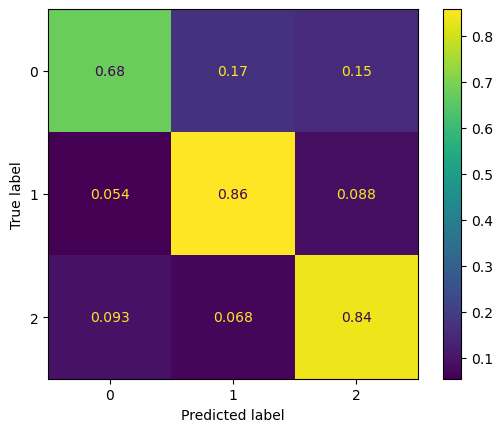

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


[INFO] val_acc has been improved from 9999999999999.00000 to 0.63000. Saving Model!
epoch 01, loss: 0.69706, acc: 0.66619, val_loss: 0.63000, val_accuracy: 0.71833


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 02, loss: 0.69804, acc: 0.66698, val_loss: 0.63031, val_accuracy: 0.71965


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 03, loss: 0.69446, acc: 0.66883, val_loss: 0.63202, val_accuracy: 0.71859


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.14it/s]


epoch 04, loss: 0.69102, acc: 0.67036, val_loss: 0.63483, val_accuracy: 0.71754


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 05, loss: 0.68927, acc: 0.66980, val_loss: 0.63707, val_accuracy: 0.71357


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 06, loss: 0.68815, acc: 0.67438, val_loss: 0.63836, val_accuracy: 0.71410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 07, loss: 0.68665, acc: 0.67506, val_loss: 0.63954, val_accuracy: 0.71436


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 08, loss: 0.68536, acc: 0.67744, val_loss: 0.64106, val_accuracy: 0.71410


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 09, loss: 0.68472, acc: 0.67691, val_loss: 0.64245, val_accuracy: 0.71383


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 10, loss: 0.68426, acc: 0.67659, val_loss: 0.64332, val_accuracy: 0.71436


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 11, loss: 0.68316, acc: 0.67679, val_loss: 0.64422, val_accuracy: 0.71489


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 12, loss: 0.68200, acc: 0.67709, val_loss: 0.64520, val_accuracy: 0.71463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 13, loss: 0.68134, acc: 0.67773, val_loss: 0.64608, val_accuracy: 0.71489


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.99it/s]


epoch 14, loss: 0.68024, acc: 0.67814, val_loss: 0.64703, val_accuracy: 0.71489


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 15, loss: 0.67923, acc: 0.67838, val_loss: 0.64784, val_accuracy: 0.71463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 16, loss: 0.67860, acc: 0.67844, val_loss: 0.64832, val_accuracy: 0.71436


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 17, loss: 0.67768, acc: 0.67859, val_loss: 0.64893, val_accuracy: 0.71436


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 18, loss: 0.67656, acc: 0.67935, val_loss: 0.64974, val_accuracy: 0.71463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 19, loss: 0.67581, acc: 0.67923, val_loss: 0.65030, val_accuracy: 0.71463


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.88it/s]


epoch 20, loss: 0.67521, acc: 0.67879, val_loss: 0.65079, val_accuracy: 0.71515


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 21, loss: 0.67424, acc: 0.68073, val_loss: 0.65128, val_accuracy: 0.71542


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 22, loss: 0.67325, acc: 0.67944, val_loss: 0.65187, val_accuracy: 0.71595


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 23, loss: 0.67241, acc: 0.67950, val_loss: 0.65249, val_accuracy: 0.71621


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.48it/s]


epoch 24, loss: 0.67203, acc: 0.67935, val_loss: 0.65266, val_accuracy: 0.71648


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 25, loss: 0.67090, acc: 0.68108, val_loss: 0.65307, val_accuracy: 0.71912


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 26, loss: 0.66999, acc: 0.68117, val_loss: 0.65364, val_accuracy: 0.71859


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 27, loss: 0.66933, acc: 0.68099, val_loss: 0.65418, val_accuracy: 0.71859


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


epoch 28, loss: 0.66886, acc: 0.68120, val_loss: 0.65448, val_accuracy: 0.72653


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 29, loss: 0.66783, acc: 0.68273, val_loss: 0.65496, val_accuracy: 0.72653


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 30, loss: 0.66689, acc: 0.68320, val_loss: 0.65578, val_accuracy: 0.72653


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 31, loss: 0.66630, acc: 0.68337, val_loss: 0.65633, val_accuracy: 0.72679


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 32, loss: 0.66575, acc: 0.68390, val_loss: 0.65631, val_accuracy: 0.68209


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.07it/s]


epoch 33, loss: 0.66459, acc: 0.68408, val_loss: 0.65696, val_accuracy: 0.68157


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 34, loss: 0.66384, acc: 0.68273, val_loss: 0.65775, val_accuracy: 0.68183


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 35, loss: 0.66331, acc: 0.68293, val_loss: 0.65807, val_accuracy: 0.68104


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.62it/s]


epoch 36, loss: 0.66273, acc: 0.68337, val_loss: 0.65824, val_accuracy: 0.68157


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 37, loss: 0.66170, acc: 0.68484, val_loss: 0.65864, val_accuracy: 0.68130


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 38, loss: 0.66096, acc: 0.68499, val_loss: 0.65910, val_accuracy: 0.67839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 39, loss: 0.66038, acc: 0.68940, val_loss: 0.65944, val_accuracy: 0.67839


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.17it/s]


epoch 40, loss: 0.65970, acc: 0.68969, val_loss: 0.65951, val_accuracy: 0.63555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.77it/s]


epoch 41, loss: 0.65853, acc: 0.68993, val_loss: 0.66007, val_accuracy: 0.63528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 42, loss: 0.65797, acc: 0.68978, val_loss: 0.66071, val_accuracy: 0.63528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 43, loss: 0.65744, acc: 0.69043, val_loss: 0.66098, val_accuracy: 0.63475


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 44, loss: 0.65657, acc: 0.69554, val_loss: 0.66140, val_accuracy: 0.63290


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.54it/s]


epoch 45, loss: 0.65592, acc: 0.69560, val_loss: 0.66169, val_accuracy: 0.63343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 46, loss: 0.65536, acc: 0.69612, val_loss: 0.66191, val_accuracy: 0.63396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 47, loss: 0.65434, acc: 0.69612, val_loss: 0.66268, val_accuracy: 0.63369


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.66it/s]


epoch 48, loss: 0.65363, acc: 0.69645, val_loss: 0.66330, val_accuracy: 0.63687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 49, loss: 0.65339, acc: 0.69671, val_loss: 0.66344, val_accuracy: 0.63660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 50, loss: 0.65251, acc: 0.69936, val_loss: 0.66357, val_accuracy: 0.63608


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 51, loss: 0.65150, acc: 0.69936, val_loss: 0.66409, val_accuracy: 0.63634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 52, loss: 0.65108, acc: 0.69965, val_loss: 0.66476, val_accuracy: 0.63660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


epoch 53, loss: 0.65024, acc: 0.69991, val_loss: 0.66550, val_accuracy: 0.63634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 54, loss: 0.64952, acc: 0.70133, val_loss: 0.66553, val_accuracy: 0.63634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 55, loss: 0.64906, acc: 0.70144, val_loss: 0.66570, val_accuracy: 0.63634


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 56, loss: 0.64807, acc: 0.70159, val_loss: 0.66637, val_accuracy: 0.63687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 57, loss: 0.64749, acc: 0.70162, val_loss: 0.66666, val_accuracy: 0.63660


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.69it/s]


epoch 58, loss: 0.64693, acc: 0.70159, val_loss: 0.66694, val_accuracy: 0.63687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.60it/s]


epoch 59, loss: 0.64614, acc: 0.70670, val_loss: 0.66700, val_accuracy: 0.63687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 60, loss: 0.64522, acc: 0.70667, val_loss: 0.66771, val_accuracy: 0.63713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 61, loss: 0.64477, acc: 0.70653, val_loss: 0.66808, val_accuracy: 0.63766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 62, loss: 0.64412, acc: 0.70679, val_loss: 0.66821, val_accuracy: 0.63766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 63, loss: 0.64319, acc: 0.70799, val_loss: 0.66870, val_accuracy: 0.63766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 64, loss: 0.64261, acc: 0.70761, val_loss: 0.66918, val_accuracy: 0.63819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.06it/s]


epoch 65, loss: 0.64212, acc: 0.70832, val_loss: 0.66936, val_accuracy: 0.63846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 66, loss: 0.64128, acc: 0.70796, val_loss: 0.66997, val_accuracy: 0.63846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.10it/s]


epoch 67, loss: 0.64060, acc: 0.70794, val_loss: 0.67047, val_accuracy: 0.63846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 68, loss: 0.64013, acc: 0.70802, val_loss: 0.67060, val_accuracy: 0.63819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.12it/s]


epoch 69, loss: 0.63927, acc: 0.70802, val_loss: 0.67068, val_accuracy: 0.63819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 70, loss: 0.63852, acc: 0.70805, val_loss: 0.67103, val_accuracy: 0.63819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.69it/s]


epoch 71, loss: 0.63794, acc: 0.70808, val_loss: 0.67156, val_accuracy: 0.63846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 72, loss: 0.63732, acc: 0.70802, val_loss: 0.67215, val_accuracy: 0.63846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.90it/s]


epoch 73, loss: 0.63655, acc: 0.70820, val_loss: 0.67228, val_accuracy: 0.63872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.80it/s]


epoch 74, loss: 0.63606, acc: 0.70820, val_loss: 0.67237, val_accuracy: 0.63872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 75, loss: 0.63505, acc: 0.71249, val_loss: 0.67343, val_accuracy: 0.63925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 76, loss: 0.63467, acc: 0.71272, val_loss: 0.67371, val_accuracy: 0.63925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 77, loss: 0.63418, acc: 0.70849, val_loss: 0.67369, val_accuracy: 0.63925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 78, loss: 0.63320, acc: 0.71270, val_loss: 0.67458, val_accuracy: 0.63951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 79, loss: 0.63255, acc: 0.71278, val_loss: 0.67527, val_accuracy: 0.63951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 80, loss: 0.63218, acc: 0.71299, val_loss: 0.67493, val_accuracy: 0.63925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 81, loss: 0.63140, acc: 0.71311, val_loss: 0.67540, val_accuracy: 0.63951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.05it/s]


epoch 82, loss: 0.63048, acc: 0.71325, val_loss: 0.67620, val_accuracy: 0.63846


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 83, loss: 0.63002, acc: 0.71337, val_loss: 0.67635, val_accuracy: 0.64031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 84, loss: 0.62942, acc: 0.71361, val_loss: 0.67684, val_accuracy: 0.63978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 85, loss: 0.62846, acc: 0.71375, val_loss: 0.67789, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 86, loss: 0.62806, acc: 0.71366, val_loss: 0.67830, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 87, loss: 0.62759, acc: 0.71399, val_loss: 0.67854, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 88, loss: 0.62652, acc: 0.71402, val_loss: 0.67912, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 89, loss: 0.62599, acc: 0.71399, val_loss: 0.67988, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 90, loss: 0.62561, acc: 0.71416, val_loss: 0.68004, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 91, loss: 0.62489, acc: 0.71458, val_loss: 0.68015, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 92, loss: 0.62395, acc: 0.71458, val_loss: 0.68093, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.28it/s]


epoch 93, loss: 0.62335, acc: 0.71493, val_loss: 0.68171, val_accuracy: 0.61756


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 94, loss: 0.62287, acc: 0.72030, val_loss: 0.68221, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 95, loss: 0.62218, acc: 0.72063, val_loss: 0.68262, val_accuracy: 0.61783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 96, loss: 0.62148, acc: 0.72080, val_loss: 0.68317, val_accuracy: 0.61835


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 97, loss: 0.62093, acc: 0.72101, val_loss: 0.68353, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.44it/s]


epoch 98, loss: 0.62044, acc: 0.72080, val_loss: 0.68405, val_accuracy: 0.61835


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 99, loss: 0.61954, acc: 0.72127, val_loss: 0.68505, val_accuracy: 0.61809


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 100, loss: 0.61902, acc: 0.72166, val_loss: 0.68554, val_accuracy: 0.61783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 101, loss: 0.61851, acc: 0.72189, val_loss: 0.68594, val_accuracy: 0.61862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 102, loss: 0.61798, acc: 0.72304, val_loss: 0.68625, val_accuracy: 0.61862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 103, loss: 0.61700, acc: 0.72301, val_loss: 0.68723, val_accuracy: 0.61915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 104, loss: 0.61640, acc: 0.72321, val_loss: 0.68805, val_accuracy: 0.62179


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 105, loss: 0.61589, acc: 0.72327, val_loss: 0.68835, val_accuracy: 0.62153


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 106, loss: 0.61533, acc: 0.72386, val_loss: 0.68885, val_accuracy: 0.62232


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.77it/s]


epoch 107, loss: 0.61460, acc: 0.72374, val_loss: 0.68972, val_accuracy: 0.61386


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 108, loss: 0.61398, acc: 0.72389, val_loss: 0.69043, val_accuracy: 0.61359


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 109, loss: 0.61347, acc: 0.72412, val_loss: 0.69083, val_accuracy: 0.61439


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 110, loss: 0.61294, acc: 0.72424, val_loss: 0.69124, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 111, loss: 0.61210, acc: 0.72433, val_loss: 0.69199, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 112, loss: 0.61154, acc: 0.72436, val_loss: 0.69278, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 113, loss: 0.61093, acc: 0.72480, val_loss: 0.69336, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.48it/s]


epoch 114, loss: 0.61033, acc: 0.72492, val_loss: 0.69395, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 115, loss: 0.60971, acc: 0.72468, val_loss: 0.69462, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.00it/s]


epoch 116, loss: 0.60911, acc: 0.72468, val_loss: 0.69455, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 117, loss: 0.60831, acc: 0.72524, val_loss: 0.69555, val_accuracy: 0.61465


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 118, loss: 0.60810, acc: 0.72571, val_loss: 0.69583, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 119, loss: 0.60720, acc: 0.72700, val_loss: 0.69678, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 120, loss: 0.60652, acc: 0.72697, val_loss: 0.69794, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 121, loss: 0.60611, acc: 0.72697, val_loss: 0.69823, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.80it/s]


epoch 122, loss: 0.60537, acc: 0.72715, val_loss: 0.69912, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 123, loss: 0.60480, acc: 0.72750, val_loss: 0.69975, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 124, loss: 0.60442, acc: 0.72709, val_loss: 0.69966, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 125, loss: 0.60353, acc: 0.72730, val_loss: 0.70053, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.49it/s]


epoch 126, loss: 0.60282, acc: 0.72727, val_loss: 0.70184, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 127, loss: 0.60257, acc: 0.72706, val_loss: 0.70253, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 128, loss: 0.60188, acc: 0.72756, val_loss: 0.70316, val_accuracy: 0.61677


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 129, loss: 0.60112, acc: 0.72774, val_loss: 0.70379, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.22it/s]


epoch 130, loss: 0.60075, acc: 0.72774, val_loss: 0.70424, val_accuracy: 0.61650


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.19it/s]


epoch 131, loss: 0.60024, acc: 0.72803, val_loss: 0.70471, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 132, loss: 0.59931, acc: 0.72835, val_loss: 0.70610, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 133, loss: 0.59893, acc: 0.72824, val_loss: 0.70704, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 134, loss: 0.59839, acc: 0.72818, val_loss: 0.70735, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 135, loss: 0.59765, acc: 0.72835, val_loss: 0.70822, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 136, loss: 0.59695, acc: 0.72847, val_loss: 0.70931, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 137, loss: 0.59665, acc: 0.72865, val_loss: 0.70939, val_accuracy: 0.61624


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 138, loss: 0.59572, acc: 0.72862, val_loss: 0.71018, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 139, loss: 0.59541, acc: 0.72865, val_loss: 0.71103, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.64it/s]


epoch 140, loss: 0.59456, acc: 0.72891, val_loss: 0.71203, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 141, loss: 0.59422, acc: 0.72894, val_loss: 0.71282, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 142, loss: 0.59354, acc: 0.72880, val_loss: 0.71310, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 143, loss: 0.59299, acc: 0.72894, val_loss: 0.71410, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 144, loss: 0.59245, acc: 0.72915, val_loss: 0.71501, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


epoch 145, loss: 0.59173, acc: 0.72927, val_loss: 0.71544, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 146, loss: 0.59113, acc: 0.72935, val_loss: 0.71623, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.89it/s]


epoch 147, loss: 0.59067, acc: 0.72932, val_loss: 0.71677, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.43it/s]


epoch 148, loss: 0.58999, acc: 0.72953, val_loss: 0.71793, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 149, loss: 0.58956, acc: 0.72903, val_loss: 0.71845, val_accuracy: 0.61492


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.13it/s]


epoch 150, loss: 0.58895, acc: 0.72918, val_loss: 0.71909, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.56it/s]


epoch 151, loss: 0.58835, acc: 0.73164, val_loss: 0.71953, val_accuracy: 0.61518


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 152, loss: 0.58752, acc: 0.73150, val_loss: 0.72085, val_accuracy: 0.61571


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 153, loss: 0.58739, acc: 0.73311, val_loss: 0.72128, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


epoch 154, loss: 0.58652, acc: 0.73297, val_loss: 0.72187, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 155, loss: 0.58585, acc: 0.73300, val_loss: 0.72324, val_accuracy: 0.61545


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 156, loss: 0.58543, acc: 0.73311, val_loss: 0.72395, val_accuracy: 0.61597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 157, loss: 0.58493, acc: 0.73320, val_loss: 0.72394, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 158, loss: 0.58417, acc: 0.73291, val_loss: 0.72518, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 159, loss: 0.58357, acc: 0.73311, val_loss: 0.72595, val_accuracy: 0.61730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 160, loss: 0.58303, acc: 0.73250, val_loss: 0.72677, val_accuracy: 0.61730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 161, loss: 0.58259, acc: 0.73273, val_loss: 0.72733, val_accuracy: 0.61703


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 162, loss: 0.58164, acc: 0.73273, val_loss: 0.72891, val_accuracy: 0.61730


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 163, loss: 0.58159, acc: 0.73288, val_loss: 0.72872, val_accuracy: 0.61783


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 164, loss: 0.58079, acc: 0.73294, val_loss: 0.72970, val_accuracy: 0.61862


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 165, loss: 0.57987, acc: 0.73347, val_loss: 0.73145, val_accuracy: 0.61915


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.95it/s]


epoch 166, loss: 0.57979, acc: 0.73355, val_loss: 0.73201, val_accuracy: 0.61888


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 167, loss: 0.57913, acc: 0.73358, val_loss: 0.73240, val_accuracy: 0.61941


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.38it/s]


epoch 168, loss: 0.57827, acc: 0.73391, val_loss: 0.73379, val_accuracy: 0.61968


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 169, loss: 0.57798, acc: 0.73397, val_loss: 0.73414, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 170, loss: 0.57727, acc: 0.73402, val_loss: 0.73438, val_accuracy: 0.62312


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


epoch 171, loss: 0.57653, acc: 0.73908, val_loss: 0.73598, val_accuracy: 0.63026


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.06it/s]


epoch 172, loss: 0.57632, acc: 0.73922, val_loss: 0.73713, val_accuracy: 0.63079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]


epoch 173, loss: 0.57573, acc: 0.74017, val_loss: 0.73765, val_accuracy: 0.63158


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 174, loss: 0.57497, acc: 0.74011, val_loss: 0.73895, val_accuracy: 0.63158


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 175, loss: 0.57435, acc: 0.74037, val_loss: 0.73958, val_accuracy: 0.63131


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 176, loss: 0.57379, acc: 0.74069, val_loss: 0.74016, val_accuracy: 0.63079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 177, loss: 0.57334, acc: 0.74075, val_loss: 0.74076, val_accuracy: 0.63079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 178, loss: 0.57237, acc: 0.74096, val_loss: 0.74242, val_accuracy: 0.63079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.72it/s]


epoch 179, loss: 0.57227, acc: 0.74113, val_loss: 0.74298, val_accuracy: 0.63079


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.86it/s]


epoch 180, loss: 0.57163, acc: 0.74116, val_loss: 0.74365, val_accuracy: 0.63105


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.12it/s]


epoch 181, loss: 0.57080, acc: 0.74102, val_loss: 0.74415, val_accuracy: 0.63131


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 182, loss: 0.57041, acc: 0.74160, val_loss: 0.74542, val_accuracy: 0.63237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.30it/s]


epoch 183, loss: 0.56984, acc: 0.74143, val_loss: 0.74652, val_accuracy: 0.63237


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.89it/s]


epoch 184, loss: 0.56908, acc: 0.74158, val_loss: 0.74760, val_accuracy: 0.63343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 185, loss: 0.56885, acc: 0.74187, val_loss: 0.74828, val_accuracy: 0.63343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 186, loss: 0.56814, acc: 0.74084, val_loss: 0.74910, val_accuracy: 0.63317


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 187, loss: 0.56759, acc: 0.74266, val_loss: 0.75002, val_accuracy: 0.63396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 188, loss: 0.56696, acc: 0.74307, val_loss: 0.75119, val_accuracy: 0.63449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 189, loss: 0.56660, acc: 0.74381, val_loss: 0.75162, val_accuracy: 0.63449


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 190, loss: 0.56598, acc: 0.74404, val_loss: 0.75273, val_accuracy: 0.63687


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 191, loss: 0.56543, acc: 0.74384, val_loss: 0.75418, val_accuracy: 0.63713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 192, loss: 0.56474, acc: 0.74390, val_loss: 0.75543, val_accuracy: 0.63343


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.45it/s]


epoch 193, loss: 0.56413, acc: 0.74410, val_loss: 0.75661, val_accuracy: 0.63396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 194, loss: 0.56398, acc: 0.74404, val_loss: 0.75657, val_accuracy: 0.63396


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 195, loss: 0.56292, acc: 0.74401, val_loss: 0.75825, val_accuracy: 0.63528


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.05it/s]


epoch 196, loss: 0.56255, acc: 0.74466, val_loss: 0.75904, val_accuracy: 0.63581


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.46it/s]


epoch 197, loss: 0.56218, acc: 0.74484, val_loss: 0.75946, val_accuracy: 0.63555


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 198, loss: 0.56135, acc: 0.74481, val_loss: 0.76071, val_accuracy: 0.63713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 199, loss: 0.56093, acc: 0.74528, val_loss: 0.76151, val_accuracy: 0.63713


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.03it/s]


epoch 200, loss: 0.56036, acc: 0.74537, val_loss: 0.76226, val_accuracy: 0.63766


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 201, loss: 0.55993, acc: 0.74531, val_loss: 0.76258, val_accuracy: 0.63740


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 202, loss: 0.55903, acc: 0.74563, val_loss: 0.76420, val_accuracy: 0.63793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 203, loss: 0.55877, acc: 0.74490, val_loss: 0.76495, val_accuracy: 0.63793


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 204, loss: 0.55821, acc: 0.74501, val_loss: 0.76590, val_accuracy: 0.63819


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 205, loss: 0.55753, acc: 0.74522, val_loss: 0.76689, val_accuracy: 0.63872


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.07it/s]


epoch 206, loss: 0.55699, acc: 0.74672, val_loss: 0.76740, val_accuracy: 0.63925


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.98it/s]


epoch 207, loss: 0.55662, acc: 0.74836, val_loss: 0.76894, val_accuracy: 0.63951


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 208, loss: 0.55595, acc: 0.75203, val_loss: 0.77103, val_accuracy: 0.63978


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.06it/s]


epoch 209, loss: 0.55557, acc: 0.75209, val_loss: 0.77113, val_accuracy: 0.64110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 210, loss: 0.55480, acc: 0.75206, val_loss: 0.77104, val_accuracy: 0.64084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.31it/s]


epoch 211, loss: 0.55407, acc: 0.75248, val_loss: 0.77219, val_accuracy: 0.64110


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.44it/s]


epoch 212, loss: 0.55388, acc: 0.75262, val_loss: 0.77391, val_accuracy: 0.64084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 213, loss: 0.55343, acc: 0.75268, val_loss: 0.77507, val_accuracy: 0.64084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.28it/s]


epoch 214, loss: 0.55250, acc: 0.75265, val_loss: 0.77639, val_accuracy: 0.64084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 215, loss: 0.55227, acc: 0.75297, val_loss: 0.77682, val_accuracy: 0.64084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.53it/s]


epoch 216, loss: 0.55161, acc: 0.75306, val_loss: 0.77738, val_accuracy: 0.64084


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.02it/s]


epoch 217, loss: 0.55114, acc: 0.75330, val_loss: 0.77791, val_accuracy: 0.64031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 218, loss: 0.55072, acc: 0.75318, val_loss: 0.77823, val_accuracy: 0.64031


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 219, loss: 0.54998, acc: 0.75289, val_loss: 0.77954, val_accuracy: 0.64004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 220, loss: 0.54953, acc: 0.75309, val_loss: 0.78112, val_accuracy: 0.64004


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.92it/s]


epoch 221, loss: 0.54907, acc: 0.75350, val_loss: 0.78175, val_accuracy: 0.64639


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 222, loss: 0.54846, acc: 0.75344, val_loss: 0.78253, val_accuracy: 0.64692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 223, loss: 0.54793, acc: 0.75286, val_loss: 0.78343, val_accuracy: 0.64692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 224, loss: 0.54751, acc: 0.75303, val_loss: 0.78382, val_accuracy: 0.64692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 225, loss: 0.54713, acc: 0.75271, val_loss: 0.78499, val_accuracy: 0.64692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 226, loss: 0.54637, acc: 0.75303, val_loss: 0.78598, val_accuracy: 0.64692


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.15it/s]


epoch 227, loss: 0.54595, acc: 0.75303, val_loss: 0.78654, val_accuracy: 0.64903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 228, loss: 0.54545, acc: 0.75333, val_loss: 0.78764, val_accuracy: 0.64903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 229, loss: 0.54489, acc: 0.75339, val_loss: 0.78826, val_accuracy: 0.64745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.03it/s]


epoch 230, loss: 0.54447, acc: 0.75718, val_loss: 0.78877, val_accuracy: 0.64745


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 231, loss: 0.54379, acc: 0.75726, val_loss: 0.79022, val_accuracy: 0.64930


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 232, loss: 0.54361, acc: 0.75383, val_loss: 0.79091, val_accuracy: 0.64798


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 233, loss: 0.54273, acc: 0.75759, val_loss: 0.79203, val_accuracy: 0.64851


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.69it/s]


epoch 234, loss: 0.54247, acc: 0.75738, val_loss: 0.79316, val_accuracy: 0.64824


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.76it/s]


epoch 235, loss: 0.54201, acc: 0.75817, val_loss: 0.79356, val_accuracy: 0.64877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 236, loss: 0.54118, acc: 0.75882, val_loss: 0.79426, val_accuracy: 0.64877


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.25it/s]


epoch 237, loss: 0.54125, acc: 0.75867, val_loss: 0.79415, val_accuracy: 0.64903


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.76it/s]


epoch 238, loss: 0.54006, acc: 0.75979, val_loss: 0.79567, val_accuracy: 0.65089


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 239, loss: 0.54014, acc: 0.76003, val_loss: 0.79672, val_accuracy: 0.65062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 240, loss: 0.53932, acc: 0.76008, val_loss: 0.79812, val_accuracy: 0.65115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.55it/s]


epoch 241, loss: 0.53874, acc: 0.76076, val_loss: 0.79839, val_accuracy: 0.65062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 242, loss: 0.53832, acc: 0.76082, val_loss: 0.79943, val_accuracy: 0.65062


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.61it/s]


epoch 243, loss: 0.53798, acc: 0.76126, val_loss: 0.79974, val_accuracy: 0.65141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 244, loss: 0.53721, acc: 0.76126, val_loss: 0.80092, val_accuracy: 0.65221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


epoch 245, loss: 0.53705, acc: 0.76158, val_loss: 0.80219, val_accuracy: 0.65115


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 246, loss: 0.53664, acc: 0.76155, val_loss: 0.80225, val_accuracy: 0.65141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.25it/s]


epoch 247, loss: 0.53545, acc: 0.76191, val_loss: 0.80393, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 248, loss: 0.53556, acc: 0.76208, val_loss: 0.80491, val_accuracy: 0.65168


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.94it/s]


epoch 249, loss: 0.53527, acc: 0.76205, val_loss: 0.80511, val_accuracy: 0.65089


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 250, loss: 0.53403, acc: 0.76743, val_loss: 0.80702, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.85it/s]


epoch 251, loss: 0.53387, acc: 0.76261, val_loss: 0.80715, val_accuracy: 0.65300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.20it/s]


epoch 252, loss: 0.53351, acc: 0.76249, val_loss: 0.80796, val_accuracy: 0.65300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.97it/s]


epoch 253, loss: 0.53300, acc: 0.76246, val_loss: 0.80905, val_accuracy: 0.65141


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.55it/s]


epoch 254, loss: 0.53242, acc: 0.76766, val_loss: 0.81010, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 255, loss: 0.53204, acc: 0.76928, val_loss: 0.81126, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.57it/s]


epoch 256, loss: 0.53129, acc: 0.76925, val_loss: 0.81312, val_accuracy: 0.65247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 257, loss: 0.53094, acc: 0.76954, val_loss: 0.81350, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 258, loss: 0.53050, acc: 0.76952, val_loss: 0.81462, val_accuracy: 0.65512


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.74it/s]


epoch 259, loss: 0.53005, acc: 0.76605, val_loss: 0.81550, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.91it/s]


epoch 260, loss: 0.52970, acc: 0.76987, val_loss: 0.81583, val_accuracy: 0.65221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.20it/s]


epoch 261, loss: 0.52881, acc: 0.77019, val_loss: 0.81737, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 262, loss: 0.52854, acc: 0.77025, val_loss: 0.81845, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 263, loss: 0.52828, acc: 0.77010, val_loss: 0.81817, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 264, loss: 0.52727, acc: 0.77028, val_loss: 0.82060, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 265, loss: 0.52713, acc: 0.77049, val_loss: 0.82151, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.93it/s]


epoch 266, loss: 0.52663, acc: 0.77051, val_loss: 0.82205, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 267, loss: 0.52589, acc: 0.77063, val_loss: 0.82383, val_accuracy: 0.65406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 268, loss: 0.52609, acc: 0.77051, val_loss: 0.82346, val_accuracy: 0.65406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 269, loss: 0.52471, acc: 0.77075, val_loss: 0.82538, val_accuracy: 0.65380


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.10it/s]


epoch 270, loss: 0.52487, acc: 0.77066, val_loss: 0.82540, val_accuracy: 0.65380


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 271, loss: 0.52434, acc: 0.77078, val_loss: 0.82605, val_accuracy: 0.65459


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.97it/s]


epoch 272, loss: 0.52352, acc: 0.77101, val_loss: 0.82768, val_accuracy: 0.65459


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 273, loss: 0.52333, acc: 0.77096, val_loss: 0.82806, val_accuracy: 0.65221


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 274, loss: 0.52257, acc: 0.77445, val_loss: 0.82945, val_accuracy: 0.65459


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 275, loss: 0.52250, acc: 0.77110, val_loss: 0.82993, val_accuracy: 0.65485


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.54it/s]


epoch 276, loss: 0.52172, acc: 0.77125, val_loss: 0.83050, val_accuracy: 0.65274


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 277, loss: 0.52111, acc: 0.77489, val_loss: 0.83217, val_accuracy: 0.65247


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.72it/s]


epoch 278, loss: 0.52111, acc: 0.77489, val_loss: 0.83234, val_accuracy: 0.65274


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 279, loss: 0.52035, acc: 0.77489, val_loss: 0.83336, val_accuracy: 0.65300


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.17it/s]


epoch 280, loss: 0.51968, acc: 0.77516, val_loss: 0.83454, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 281, loss: 0.51972, acc: 0.77536, val_loss: 0.83587, val_accuracy: 0.65327


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.05it/s]


epoch 282, loss: 0.51905, acc: 0.77545, val_loss: 0.83708, val_accuracy: 0.65353


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 283, loss: 0.51873, acc: 0.77571, val_loss: 0.83742, val_accuracy: 0.65380


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.52it/s]


epoch 284, loss: 0.51785, acc: 0.77589, val_loss: 0.83807, val_accuracy: 0.65380


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 285, loss: 0.51752, acc: 0.77595, val_loss: 0.83967, val_accuracy: 0.65406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 286, loss: 0.51749, acc: 0.77595, val_loss: 0.84017, val_accuracy: 0.65406


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.42it/s]


epoch 287, loss: 0.51658, acc: 0.77604, val_loss: 0.84173, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.63it/s]


epoch 288, loss: 0.51629, acc: 0.77610, val_loss: 0.84273, val_accuracy: 0.65459


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 289, loss: 0.51564, acc: 0.77633, val_loss: 0.84331, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 290, loss: 0.51546, acc: 0.77633, val_loss: 0.84324, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 291, loss: 0.51485, acc: 0.77663, val_loss: 0.84472, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.00it/s]


epoch 292, loss: 0.51430, acc: 0.77677, val_loss: 0.84489, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.78it/s]


epoch 293, loss: 0.51410, acc: 0.77674, val_loss: 0.84575, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 294, loss: 0.51349, acc: 0.77701, val_loss: 0.84616, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.18it/s]


epoch 295, loss: 0.51305, acc: 0.77712, val_loss: 0.84737, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 296, loss: 0.51258, acc: 0.77710, val_loss: 0.84840, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 297, loss: 0.51212, acc: 0.77739, val_loss: 0.84937, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 298, loss: 0.51165, acc: 0.77757, val_loss: 0.85019, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 299, loss: 0.51126, acc: 0.77660, val_loss: 0.85100, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


epoch 300, loss: 0.51075, acc: 0.77692, val_loss: 0.85196, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 301, loss: 0.51019, acc: 0.77689, val_loss: 0.85274, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 302, loss: 0.50970, acc: 0.77707, val_loss: 0.85294, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.89it/s]


epoch 303, loss: 0.50940, acc: 0.77715, val_loss: 0.85450, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.67it/s]


epoch 304, loss: 0.50890, acc: 0.77677, val_loss: 0.85562, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 305, loss: 0.50827, acc: 0.77715, val_loss: 0.85647, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.30it/s]


epoch 306, loss: 0.50806, acc: 0.77721, val_loss: 0.85638, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 307, loss: 0.50721, acc: 0.77768, val_loss: 0.85831, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.31it/s]


epoch 308, loss: 0.50713, acc: 0.77739, val_loss: 0.85890, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s]


epoch 309, loss: 0.50645, acc: 0.77795, val_loss: 0.85939, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.56it/s]


epoch 310, loss: 0.50620, acc: 0.77807, val_loss: 0.85981, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 311, loss: 0.50554, acc: 0.77812, val_loss: 0.86198, val_accuracy: 0.65670


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.40it/s]


epoch 312, loss: 0.50519, acc: 0.77771, val_loss: 0.86328, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]


epoch 313, loss: 0.50440, acc: 0.77786, val_loss: 0.86433, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.37it/s]


epoch 314, loss: 0.50429, acc: 0.77804, val_loss: 0.86484, val_accuracy: 0.65644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 315, loss: 0.50346, acc: 0.77807, val_loss: 0.86659, val_accuracy: 0.65644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 316, loss: 0.50345, acc: 0.77801, val_loss: 0.86608, val_accuracy: 0.65618


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 317, loss: 0.50247, acc: 0.77830, val_loss: 0.86797, val_accuracy: 0.65644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


epoch 318, loss: 0.50230, acc: 0.77924, val_loss: 0.86891, val_accuracy: 0.65644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 319, loss: 0.50204, acc: 0.77783, val_loss: 0.86973, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 320, loss: 0.50106, acc: 0.77909, val_loss: 0.87101, val_accuracy: 0.65670


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 321, loss: 0.50117, acc: 0.78003, val_loss: 0.87123, val_accuracy: 0.65644


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.79it/s]


epoch 322, loss: 0.50032, acc: 0.77912, val_loss: 0.87171, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.19it/s]


epoch 323, loss: 0.49990, acc: 0.77927, val_loss: 0.87319, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 324, loss: 0.49998, acc: 0.77924, val_loss: 0.87348, val_accuracy: 0.65670


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 325, loss: 0.49884, acc: 0.77974, val_loss: 0.87543, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.28it/s]


epoch 326, loss: 0.49880, acc: 0.78091, val_loss: 0.87568, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.00it/s]


epoch 327, loss: 0.49848, acc: 0.77936, val_loss: 0.87667, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.66it/s]


epoch 328, loss: 0.49756, acc: 0.77995, val_loss: 0.87782, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.23it/s]


epoch 329, loss: 0.49811, acc: 0.77977, val_loss: 0.87777, val_accuracy: 0.65697


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.95it/s]


epoch 330, loss: 0.49656, acc: 0.78050, val_loss: 0.87941, val_accuracy: 0.65723


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 331, loss: 0.49637, acc: 0.78027, val_loss: 0.88069, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.20it/s]


epoch 332, loss: 0.49620, acc: 0.78050, val_loss: 0.88078, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 333, loss: 0.49567, acc: 0.78047, val_loss: 0.88132, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.23it/s]


epoch 334, loss: 0.49528, acc: 0.78047, val_loss: 0.88361, val_accuracy: 0.65750


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 335, loss: 0.49473, acc: 0.78039, val_loss: 0.88319, val_accuracy: 0.65776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.67it/s]


epoch 336, loss: 0.49408, acc: 0.78039, val_loss: 0.88504, val_accuracy: 0.65776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.35it/s]


epoch 337, loss: 0.49404, acc: 0.78056, val_loss: 0.88545, val_accuracy: 0.65776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 338, loss: 0.49350, acc: 0.78062, val_loss: 0.88632, val_accuracy: 0.65776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 339, loss: 0.49322, acc: 0.78071, val_loss: 0.88514, val_accuracy: 0.65776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.13it/s]


epoch 340, loss: 0.49226, acc: 0.78086, val_loss: 0.88758, val_accuracy: 0.65776


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 341, loss: 0.49229, acc: 0.78097, val_loss: 0.88976, val_accuracy: 0.65803


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.98it/s]


epoch 342, loss: 0.49171, acc: 0.78159, val_loss: 0.89018, val_accuracy: 0.65908


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 343, loss: 0.49135, acc: 0.78183, val_loss: 0.89055, val_accuracy: 0.65803


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 344, loss: 0.49072, acc: 0.78191, val_loss: 0.89301, val_accuracy: 0.65935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 345, loss: 0.49037, acc: 0.78206, val_loss: 0.89417, val_accuracy: 0.65908


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 346, loss: 0.49006, acc: 0.78262, val_loss: 0.89511, val_accuracy: 0.65935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.16it/s]


epoch 347, loss: 0.48912, acc: 0.78227, val_loss: 0.89622, val_accuracy: 0.65961


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 348, loss: 0.48936, acc: 0.78235, val_loss: 0.89737, val_accuracy: 0.65935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.47it/s]


epoch 349, loss: 0.48846, acc: 0.78256, val_loss: 0.89929, val_accuracy: 0.66120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 350, loss: 0.48813, acc: 0.77906, val_loss: 0.90039, val_accuracy: 0.65988


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 351, loss: 0.48792, acc: 0.78265, val_loss: 0.90022, val_accuracy: 0.65935


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 352, loss: 0.48730, acc: 0.78253, val_loss: 0.90260, val_accuracy: 0.65988


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.27it/s]


epoch 353, loss: 0.48675, acc: 0.78300, val_loss: 0.90368, val_accuracy: 0.65988


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.12it/s]


epoch 354, loss: 0.48673, acc: 0.78288, val_loss: 0.90454, val_accuracy: 0.66120


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.04it/s]


epoch 355, loss: 0.48591, acc: 0.77927, val_loss: 0.90572, val_accuracy: 0.66226


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 356, loss: 0.48587, acc: 0.77950, val_loss: 0.90662, val_accuracy: 0.66279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 357, loss: 0.48549, acc: 0.77962, val_loss: 0.90678, val_accuracy: 0.66147


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.42it/s]


epoch 358, loss: 0.48445, acc: 0.78327, val_loss: 0.91075, val_accuracy: 0.66279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.60it/s]


epoch 359, loss: 0.48436, acc: 0.77986, val_loss: 0.91104, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 360, loss: 0.48450, acc: 0.77962, val_loss: 0.91145, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]


epoch 361, loss: 0.48334, acc: 0.78012, val_loss: 0.91221, val_accuracy: 0.66094


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 362, loss: 0.48314, acc: 0.78009, val_loss: 0.91473, val_accuracy: 0.66279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.50it/s]


epoch 363, loss: 0.48293, acc: 0.78039, val_loss: 0.91610, val_accuracy: 0.66199


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s]


epoch 364, loss: 0.48233, acc: 0.78036, val_loss: 0.91761, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.16it/s]


epoch 365, loss: 0.48185, acc: 0.78191, val_loss: 0.91823, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.48it/s]


epoch 366, loss: 0.48154, acc: 0.78297, val_loss: 0.91823, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.82it/s]


epoch 367, loss: 0.48079, acc: 0.78309, val_loss: 0.91893, val_accuracy: 0.66279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 368, loss: 0.48069, acc: 0.78332, val_loss: 0.92005, val_accuracy: 0.66279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.07it/s]


epoch 369, loss: 0.47991, acc: 0.78335, val_loss: 0.92273, val_accuracy: 0.66279


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.70it/s]


epoch 370, loss: 0.47957, acc: 0.78329, val_loss: 0.92434, val_accuracy: 0.66332


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.30it/s]


epoch 371, loss: 0.47938, acc: 0.78335, val_loss: 0.92425, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 372, loss: 0.47879, acc: 0.78338, val_loss: 0.92645, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 373, loss: 0.47823, acc: 0.78362, val_loss: 0.92680, val_accuracy: 0.66305


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 374, loss: 0.47783, acc: 0.78347, val_loss: 0.92913, val_accuracy: 0.66332


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.03it/s]


epoch 375, loss: 0.47750, acc: 0.78391, val_loss: 0.92992, val_accuracy: 0.66358


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 376, loss: 0.47715, acc: 0.78368, val_loss: 0.93080, val_accuracy: 0.64375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 377, loss: 0.47635, acc: 0.78371, val_loss: 0.93268, val_accuracy: 0.64375


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.45it/s]


epoch 378, loss: 0.47627, acc: 0.78379, val_loss: 0.93291, val_accuracy: 0.64401


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.01it/s]


epoch 379, loss: 0.47555, acc: 0.78394, val_loss: 0.93458, val_accuracy: 0.59667


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.21it/s]


epoch 380, loss: 0.47531, acc: 0.78406, val_loss: 0.93540, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.26it/s]


epoch 381, loss: 0.47486, acc: 0.78747, val_loss: 0.93706, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 382, loss: 0.47434, acc: 0.78750, val_loss: 0.93830, val_accuracy: 0.59561


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.84it/s]


epoch 383, loss: 0.47387, acc: 0.78750, val_loss: 0.94059, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 384, loss: 0.47381, acc: 0.78764, val_loss: 0.94057, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 385, loss: 0.47271, acc: 0.78785, val_loss: 0.94385, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.68it/s]


epoch 386, loss: 0.47301, acc: 0.78802, val_loss: 0.94319, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


epoch 387, loss: 0.47223, acc: 0.78779, val_loss: 0.94479, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 388, loss: 0.47134, acc: 0.78820, val_loss: 0.94643, val_accuracy: 0.59640


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 389, loss: 0.47237, acc: 0.78788, val_loss: 0.94608, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 390, loss: 0.47030, acc: 0.78820, val_loss: 0.94980, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.58it/s]


epoch 391, loss: 0.47087, acc: 0.78844, val_loss: 0.95085, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 392, loss: 0.47027, acc: 0.78832, val_loss: 0.95215, val_accuracy: 0.59640


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 393, loss: 0.46968, acc: 0.78847, val_loss: 0.95346, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.00it/s]


epoch 394, loss: 0.46945, acc: 0.78861, val_loss: 0.95313, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.53it/s]


epoch 395, loss: 0.46912, acc: 0.78876, val_loss: 0.95446, val_accuracy: 0.59587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 396, loss: 0.46832, acc: 0.79358, val_loss: 0.95782, val_accuracy: 0.59032


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.93it/s]


epoch 397, loss: 0.46805, acc: 0.79393, val_loss: 0.95861, val_accuracy: 0.59640


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.38it/s]


epoch 398, loss: 0.46790, acc: 0.79405, val_loss: 0.96029, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 399, loss: 0.46681, acc: 0.79434, val_loss: 0.96206, val_accuracy: 0.59244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 400, loss: 0.46712, acc: 0.79431, val_loss: 0.96174, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 401, loss: 0.46618, acc: 0.79461, val_loss: 0.96271, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.90it/s]


epoch 402, loss: 0.46651, acc: 0.79449, val_loss: 0.96437, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 403, loss: 0.46520, acc: 0.79496, val_loss: 0.96538, val_accuracy: 0.59058


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 404, loss: 0.46521, acc: 0.79511, val_loss: 0.96817, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 405, loss: 0.46471, acc: 0.79528, val_loss: 0.96942, val_accuracy: 0.59138


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.49it/s]


epoch 406, loss: 0.46420, acc: 0.79511, val_loss: 0.97110, val_accuracy: 0.59191


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.27it/s]


epoch 407, loss: 0.46400, acc: 0.79543, val_loss: 0.97250, val_accuracy: 0.59164


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 408, loss: 0.46368, acc: 0.79546, val_loss: 0.97442, val_accuracy: 0.59111


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.62it/s]


epoch 409, loss: 0.46279, acc: 0.79566, val_loss: 0.97547, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 410, loss: 0.46282, acc: 0.79578, val_loss: 0.97721, val_accuracy: 0.59217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.33it/s]


epoch 411, loss: 0.46236, acc: 0.79646, val_loss: 0.98011, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.23it/s]


epoch 412, loss: 0.46197, acc: 0.79631, val_loss: 0.97909, val_accuracy: 0.59217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 413, loss: 0.46150, acc: 0.79649, val_loss: 0.98189, val_accuracy: 0.59376


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.19it/s]


epoch 414, loss: 0.46105, acc: 0.79663, val_loss: 0.98230, val_accuracy: 0.59244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.30it/s]


epoch 415, loss: 0.46096, acc: 0.79678, val_loss: 0.98333, val_accuracy: 0.59296


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 416, loss: 0.46004, acc: 0.79669, val_loss: 0.98490, val_accuracy: 0.59217


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.43it/s]


epoch 417, loss: 0.46016, acc: 0.79622, val_loss: 0.98649, val_accuracy: 0.59244


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 418, loss: 0.45962, acc: 0.79657, val_loss: 0.98601, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 419, loss: 0.45887, acc: 0.79628, val_loss: 0.98951, val_accuracy: 0.59508


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 420, loss: 0.45889, acc: 0.79775, val_loss: 0.98944, val_accuracy: 0.59349


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.53it/s]


epoch 421, loss: 0.45809, acc: 0.79784, val_loss: 0.99388, val_accuracy: 0.59508


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.31it/s]


epoch 422, loss: 0.45788, acc: 0.79784, val_loss: 0.99399, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 423, loss: 0.45759, acc: 0.79787, val_loss: 0.99459, val_accuracy: 0.59402


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.64it/s]


epoch 424, loss: 0.45690, acc: 0.79834, val_loss: 0.99595, val_accuracy: 0.59614


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 425, loss: 0.45682, acc: 0.79793, val_loss: 0.99632, val_accuracy: 0.59852


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 426, loss: 0.45600, acc: 0.79801, val_loss: 0.99889, val_accuracy: 0.59773


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.25it/s]


epoch 427, loss: 0.45576, acc: 0.79860, val_loss: 1.00022, val_accuracy: 0.59693


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 428, loss: 0.45556, acc: 0.79910, val_loss: 1.00299, val_accuracy: 0.59720


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.43it/s]


epoch 429, loss: 0.45483, acc: 0.79884, val_loss: 1.00341, val_accuracy: 0.59720


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.11it/s]


epoch 430, loss: 0.45481, acc: 0.79869, val_loss: 1.00472, val_accuracy: 0.59799


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.28it/s]


epoch 431, loss: 0.45415, acc: 0.79910, val_loss: 1.00506, val_accuracy: 0.59905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.86it/s]


epoch 432, loss: 0.45359, acc: 0.79913, val_loss: 1.00856, val_accuracy: 0.59905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.41it/s]


epoch 433, loss: 0.45343, acc: 0.79954, val_loss: 1.00927, val_accuracy: 0.59773


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 434, loss: 0.45322, acc: 0.79945, val_loss: 1.00931, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 435, loss: 0.45256, acc: 0.79989, val_loss: 1.01130, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 436, loss: 0.45220, acc: 0.80004, val_loss: 1.01117, val_accuracy: 0.59958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.23it/s]


epoch 437, loss: 0.45149, acc: 0.80019, val_loss: 1.01310, val_accuracy: 0.59905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.05it/s]


epoch 438, loss: 0.45170, acc: 0.79972, val_loss: 1.01256, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 439, loss: 0.45080, acc: 0.80013, val_loss: 1.01647, val_accuracy: 0.59825


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.41it/s]


epoch 440, loss: 0.45083, acc: 0.80013, val_loss: 1.01424, val_accuracy: 0.59878


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.95it/s]


epoch 441, loss: 0.45025, acc: 0.80036, val_loss: 1.01725, val_accuracy: 0.59984


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 442, loss: 0.44947, acc: 0.80110, val_loss: 1.01933, val_accuracy: 0.60011


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 443, loss: 0.44990, acc: 0.80095, val_loss: 1.02006, val_accuracy: 0.59905


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.61it/s]


epoch 444, loss: 0.44830, acc: 0.80125, val_loss: 1.02222, val_accuracy: 0.60037


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.10it/s]


epoch 445, loss: 0.44958, acc: 0.80116, val_loss: 1.02063, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.26it/s]


epoch 446, loss: 0.44756, acc: 0.80175, val_loss: 1.02470, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.24it/s]


epoch 447, loss: 0.44836, acc: 0.80139, val_loss: 1.02381, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 448, loss: 0.44726, acc: 0.80175, val_loss: 1.02572, val_accuracy: 0.59931


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.34it/s]


epoch 449, loss: 0.44719, acc: 0.80169, val_loss: 1.02709, val_accuracy: 0.59984


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.91it/s]


epoch 450, loss: 0.44676, acc: 0.80201, val_loss: 1.03140, val_accuracy: 0.59984


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.40it/s]


epoch 451, loss: 0.44682, acc: 0.80263, val_loss: 1.02680, val_accuracy: 0.59958


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.73it/s]


epoch 452, loss: 0.44567, acc: 0.80224, val_loss: 1.03071, val_accuracy: 0.60222


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.68it/s]


epoch 453, loss: 0.44571, acc: 0.80219, val_loss: 1.03034, val_accuracy: 0.60011


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.71it/s]


epoch 454, loss: 0.44551, acc: 0.80271, val_loss: 1.03185, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.57it/s]


epoch 455, loss: 0.44438, acc: 0.80271, val_loss: 1.03426, val_accuracy: 0.60090


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.52it/s]


epoch 456, loss: 0.44495, acc: 0.80266, val_loss: 1.03569, val_accuracy: 0.60143


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.39it/s]


epoch 457, loss: 0.44385, acc: 0.80304, val_loss: 1.03691, val_accuracy: 0.60143


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 458, loss: 0.44360, acc: 0.80333, val_loss: 1.03913, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.83it/s]


epoch 459, loss: 0.44328, acc: 0.80351, val_loss: 1.03837, val_accuracy: 0.60169


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 460, loss: 0.44269, acc: 0.80342, val_loss: 1.04139, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.13it/s]


epoch 461, loss: 0.44285, acc: 0.80336, val_loss: 1.03890, val_accuracy: 0.60143


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.83it/s]


epoch 462, loss: 0.44190, acc: 0.80524, val_loss: 1.04454, val_accuracy: 0.60275


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.47it/s]


epoch 463, loss: 0.44147, acc: 0.80410, val_loss: 1.04364, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.50it/s]


epoch 464, loss: 0.44197, acc: 0.80389, val_loss: 1.04449, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 465, loss: 0.44045, acc: 0.80415, val_loss: 1.04631, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.97it/s]


epoch 466, loss: 0.44087, acc: 0.80445, val_loss: 1.04740, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.66it/s]


epoch 467, loss: 0.44037, acc: 0.80412, val_loss: 1.04739, val_accuracy: 0.60222


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.14it/s]


epoch 468, loss: 0.43946, acc: 0.80562, val_loss: 1.04940, val_accuracy: 0.60222


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 469, loss: 0.43945, acc: 0.80486, val_loss: 1.05044, val_accuracy: 0.60275


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.71it/s]


epoch 470, loss: 0.43923, acc: 0.80483, val_loss: 1.05189, val_accuracy: 0.60328


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 471, loss: 0.43864, acc: 0.80457, val_loss: 1.05213, val_accuracy: 0.60222


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 472, loss: 0.43825, acc: 0.80935, val_loss: 1.05418, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


epoch 473, loss: 0.43817, acc: 0.80474, val_loss: 1.05387, val_accuracy: 0.60328


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.50it/s]


epoch 474, loss: 0.43744, acc: 0.80603, val_loss: 1.05774, val_accuracy: 0.60328


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.34it/s]


epoch 475, loss: 0.43704, acc: 0.80489, val_loss: 1.05754, val_accuracy: 0.60275


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.48it/s]


epoch 476, loss: 0.43689, acc: 0.80962, val_loss: 1.05871, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.09it/s]


epoch 477, loss: 0.43660, acc: 0.81103, val_loss: 1.05912, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 478, loss: 0.43596, acc: 0.81029, val_loss: 1.06153, val_accuracy: 0.60249


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.37it/s]


epoch 479, loss: 0.43544, acc: 0.80991, val_loss: 1.06405, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 480, loss: 0.43568, acc: 0.81000, val_loss: 1.06379, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.23it/s]


epoch 481, loss: 0.43461, acc: 0.81024, val_loss: 1.06578, val_accuracy: 0.60381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.12it/s]


epoch 482, loss: 0.43491, acc: 0.80524, val_loss: 1.06452, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.01it/s]


epoch 483, loss: 0.43401, acc: 0.81168, val_loss: 1.06826, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.81it/s]


epoch 484, loss: 0.43410, acc: 0.80994, val_loss: 1.06836, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.15it/s]


epoch 485, loss: 0.43349, acc: 0.80991, val_loss: 1.06983, val_accuracy: 0.60302


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.93it/s]


epoch 486, loss: 0.43312, acc: 0.81047, val_loss: 1.06985, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.32it/s]


epoch 487, loss: 0.43284, acc: 0.81024, val_loss: 1.07324, val_accuracy: 0.60328


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.32it/s]


epoch 488, loss: 0.43289, acc: 0.81053, val_loss: 1.07227, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 489, loss: 0.43154, acc: 0.81247, val_loss: 1.07632, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.51it/s]


epoch 490, loss: 0.43226, acc: 0.81065, val_loss: 1.07465, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 491, loss: 0.43097, acc: 0.81059, val_loss: 1.07971, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.26it/s]


epoch 492, loss: 0.43095, acc: 0.81076, val_loss: 1.08115, val_accuracy: 0.60381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.87it/s]


epoch 493, loss: 0.43081, acc: 0.81282, val_loss: 1.08218, val_accuracy: 0.60354


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.24it/s]


epoch 494, loss: 0.43050, acc: 0.81200, val_loss: 1.08169, val_accuracy: 0.60381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.11it/s]


epoch 495, loss: 0.42991, acc: 0.81191, val_loss: 1.08303, val_accuracy: 0.60328


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.62it/s]


epoch 496, loss: 0.42967, acc: 0.81106, val_loss: 1.08355, val_accuracy: 0.60381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.73it/s]


epoch 497, loss: 0.42885, acc: 0.81317, val_loss: 1.08795, val_accuracy: 0.60381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.45it/s]


epoch 498, loss: 0.42916, acc: 0.81168, val_loss: 1.08642, val_accuracy: 0.60381


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.35it/s]


epoch 499, loss: 0.42785, acc: 0.81256, val_loss: 1.09082, val_accuracy: 0.60407


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.55it/s]


epoch 500, loss: 0.42863, acc: 0.81194, val_loss: 1.09092, val_accuracy: 0.60407
9번째 교차검증
evaluation loss: 0.63000, evaluation accuracy: 0.71833
(5, 3781)
(3781, 5)
Learning rate set to 0.085136
0:	learn: 1.0099251	total: 9.02ms	remaining: 9.01s
1:	learn: 0.9389060	total: 16.7ms	remaining: 8.34s
2:	learn: 0.8807185	total: 23.2ms	remaining: 7.72s
3:	learn: 0.8322488	total: 29.8ms	remaining: 7.42s
4:	learn: 0.7914001	total: 37.3ms	remaining: 7.43s
5:	learn: 0.7559620	total: 43.9ms	remaining: 7.28s
6:	learn: 0.7255560	total: 51.3ms	remaining: 7.28s
7:	learn: 0.6993428	total: 57.9ms	remaining: 7.18s
8:	learn: 0.6766297	total: 64.8ms	remaining: 7.14s
9:	learn: 0.6566181	total: 71.6ms	remaining: 7.09s
10:	learn: 0.6391067	total: 78.3ms	remaining: 7.04s
11:	learn: 0.6238209	total: 87.3ms	remaining: 7.19s
12:	learn: 0.6101954	total: 94.1ms	remaining: 7.15s
13:	learn: 0.5979312	total: 102ms	remaining: 7.15s
14:	learn: 0.5869108	total: 108ms	remaining: 7.11s
15:	learn: 0.5772672	total: 116ms	rem

178:	learn: 0.4664609	total: 1.23s	remaining: 5.66s
179:	learn: 0.4664151	total: 1.24s	remaining: 5.65s
180:	learn: 0.4663794	total: 1.25s	remaining: 5.65s
181:	learn: 0.4663311	total: 1.25s	remaining: 5.64s
182:	learn: 0.4662891	total: 1.26s	remaining: 5.63s
183:	learn: 0.4662438	total: 1.27s	remaining: 5.63s
184:	learn: 0.4662098	total: 1.28s	remaining: 5.62s
185:	learn: 0.4661762	total: 1.28s	remaining: 5.62s
186:	learn: 0.4661442	total: 1.29s	remaining: 5.61s
187:	learn: 0.4661110	total: 1.3s	remaining: 5.61s
188:	learn: 0.4660779	total: 1.31s	remaining: 5.61s
189:	learn: 0.4660442	total: 1.31s	remaining: 5.6s
190:	learn: 0.4660199	total: 1.32s	remaining: 5.6s
191:	learn: 0.4659764	total: 1.33s	remaining: 5.6s
192:	learn: 0.4659447	total: 1.34s	remaining: 5.59s
193:	learn: 0.4659157	total: 1.34s	remaining: 5.59s
194:	learn: 0.4658880	total: 1.35s	remaining: 5.58s
195:	learn: 0.4658593	total: 1.36s	remaining: 5.57s
196:	learn: 0.4658288	total: 1.37s	remaining: 5.57s
197:	learn: 0.46

357:	learn: 0.4633196	total: 2.68s	remaining: 4.81s
358:	learn: 0.4633135	total: 2.69s	remaining: 4.81s
359:	learn: 0.4633045	total: 2.7s	remaining: 4.8s
360:	learn: 0.4632971	total: 2.71s	remaining: 4.79s
361:	learn: 0.4632892	total: 2.72s	remaining: 4.79s
362:	learn: 0.4632820	total: 2.73s	remaining: 4.78s
363:	learn: 0.4632749	total: 2.73s	remaining: 4.78s
364:	learn: 0.4632682	total: 2.74s	remaining: 4.77s
365:	learn: 0.4632583	total: 2.75s	remaining: 4.77s
366:	learn: 0.4632505	total: 2.76s	remaining: 4.76s
367:	learn: 0.4632448	total: 2.77s	remaining: 4.76s
368:	learn: 0.4632370	total: 2.78s	remaining: 4.75s
369:	learn: 0.4632300	total: 2.79s	remaining: 4.75s
370:	learn: 0.4632233	total: 2.8s	remaining: 4.74s
371:	learn: 0.4632153	total: 2.81s	remaining: 4.74s
372:	learn: 0.4632059	total: 2.82s	remaining: 4.74s
373:	learn: 0.4631997	total: 2.82s	remaining: 4.73s
374:	learn: 0.4631873	total: 2.83s	remaining: 4.72s
375:	learn: 0.4631794	total: 2.84s	remaining: 4.72s
376:	learn: 0.4

540:	learn: 0.4624024	total: 4.14s	remaining: 3.51s
541:	learn: 0.4623981	total: 4.15s	remaining: 3.51s
542:	learn: 0.4623959	total: 4.16s	remaining: 3.5s
543:	learn: 0.4623921	total: 4.17s	remaining: 3.49s
544:	learn: 0.4623884	total: 4.17s	remaining: 3.48s
545:	learn: 0.4623841	total: 4.18s	remaining: 3.48s
546:	learn: 0.4623798	total: 4.19s	remaining: 3.47s
547:	learn: 0.4623775	total: 4.2s	remaining: 3.46s
548:	learn: 0.4623742	total: 4.2s	remaining: 3.45s
549:	learn: 0.4623720	total: 4.21s	remaining: 3.44s
550:	learn: 0.4623693	total: 4.22s	remaining: 3.44s
551:	learn: 0.4623666	total: 4.22s	remaining: 3.43s
552:	learn: 0.4623642	total: 4.23s	remaining: 3.42s
553:	learn: 0.4623615	total: 4.24s	remaining: 3.41s
554:	learn: 0.4623590	total: 4.25s	remaining: 3.4s
555:	learn: 0.4623568	total: 4.25s	remaining: 3.4s
556:	learn: 0.4623534	total: 4.26s	remaining: 3.39s
557:	learn: 0.4623493	total: 4.27s	remaining: 3.38s
558:	learn: 0.4623466	total: 4.28s	remaining: 3.37s
559:	learn: 0.462

705:	learn: 0.4619914	total: 5.38s	remaining: 2.24s
706:	learn: 0.4619875	total: 5.39s	remaining: 2.23s
707:	learn: 0.4619850	total: 5.4s	remaining: 2.23s
708:	learn: 0.4619835	total: 5.41s	remaining: 2.22s
709:	learn: 0.4619821	total: 5.41s	remaining: 2.21s
710:	learn: 0.4619806	total: 5.42s	remaining: 2.2s
711:	learn: 0.4619789	total: 5.43s	remaining: 2.19s
712:	learn: 0.4619772	total: 5.43s	remaining: 2.19s
713:	learn: 0.4619753	total: 5.44s	remaining: 2.18s
714:	learn: 0.4619738	total: 5.45s	remaining: 2.17s
715:	learn: 0.4619719	total: 5.46s	remaining: 2.16s
716:	learn: 0.4619704	total: 5.46s	remaining: 2.16s
717:	learn: 0.4619686	total: 5.47s	remaining: 2.15s
718:	learn: 0.4619660	total: 5.48s	remaining: 2.14s
719:	learn: 0.4619645	total: 5.49s	remaining: 2.13s
720:	learn: 0.4619632	total: 5.5s	remaining: 2.13s
721:	learn: 0.4619616	total: 5.5s	remaining: 2.12s
722:	learn: 0.4619598	total: 5.51s	remaining: 2.11s
723:	learn: 0.4619582	total: 5.51s	remaining: 2.1s
724:	learn: 0.461

864:	learn: 0.4617568	total: 6.63s	remaining: 1.03s
865:	learn: 0.4617559	total: 6.64s	remaining: 1.03s
866:	learn: 0.4617548	total: 6.65s	remaining: 1.02s
867:	learn: 0.4617537	total: 6.65s	remaining: 1.01s
868:	learn: 0.4617529	total: 6.66s	remaining: 1s
869:	learn: 0.4617516	total: 6.67s	remaining: 997ms
870:	learn: 0.4617508	total: 6.68s	remaining: 990ms
871:	learn: 0.4617492	total: 6.69s	remaining: 982ms
872:	learn: 0.4617473	total: 6.7s	remaining: 974ms
873:	learn: 0.4617454	total: 6.71s	remaining: 967ms
874:	learn: 0.4617436	total: 6.72s	remaining: 960ms
875:	learn: 0.4617425	total: 6.73s	remaining: 952ms
876:	learn: 0.4617417	total: 6.73s	remaining: 944ms
877:	learn: 0.4617406	total: 6.74s	remaining: 937ms
878:	learn: 0.4617397	total: 6.75s	remaining: 929ms
879:	learn: 0.4617387	total: 6.76s	remaining: 922ms
880:	learn: 0.4617374	total: 6.77s	remaining: 914ms
881:	learn: 0.4617363	total: 6.77s	remaining: 906ms
882:	learn: 0.4617352	total: 6.78s	remaining: 899ms
883:	learn: 0.46

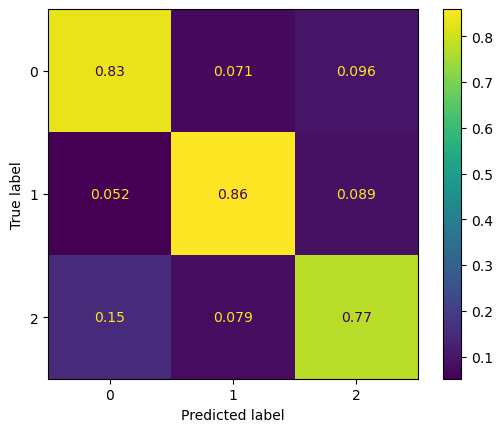

In [54]:
from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_over,y_train_over)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()



    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 



# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

from tqdm import tqdm  # Progress Bar 출력

def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0

    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)

    # mini-batch 학습을 시작합니다.
    for data, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        data, lbl = data.to(device), lbl.to(device)
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()

        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(data)

        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()

        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()

        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * data.size(0)

    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)

            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            

            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

def model_test(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    pred_list=[]
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0

        # 배치별 evaluation을 진행합니다.
        for data, lbl in data_loader:
            # device에 데이터를 올립니다.
            data, lbl = data.to(device), lbl.to(device)

            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(data)
            
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            pred_array = pred.tolist()
            pred_list.append(pred_array) # confusion matrix를 위해 pred 리턴 값
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. data.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 data.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * data.size(0)

        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)

        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc, pred_list

# X_test=pd.DataFrame()
# X_train=pd.DataFrame()
# y_test=pd.DataFrame()
# y_train=pd.DataFrame()
# empty=pd.DataFrame()

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]

from sklearn.model_selection import StratifiedKFold
skf=StratifiedKFold(n_splits=10)

#결과 넣을 배열
Result=[[0 for j in range(4)] for i in range(10)]
CMResult=[[[0 for k in range(3)]for j in range(3)] for i in range(10)]
skf.get_n_splits(X_train_over,y_train_over)

i=0
for tfold, (train_index, test_index) in enumerate(skf.split(X_train_over, y_train_over)):
    #모델 정의, 예측

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

    #DNN
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train.to_numpy())
    y_test = torch.LongTensor(y_test.to_numpy())

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset=TensorDataset(X_test, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=10000,shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=5000,shuffle=False)

    # 최대 Epoch을 지정합니다.
    num_epochs = 500
    min_loss = 9999999999999
    loss_list=[]
    acc_list=[]
    # Epoch 별 훈련 및 검증을 수행합니다.
    for epoch in range(num_epochs):
        # Model Training
        # 훈련 손실과 정확도를 반환 받습니다.
        train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

        # 검증 손실과 검증 정확도를 반환 받습니다.
        val_loss, val_acc = model_evaluate(model, test_dataloader, loss_fn, device)   

        # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
        if val_loss < min_loss:
                print(f'[INFO] val_acc has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
                min_loss = val_loss
                torch.save(model.state_dict(), 'DNNModel2.pth')

        # Epoch 별 결과를 출력합니다.
        print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')
        loss_list.append(train_loss)
        acc_list.append(train_acc)
    ## 저장한 가중치 로드 후 검증 성능 측정

    # 모델에 저장한 가중치를 로드합니다.
    model.load_state_dict(torch.load('DNNModel2.pth'))

    # 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
    print("{}번째 교차검증".format(tfold))
    final_loss, final_acc, y_predicted = model_test(model, test_dataloader, loss_fn, device)
    print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')   

    X_train, X_test = X_train_over[train_index], X_train_over[test_index]
    y_train, y_test = y_train_over[train_index], y_train_over[test_index]

#     ## 원핫 인코딩
#     y_train=pd.get_dummies(y_train)
#     y_test=pd.get_dummies(y_test)


    # LogisticRegression
    lr = LogisticRegression(solver='liblinear', random_state=0)
    lr.fit(X_train, y_train)
    linear_pred = lr.predict(X_test)
    # linear_pred = lr.predict(X_train)
    
    # RidgeClassifier
    clf = RidgeClassifier(alpha=1.0)
    clf.fit(X_train, y_train)
    ridge_pred = clf.predict(X_test)
    # ridge_pred = clf.predict(X_train)
    
    # RandomForestClassifier
    regr = RandomForestClassifier(max_depth=6, random_state=0)
    regr.fit(X_train, y_train)
    regr_pred = regr.predict(X_test)
    # regr_pred = regr.predict(X_train)
    
    # GradientBoostingClassifier
    reg = GradientBoostingClassifier(random_state=0)
    reg.fit(X_train, y_train)
    reg_pred = reg.predict(X_test)
    # reg_pred = reg.predict(X_train)
    
    # DNN 결과값 넘파이 배열로 변환
    y_predicted_t=sum(y_predicted, [])
    DNN_y_predicted=np.array(y_predicted_t)

    # 최종모델
#     lgbm = LGBMClassifier()
    CatBoost = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
    new_data = np.array([linear_pred.squeeze(),ridge_pred.squeeze(),regr_pred.squeeze(),reg_pred.squeeze(),DNN_y_predicted.squeeze()])
    # new_data = np.array([linear_pred,ridge_pred,regr_pred,reg_pred,DNN_y_predicted])
    print(new_data.shape)

    new_data = np.transpose(new_data)
    print(new_data.shape)

    #y_test를 파이토치에서 넘파이 배열로 변환
    y_test=np.array(y_test)
    
    #lgbm 학습하기
    CatBoost.fit(new_data,y_test)
    # lgbm.fit(new_data, y_train)
    
    #LGBMClassifier 예측하기
    CatBoost_pred = CatBoost.predict(new_data)
    # lgbm_pred = lgbm.predict(X_test)

    print('Stacking ensemble (ML+DNN):',len(CatBoost_pred))
    
    
    accuracy=accuracy_score(y_test, CatBoost_pred) * 100
    print("[{}]Accuracy : {}".format(tfold,accuracy))   
    #f1score
    f1 = f1_score(y_test,CatBoost_pred, average='weighted')
    print("[{}]F1score : {}".format(tfold,f1))
    #precision/recall
    p_rlist=sk(y_test,CatBoost_pred,average='weighted')
    print("[{}]Precision : {}".format(tfold,p_rlist[0]))
    print("[{}]Recall : {}".format(tfold,p_rlist[1]))
    print()
     #결과 배열에 넣기
    Result[tfold][0]=accuracy
    Result[tfold][1]=f1
    Result[tfold][2]=p_rlist[0]
    Result[tfold][3]=p_rlist[1]
    del accuracy
    del f1
    del p_rlist
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    confusion_matrix(y_test, CatBoost_pred)

    cm = confusion_matrix(y_test, CatBoost_pred, labels=[0,1,2],normalize="true")
    CMResult[i]=cm
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1,2])
    disp.plot()
    filename=("ConfusionMatrix_"+str(i))
    plt.savefig("./ConfusionMatrix_reward2/"+filename+".png")
    plt.show()
    
    i=i+1

In [55]:
Result_df=pd.DataFrame(Result,columns=['Accuracy','F1-Score','Precision','Recall'])
Result_df

,Accuracy,F1-Score,Precision,Recall
0,67.715494,0.643165,0.692291,0.677155
1,79.481756,0.794929,0.795778,0.794818
2,87.361185,0.871846,0.883862,0.873612
3,81.544157,0.815668,0.816538,0.815442
4,77.948176,0.775351,0.795033,0.779482
5,76.203067,0.756442,0.779902,0.762031
6,73.320994,0.721651,0.741697,0.733210
7,74.643046,0.737940,0.750524,0.746430
8,79.079609,0.788674,0.793285,0.790796
9,82.147580,0.821196,0.821345,0.821476


In [56]:
Matrix=pd.DataFrame(Result_df['Accuracy'],columns=['Accuracy'])
Matrix['Accuracy']=Result_df['Accuracy']
A=[Result_df['Accuracy'].mean(),Result_df['F1-Score'].mean(),Result_df['Precision'].mean(),Result_df['Recall'].mean()]
A=pd.DataFrame(A,columns=['Accuracy'])
Matrix=pd.concat([Matrix,A])
Matrix=Matrix.transpose()
Matrix.to_excel('./ConfusionMatrix_reward2/PFMatrix_ensemble2_final2_grid_reward2.xlsx')

In [ ]:
new_data

In [ ]:
lgbm_pred

In [ ]:
y_test